# Signate開始時のお約束

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'signate.json'", fields="files(id)").execute()
signate_api_key = results.get('files', [])

filename = "/root/.signate/signate.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=signate_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [3]:
!pip install signate

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=cc73a7c26520f41da022818cbf74c13465565dc3f812626d25b19ec71152ca1f
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [4]:
!signate files --competition-id=1523

  fileId  name               title                     size  updated_at
--------  -----------------  ----------------------  ------  -------------------
    3939  train.csv          学習用データ            494008  2024-08-01 12:00:28
    3940  test.csv           評価用データ            488363  2024-08-01 12:00:38
    3944  sample_submit.csv  応募用サンプルファイル   86893  2024-08-01 12:00:49
    4057  tutorial.ipynb     チュートリアルコード    323126  2024-08-01 12:01:00


In [5]:
!signate download --competition-id=1523

sample_submit.csv

tutorial.ipynb

test.csv

train.csv


Download completed.


In [6]:
!pip install kanjize

In [7]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 17.7 MB/s eta 0:00:00


In [8]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# データフレーム読み込み
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")

In [9]:
# データ結合(番号を振り直す)
all_df = pd.concat([train_df,test_df],axis=0,ignore_index=True)
max_row = len(all_df)

In [10]:
# 元のカラム順
colorigin = all_df.columns

<ipython-input-11-8331b9fb236d>:45: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_df["Age"] = all_df["Age"].replace(-1,all_df.loc[all_df["Age"]>0,"Age"].median())


<Axes: >

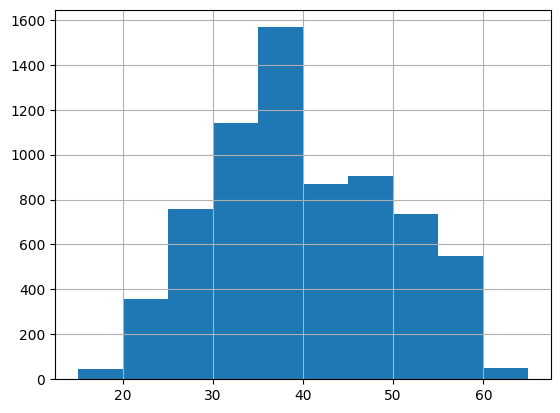

In [11]:
###############
# "Age"の処理 #
###############
import unicodedata # 全角を半角に変換
from kanjize import kanji2number # 漢字を数値に変換
import re

# 漢字の判定用
p = re.compile('[一二三四五六七八九十]+')

# nanを-1歳で補完
all_df["Age"] = all_df["Age"].fillna("-1歳")

# Ageの処理
for i in range(max_row):

  # 末尾文字の取得
  tail = all_df.loc[i,"Age"][-1:]

  # 先頭文字が漢字の場合
  if(p.search(all_df.loc[i,"Age"][0])!=None):
    tmp = all_df.loc[i,"Age"][:-1]
    all_df.loc[i,"Age"] = kanji2number(tmp)
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

  # 末尾文字が歳、才、際の場合
  elif((tail=="歳")or(tail=="才")or(tail=="際")):
    all_df.loc[i,"Age"] = all_df.loc[i,"Age"][:-1]
    # 全角を半角に直す
    all_df.loc[i,"Age"] = unicodedata.normalize("NFKC", all_df.loc[i,"Age"])
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

  # 代の場合
  elif(tail == "代"):
    tmp = all_df.loc[i,"Age"][:-1]

    # 「代」は○5歳に変換する
    tmp = int(tmp)
    # 10歳で分けて5足す
    tmp = tmp//10 * 10
    all_df.loc[i,"Age"] = tmp + 5
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

# 「-1」はそれ以外の中央値を代入
all_df["Age"] = all_df["Age"].replace(-1,all_df.loc[all_df["Age"]>0,"Age"].median())

# int型にキャストする
all_df["Age"] = all_df["Age"].astype(int)

# ヒストグラムを描く
all_df["Age"].hist()

In [12]:
#########################
# "TypeofContact"の処理 #
#########################
# 欠損は最頻値で補完する
all_df["TypeofContact"] = all_df["TypeofContact"].fillna("Self Enquiry")

# one-hot化して追加する
all_df.loc[all_df["TypeofContact"]=="Self Enquiry","TypeofContact"] = 0
all_df.loc[all_df["TypeofContact"]=="Company Invited","TypeofContact"] = 1

# 列名を変更
all_df = all_df.rename(columns={"TypeofContact":"CompanyInvited"})

all_df["CompanyInvited"] = all_df["CompanyInvited"].astype(int)
print(all_df["CompanyInvited"].value_counts())

CompanyInvited
0    4462
1    2516
Name: count, dtype: int64


In [13]:
#########################
# "CityTier"の処理 #
#########################
print(all_df["CityTier"].value_counts())

CityTier
2    3160
1    2991
3     827
Name: count, dtype: int64


In [14]:
#########################
# "DurationOfPitch"の処理 #
#########################
# nanを-1分で補完
all_df["DurationOfPitch"] = all_df["DurationOfPitch"].fillna("-1分")

# 秒を分に変換 #
for i in range(max_row):

  tail = str(all_df.loc[i,"DurationOfPitch"])[-1:]

  if(tail == "秒"):
    tmp = all_df.loc[i,"DurationOfPitch"][:-1]
    all_df.loc[i,"DurationOfPitch"] = float(tmp) / 60.0
  elif(tail == "分"):
    all_df.loc[i,"DurationOfPitch"] = all_df.loc[i,"DurationOfPitch"][:-1]

all_df["DurationOfPitch"] = all_df["DurationOfPitch"].astype("float64")

# 「-1」はそれ以外の中央値を代入
all_df["DurationOfPitch"] = all_df["DurationOfPitch"].replace(-1,all_df.loc[all_df["DurationOfPitch"]>0,"DurationOfPitch"].median())

# 重要でないため、10分刻みのカテゴリにする
all_df["DurationOfPitch"] = (all_df["DurationOfPitch"].values // 10).astype(int)

# 分布を確認する
print(all_df["DurationOfPitch"].value_counts())

DurationOfPitch
1    3824
0    1984
2     709
3     461
Name: count, dtype: int64


In [15]:
####################
# "Occupation"の処理 #
####################
# 特徴量を追加する
all_df["SmallBusiness"] = 0
all_df["Salaried"] = 0
all_df["LargeBusiness"] = 0

# one-hot化して追加する
all_df.loc[all_df["Occupation"]=="Small Business","SmallBusiness"] = 1
all_df.loc[all_df["Occupation"]=="Salaried","Salaried"] = 1
all_df.loc[all_df["Occupation"]=="Large Business","LargeBusiness"] = 1

# 元のカラムを削除する
all_df = all_df.drop("Occupation", axis=1)

print(all_df["SmallBusiness"].value_counts())
print(all_df["Salaried"].value_counts())
print(all_df["LargeBusiness"].value_counts())

SmallBusiness
0    3522
1    3456
Name: count, dtype: int64
Salaried
0    4177
1    2801
Name: count, dtype: int64
LargeBusiness
0    6257
1     721
Name: count, dtype: int64


In [16]:
##################
# "Genger"の処理 #
##################
# 先頭文字がMかmならMaleになる
for i in range(max_row):

  # 先頭文字の取得(半角)
  head = unicodedata.normalize("NFKC", all_df.loc[i,"Gender"][:1])
  if(head == "m"):
    all_df.loc[i,"Gender"] = "Male"
  else:
    all_df.loc[i,"Gender"] = "Female"

# one-hot化して追加する
all_df.loc[all_df["Gender"]=="Male","Gender"] = 1
all_df.loc[all_df["Gender"]=="Female","Gender"] = 0

# 列名を変更する
all_df = all_df.rename(columns={"Gender":"Male"})

all_df["Male"] = all_df["Male"].astype(int)
print(all_df["Male"].value_counts())

Male
0    5946
1    1032
Name: count, dtype: int64


In [17]:
##################################
# "NumberOfPersonVisiting"の処理 #
##################################
print(all_df["NumberOfPersonVisiting"].value_counts())

NumberOfPersonVisiting
2.0    3163
3.0    2773
1.0     686
4.0     356
Name: count, dtype: int64


In [18]:
##################################
# "NumberOfFollowups"の処理 #
##################################

# 欠損を-1で埋めてから中央値を取る
all_df["NumberOfFollowups"] = all_df["NumberOfFollowups"].fillna(-1)
all_df["NumberOfFollowups"] = all_df["NumberOfFollowups"].replace(-1,all_df.loc[all_df["NumberOfFollowups"]>0,"NumberOfFollowups"].median())

# 100回以上は記録違いとして100で割る
all_df.loc[all_df["NumberOfFollowups"]>=100,"NumberOfFollowups"] = all_df.loc[all_df["NumberOfFollowups"]>=100,"NumberOfFollowups"] / 100

# 分布の確認
print(all_df["NumberOfFollowups"].value_counts())

NumberOfFollowups
4.0    2834
3.0    2561
5.0    1122
2.0     213
1.0     178
6.0      70
Name: count, dtype: int64


In [19]:
##########################
# "ProductPitched"の処理 #
##########################
# ギリシャ文字をアルファベットに変換
greek_string = "αβγδεζηθικλμνξοπρστυφχψωвꓢѕꭰտᗞı𐊡"
alphabet_string = "abgdezhqiklmnxoprstufcywbssdsdib"

def greek_to_alphabet(text):
    result = ""
    for char in text:
        if char in greek_string:
            result += alphabet_string[greek_string.index(char)]
        else:
            result += char  # ギリシャ文字以外の文字はそのまま
    return result

# Basic, Standard, Deluxe, Super Deluxe, kingに分ける
prefix = 0
others = []
# すべて小文字に変換し判定
for i in range(len(all_df)):
  prefix = unicodedata.normalize("NFKC", greek_to_alphabet(all_df.loc[i,"ProductPitched"][:2].lower())).lower()

  if(prefix == "ba"):
    all_df.loc[i,"ProductPitched"] = "Basic"

  elif(prefix == "st"):
    all_df.loc[i,"ProductPitched"] = "Standard"

  elif(prefix == "de"):
    all_df.loc[i,"ProductPitched"] = "Deluxe"

  elif(prefix == "su"):
    all_df.loc[i,"ProductPitched"] = "SuperDeluxe"

  elif(prefix == "ki"):
    all_df.loc[i,"ProductPitched"] = "King"

  else:
    others.append(i)

# ラベルエンコード
all_df.loc[all_df["ProductPitched"]=="Basic","ProductPitched"] = 1
all_df.loc[all_df["ProductPitched"]=="Standard","ProductPitched"] = 2
all_df.loc[all_df["ProductPitched"]=="Deluxe","ProductPitched"] = 3
all_df.loc[all_df["ProductPitched"]=="SuperDeluxe","ProductPitched"] = 4
all_df.loc[all_df["ProductPitched"]=="King","ProductPitched"] = 5

all_df["ProductPitched"] = all_df["ProductPitched"].astype(int)

# 分布の確認
print(all_df["ProductPitched"].value_counts())

ProductPitched
1    2347
3    2091
2    1614
4     640
5     286
Name: count, dtype: int64


In [20]:
#################################
# "PreferredPropertyStar"の処理 #
#################################
# 順番に意味があるので2引く
all_df["PreferredPropertyStar"] = all_df["PreferredPropertyStar"] - 2

# 分布を確認する
all_df["PreferredPropertyStar"].value_counts()

,count
PreferredPropertyStar,
1.0,4328
2.0,2254
3.0,396


In [21]:
#########################
# "NumberOfTrips"の処理 #
#########################
# nanは-1で補完
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].fillna("-1")

# 一旦オブジェクト型に変更
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].astype("object")

for i in range(max_row):

  # 先頭文字の取得(半角)
  head = all_df.loc[i,"NumberOfTrips"][:1]

  if(head == "年"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][2:3]

  elif(head == "半"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][3:4]

  elif(head == "四"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][4:5]

# int型に変更
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].astype("int")

# 「-1」はそれ以外の中央値を代入
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].replace(-1,all_df.loc[all_df["NumberOfTrips"]>0,"NumberOfTrips"].median())

# 3グループに分割する
all_df.loc[all_df["NumberOfTrips"]<4,"NumberOfTrips"] = 1
all_df.loc[(all_df["NumberOfTrips"]>=4)& (all_df["NumberOfTrips"]<6),"NumberOfTrips"] = 2
all_df.loc[all_df["NumberOfTrips"]>=6,"NumberOfTrips"] = 3

# 分布を確認する
all_df["NumberOfTrips"].value_counts()

,count
NumberOfTrips,
1,4854
2,1304
3,820


In [22]:
#########################
# "Passport"の処理 #
#########################
print(all_df["Passport"].value_counts())

Passport
0    6288
1     690
Name: count, dtype: int64


In [23]:
##################################
# "PitchSatisfactionScore"の処理 #
##################################
print(all_df["PitchSatisfactionScore"].value_counts())

PitchSatisfactionScore
2    2500
4    1452
1    1439
3    1344
5     243
Name: count, dtype: int64


In [24]:
#########################
# "Designation"の処理 #
#########################

# ギリシャ文字をアルファベットに変換
greek_string = "αβγδεζηθικλμνξοπρστυφχψωвꓢѕꭰտᗞı𐊡Аае"
alphabet_string = "abgdezhqiklmnxoprstufcywbssdsdibaae"

def greek_to_alphabet(text):
    result = ""
    for char in text:
        if char in greek_string:
            result += alphabet_string[greek_string.index(char)]
        else:
            result += char  # ギリシャ文字以外の文字はそのまま
    return result

# 文字を変換する
prefix = 0
for i in range(len(all_df)):
  prefix = unicodedata.normalize("NFKC", greek_to_alphabet(all_df.loc[i,"Designation"][:1].lower())).lower()

  # Executive: 取締役、執行役員
  if(prefix == "e"):
    all_df.loc[i,"Designation"] = "Executive"

  # Vice President: 本部長
  elif(prefix == "v"):
    all_df.loc[i,"Designation"] = "VP"

  # Associate Vice President: 本部長補佐
  elif(prefix == "a"):
    all_df.loc[i,"Designation"] = "AVP"

  # Senior Manager: 次長
  elif(prefix == "s"):
    all_df.loc[i,"Designation"] = "Senior Manager"

  # Manager: 課長
  elif(prefix == "m"):
    all_df.loc[i,"Designation"] = "Manager"

# ラベルエンコード
all_df.loc[all_df["Designation"]=="Executive","Designation"] = 5
all_df.loc[all_df["Designation"]=="VP","Designation"] = 4
all_df.loc[all_df["Designation"]=="AVP","Designation"] = 3
all_df.loc[all_df["Designation"]=="Senior Manager","Designation"] = 2
all_df.loc[all_df["Designation"]=="Manager","Designation"] = 1

# 分布の確認
all_df["Designation"].value_counts()

all_df["Designation"] = all_df["Designation"].astype(int)

<Axes: >

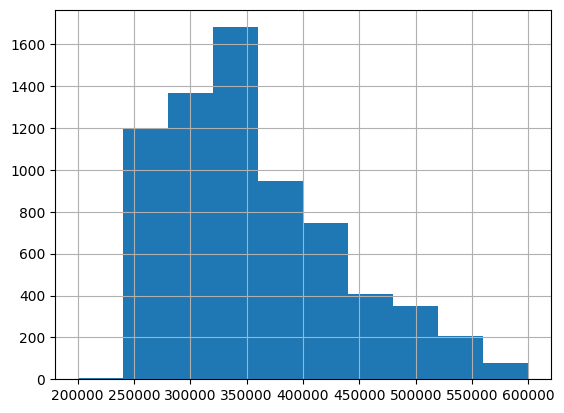

In [25]:
#########################
# "MonthlyIncome"の処理 #
#########################
import re

# 漢字の判定用
p = re.compile('[月]+')

# nanを-1で補完
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].fillna("-1")

for i in range(max_row):

  # 先頭文字の取得
  head = all_df.loc[i,"MonthlyIncome"][:1]

  # 先頭文字が漢字の場合
  if(p.search(head[0])!=None):
    tmp = all_df.loc[i,"MonthlyIncome"][2:-2]
    all_df.loc[i,"MonthlyIncome"] = float(tmp)*10000

# float型にキャストする
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].astype(float)

# 「-1」はそれ以外の中央値を代入
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].replace(-1,all_df.loc[all_df["MonthlyIncome"]>0,"MonthlyIncome"].median())

# 分布の確認
all_df["MonthlyIncome"].hist()

In [26]:
#########################
# "customer_info"の処理 #
#########################
import re

# 項目名
cont = []

# 区切り文字で分割する
for i in range(max_row):
  tmp = re.split("[ 　,、\n\t/／\u3000]",all_df.loc[i,"customer_info"])
  tmp = list(filter(None, tmp))
  if(type(tmp)==list):
    for j in range(len(tmp)):
      if(tmp[j] not in cont):
        cont.append(tmp[j])

# キーワード抽出
c_car = [] # 車関係
c_child = [] # 子供関係
c_married = [] # 婚姻関係
c_other = [] # その他

for i in range(len(cont)):
  # 「車あり」、「車所持」、「自家用車あり」、「車保有」、「乗用車所持」、「自動車保有」
  # 「車なし」、「車未所持」、「自家用車なし」、「車保有なし」、「乗用車なし」、「自動車未所有」
  if((cont[i][0:1] == "車") or (cont[i][0:1] == "自") or (cont[i][0:1] == "乗")):
    c_car.append(cont[i])
  # 「こども1人」、「1児」、「子供1人」、「子供有り(1人)」、「子供有り」
  # 「こども2人」、「2児」、「子供2人」、「子供有り(2人)」
  # 「こども3人」、「3児」「子供3人」、「子供有り(3人)」
  # 「子供なし」、「子供無し」、「無子」、「子供ゼロ」、「非児童家庭」
  # 「子育て状況不明」、「子の数不詳」、「子供の数不明」
  elif((cont[i][0:1] == "子") or (cont[i][0:1] == "こ") or (cont[i][-1:] == "児") or (cont[i][-1:] == "子") or (cont[i][-1:] == "庭")):
    c_child.append(cont[i])
  # 「結婚済み」、「離婚済み」、「未婚」、「独身」
  elif((cont[i][0:1] == "結") or (cont[i][0:1] == "離") or (cont[i][0:1] == "独") or (cont[i][0:1] == "離") or (cont[i][0:1] == "未")):
    c_married.append(cont[i])
  # 「1人」、「2人」、「3人」、「不明」、「わからない」
  else:
    c_other.append(cont[i])

In [27]:
# 新たなカラムを追加
all_df["CarHolder"] = 0 # 車所有
all_df["NumofChild"] = 0 # 子供の数
all_df["Married"] = "Single" # 婚姻歴

# 車
c_car_hold = ["車あり","車所持","自家用車あり","車保有","乗用車所持","自動車保有"]

# 子供
c_child_1 = ["こども1人","1児""子供1人","子供有り(1人)","子供有り"]
c_child_2 = ["こども2人","2児""子供2人","子供有り(2人)"]
c_child_3 = ["こども3人","3児""子供3人","子供有り(3人)"]

# 婚姻状況
c_pair = ["結婚済み"]
c_batu = ["離婚済み"]

# 区切り文字で分割する
for i in range(max_row):
  tmp = re.split("[ 　,、\n\t/／\u3000]",all_df.loc[i,"customer_info"])
  tmp = list(filter(None, tmp))
  if(type(tmp)==list):
    for j in range(len(tmp)):
      # 車の情報
      if(tmp[j] in c_car_hold):
        all_df.loc[i, "CarHolder"] = 1
      # 子供の情報
      if(tmp[j] in c_child_1):
        all_df.loc[i, "NumofChild"] = 1
      if(tmp[j] in c_child_2):
        all_df.loc[i, "NumofChild"] = 2
      if(tmp[j] in c_child_3):
        all_df.loc[i, "NumofChild"] = 3
      # 婚姻歴
      if(tmp[j] in c_pair):
        all_df.loc[i, "Married"] = "Married"
      if(tmp[j] in c_batu):
        all_df.loc[i, "Married"] = "Divorce"

# 使用済みカラム抹消
all_df = all_df.drop("customer_info", axis=1)

In [28]:
# 車保有率
print(all_df["CarHolder"].value_counts())

CarHolder
0    4408
1    2570
Name: count, dtype: int64


In [29]:
# 子供の数
print(all_df["NumofChild"].value_counts())

NumofChild
0    5015
1    1347
2     571
3      45
Name: count, dtype: int64


In [30]:
# 婚姻歴

# 特徴量を追加する
all_df["Family"] = 0
all_df["Single"] = 0
all_df["Divorce"] = 0

# one-hot化して追加する
all_df.loc[all_df["Married"]=="Married","Family"] = 1
all_df.loc[all_df["Married"]=="Single","Single"] = 1
all_df.loc[all_df["Married"]=="Divorce","Divorce"] = 1

# 元のカラムを削除する
all_df = all_df.drop("Married", axis=1)

print(all_df["Family"].value_counts())
print(all_df["Single"].value_counts())
print(all_df["Divorce"].value_counts())

Family
0    4132
1    2846
Name: count, dtype: int64
Single
0    4534
1    2444
Name: count, dtype: int64
Divorce
0    5290
1    1688
Name: count, dtype: int64


In [31]:
all_df.columns

Index(['id', 'Age', 'CompanyInvited', 'CityTier', 'DurationOfPitch', 'Male',
       'NumberOfPersonVisiting', 'NumberOfFollowups', 'ProductPitched',
       'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'ProdTaken',
       'SmallBusiness', 'Salaried', 'LargeBusiness', 'CarHolder', 'NumofChild',
       'Family', 'Single', 'Divorce'],
      dtype='object')

In [32]:
# 順番を整列させる
col = ['id', 'Age', "CompanyInvited", 'CityTier', 'DurationOfPitch',
       'SmallBusiness', 'Salaried', 'LargeBusiness',
       'Male', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', "CarHolder",
       "NumofChild", 'Family', 'Single', 'Divorce',
       'ProdTaken']

all_df = all_df.reindex(columns=col)

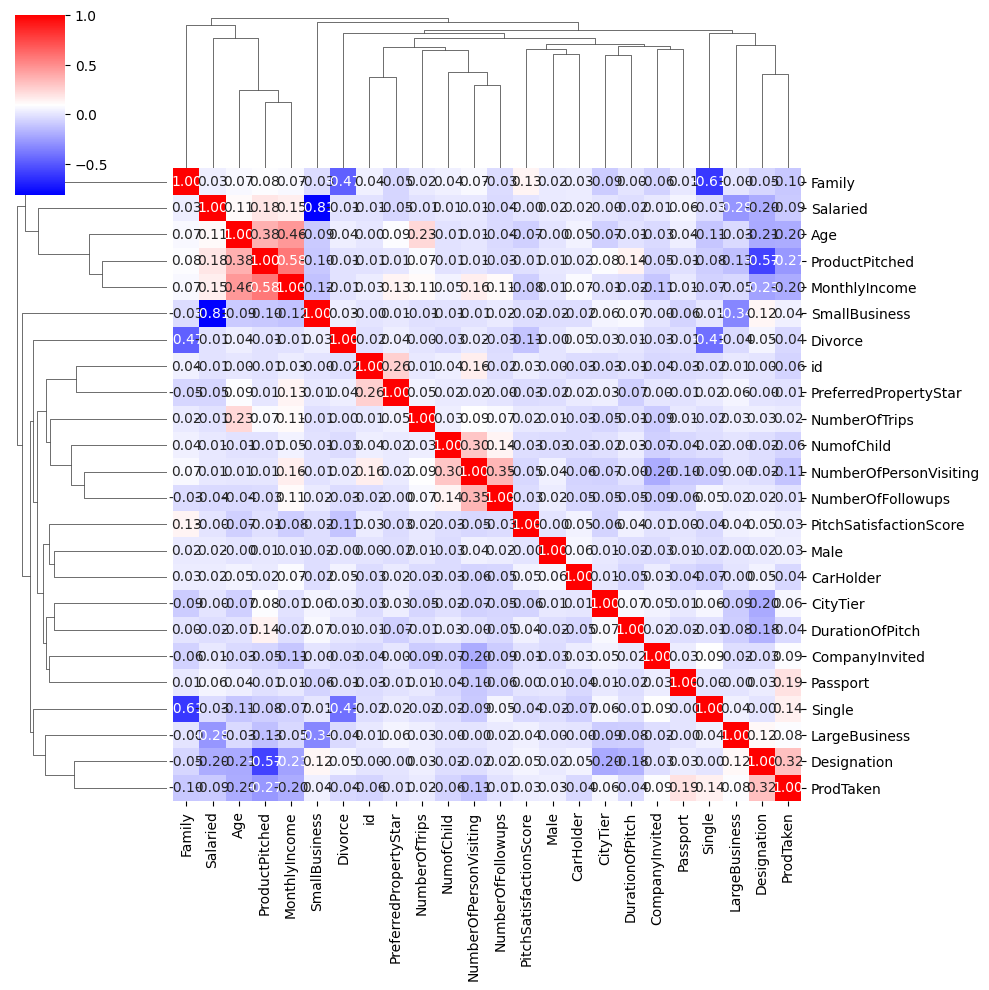

In [33]:
# 相関係数を確認する
import seaborn as sns
import matplotlib.pyplot as plt

all_df_corr = all_df.corr()
sns.clustermap(all_df_corr,annot=True,fmt=".2f",cmap="bwr")
plt.show()

In [34]:
# "Salaried" と "SmallBusiness" が0.6 超えるため、サラリーマンかそうでないかに分ける
all_df = all_df.drop("SmallBusiness", axis=1)
all_df = all_df.drop("LargeBusiness", axis=1)

In [35]:
# "Family" と "Single" が0.6 超えるため、独身かそうでないかに分ける
all_df = all_df.drop("Family", axis=1)
all_df = all_df.drop("Divorce", axis=1)

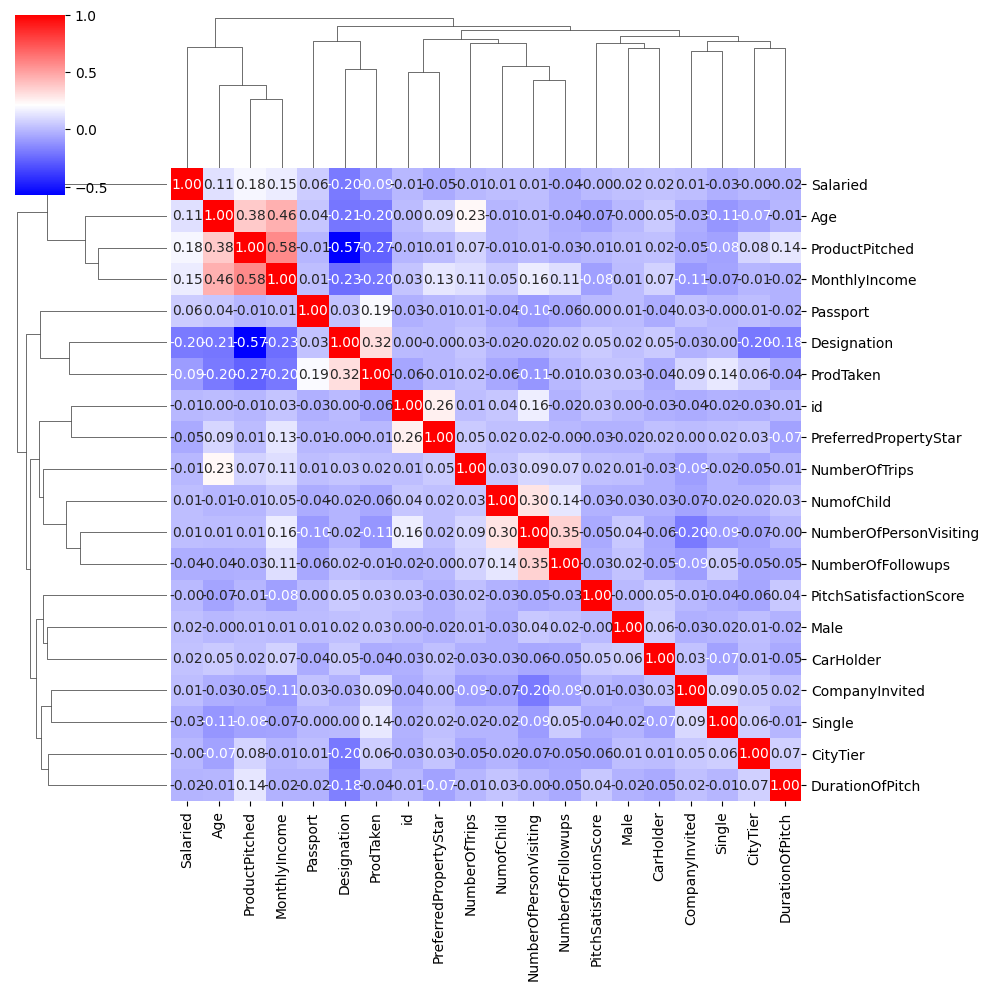

In [36]:
# 相関係数がすべて0.6未満に収まったので次のステップに進む
all_df_corr = all_df.corr()
sns.clustermap(all_df_corr,annot=True,fmt=".2f",cmap="bwr")
plt.show()

# 特徴量エンジニアリング

In [ ]:
plus = all_df[all_df["ProdTaken"]==1] # 正例
minus = all_df[all_df["ProdTaken"]==0]  # 負例
train = pd.concat([plus,minus])
# 全体数の比
print("正例：", len(plus))
print("負例：", len(minus))
print("比率：", len(minus)/len(plus))

正例： 497
負例： 2992
比率： 6.020120724346077


In [ ]:
train.groupby("ProdTaken").mean()

,id,Age,CompanyInvited,CityTier,DurationOfPitch,Salaried,Male,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,CarHolder,NumofChild,Single
ProdTaken,,,,,,,,,,,,,,,,,,,
0.0,1769.117313,40.188503,0.352273,1.680816,0.953209,0.420455,0.141711,2.428142,3.674465,2.382687,1.442513,1.414773,0.078543,2.500000,2.629011,361609.074198,0.384693,0.384358,0.323529
1.0,1592.790744,34.625755,0.472837,1.794769,0.863179,0.287726,0.17505,2.193159,3.657948,1.519115,1.432596,1.454728,0.247485,2.597586,4.136821,318393.682093,0.323944,0.279678,0.521127


In [ ]:
# パスポート所持率が高い
# 若い(34.6歳 VS 40.2歳)、事業主(28.8% VS 42.0%)、パスポート(24.7% VS 7.9%)、月給(31.8万 VS 36.2万)、独身(52.1% VS 32.4%)
data1 = train.loc[train["ProdTaken"]==1].mean()
data0 = train.loc[train["ProdTaken"]==0].mean()
data0 = data0.drop("ProdTaken", axis=0)
data1 = data1.drop("ProdTaken", axis=0)
print(data1/data0)

id                        0.900331
Age                       0.861584
CompanyInvited            1.342247
CityTier                  1.067796
DurationOfPitch           0.905551
Salaried                  0.684322
Male                      1.235261
NumberOfPersonVisiting    0.903225
NumberOfFollowups         0.995505
ProductPitched            0.637564
PreferredPropertyStar     0.993125
NumberOfTrips             1.028242
Passport                  3.150957
PitchSatisfactionScore    1.039034
Designation               1.573528
MonthlyIncome             0.880491
CarHolder                 0.842085
NumofChild                0.727649
Single                    1.610755
dtype: object


# 学習準備

In [ ]:
#-------------------------------------------------------------------------------------------
# カテゴリ列 x 13
# CompanyInvited, CityTier, DurationOfPitch, Salaried, Male, ProductPitched, PreferredPropertyStar,
# NumberOfTrips, Passport, PitchSatisfactionScore, Designation, CarHolder, Single
# 数値列 x 5
# Age, NumberOfPersonVisiting, NumberOfFollowups, MonthlyIncome, NumofChild
#-------------------------------------------------------------------------------------------
all_df.columns

Index(['id', 'Age', 'CompanyInvited', 'CityTier', 'DurationOfPitch',
       'Salaried', 'Male', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'CarHolder',
       'NumofChild', 'Single', 'ProdTaken'],
      dtype='object')

In [ ]:
# まずはseed複数のスコア平均を取る環境を作ること

In [37]:
# クロス特徴量の追加
# 「役職」x「商品ランク」
all_df["Designation_ProductPitched"] = all_df["Designation"] * all_df["ProductPitched"]
# 「パスポート」x「独身」(ボツ)
# all_df["Passport_Single"] = all_df["Passport"] * all_df["Single"]

In [38]:
# 「年齢」x「サラリーマン」
# all_df["Age_Salaried"] = all_df["Age"] * all_df["Salaried"]
# 「年齢」x「満足度」
all_df["Age_PitchSatisfactionScore"] = all_df["Age"] * all_df["PitchSatisfactionScore"]
# 「年齢」x「車所有」
all_df["Age_CarHolder"] = all_df["Age"] * all_df["CarHolder"]

In [54]:
all_df = all_df.drop("Passport_Single", axis=1)

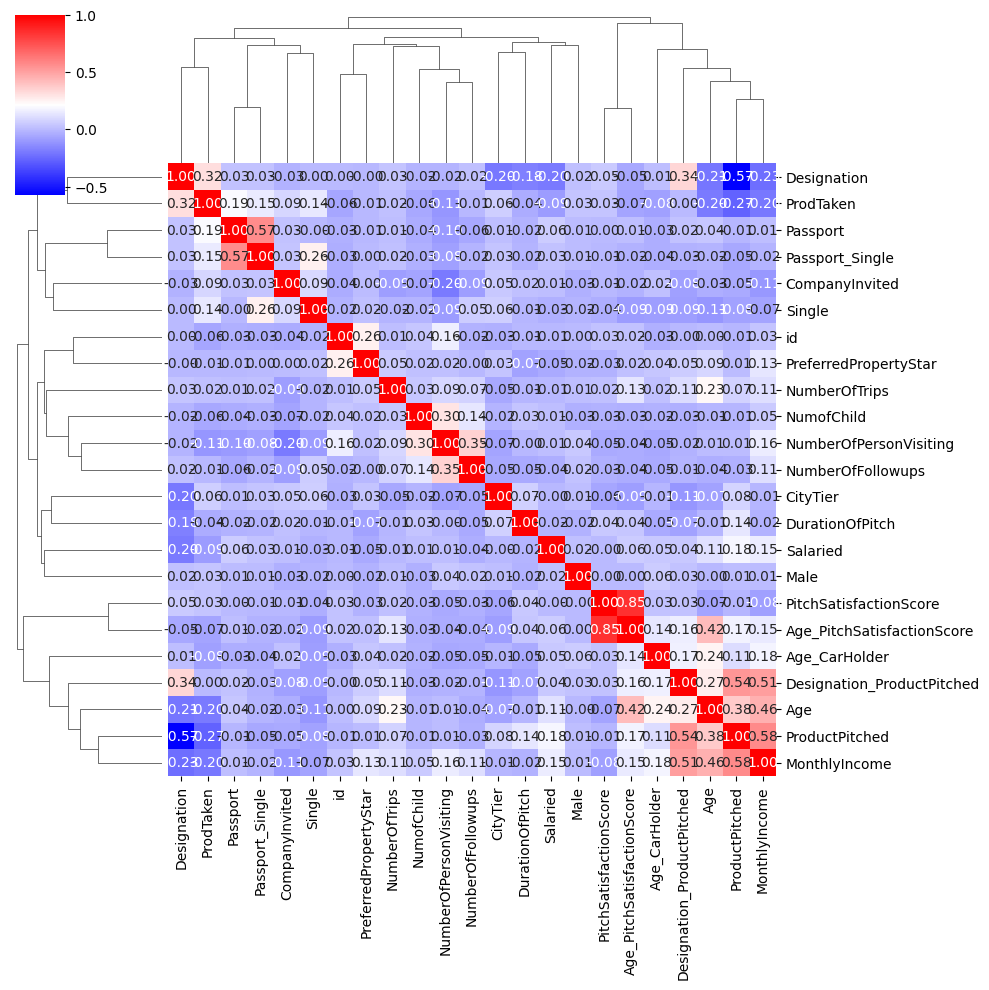

In [40]:
# 相関係数の確認OK
all_df_corr = all_df.corr()
sns.clustermap(all_df_corr,annot=True,fmt=".2f",cmap="bwr")
plt.show()

In [55]:
all_df.columns

Index(['id', 'Age', 'CompanyInvited', 'CityTier', 'DurationOfPitch',
       'Salaried', 'Male', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'NumofChild',
       'Single', 'ProdTaken', 'Designation_ProductPitched',
       'Age_PitchSatisfactionScore', 'Age_CarHolder'],
      dtype='object')

In [58]:
# 順番を整列させる
col = ['id', 'Age', 'CompanyInvited', 'CityTier', 'DurationOfPitch',
       'Salaried', 'Male', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'NumofChild',
       'Single', 'ProdTaken', 'Designation_ProductPitched',
       'Age_PitchSatisfactionScore', 'Age_CarHolder']

# col = ['id', 'Age', 'CompanyInvited', 'CityTier', 'DurationOfPitch',
#        'Salaried', 'Male', 'NumberOfPersonVisiting', 'NumberOfFollowups',
#        'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
#        'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'CarHolder',
#        'NumofChild', 'Single', 'ProdTaken']

all_df = all_df.reindex(columns=col)

In [59]:
len(all_df.columns)

22

# ここから学習作業

In [60]:
# 取り除く変数
RMV = ["id","ProdTaken"]
RMV2 = ["id"]

FEATURES = [c for c in all_df.columns if c not in RMV2]
TARGET = "ProdTaken"

In [61]:
CATS = []
for c in FEATURES:
  if all_df[c].dtype == "object":
    CATS.append(c)
print(CATS)

[]


In [62]:
# オブジェクト型はint型に変換する
all_df[CATS] = all_df[CATS].astype(int)

In [63]:
# カラムを制限
all_df2 = all_df[FEATURES]

# 結合を戻す
train = all_df2.iloc[:len(train_df)].copy()
test = all_df2.iloc[len(train_df):].reset_index(drop=True).copy()

# 対象の列のみ取り込み
test = test.drop(TARGET,axis=1)
FEATURES = test.columns

In [64]:
# Optunaを使用する
import optuna
import lightgbm as lgb
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold

def objective(trial):

  lgbm_params = {
    'objective': 'binary',
    "device": "cpu",
    'metric': 'auc',
    'verbose': -1,              # ログ出力の制御
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'n_estimators': 3000,
    'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
    'num_leaves': trial.suggest_int('num_leaves', 16, 256),
    'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1),
    'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
    'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0,log=True),
    'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0,log=True),
    'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),

    # 'max_depth': trial.suggest_int('max_depth', 3, 12),
    # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
    }

  # 複数シードの平均を取る
  seed = [0, 42, 2025]
  FOLDS = 5 # 分割数
  oof_score = np.zeros(len(seed))

  # SEEDごとのスコアを出す
  for j, seed in enumerate(seed):

    print("#"*25)
    print(f"### seed =  {seed}")
    print("#"*25)

    oof_lgb = np.zeros(len(train))

    skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=seed)

    # 各FOLDのスコアを出す
    for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):

      print("#"*25)
      print(f"### Fold {i+1}")
      print("#"*25)

      # インデックスに割り振る
      x_train = train.loc[train_index, FEATURES].copy()
      y_train = train.loc[train_index, TARGET]
      x_valid = train.loc[test_index, FEATURES].copy()
      y_valid = train.loc[test_index, TARGET]

      # データセット作成
      lgb_train = lgb.Dataset(x_train, y_train)
      lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

      # 学習
      model_lgb = lgb.train(lgbm_params,
                            lgb_train,
                            num_boost_round = 2000,
                            valid_sets = [lgb_train, lgb_eval],
                            valid_names = ["train", "valid"],
                            callbacks = [
                                lgb.early_stopping(stopping_rounds=100, verbose=False),
                                lgb.log_evaluation(100),])

      # valid予測
      oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)

    # AUCの算出
    oof_score[j] = roc_auc_score(train[TARGET],oof_lgb)

  score = np.mean(oof_score)

  return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2025-05-28 13:23:21,545] A new study created in memory with name: no-name-166bfede-8e8e-4503-8560-f838519c8ea8
<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.864632	valid's auc: 0.850485
[200]	train's auc: 0.881496	valid's auc: 0.849381
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.871894	valid's auc: 0.815753
[200]	train's auc: 0.888603	valid's auc: 0.816605
#########################
### Fold 3
#########################
[100]	train's auc: 0.868719	valid's auc: 0.813199


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.884829	valid's auc: 0.815163
[300]	train's auc: 0.900656	valid's auc: 0.815315
[400]	train's auc: 0.91361	valid's auc: 0.815922
[500]	train's auc: 0.924511	valid's auc: 0.813477
#########################
### Fold 4
#########################
[100]	train's auc: 0.863444	valid's auc: 0.833797


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.880535	valid's auc: 0.84034
[300]	train's auc: 0.896328	valid's auc: 0.842515
#########################
### Fold 5
#########################
[100]	train's auc: 0.871992	valid's auc: 0.807118
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865272	valid's auc: 0.835719
[200]	train's auc: 0.884015	valid's auc: 0.836405
#########################
### Fold 2
#########################
[100]	train's auc: 0.862782	valid's auc: 0.838161


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.880205	valid's auc: 0.843629
[300]	train's auc: 0.89699	valid's auc: 0.842542
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.870508	valid's auc: 0.800256
[200]	train's auc: 0.885545	valid's auc: 0.804691
[300]	train's auc: 0.901184	valid's auc: 0.807305
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867045	valid's auc: 0.828502
#########################
### Fold 5
#########################
[100]	train's auc: 0.870057	valid's auc: 0.809618
[200]	train's auc: 0.886598	valid's auc: 0.811476
[300]	train's auc: 0.902033	valid's auc: 0.816831
[400]	train's auc: 0.915788	valid's auc: 0.818165
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.868359	valid's auc: 0.823428
[200]	train's auc: 0.88498	valid's auc: 0.820435
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861256	valid's auc: 0.855778
#########################
### Fold 3
#########################
[100]	train's auc: 0.868764	valid's auc: 0.813663
[200]	train's auc: 0.885509	valid's auc: 0.817204
[300]	train's auc: 0.900247	valid's auc: 0.819076
[400]	train's auc: 0.914456	valid's auc: 0.817828
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.875243	valid's auc: 0.779801
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865832	valid's auc: 0.826002
[200]	train's auc: 0.880719	valid's auc: 0.82955


[I 2025-05-28 13:23:28,440] Trial 0 finished with value: 0.8004515506586757 and parameters: {'feature_fraction': 0.5876365866349494, 'num_leaves': 88, 'bagging_fraction': 0.6444503351523425, 'bagging_freq': 6, 'lambda_l1': 1.0303748987204224e-08, 'lambda_l2': 2.7812074217006007e-07, 'min_data_in_leaf': 62}. Best is trial 0 with value: 0.8004515506586757.


[300]	train's auc: 0.897611	valid's auc: 0.832472
[400]	train's auc: 0.912678	valid's auc: 0.830783
#########################
### seed =  0
#########################


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 1
#########################
[100]	train's auc: 0.95636	valid's auc: 0.842291
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.959903	valid's auc: 0.796622
[200]	train's auc: 0.979789	valid's auc: 0.800351
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.954507	valid's auc: 0.796445
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.955098	valid's auc: 0.830357
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.956894	valid's auc: 0.803976
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.956975	valid's auc: 0.818746
[200]	train's auc: 0.978446	valid's auc: 0.814231
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.955868	valid's auc: 0.828512
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.956673	valid's auc: 0.794489
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.956029	valid's auc: 0.824016
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.960123	valid's auc: 0.801544
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.955921	valid's auc: 0.809114
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.957108	valid's auc: 0.852977
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.95637	valid's auc: 0.811015
[200]	train's auc: 0.978393	valid's auc: 0.809902
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.957931	valid's auc: 0.781639
[200]	train's auc: 0.97786	valid's auc: 0.776665
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.955519	valid's auc: 0.828165


[I 2025-05-28 13:23:42,589] Trial 1 finished with value: 0.7943143486587977 and parameters: {'feature_fraction': 0.6142948113936555, 'num_leaves': 218, 'bagging_fraction': 0.740797395696758, 'bagging_freq': 4, 'lambda_l1': 1.0364723135263699e-07, 'lambda_l2': 0.21080552191104157, 'min_data_in_leaf': 13}. Best is trial 0 with value: 0.8004515506586757.
<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.897001	valid's auc: 0.84913
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.90403	valid's auc: 0.814615
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.900343	valid's auc: 0.803325
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.896552	valid's auc: 0.826833
[200]	train's auc: 0.918912	valid's auc: 0.833089
[300]	train's auc: 0.937837	valid's auc: 0.834084
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.9051	valid's auc: 0.808588
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.899835	valid's auc: 0.823696
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.895259	valid's auc: 0.83791
[200]	train's auc: 0.919614	valid's auc: 0.840569
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.905269	valid's auc: 0.802078
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.903057	valid's auc: 0.829328
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.904943	valid's auc: 0.808131
[200]	train's auc: 0.927643	valid's auc: 0.809128
[300]	train's auc: 0.945949	valid's auc: 0.811645
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.901363	valid's auc: 0.816739
#########################
### Fold 2
#########################
[100]	train's auc: 0.897772	valid's auc: 0.855284
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.901149	valid's auc: 0.816496
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.90719	valid's auc: 0.783663
[200]	train's auc: 0.930286	valid's auc: 0.782432
#########################
### Fold 5
#########################
[100]	train's auc: 0.897354	valid's auc: 0.830428


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-28 13:23:50,932] Trial 2 finished with value: 0.7972450343773874 and parameters: {'feature_fraction': 0.623690009216759, 'num_leaves': 29, 'bagging_fraction': 0.7223050610196922, 'bagging_freq': 2, 'lambda_l1': 4.1857880564258455e-05, 'lambda_l2': 0.0010144412711195628, 'min_data_in_leaf': 25}. Best is trial 0 with value: 0.8004515506586757.
<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead

#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.85922	valid's auc: 0.851689
[200]	train's auc: 0.879408	valid's auc: 0.853161
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.868544	valid's auc: 0.815109
[200]	train's auc: 0.888774	valid's auc: 0.817207
#########################
### Fold 3
#########################
[100]	train's auc: 0.866704	valid's auc: 0.798528


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.883723	valid's auc: 0.807904
[300]	train's auc: 0.90149	valid's auc: 0.812145
[400]	train's auc: 0.916415	valid's auc: 0.811656
#########################
### Fold 4
#########################
[100]	train's auc: 0.860917	valid's auc: 0.835214


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.880959	valid's auc: 0.839649
[300]	train's auc: 0.898823	valid's auc: 0.841065
#########################
### Fold 5
#########################
[100]	train's auc: 0.86922	valid's auc: 0.795404


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.889437	valid's auc: 0.80124
[300]	train's auc: 0.905928	valid's auc: 0.803537
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.86284	valid's auc: 0.829314


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.884754	valid's auc: 0.828579
#########################
### Fold 2
#########################
[100]	train's auc: 0.862558	valid's auc: 0.830134


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.880888	valid's auc: 0.83597
[300]	train's auc: 0.899668	valid's auc: 0.837692
#########################
### Fold 3
#########################
[100]	train's auc: 0.868857	valid's auc: 0.798266


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.887809	valid's auc: 0.802921
[300]	train's auc: 0.904376	valid's auc: 0.803646
#########################
### Fold 4
#########################
[100]	train's auc: 0.865075	valid's auc: 0.82545


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 5
#########################
[100]	train's auc: 0.868978	valid's auc: 0.812979


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.887907	valid's auc: 0.816408
[300]	train's auc: 0.904036	valid's auc: 0.81803
[400]	train's auc: 0.919276	valid's auc: 0.817422
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.866778	valid's auc: 0.81592
[200]	train's auc: 0.886088	valid's auc: 0.820284
[300]	train's auc: 0.902625	valid's auc: 0.820987
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857827	valid's auc: 0.854139
[200]	train's auc: 0.878764	valid's auc: 0.859181
[300]	train's auc: 0.897776	valid's auc: 0.860452
[400]	train's auc: 0.913605	valid's auc: 0.861171
#########################
### Fold 3
#########################
[100]	train's auc: 0.867122	valid's auc: 0.809885


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 4
#########################
[100]	train's auc: 0.869875	valid's auc: 0.787896


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.891306	valid's auc: 0.789194
[300]	train's auc: 0.908247	valid's auc: 0.792449
[400]	train's auc: 0.921875	valid's auc: 0.793039
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862874	valid's auc: 0.825969
[200]	train's auc: 0.882626	valid's auc: 0.829752


[I 2025-05-28 13:24:01,600] Trial 3 finished with value: 0.8146847887682602 and parameters: {'feature_fraction': 0.8830322297265786, 'num_leaves': 36, 'bagging_fraction': 0.7618150568472066, 'bagging_freq': 2, 'lambda_l1': 0.032583792413603214, 'lambda_l2': 0.004572313290978453, 'min_data_in_leaf': 77}. Best is trial 3 with value: 0.8146847887682602.


[300]	train's auc: 0.900816	valid's auc: 0.829364
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.877398	valid's auc: 0.851321
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.882083	valid's auc: 0.804038
[200]	train's auc: 0.906546	valid's auc: 0.80592
#########################
### Fold 3
#########################
[100]	train's auc: 0.873899	valid's auc: 0.795897


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.897693	valid's auc: 0.800745
[300]	train's auc: 0.91808	valid's auc: 0.802398
[400]	train's auc: 0.9368	valid's auc: 0.800813
#########################
### Fold 4
#########################
[100]	train's auc: 0.873534	valid's auc: 0.829328


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.898163	valid's auc: 0.836664
[300]	train's auc: 0.918457	valid's auc: 0.836225
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.881966	valid's auc: 0.797313
[200]	train's auc: 0.908238	valid's auc: 0.800294
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.876638	valid's auc: 0.821572


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.901596	valid's auc: 0.823997
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865802	valid's auc: 0.821589
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.882123	valid's auc: 0.792297
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.877904	valid's auc: 0.811074
[200]	train's auc: 0.902361	valid's auc: 0.817271
[300]	train's auc: 0.922396	valid's auc: 0.818216
[400]	train's auc: 0.939883	valid's auc: 0.81857
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.881999	valid's auc: 0.810192
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.879101	valid's auc: 0.80995
[200]	train's auc: 0.903142	valid's auc: 0.811438
[300]	train's auc: 0.923237	valid's auc: 0.811505
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.875619	valid's auc: 0.850836
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.874968	valid's auc: 0.805585
[200]	train's auc: 0.899327	valid's auc: 0.807204
#########################
### Fold 4
#########################
[100]	train's auc: 0.883781	valid's auc: 0.786277
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.869394	valid's auc: 0.821188
[200]	train's auc: 0.894443	valid's auc: 0.826509


[I 2025-05-28 13:24:13,104] Trial 4 finished with value: 0.7924968482911732 and parameters: {'feature_fraction': 0.9343913729010249, 'num_leaves': 252, 'bagging_fraction': 0.8382584673086684, 'bagging_freq': 3, 'lambda_l1': 1.344684175685534, 'lambda_l2': 1.827081174190798e-07, 'min_data_in_leaf': 36}. Best is trial 3 with value: 0.8146847887682602.


[300]	train's auc: 0.918395	valid's auc: 0.824229
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.900304	valid's auc: 0.84811
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.905902	valid's auc: 0.815502
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.899975	valid's auc: 0.804573
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.897807	valid's auc: 0.830391
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.907005	valid's auc: 0.801324
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.901701	valid's auc: 0.825452
[200]	train's auc: 0.925723	valid's auc: 0.824298
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.89866	valid's auc: 0.832458
[200]	train's auc: 0.924401	valid's auc: 0.833344
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.904107	valid's auc: 0.79739
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.905045	valid's auc: 0.822381
[200]	train's auc: 0.927833	valid's auc: 0.824826
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.905187	valid's auc: 0.80874
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.902571	valid's auc: 0.817324
[200]	train's auc: 0.926344	valid's auc: 0.816237
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.898216	valid's auc: 0.855368
[200]	train's auc: 0.92429	valid's auc: 0.857324
[300]	train's auc: 0.945433	valid's auc: 0.857074
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.90009	valid's auc: 0.812381
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.908782	valid's auc: 0.782617
[200]	train's auc: 0.930597	valid's auc: 0.782331
#########################
### Fold 5
#########################
[100]	train's auc: 0.897305	valid's auc: 0.831881


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-28 13:24:19,133] Trial 5 finished with value: 0.8045843017104409 and parameters: {'feature_fraction': 0.7570164023032937, 'num_leaves': 168, 'bagging_fraction': 0.6697225999563576, 'bagging_freq': 1, 'lambda_l1': 2.5394974965197722e-05, 'lambda_l2': 0.9859502490491362, 'min_data_in_leaf': 25}. Best is trial 3 with value: 0.8146847887682602.
<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead 

#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.943124	valid's auc: 0.843746
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.946897	valid's auc: 0.80408
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.941564	valid's auc: 0.794742
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.941642	valid's auc: 0.835753
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.942968	valid's auc: 0.797558
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.943883	valid's auc: 0.816672
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.942177	valid's auc: 0.824548
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.944266	valid's auc: 0.787036
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.94213	valid's auc: 0.81771
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.946766	valid's auc: 0.80053
[200]	train's auc: 0.969935	valid's auc: 0.800784
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.944943	valid's auc: 0.80704
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.943713	valid's auc: 0.84908
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.942028	valid's auc: 0.80056
[200]	train's auc: 0.966981	valid's auc: 0.80169
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.946593	valid's auc: 0.771471
[200]	train's auc: 0.969122	valid's auc: 0.770189
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-28 13:24:28,600] Trial 6 finished with value: 0.7962140041676081 and parameters: {'feature_fraction': 0.8042960899681727, 'num_leaves': 114, 'bagging_fraction': 0.7717781011531991, 'bagging_freq': 1, 'lambda_l1': 0.05825014524145522, 'lambda_l2': 3.566357440833664e-07, 'min_data_in_leaf': 19}. Best is trial 3 with value: 0.8146847887682602.


[100]	train's auc: 0.939744	valid's auc: 0.828857
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.932907	valid's auc: 0.838127
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.937652	valid's auc: 0.798211
[200]	train's auc: 0.96346	valid's auc: 0.797542
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.931939	valid's auc: 0.788621
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.928942	valid's auc: 0.827507
[200]	train's auc: 0.956187	valid's auc: 0.835888
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.933673	valid's auc: 0.787288
[200]	train's auc: 0.96022	valid's auc: 0.796308
[300]	train's auc: 0.980978	valid's auc: 0.797524
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.932813	valid's auc: 0.810535
[200]	train's auc: 0.96084	valid's auc: 0.813077
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.931611	valid's auc: 0.828094
[200]	train's auc: 0.958389	valid's auc: 0.827425
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.933334	valid's auc: 0.790695
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.93151	valid's auc: 0.806496
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.936185	valid's auc: 0.796189
[200]	train's auc: 0.96125	valid's auc: 0.796544
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.933205	valid's auc: 0.808746
[200]	train's auc: 0.960873	valid's auc: 0.812408
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.929714	valid's auc: 0.850318
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.932131	valid's auc: 0.793713
[200]	train's auc: 0.959377	valid's auc: 0.794354
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.937437	valid's auc: 0.774759
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.928373	valid's auc: 0.821898


[I 2025-05-28 13:24:39,505] Trial 7 finished with value: 0.7952145807106454 and parameters: {'feature_fraction': 0.9138980641120216, 'num_leaves': 204, 'bagging_fraction': 0.8583302690261903, 'bagging_freq': 7, 'lambda_l1': 0.0036550947084352838, 'lambda_l2': 2.804371514929101e-08, 'min_data_in_leaf': 25}. Best is trial 3 with value: 0.8146847887682602.


[200]	train's auc: 0.956976	valid's auc: 0.825344
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857758	valid's auc: 0.847124
[200]	train's auc: 0.875525	valid's auc: 0.848645
[300]	train's auc: 0.89172	valid's auc: 0.84704
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867158	valid's auc: 0.815452
[200]	train's auc: 0.884115	valid's auc: 0.816756
#########################
### Fold 3
#########################
[100]	train's auc: 0.864421	valid's auc: 0.80798
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858748	valid's auc: 0.836546
[200]	train's auc: 0.875139	valid's auc: 0.840998
[300]	train's auc: 0.890859	valid's auc: 0.843949
[400]	train's auc: 0.904957	valid's auc: 0.844286
[500]	train's auc: 0.916822	valid's auc: 0.843831
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865832	valid's auc: 0.805328
[200]	train's auc: 0.882601	valid's auc: 0.808604
[300]	train's auc: 0.899756	valid's auc: 0.808098
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862145	valid's auc: 0.832308
[200]	train's auc: 0.879395	valid's auc: 0.830786
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.860354	valid's auc: 0.83607
[200]	train's auc: 0.875794	valid's auc: 0.841923
[300]	train's auc: 0.891043	valid's auc: 0.845401
[400]	train's auc: 0.90572	valid's auc: 0.843896
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867938	valid's auc: 0.800526
[200]	train's auc: 0.883619	valid's auc: 0.803865
[300]	train's auc: 0.897615	valid's auc: 0.805669
[400]	train's auc: 0.911529	valid's auc: 0.805298
#########################
### Fold 4
#########################
[100]	train's auc: 0.862877	valid's auc: 0.830188
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.864576	valid's auc: 0.810792
[200]	train's auc: 0.88084	valid's auc: 0.813672
[300]	train's auc: 0.896933	valid's auc: 0.819347
[400]	train's auc: 0.910991	valid's auc: 0.817878
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862653	valid's auc: 0.821739
[200]	train's auc: 0.879739	valid's auc: 0.822425
#########################
### Fold 2
#########################
[100]	train's auc: 0.855447	valid's auc: 0.856839


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872501	valid's auc: 0.859281
[300]	train's auc: 0.888596	valid's auc: 0.86097
[400]	train's auc: 0.90256	valid's auc: 0.861773
[500]	train's auc: 0.915317	valid's auc: 0.861488
#########################
### Fold 3
#########################
[100]	train's auc: 0.865062	valid's auc: 0.81491


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.881281	valid's auc: 0.818418
[300]	train's auc: 0.896102	valid's auc: 0.819716
#########################
### Fold 4
#########################
[100]	train's auc: 0.868051	valid's auc: 0.785864


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.8855	valid's auc: 0.788115
[300]	train's auc: 0.900891	valid's auc: 0.790206


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-28 13:24:47,218] Trial 8 finished with value: 0.8027478597072633 and parameters: {'feature_fraction': 0.5253919584843432, 'num_leaves': 185, 'bagging_fraction': 0.8811578224422897, 'bagging_freq': 4, 'lambda_l1': 0.011526628200714841, 'lambda_l2': 3.756050182952702e-07, 'min_data_in_leaf': 90}. Best is trial 3 with value: 0.8146847887682602.


#########################
### Fold 5
#########################
[100]	train's auc: 0.863459	valid's auc: 0.826746
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.875619	valid's auc: 0.85107
[200]	train's auc: 0.896863	valid's auc: 0.846722
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.882698	valid's auc: 0.812258
[200]	train's auc: 0.901399	valid's auc: 0.814314
#########################
### Fold 3
#########################
[100]	train's auc: 0.881256	valid's auc: 0.812297
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.87768	valid's auc: 0.836394
[200]	train's auc: 0.89589	valid's auc: 0.839008
[300]	train's auc: 0.913008	valid's auc: 0.839109
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.88441	valid's auc: 0.81151
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.876791	valid's auc: 0.828779
[200]	train's auc: 0.898305	valid's auc: 0.831388
[300]	train's auc: 0.915583	valid's auc: 0.83005
#########################
### Fold 2
#########################
[100]	train's auc: 0.874617	valid's auc: 0.832291


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 3
#########################
[100]	train's auc: 0.884813	valid's auc: 0.798772
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.878657	valid's auc: 0.827305
#########################
### Fold 5
#########################
[100]	train's auc: 0.882976	valid's auc: 0.812506


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.901086	valid's auc: 0.811645
[300]	train's auc: 0.919995	valid's auc: 0.815023
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.879467	valid's auc: 0.819582
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.872143	valid's auc: 0.859816
#########################
### Fold 3
#########################
[100]	train's auc: 0.881543	valid's auc: 0.816597


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 4
#########################
[100]	train's auc: 0.885512	valid's auc: 0.783258


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.903905	valid's auc: 0.787761
[300]	train's auc: 0.920331	valid's auc: 0.78766


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-28 13:24:55,188] Trial 9 finished with value: 0.7944750723592895 and parameters: {'feature_fraction': 0.5485963334435906, 'num_leaves': 199, 'bagging_fraction': 0.6806971049577625, 'bagging_freq': 7, 'lambda_l1': 1.0734155942690155e-06, 'lambda_l2': 6.663208348452522e-05, 'min_data_in_leaf': 49}. Best is trial 3 with value: 0.8146847887682602.


#########################
### Fold 5
#########################
[100]	train's auc: 0.878756	valid's auc: 0.824989
#########################
### seed =  0
#########################


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 1
#########################
[100]	train's auc: 0.830497	valid's auc: 0.845142
[200]	train's auc: 0.844886	valid's auc: 0.853871
[300]	train's auc: 0.854841	valid's auc: 0.858462
[400]	train's auc: 0.863331	valid's auc: 0.856589
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.837846	valid's auc: 0.816806
[200]	train's auc: 0.850366	valid's auc: 0.820142
[300]	train's auc: 0.861946	valid's auc: 0.820535
[400]	train's auc: 0.869917	valid's auc: 0.819649
#########################
### Fold 3
#########################
[100]	train's auc: 0.840764	valid's auc: 0.787272


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.855242	valid's auc: 0.805029
[300]	train's auc: 0.863197	valid's auc: 0.811082
[400]	train's auc: 0.869328	valid's auc: 0.815484
[500]	train's auc: 0.876157	valid's auc: 0.815062
[600]	train's auc: 0.881052	valid's auc: 0.819531
[700]	train's auc: 0.886569	valid's auc: 0.818873
#########################
### Fold 4
#########################
[100]	train's auc: 0.832972	valid's auc: 0.823258


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.84578	valid's auc: 0.834236
[300]	train's auc: 0.856143	valid's auc: 0.83894
[400]	train's auc: 0.864789	valid's auc: 0.840542
[500]	train's auc: 0.871915	valid's auc: 0.843122
[600]	train's auc: 0.878039	valid's auc: 0.843628
#########################
### Fold 5
#########################
[100]	train's auc: 0.84345	valid's auc: 0.809415


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.8552	valid's auc: 0.811459
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.83342	valid's auc: 0.830602
[200]	train's auc: 0.847188	valid's auc: 0.840736
[300]	train's auc: 0.858375	valid's auc: 0.840602
#########################
### Fold 2
#########################
[100]	train's auc: 0.832406	valid's auc: 0.81903


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.844888	valid's auc: 0.834774
[300]	train's auc: 0.856213	valid's auc: 0.840585
[400]	train's auc: 0.864952	valid's auc: 0.840033
#########################
### Fold 3
#########################
[100]	train's auc: 0.842639	valid's auc: 0.789961


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.853743	valid's auc: 0.797128
[300]	train's auc: 0.863321	valid's auc: 0.805771
[400]	train's auc: 0.871405	valid's auc: 0.807862
[500]	train's auc: 0.879246	valid's auc: 0.805467
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.837289	valid's auc: 0.823612
[200]	train's auc: 0.849728	valid's auc: 0.824354
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.839287	valid's auc: 0.79048
[200]	train's auc: 0.852064	valid's auc: 0.818596
[300]	train's auc: 0.861588	valid's auc: 0.825073
[400]	train's auc: 0.869607	valid's auc: 0.827877
[500]	train's auc: 0.876178	valid's auc: 0.827725
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.840188	valid's auc: 0.812559


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.850059	valid's auc: 0.82286
[300]	train's auc: 0.861229	valid's auc: 0.825167
[400]	train's auc: 0.868588	valid's auc: 0.828378
[500]	train's auc: 0.875642	valid's auc: 0.829431
[600]	train's auc: 0.88088	valid's auc: 0.829448
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.826803	valid's auc: 0.854565
[200]	train's auc: 0.842559	valid's auc: 0.860309
[300]	train's auc: 0.853333	valid's auc: 0.860033
#########################
### Fold 3
#########################
[100]	train's auc: 0.843709	valid's auc: 0.812516


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.853159	valid's auc: 0.81545
[300]	train's auc: 0.862517	valid's auc: 0.814742
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.836023	valid's auc: 0.775265
[200]	train's auc: 0.855317	valid's auc: 0.794717
[300]	train's auc: 0.867719	valid's auc: 0.797103
[400]	train's auc: 0.875404	valid's auc: 0.797609
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.839007	valid's auc: 0.819415
[200]	train's auc: 0.849352	valid's auc: 0.824837


[I 2025-05-28 13:25:05,503] Trial 10 finished with value: 0.8247476167163409 and parameters: {'feature_fraction': 0.9977594847316781, 'num_leaves': 21, 'bagging_fraction': 0.5095916780682663, 'bagging_freq': 5, 'lambda_l1': 1.5972186422619647, 'lambda_l2': 0.006742850521607184, 'min_data_in_leaf': 100}. Best is trial 10 with value: 0.8247476167163409.


[300]	train's auc: 0.858997	valid's auc: 0.827827
[400]	train's auc: 0.868917	valid's auc: 0.828013
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.8172	valid's auc: 0.838445
[200]	train's auc: 0.830924	valid's auc: 0.847274
[300]	train's auc: 0.837666	valid's auc: 0.855151
[400]	train's auc: 0.842859	valid's auc: 0.85791
[500]	train's auc: 0.847543	valid's auc: 0.858946
[600]	train's auc: 0.850559	valid's auc: 0.859498
[700]	train's auc: 0.852263	valid's auc: 0.861237
[800]	train's auc: 0.854575	valid's auc: 0.860936
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.821046	valid's auc: 0.796881
[200]	train's auc: 0.834951	valid's auc: 0.811998
[300]	train's auc: 0.843727	valid's auc: 0.816856
[400]	train's auc: 0.848812	valid's auc: 0.81913
[500]	train's auc: 0.8538	valid's auc: 0.819515
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.823944	valid's auc: 0.777306
[200]	train's auc: 0.841914	valid's auc: 0.792853
[300]	train's auc: 0.848587	valid's auc: 0.795079
[400]	train's auc: 0.85207	valid's auc: 0.802777
[500]	train's auc: 0.854985	valid's auc: 0.806605
[600]	train's auc: 0.857746	valid's auc: 0.809059
[700]	train's auc: 0.859476	valid's auc: 0.810948
[800]	train's auc: 0.861193	valid's auc: 0.812111
[900]	train's auc: 0.863102	valid's auc: 0.814152
[1000]	train's auc: 0.864977	valid's auc: 0.815113
[1100]	train's auc: 0.866315	valid's auc: 0.815855
[1200]	train's auc: 0.867171	valid's auc: 0.816074
[1300]	train's auc: 0.868573	valid's auc: 0.816647
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.82534	valid's auc: 0.811605
[200]	train's auc: 0.833802	valid's auc: 0.821807
[300]	train's auc: 0.840583	valid's auc: 0.83115
[400]	train's auc: 0.845684	valid's auc: 0.834573
[500]	train's auc: 0.849878	valid's auc: 0.837861
[600]	train's auc: 0.851922	valid's auc: 0.838873
[700]	train's auc: 0.854473	valid's auc: 0.838772
#########################
### Fold 5
#########################
[100]	train's auc: 0.825762	valid's auc: 0.801079


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.840586	valid's auc: 0.813807
[300]	train's auc: 0.846955	valid's auc: 0.816003
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.822583	valid's auc: 0.828855
[200]	train's auc: 0.835442	valid's auc: 0.837015
[300]	train's auc: 0.840784	valid's auc: 0.84138
#########################
### Fold 2
#########################
[100]	train's auc: 0.822124	valid's auc: 0.810936
[200]	train's auc: 0.832175	valid's auc: 0.821263


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.840071	valid's auc: 0.828763
[400]	train's auc: 0.844203	valid's auc: 0.833512
[500]	train's auc: 0.848737	valid's auc: 0.83602
[600]	train's auc: 0.85136	valid's auc: 0.836923
[700]	train's auc: 0.854502	valid's auc: 0.83888
[800]	train's auc: 0.85697	valid's auc: 0.839833
#########################
### Fold 3
#########################
[100]	train's auc: 0.829476	valid's auc: 0.788714
[200]	train's auc: 0.841779	valid's auc: 0.799422


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.847532	valid's auc: 0.802196
[400]	train's auc: 0.852689	valid's auc: 0.806074
[500]	train's auc: 0.857816	valid's auc: 0.808351
[600]	train's auc: 0.859978	valid's auc: 0.809548
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.825925	valid's auc: 0.824396
[200]	train's auc: 0.83829	valid's auc: 0.826462
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.824895	valid's auc: 0.772204
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.828701	valid's auc: 0.805343
[200]	train's auc: 0.83635	valid's auc: 0.81536
[300]	train's auc: 0.843798	valid's auc: 0.820201
[400]	train's auc: 0.847696	valid's auc: 0.823662
[500]	train's auc: 0.851447	valid's auc: 0.827358
[600]	train's auc: 0.853964	valid's auc: 0.828813
[700]	train's auc: 0.856121	valid's auc: 0.830452
[800]	train's auc: 0.858046	valid's auc: 0.832525
[900]	train's auc: 0.860372	valid's auc: 0.834097
[1000]	train's auc: 0.861965	valid's auc: 0.834816
[1100]	train's auc: 0.863515	valid's auc: 0.834866
#########################
### Fold 2
#########################
[100]	train's auc: 0.813494	valid's auc: 0.845569


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.831286	valid's auc: 0.85643
[300]	train's auc: 0.836408	valid's auc: 0.856865
[400]	train's auc: 0.841411	valid's auc: 0.858946
[500]	train's auc: 0.845048	valid's auc: 0.860401
[600]	train's auc: 0.847678	valid's auc: 0.860134
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.829869	valid's auc: 0.794278
[200]	train's auc: 0.839765	valid's auc: 0.802415
[300]	train's auc: 0.846599	valid's auc: 0.806732
[400]	train's auc: 0.8521	valid's auc: 0.807996
[500]	train's auc: 0.855009	valid's auc: 0.812499
[600]	train's auc: 0.857887	valid's auc: 0.815163
[700]	train's auc: 0.860104	valid's auc: 0.816226
[800]	train's auc: 0.862446	valid's auc: 0.817389
[900]	train's auc: 0.863509	valid's auc: 0.815214
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.824404	valid's auc: 0.764549
[200]	train's auc: 0.839342	valid's auc: 0.77997
[300]	train's auc: 0.848805	valid's auc: 0.790897
[400]	train's auc: 0.854583	valid's auc: 0.793882
[500]	train's auc: 0.858755	valid's auc: 0.795349
#########################
### Fold 5
#########################
[100]	train's auc: 0.826489	valid's auc: 0.817244


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.836953	valid's auc: 0.821484
[300]	train's auc: 0.843889	valid's auc: 0.827497
[400]	train's auc: 0.84902	valid's auc: 0.82906
[500]	train's auc: 0.852997	valid's auc: 0.829685
[600]	train's auc: 0.855339	valid's auc: 0.83107


[I 2025-05-28 13:25:18,783] Trial 11 finished with value: 0.8188841157461705 and parameters: {'feature_fraction': 0.9957704302151893, 'num_leaves': 18, 'bagging_fraction': 0.5019521460345905, 'bagging_freq': 5, 'lambda_l1': 7.229091097979456, 'lambda_l2': 0.006482337502707702, 'min_data_in_leaf': 100}. Best is trial 10 with value: 0.8247476167163409.


[700]	train's auc: 0.858315	valid's auc: 0.832185
[800]	train's auc: 0.859846	valid's auc: 0.831881
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.815432	valid's auc: 0.834557
#########################
### Fold 2
#########################
[100]	train's auc: 0.81795	valid's auc: 0.798562
[200]	train's auc: 0.832471	valid's auc: 0.811664
[300]	train's auc: 0.840619	valid's auc: 0.815226
[400]	train's auc: 0.845201	valid's auc: 0.817726
[500]	train's auc: 0.849931	valid's auc: 0.818679
#########################
### Fold 3
#########################
[100]	train's auc: 0.823179	valid's auc: 0.773596


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.839554	valid's auc: 0.792111
[300]	train's auc: 0.845664	valid's auc: 0.797718
[400]	train's auc: 0.848724	valid's auc: 0.802339
[500]	train's auc: 0.851949	valid's auc: 0.805324
[600]	train's auc: 0.854392	valid's auc: 0.807878
[700]	train's auc: 0.85581	valid's auc: 0.809835
[800]	train's auc: 0.857038	valid's auc: 0.810543
[900]	train's auc: 0.858487	valid's auc: 0.81169
[1000]	train's auc: 0.859702	valid's auc: 0.812128
[1100]	train's auc: 0.860601	valid's auc: 0.813039
[1200]	train's auc: 0.861393	valid's auc: 0.813258
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.822104	valid's auc: 0.811268
[200]	train's auc: 0.831804	valid's auc: 0.820517
[300]	train's auc: 0.837501	valid's auc: 0.828553
[400]	train's auc: 0.842459	valid's auc: 0.832043
[500]	train's auc: 0.846059	valid's auc: 0.834505
[600]	train's auc: 0.848241	valid's auc: 0.836074
[700]	train's auc: 0.850173	valid's auc: 0.837389
[800]	train's auc: 0.851621	valid's auc: 0.837372
[900]	train's auc: 0.852955	valid's auc: 0.838637
[1000]	train's auc: 0.854766	valid's auc: 0.838603
#########################
### Fold 5
#########################
[100]	train's auc: 0.825293	valid's auc: 0.803647


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.838776	valid's auc: 0.815124
[300]	train's auc: 0.844256	valid's auc: 0.816003
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.819269	valid's auc: 0.831923
[200]	train's auc: 0.832965	valid's auc: 0.83888
[300]	train's auc: 0.838807	valid's auc: 0.842926
[400]	train's auc: 0.843173	valid's auc: 0.844565
[500]	train's auc: 0.846263	valid's auc: 0.845134
[600]	train's auc: 0.848531	valid's auc: 0.845284
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.821013	valid's auc: 0.808453
[200]	train's auc: 0.828983	valid's auc: 0.817784
[300]	train's auc: 0.837446	valid's auc: 0.827199
[400]	train's auc: 0.841856	valid's auc: 0.833579
[500]	train's auc: 0.846088	valid's auc: 0.83602
[600]	train's auc: 0.848471	valid's auc: 0.837692
[700]	train's auc: 0.850452	valid's auc: 0.839365
[800]	train's auc: 0.852179	valid's auc: 0.841288
#########################
### Fold 3
#########################
[100]	train's auc: 0.826695	valid's auc: 0.790518
[200]	train's auc: 0.839316	valid's auc: 0.795197


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.844825	valid's auc: 0.798688
[400]	train's auc: 0.84907	valid's auc: 0.801268
[500]	train's auc: 0.853455	valid's auc: 0.804927
[600]	train's auc: 0.855326	valid's auc: 0.805754
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.823001	valid's auc: 0.820197
[200]	train's auc: 0.833973	valid's auc: 0.824632
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.824474	valid's auc: 0.786637
[200]	train's auc: 0.835608	valid's auc: 0.800091
[300]	train's auc: 0.842663	valid's auc: 0.809331
[400]	train's auc: 0.847922	valid's auc: 0.815918
[500]	train's auc: 0.851291	valid's auc: 0.818249
[600]	train's auc: 0.853988	valid's auc: 0.820749
[700]	train's auc: 0.856135	valid's auc: 0.821898
[800]	train's auc: 0.857311	valid's auc: 0.823148
[900]	train's auc: 0.858271	valid's auc: 0.823739
[1000]	train's auc: 0.859284	valid's auc: 0.824905
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.82973	valid's auc: 0.807191


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.834343	valid's auc: 0.81311
[300]	train's auc: 0.842383	valid's auc: 0.818294
[400]	train's auc: 0.845395	valid's auc: 0.820953
[500]	train's auc: 0.847807	valid's auc: 0.824114
[600]	train's auc: 0.85003	valid's auc: 0.825786
[700]	train's auc: 0.851273	valid's auc: 0.826304
[800]	train's auc: 0.853221	valid's auc: 0.827977
[900]	train's auc: 0.854745	valid's auc: 0.828796
[1000]	train's auc: 0.856074	valid's auc: 0.829849
[1100]	train's auc: 0.857278	valid's auc: 0.831137
[1200]	train's auc: 0.85848	valid's auc: 0.831806
[1300]	train's auc: 0.8593	valid's auc: 0.833027
[1400]	train's auc: 0.86018	valid's auc: 0.833478
[1500]	train's auc: 0.860947	valid's auc: 0.833997
[1600]	train's auc: 0.862022	valid's auc: 0.834097
#########################
### Fold 2
#########################
[100]	train's auc: 0.810508	valid's auc: 0.845769


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.828463	valid's auc: 0.855318
[300]	train's auc: 0.833526	valid's auc: 0.856589
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.827767	valid's auc: 0.78986
[200]	train's auc: 0.836975	valid's auc: 0.799371
[300]	train's auc: 0.843605	valid's auc: 0.803637
[400]	train's auc: 0.848969	valid's auc: 0.806487
[500]	train's auc: 0.85176	valid's auc: 0.810981
[600]	train's auc: 0.854318	valid's auc: 0.814455
[700]	train's auc: 0.85607	valid's auc: 0.815366
[800]	train's auc: 0.85794	valid's auc: 0.816647
[900]	train's auc: 0.858889	valid's auc: 0.815821
#########################
### Fold 4
#########################
[100]	train's auc: 0.825854	valid's auc: 0.773908
[200]	train's auc: 0.836586	valid's auc: 0.779245


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.844557	valid's auc: 0.789135
[400]	train's auc: 0.850039	valid's auc: 0.792204
[500]	train's auc: 0.853893	valid's auc: 0.796732
[600]	train's auc: 0.856557	valid's auc: 0.797895
#########################
### Fold 5
#########################
[100]	train's auc: 0.823437	valid's auc: 0.820065


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-28 13:25:31,723] Trial 12 finished with value: 0.8100889203312566 and parameters: {'feature_fraction': 0.9961436964366092, 'num_leaves': 71, 'bagging_fraction': 0.5111331659700232, 'bagging_freq': 5, 'lambda_l1': 8.984651967673528, 'lambda_l2': 0.024390198366672628, 'min_data_in_leaf': 98}. Best is trial 10 with value: 0.8247476167163409.
<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of

#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.838709	valid's auc: 0.844925
[200]	train's auc: 0.855573	valid's auc: 0.852575
[300]	train's auc: 0.868557	valid's auc: 0.854666
[400]	train's auc: 0.878976	valid's auc: 0.850535
#########################
### Fold 2
#########################
[100]	train's auc: 0.845601	valid's auc: 0.819172


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.86045	valid's auc: 0.822174
[300]	train's auc: 0.87379	valid's auc: 0.822926
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.845704	valid's auc: 0.795863
[200]	train's auc: 0.863021	valid's auc: 0.806875
[300]	train's auc: 0.872981	valid's auc: 0.806192
[400]	train's auc: 0.881266	valid's auc: 0.811099
[500]	train's auc: 0.889415	valid's auc: 0.810964
#########################
### Fold 4
#########################
[100]	train's auc: 0.841011	valid's auc: 0.822912


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.85704	valid's auc: 0.837001
[300]	train's auc: 0.868359	valid's auc: 0.841335
[400]	train's auc: 0.877652	valid's auc: 0.844556
[500]	train's auc: 0.886701	valid's auc: 0.843021
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.847409	valid's auc: 0.806392
[200]	train's auc: 0.864581	valid's auc: 0.81156
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.841079	valid's auc: 0.83311


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.857562	valid's auc: 0.839147
[300]	train's auc: 0.869878	valid's auc: 0.836221
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.839566	valid's auc: 0.822124
[200]	train's auc: 0.854669	valid's auc: 0.832542
[300]	train's auc: 0.867602	valid's auc: 0.836154
[400]	train's auc: 0.87852	valid's auc: 0.83592
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849155	valid's auc: 0.79416
[200]	train's auc: 0.862629	valid's auc: 0.802811
[300]	train's auc: 0.874959	valid's auc: 0.812499
[400]	train's auc: 0.885321	valid's auc: 0.813646
#########################
### Fold 4
#########################
[100]	train's auc: 0.845031	valid's auc: 0.819809


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.859498	valid's auc: 0.822111
#########################
### Fold 5
#########################
[100]	train's auc: 0.845885	valid's auc: 0.793326


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.86228	valid's auc: 0.819128
[300]	train's auc: 0.873746	valid's auc: 0.825918
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.84954	valid's auc: 0.814791


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.861504	valid's auc: 0.824615
[300]	train's auc: 0.873442	valid's auc: 0.829716
[400]	train's auc: 0.882029	valid's auc: 0.830836
[500]	train's auc: 0.890953	valid's auc: 0.828361
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.833711	valid's auc: 0.849774
[200]	train's auc: 0.851345	valid's auc: 0.858896
[300]	train's auc: 0.863795	valid's auc: 0.859147
#########################
### Fold 3
#########################
[100]	train's auc: 0.848015	valid's auc: 0.812212


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.862666	valid's auc: 0.814995
[300]	train's auc: 0.875032	valid's auc: 0.812297
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.846338	valid's auc: 0.783798
[200]	train's auc: 0.864444	valid's auc: 0.796293
[300]	train's auc: 0.878934	valid's auc: 0.801015
[400]	train's auc: 0.888272	valid's auc: 0.802044
[500]	train's auc: 0.896754	valid's auc: 0.800172
#########################
### Fold 5
#########################
[100]	train's auc: 0.841116	valid's auc: 0.824009


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.855617	valid's auc: 0.829195
[300]	train's auc: 0.86888	valid's auc: 0.833097


[I 2025-05-28 13:25:39,279] Trial 13 finished with value: 0.8253895027921541 and parameters: {'feature_fraction': 0.9963860638088121, 'num_leaves': 62, 'bagging_fraction': 0.5091453674485038, 'bagging_freq': 5, 'lambda_l1': 0.523279877835924, 'lambda_l2': 1.872149397255947e-05, 'min_data_in_leaf': 84}. Best is trial 13 with value: 0.8253895027921541.


[400]	train's auc: 0.880246	valid's auc: 0.834668
[500]	train's auc: 0.889096	valid's auc: 0.833063
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.843054	valid's auc: 0.846973
[200]	train's auc: 0.8609	valid's auc: 0.850234
[300]	train's auc: 0.875414	valid's auc: 0.851505
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85136	valid's auc: 0.81837
[200]	train's auc: 0.866861	valid's auc: 0.819231
[300]	train's auc: 0.882673	valid's auc: 0.817057
#########################
### Fold 3
#########################
[100]	train's auc: 0.849674	valid's auc: 0.799295
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848682	valid's auc: 0.824961
[200]	train's auc: 0.863216	valid's auc: 0.83523
[300]	train's auc: 0.876533	valid's auc: 0.839868
[400]	train's auc: 0.887716	valid's auc: 0.842785
[500]	train's auc: 0.89729	valid's auc: 0.842532
#########################
### Fold 5
#########################
[100]	train's auc: 0.850418	valid's auc: 0.808182


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.870334	valid's auc: 0.810699
[300]	train's auc: 0.882875	valid's auc: 0.810023
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.845036	valid's auc: 0.833821
[200]	train's auc: 0.865681	valid's auc: 0.83786
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.847524	valid's auc: 0.83199
[200]	train's auc: 0.86145	valid's auc: 0.835753
[300]	train's auc: 0.875991	valid's auc: 0.837391
#########################
### Fold 3
#########################
[100]	train's auc: 0.85432	valid's auc: 0.794995


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.869276	valid's auc: 0.801774
[300]	train's auc: 0.882776	valid's auc: 0.807895
[400]	train's auc: 0.894196	valid's auc: 0.807086
#########################
### Fold 4
#########################
[100]	train's auc: 0.849634	valid's auc: 0.823452


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.865588	valid's auc: 0.827726
[300]	train's auc: 0.879692	valid's auc: 0.827878
#########################
### Fold 5
#########################
[100]	train's auc: 0.84932	valid's auc: 0.800091


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.867002	valid's auc: 0.81455
[300]	train's auc: 0.880786	valid's auc: 0.819702
[400]	train's auc: 0.892885	valid's auc: 0.822759
[500]	train's auc: 0.90172	valid's auc: 0.821746
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848717	valid's auc: 0.808319
[200]	train's auc: 0.865825	valid's auc: 0.82087
[300]	train's auc: 0.881061	valid's auc: 0.825702
[400]	train's auc: 0.891271	valid's auc: 0.827191
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.84053	valid's auc: 0.850518
[200]	train's auc: 0.85893	valid's auc: 0.859582
[300]	train's auc: 0.871299	valid's auc: 0.860635
[400]	train's auc: 0.883906	valid's auc: 0.863595
#########################
### Fold 3
#########################
[100]	train's auc: 0.852826	valid's auc: 0.807954


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.867702	valid's auc: 0.814978
[300]	train's auc: 0.88026	valid's auc: 0.81631
[400]	train's auc: 0.891081	valid's auc: 0.814202
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854439	valid's auc: 0.78126
[200]	train's auc: 0.872439	valid's auc: 0.791285
[300]	train's auc: 0.886782	valid's auc: 0.793781
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-28 13:25:49,310] Trial 14 finished with value: 0.8160155227263761 and parameters: {'feature_fraction': 0.851030255444834, 'num_leaves': 66, 'bagging_fraction': 0.5802969507127919, 'bagging_freq': 5, 'lambda_l1': 0.5021792853723175, 'lambda_l2': 9.129432496418524e-05, 'min_data_in_leaf': 80}. Best is trial 13 with value: 0.8253895027921541.
<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.84524	valid's auc: 0.82634
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849183	valid's auc: 0.844323
[200]	train's auc: 0.868139	valid's auc: 0.850017
#########################
### Fold 2
#########################
[100]	train's auc: 0.861931	valid's auc: 0.817291


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.877487	valid's auc: 0.817793
#########################
### Fold 3
#########################
[100]	train's auc: 0.859249	valid's auc: 0.807566
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851736	valid's auc: 0.825871
[200]	train's auc: 0.869453	valid's auc: 0.836984
[300]	train's auc: 0.88303	valid's auc: 0.840694
[400]	train's auc: 0.897404	valid's auc: 0.842229
[500]	train's auc: 0.908288	valid's auc: 0.842937
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859035	valid's auc: 0.806121
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.85377	valid's auc: 0.837525
[200]	train's auc: 0.873589	valid's auc: 0.838261
#########################
### Fold 2
#########################
[100]	train's auc: 0.852779	valid's auc: 0.83204


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.869204	valid's auc: 0.840251
[300]	train's auc: 0.884697	valid's auc: 0.845033
[400]	train's auc: 0.897655	valid's auc: 0.84408
#########################
### Fold 3
#########################
[100]	train's auc: 0.860024	valid's auc: 0.798983


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876295	valid's auc: 0.807423
[300]	train's auc: 0.890668	valid's auc: 0.8097
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854906	valid's auc: 0.824826
[200]	train's auc: 0.873769	valid's auc: 0.829143
#########################
### Fold 5
#########################
[100]	train's auc: 0.85844	valid's auc: 0.802921


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876161	valid's auc: 0.815445
[300]	train's auc: 0.890098	valid's auc: 0.823503
[400]	train's auc: 0.901979	valid's auc: 0.823722
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85387	valid's auc: 0.809264
[200]	train's auc: 0.872276	valid's auc: 0.820987
[300]	train's auc: 0.888252	valid's auc: 0.826555
[400]	train's auc: 0.899742	valid's auc: 0.827274
#########################
### Fold 2
#########################
[100]	train's auc: 0.848491	valid's auc: 0.852943


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.868061	valid's auc: 0.861104
[300]	train's auc: 0.883272	valid's auc: 0.862726
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858983	valid's auc: 0.815602
[200]	train's auc: 0.875367	valid's auc: 0.816917
[300]	train's auc: 0.888424	valid's auc: 0.818317
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858802	valid's auc: 0.781201
[200]	train's auc: 0.877564	valid's auc: 0.790054
[300]	train's auc: 0.892715	valid's auc: 0.791572
#########################
### Fold 5
#########################
[100]	train's auc: 0.85459	valid's auc: 0.827928


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.869704	valid's auc: 0.82982
[300]	train's auc: 0.885183	valid's auc: 0.832151


[I 2025-05-28 13:25:58,996] Trial 15 finished with value: 0.8183824426057235 and parameters: {'feature_fraction': 0.6927921212355197, 'num_leaves': 136, 'bagging_fraction': 0.5769100150277806, 'bagging_freq': 6, 'lambda_l1': 0.0009160050477234864, 'lambda_l2': 8.339700316894061e-06, 'min_data_in_leaf': 72}. Best is trial 13 with value: 0.8253895027921541.


[400]	train's auc: 0.899876	valid's auc: 0.832016
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858352	valid's auc: 0.84801
[200]	train's auc: 0.883164	valid's auc: 0.84689
#########################
### Fold 2
#########################
[100]	train's auc: 0.865583	valid's auc: 0.807458


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.891079	valid's auc: 0.810418
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.864758	valid's auc: 0.795948
[200]	train's auc: 0.884327	valid's auc: 0.801622
[300]	train's auc: 0.902758	valid's auc: 0.80545
[400]	train's auc: 0.919002	valid's auc: 0.805754
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857833	valid's auc: 0.830298
[200]	train's auc: 0.880693	valid's auc: 0.839615
[300]	train's auc: 0.900703	valid's auc: 0.841706
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.868801	valid's auc: 0.796147
[200]	train's auc: 0.892033	valid's auc: 0.803334
[300]	train's auc: 0.910426	valid's auc: 0.803284
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863164	valid's auc: 0.821246
[200]	train's auc: 0.88474	valid's auc: 0.823913
#########################
### Fold 2
#########################
[100]	train's auc: 0.860975	valid's auc: 0.822676


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.883717	valid's auc: 0.833562
[300]	train's auc: 0.903619	valid's auc: 0.835786
[400]	train's auc: 0.919924	valid's auc: 0.835334
#########################
### Fold 3
#########################
[100]	train's auc: 0.865819	valid's auc: 0.794321


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862508	valid's auc: 0.812878
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865482	valid's auc: 0.812988
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.864035	valid's auc: 0.804005
[200]	train's auc: 0.886106	valid's auc: 0.81199
[300]	train's auc: 0.90394	valid's auc: 0.813746
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854054	valid's auc: 0.859565
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.864266	valid's auc: 0.807389
[200]	train's auc: 0.885205	valid's auc: 0.811184
[300]	train's auc: 0.905061	valid's auc: 0.811538
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.871056	valid's auc: 0.787415
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.860669	valid's auc: 0.821408
[200]	train's auc: 0.881434	valid's auc: 0.825665


[I 2025-05-28 13:26:08,836] Trial 16 finished with value: 0.8105144906874401 and parameters: {'feature_fraction': 0.952245472482879, 'num_leaves': 58, 'bagging_fraction': 0.9697295911630733, 'bagging_freq': 4, 'lambda_l1': 0.2593921177879108, 'lambda_l2': 9.33631514109536e-06, 'min_data_in_leaf': 87}. Best is trial 13 with value: 0.8253895027921541.


[300]	train's auc: 0.902646	valid's auc: 0.824296
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.842101	valid's auc: 0.850109
[200]	train's auc: 0.857845	valid's auc: 0.851873
#########################
### Fold 2
#########################
[100]	train's auc: 0.852622	valid's auc: 0.81536


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.864775	valid's auc: 0.81709
#########################
### Fold 3
#########################
[100]	train's auc: 0.849623	valid's auc: 0.797187


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.864258	valid's auc: 0.803528
[300]	train's auc: 0.876456	valid's auc: 0.810256
[400]	train's auc: 0.886281	valid's auc: 0.811099
[500]	train's auc: 0.894359	valid's auc: 0.811926
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.843902	valid's auc: 0.821841
[200]	train's auc: 0.858753	valid's auc: 0.831571
[300]	train's auc: 0.870588	valid's auc: 0.838654
[400]	train's auc: 0.881934	valid's auc: 0.841082
[500]	train's auc: 0.891578	valid's auc: 0.843477
[600]	train's auc: 0.899425	valid's auc: 0.841689
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853034	valid's auc: 0.812481
[200]	train's auc: 0.866739	valid's auc: 0.811662
[300]	train's auc: 0.880112	valid's auc: 0.812844
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.845637	valid's auc: 0.833319


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.862121	valid's auc: 0.837492
[300]	train's auc: 0.873879	valid's auc: 0.83699
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.840974	valid's auc: 0.819582
[200]	train's auc: 0.858595	valid's auc: 0.832492
[300]	train's auc: 0.871853	valid's auc: 0.839582
[400]	train's auc: 0.882984	valid's auc: 0.839047
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851355	valid's auc: 0.796083
[200]	train's auc: 0.865571	valid's auc: 0.804371
[300]	train's auc: 0.878257	valid's auc: 0.806378
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.846021	valid's auc: 0.825989
[200]	train's auc: 0.861412	valid's auc: 0.829295
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852203	valid's auc: 0.806155
[200]	train's auc: 0.865667	valid's auc: 0.813131
[300]	train's auc: 0.877489	valid's auc: 0.820783
[400]	train's auc: 0.887426	valid's auc: 0.821949
[500]	train's auc: 0.896892	valid's auc: 0.823232
[600]	train's auc: 0.90502	valid's auc: 0.822523
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.846697	valid's auc: 0.811639


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.861432	valid's auc: 0.823495
[300]	train's auc: 0.87519	valid's auc: 0.829532
[400]	train's auc: 0.886648	valid's auc: 0.830936
[500]	train's auc: 0.89526	valid's auc: 0.831288
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.840604	valid's auc: 0.85439
[200]	train's auc: 0.857281	valid's auc: 0.860535
[300]	train's auc: 0.870475	valid's auc: 0.862977
[400]	train's auc: 0.880031	valid's auc: 0.861622
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850811	valid's auc: 0.808958
[200]	train's auc: 0.864801	valid's auc: 0.813275
[300]	train's auc: 0.875413	valid's auc: 0.81803
[400]	train's auc: 0.88523	valid's auc: 0.816546
#########################
### Fold 4
#########################
[100]	train's auc: 0.851715	valid's auc: 0.777778


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.867883	valid's auc: 0.787356
[300]	train's auc: 0.881666	valid's auc: 0.790864
[400]	train's auc: 0.89152	valid's auc: 0.790982
#########################
### Fold 5
#########################
[100]	train's auc: 0.845927	valid's auc: 0.825209


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.859431	valid's auc: 0.827252
[300]	train's auc: 0.871303	valid's auc: 0.829921


[I 2025-05-28 13:26:16,844] Trial 17 finished with value: 0.8241918086056447 and parameters: {'feature_fraction': 0.8169285684168706, 'num_leaves': 93, 'bagging_fraction': 0.5745107328861361, 'bagging_freq': 6, 'lambda_l1': 0.293183606397788, 'lambda_l2': 3.481763256831228, 'min_data_in_leaf': 63}. Best is trial 13 with value: 0.8253895027921541.


[400]	train's auc: 0.884104	valid's auc: 0.832843
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.841819	valid's auc: 0.842032
[200]	train's auc: 0.857334	valid's auc: 0.851237
[300]	train's auc: 0.870141	valid's auc: 0.854214
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850085	valid's auc: 0.818796
[200]	train's auc: 0.864809	valid's auc: 0.821873
[300]	train's auc: 0.877719	valid's auc: 0.820803
#########################
### Fold 3
#########################
[100]	train's auc: 0.851646	valid's auc: 0.800872


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.865245	valid's auc: 0.808334
[300]	train's auc: 0.875848	valid's auc: 0.813106
[400]	train's auc: 0.88512	valid's auc: 0.81518
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.843918	valid's auc: 0.826209
[200]	train's auc: 0.859387	valid's auc: 0.837153
[300]	train's auc: 0.871335	valid's auc: 0.841166
[400]	train's auc: 0.880961	valid's auc: 0.843696
[500]	train's auc: 0.890046	valid's auc: 0.843729
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849769	valid's auc: 0.80624
[200]	train's auc: 0.864713	valid's auc: 0.808689
[300]	train's auc: 0.877072	valid's auc: 0.810108
[400]	train's auc: 0.887813	valid's auc: 0.810479
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.843483	valid's auc: 0.8375
[200]	train's auc: 0.861145	valid's auc: 0.839565
[300]	train's auc: 0.873889	valid's auc: 0.836589
#########################
### Fold 2
#########################
[100]	train's auc: 0.845338	valid's auc: 0.831722


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.858987	valid's auc: 0.841288
[300]	train's auc: 0.871495	valid's auc: 0.843043
#########################
### Fold 3
#########################
[100]	train's auc: 0.852526	valid's auc: 0.794641


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.865535	valid's auc: 0.804017
[300]	train's auc: 0.878847	valid's auc: 0.808351
[400]	train's auc: 0.888671	valid's auc: 0.807878
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.847082	valid's auc: 0.823696
[200]	train's auc: 0.862634	valid's auc: 0.825247
[300]	train's auc: 0.874528	valid's auc: 0.826495
[400]	train's auc: 0.88474	valid's auc: 0.829193
[500]	train's auc: 0.893267	valid's auc: 0.82916
[600]	train's auc: 0.901405	valid's auc: 0.830222
[700]	train's auc: 0.908865	valid's auc: 0.82948
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849887	valid's auc: 0.806189
[200]	train's auc: 0.864385	valid's auc: 0.818638
[300]	train's auc: 0.876534	valid's auc: 0.824753
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.846401	valid's auc: 0.811756
[200]	train's auc: 0.863909	valid's auc: 0.822191
[300]	train's auc: 0.875292	valid's auc: 0.826171
[400]	train's auc: 0.884921	valid's auc: 0.828378
#########################
### Fold 2
#########################
[100]	train's auc: 0.839771	valid's auc: 0.857592


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.854452	valid's auc: 0.861204
#########################
### Fold 3
#########################
[100]	train's auc: 0.850243	valid's auc: 0.810846


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.863552	valid's auc: 0.812431
[300]	train's auc: 0.875023	valid's auc: 0.818199
[400]	train's auc: 0.88494	valid's auc: 0.819514
[500]	train's auc: 0.893265	valid's auc: 0.820104
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85155	valid's auc: 0.783747
[200]	train's auc: 0.8675	valid's auc: 0.793916
[300]	train's auc: 0.88094	valid's auc: 0.799194
[400]	train's auc: 0.891545	valid's auc: 0.798621
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.846959	valid's auc: 0.824195
[200]	train's auc: 0.862301	valid's auc: 0.832624
[300]	train's auc: 0.87367	valid's auc: 0.833958
[400]	train's auc: 0.884078	valid's auc: 0.835158


[I 2025-05-28 13:26:28,248] Trial 18 finished with value: 0.8261628595100011 and parameters: {'feature_fraction': 0.6930351773902563, 'num_leaves': 46, 'bagging_fraction': 0.5436393123617673, 'bagging_freq': 3, 'lambda_l1': 0.0002996897973863904, 'lambda_l2': 6.5041619875274014e-06, 'min_data_in_leaf': 89}. Best is trial 18 with value: 0.8261628595100011.


[500]	train's auc: 0.893156	valid's auc: 0.832438
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.871795	valid's auc: 0.851906
[200]	train's auc: 0.893472	valid's auc: 0.84888
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.879869	valid's auc: 0.815953
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.875657	valid's auc: 0.806951
#########################
### Fold 4
#########################
[100]	train's auc: 0.872299	valid's auc: 0.835652
#########################
### Fold 5
#########################
[100]	train's auc: 0.880073	valid's auc: 0.803453


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.875295	valid's auc: 0.832358


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.895754	valid's auc: 0.831572
#########################
### Fold 2
#########################
[100]	train's auc: 0.87165	valid's auc: 0.833177


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.891389	valid's auc: 0.838177
[300]	train's auc: 0.910652	valid's auc: 0.834967
#########################
### Fold 3
#########################
[100]	train's auc: 0.877307	valid's auc: 0.7997


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.896541	valid's auc: 0.801403
[300]	train's auc: 0.9147	valid's auc: 0.804708
[400]	train's auc: 0.930342	valid's auc: 0.804742
[500]	train's auc: 0.942505	valid's auc: 0.804607
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.876221	valid's auc: 0.82889
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.878903	valid's auc: 0.810006
[200]	train's auc: 0.897884	valid's auc: 0.814567
[300]	train's auc: 0.915348	valid's auc: 0.816324
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.874328	valid's auc: 0.820569
[200]	train's auc: 0.895842	valid's auc: 0.823328
[300]	train's auc: 0.913268	valid's auc: 0.826104
[400]	train's auc: 0.928542	valid's auc: 0.824933
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.868934	valid's auc: 0.858528
[200]	train's auc: 0.890461	valid's auc: 0.86
#########################
### Fold 3
#########################
[100]	train's auc: 0.876806	valid's auc: 0.810964


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.895199	valid's auc: 0.815433
[300]	train's auc: 0.912902	valid's auc: 0.814438
#########################
### Fold 4
#########################
[100]	train's auc: 0.880821	valid's auc: 0.784338


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.900699	valid's auc: 0.786243
[300]	train's auc: 0.918626	valid's auc: 0.788503
#########################
### Fold 5
#########################
[100]	train's auc: 0.871764	valid's auc: 0.831306


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.892475	valid's auc: 0.832725
[300]	train's auc: 0.910896	valid's auc: 0.831881


[I 2025-05-28 13:26:37,961] Trial 19 finished with value: 0.8141275236086752 and parameters: {'feature_fraction': 0.6903718578342566, 'num_leaves': 128, 'bagging_fraction': 0.618517005861175, 'bagging_freq': 3, 'lambda_l1': 0.00010413166229512216, 'lambda_l2': 2.913935556651503e-06, 'min_data_in_leaf': 50}. Best is trial 18 with value: 0.8261628595100011.
<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.8522	valid's auc: 0.843997
[200]	train's auc: 0.86922	valid's auc: 0.848211
[300]	train's auc: 0.88526	valid's auc: 0.848278
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858873	valid's auc: 0.81602
[200]	train's auc: 0.878422	valid's auc: 0.817291
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859436	valid's auc: 0.803317
#########################
### Fold 4
#########################
[100]	train's auc: 0.854405	valid's auc: 0.829615
[200]	train's auc: 0.870694	valid's auc: 0.838755
[300]	train's auc: 0.88432	valid's auc: 0.84066
#########################
### Fold 5
#########################
[100]	train's auc: 0.860966	valid's auc: 0.804584
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855447	valid's auc: 0.833478
[200]	train's auc: 0.873817	valid's auc: 0.835468
#########################
### Fold 2
#########################
[100]	train's auc: 0.855318	valid's auc: 0.830987


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872088	valid's auc: 0.838261
[300]	train's auc: 0.886075	valid's auc: 0.842893
[400]	train's auc: 0.899114	valid's auc: 0.837876
#########################
### Fold 3
#########################
[100]	train's auc: 0.860104	valid's auc: 0.797187


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876609	valid's auc: 0.80459
[300]	train's auc: 0.890052	valid's auc: 0.804489
#########################
### Fold 4
#########################
[100]	train's auc: 0.857597	valid's auc: 0.826816


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 5
#########################
[100]	train's auc: 0.861292	valid's auc: 0.807084
[200]	train's auc: 0.878126	valid's auc: 0.815648
[300]	train's auc: 0.892101	valid's auc: 0.819381
[400]	train's auc: 0.903985	valid's auc: 0.820462
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.856903	valid's auc: 0.811355


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.875173	valid's auc: 0.821973
[300]	train's auc: 0.889635	valid's auc: 0.82699
[400]	train's auc: 0.901699	valid's auc: 0.826806
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850314	valid's auc: 0.856538
[200]	train's auc: 0.868318	valid's auc: 0.860803
[300]	train's auc: 0.882721	valid's auc: 0.863311
[400]	train's auc: 0.896373	valid's auc: 0.864147
[500]	train's auc: 0.907942	valid's auc: 0.863696
#########################
### Fold 3
#########################
[100]	train's auc: 0.860852	valid's auc: 0.81663


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876123	valid's auc: 0.817558
[300]	train's auc: 0.890169	valid's auc: 0.823764
[400]	train's auc: 0.902144	valid's auc: 0.820475
#########################
### Fold 4
#########################
[100]	train's auc: 0.860773	valid's auc: 0.78239


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.881076	valid's auc: 0.789515
[300]	train's auc: 0.894493	valid's auc: 0.791572
[400]	train's auc: 0.905963	valid's auc: 0.790341
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856766	valid's auc: 0.829077
[200]	train's auc: 0.873532	valid's auc: 0.830529


[I 2025-05-28 13:26:47,802] Trial 20 finished with value: 0.812807997718934 and parameters: {'feature_fraction': 0.6911703079363589, 'num_leaves': 50, 'bagging_fraction': 0.5478728027576604, 'bagging_freq': 2, 'lambda_l1': 3.898203902508461e-06, 'lambda_l2': 8.632911562229468e-05, 'min_data_in_leaf': 68}. Best is trial 18 with value: 0.8261628595100011.


[300]	train's auc: 0.888142	valid's auc: 0.832708
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.843527	valid's auc: 0.843612
[200]	train's auc: 0.859066	valid's auc: 0.851906
[300]	train's auc: 0.87172	valid's auc: 0.855502
[400]	train's auc: 0.883326	valid's auc: 0.85388
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848946	valid's auc: 0.816037
[200]	train's auc: 0.865474	valid's auc: 0.820385
[300]	train's auc: 0.877776	valid's auc: 0.819381
#########################
### Fold 3
#########################
[100]	train's auc: 0.852291	valid's auc: 0.798342


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.865407	valid's auc: 0.807035
[300]	train's auc: 0.876229	valid's auc: 0.81319
[400]	train's auc: 0.886491	valid's auc: 0.815433
[500]	train's auc: 0.895077	valid's auc: 0.817086
[600]	train's auc: 0.902136	valid's auc: 0.819666
[700]	train's auc: 0.909316	valid's auc: 0.815686
#########################
### Fold 4
#########################
[100]	train's auc: 0.844947	valid's auc: 0.825888


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.859498	valid's auc: 0.838418
[300]	train's auc: 0.870838	valid's auc: 0.842667
[400]	train's auc: 0.880789	valid's auc: 0.844438
#########################
### Fold 5
#########################
[100]	train's auc: 0.85005	valid's auc: 0.804855


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.865199	valid's auc: 0.807169
[300]	train's auc: 0.876733	valid's auc: 0.810158
[400]	train's auc: 0.887888	valid's auc: 0.80852
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.844487	valid's auc: 0.836564


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.861065	valid's auc: 0.840167
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.843514	valid's auc: 0.831923
[200]	train's auc: 0.858295	valid's auc: 0.839883
[300]	train's auc: 0.871373	valid's auc: 0.843411
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851694	valid's auc: 0.791454
[200]	train's auc: 0.864674	valid's auc: 0.801774
[300]	train's auc: 0.877758	valid's auc: 0.805973
[400]	train's auc: 0.88799	valid's auc: 0.80513
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.847137	valid's auc: 0.823325
[200]	train's auc: 0.862741	valid's auc: 0.824674
[300]	train's auc: 0.874395	valid's auc: 0.826242
[400]	train's auc: 0.884656	valid's auc: 0.826984
#########################
### Fold 5
#########################
[100]	train's auc: 0.850905	valid's auc: 0.806746


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.865288	valid's auc: 0.818672
[300]	train's auc: 0.877253	valid's auc: 0.82259
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.846411	valid's auc: 0.811906
[200]	train's auc: 0.863642	valid's auc: 0.821405
[300]	train's auc: 0.87501	valid's auc: 0.826672
[400]	train's auc: 0.885025	valid's auc: 0.826388
[500]	train's auc: 0.894297	valid's auc: 0.828428
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.839815	valid's auc: 0.856263
[200]	train's auc: 0.854387	valid's auc: 0.859666
[300]	train's auc: 0.867001	valid's auc: 0.861589
[400]	train's auc: 0.877685	valid's auc: 0.862023
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851055	valid's auc: 0.811099
[200]	train's auc: 0.864602	valid's auc: 0.812094
[300]	train's auc: 0.875762	valid's auc: 0.815787
[400]	train's auc: 0.885919	valid's auc: 0.818249
[500]	train's auc: 0.894405	valid's auc: 0.818587
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852938	valid's auc: 0.785122
[200]	train's auc: 0.868549	valid's auc: 0.794388
[300]	train's auc: 0.881697	valid's auc: 0.797643
[400]	train's auc: 0.892244	valid's auc: 0.799599
[500]	train's auc: 0.900624	valid's auc: 0.797508
#########################
### Fold 5
#########################
[100]	train's auc: 0.84699	valid's auc: 0.823553


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.862478	valid's auc: 0.83205
[300]	train's auc: 0.873788	valid's auc: 0.832066


[I 2025-05-28 13:26:56,151] Trial 21 finished with value: 0.8270478485888594 and parameters: {'feature_fraction': 0.7392220231890912, 'num_leaves': 20, 'bagging_fraction': 0.5343196821895636, 'bagging_freq': 3, 'lambda_l1': 0.001080805952116084, 'lambda_l2': 0.0006451891912177127, 'min_data_in_leaf': 88}. Best is trial 21 with value: 0.8270478485888594.


[400]	train's auc: 0.884464	valid's auc: 0.831813
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.84699	valid's auc: 0.844657


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.864499	valid's auc: 0.851722
[300]	train's auc: 0.87884	valid's auc: 0.855669
#########################
### Fold 2
#########################
[100]	train's auc: 0.854493	valid's auc: 0.817784


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.871261	valid's auc: 0.817809
[300]	train's auc: 0.885096	valid's auc: 0.816689
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852949	valid's auc: 0.802727
#########################
### Fold 4
#########################
[100]	train's auc: 0.848203	valid's auc: 0.825433
[200]	train's auc: 0.865659	valid's auc: 0.835214
[300]	train's auc: 0.879	valid's auc: 0.839834
[400]	train's auc: 0.890603	valid's auc: 0.841149
#########################
### Fold 5
#########################
[100]	train's auc: 0.854752	valid's auc: 0.806611


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.87202	valid's auc: 0.808976
[300]	train's auc: 0.88593	valid's auc: 0.810158
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.848825	valid's auc: 0.835552


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.868437	valid's auc: 0.837525
[300]	train's auc: 0.883424	valid's auc: 0.836973
#########################
### Fold 2
#########################
[100]	train's auc: 0.848225	valid's auc: 0.826237


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.864533	valid's auc: 0.836037
[300]	train's auc: 0.8788	valid's auc: 0.838194
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854879	valid's auc: 0.794649
[200]	train's auc: 0.870595	valid's auc: 0.80201
[300]	train's auc: 0.884298	valid's auc: 0.807744
[400]	train's auc: 0.895844	valid's auc: 0.807912
#########################
### Fold 4
#########################
[100]	train's auc: 0.851922	valid's auc: 0.826006


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.868839	valid's auc: 0.82862
[300]	train's auc: 0.882338	valid's auc: 0.828991
[400]	train's auc: 0.893987	valid's auc: 0.830559
[500]	train's auc: 0.903149	valid's auc: 0.829919
[600]	train's auc: 0.912197	valid's auc: 0.829969
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853435	valid's auc: 0.805192
[200]	train's auc: 0.871115	valid's auc: 0.817928
[300]	train's auc: 0.884605	valid's auc: 0.82156
[400]	train's auc: 0.896668	valid's auc: 0.821493
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.850773	valid's auc: 0.810351


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.869726	valid's auc: 0.820385
[300]	train's auc: 0.883066	valid's auc: 0.827425
[400]	train's auc: 0.893664	valid's auc: 0.828545
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.845272	valid's auc: 0.854548
[200]	train's auc: 0.860225	valid's auc: 0.857926
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854696	valid's auc: 0.807811
[200]	train's auc: 0.870844	valid's auc: 0.812533
[300]	train's auc: 0.88417	valid's auc: 0.816108
[400]	train's auc: 0.895572	valid's auc: 0.814084
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856109	valid's auc: 0.784456
[200]	train's auc: 0.874458	valid's auc: 0.793427
[300]	train's auc: 0.889003	valid's auc: 0.797305
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848393	valid's auc: 0.826475
[200]	train's auc: 0.867237	valid's auc: 0.828181


[I 2025-05-28 13:27:06,899] Trial 22 finished with value: 0.8225899514735472 and parameters: {'feature_fraction': 0.7384477896325835, 'num_leaves': 45, 'bagging_fraction': 0.6163424129891655, 'bagging_freq': 3, 'lambda_l1': 0.0009630998606578843, 'lambda_l2': 4.115219101863493e-06, 'min_data_in_leaf': 87}. Best is trial 21 with value: 0.8270478485888594.


[300]	train's auc: 0.881162	valid's auc: 0.827202
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.845063	valid's auc: 0.842441
[200]	train's auc: 0.861488	valid's auc: 0.85199
[300]	train's auc: 0.875125	valid's auc: 0.854883
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852973	valid's auc: 0.818462
[200]	train's auc: 0.869281	valid's auc: 0.820385
[300]	train's auc: 0.883126	valid's auc: 0.819866
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854064	valid's auc: 0.802879
#########################
### Fold 4
#########################
[100]	train's auc: 0.847787	valid's auc: 0.826866
[200]	train's auc: 0.863607	valid's auc: 0.837305
[300]	train's auc: 0.876716	valid's auc: 0.841301
[400]	train's auc: 0.887546	valid's auc: 0.84324
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852438	valid's auc: 0.805344
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.848761	valid's auc: 0.83786
[200]	train's auc: 0.867084	valid's auc: 0.840368
[300]	train's auc: 0.880702	valid's auc: 0.838629
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.846993	valid's auc: 0.828679
[200]	train's auc: 0.861962	valid's auc: 0.83811
[300]	train's auc: 0.876023	valid's auc: 0.841338
[400]	train's auc: 0.888024	valid's auc: 0.841421
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85477	valid's auc: 0.792348
[200]	train's auc: 0.869417	valid's auc: 0.80287
[300]	train's auc: 0.883216	valid's auc: 0.807136
[400]	train's auc: 0.893532	valid's auc: 0.807676
[500]	train's auc: 0.90269	valid's auc: 0.809109
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850311	valid's auc: 0.823856
[200]	train's auc: 0.867267	valid's auc: 0.826226
[300]	train's auc: 0.880124	valid's auc: 0.829227
[400]	train's auc: 0.891436	valid's auc: 0.830711
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853385	valid's auc: 0.809838
[200]	train's auc: 0.868575	valid's auc: 0.81727
[300]	train's auc: 0.881576	valid's auc: 0.822945
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848654	valid's auc: 0.809849
[200]	train's auc: 0.867249	valid's auc: 0.822559
[300]	train's auc: 0.880191	valid's auc: 0.824883
[400]	train's auc: 0.890819	valid's auc: 0.826254
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.843469	valid's auc: 0.855485
[200]	train's auc: 0.858544	valid's auc: 0.860635
[300]	train's auc: 0.872093	valid's auc: 0.863395
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852756	valid's auc: 0.809362
[200]	train's auc: 0.868357	valid's auc: 0.814725
[300]	train's auc: 0.880094	valid's auc: 0.818907
[400]	train's auc: 0.890808	valid's auc: 0.82029
[500]	train's auc: 0.900224	valid's auc: 0.818519
#########################
### Fold 4
#########################
[100]	train's auc: 0.855001	valid's auc: 0.787069


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.87234	valid's auc: 0.795686
[300]	train's auc: 0.886178	valid's auc: 0.799211
#########################
### Fold 5
#########################
[100]	train's auc: 0.850065	valid's auc: 0.825344


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.867477	valid's auc: 0.830394
[300]	train's auc: 0.87984	valid's auc: 0.831931


[I 2025-05-28 13:27:17,159] Trial 23 finished with value: 0.8182071484163448 and parameters: {'feature_fraction': 0.7462162052993694, 'num_leaves': 96, 'bagging_fraction': 0.5471906535950236, 'bagging_freq': 3, 'lambda_l1': 0.0004945503786875223, 'lambda_l2': 0.0005344772292348749, 'min_data_in_leaf': 81}. Best is trial 21 with value: 0.8270478485888594.


[400]	train's auc: 0.891373	valid's auc: 0.834178
[500]	train's auc: 0.901044	valid's auc: 0.830985
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.841136	valid's auc: 0.843119
[200]	train's auc: 0.856044	valid's auc: 0.850033
[300]	train's auc: 0.868393	valid's auc: 0.855518
[400]	train's auc: 0.878848	valid's auc: 0.854398
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850686	valid's auc: 0.819465
[200]	train's auc: 0.862828	valid's auc: 0.820201
[300]	train's auc: 0.874973	valid's auc: 0.821522
#########################
### Fold 3
#########################
[100]	train's auc: 0.851331	valid's auc: 0.805088


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 4
#########################
[100]	train's auc: 0.841094	valid's auc: 0.826892
[200]	train's auc: 0.855243	valid's auc: 0.836512
[300]	train's auc: 0.868353	valid's auc: 0.843257
[400]	train's auc: 0.877773	valid's auc: 0.844876
[500]	train's auc: 0.885717	valid's auc: 0.845702
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.84931	valid's auc: 0.808047
[200]	train's auc: 0.863483	valid's auc: 0.809263
[300]	train's auc: 0.875247	valid's auc: 0.810395
[400]	train's auc: 0.884626	valid's auc: 0.811408
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.843148	valid's auc: 0.835301


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.858416	valid's auc: 0.838712
#########################
### Fold 2
#########################
[100]	train's auc: 0.84309	valid's auc: 0.832174


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.856358	valid's auc: 0.838344
[300]	train's auc: 0.868151	valid's auc: 0.841739
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850135	valid's auc: 0.797786
[200]	train's auc: 0.86435	valid's auc: 0.80432
[300]	train's auc: 0.875627	valid's auc: 0.806614
[400]	train's auc: 0.885434	valid's auc: 0.807153
[500]	train's auc: 0.893393	valid's auc: 0.806749
#########################
### Fold 4
#########################
[100]	train's auc: 0.845799	valid's auc: 0.825129


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.861207	valid's auc: 0.827237
[300]	train's auc: 0.873001	valid's auc: 0.830037
[400]	train's auc: 0.881784	valid's auc: 0.832128
[500]	train's auc: 0.891011	valid's auc: 0.831858
[600]	train's auc: 0.897753	valid's auc: 0.832752
[700]	train's auc: 0.904219	valid's auc: 0.832819
#########################
### Fold 5
#########################
[100]	train's auc: 0.847634	valid's auc: 0.800581


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.86299	valid's auc: 0.819043
[300]	train's auc: 0.874659	valid's auc: 0.824736
[400]	train's auc: 0.884735	valid's auc: 0.825327
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.844494	valid's auc: 0.812809
[200]	train's auc: 0.861104	valid's auc: 0.820936
[300]	train's auc: 0.872519	valid's auc: 0.82786
[400]	train's auc: 0.88199	valid's auc: 0.830151
[500]	train's auc: 0.890735	valid's auc: 0.83107
#########################
### Fold 2
#########################
[100]	train's auc: 0.841503	valid's auc: 0.854515


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.854871	valid's auc: 0.861789
[300]	train's auc: 0.865858	valid's auc: 0.860652
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850777	valid's auc: 0.81002
[200]	train's auc: 0.863178	valid's auc: 0.812415
[300]	train's auc: 0.873627	valid's auc: 0.816377
[400]	train's auc: 0.882399	valid's auc: 0.817811
[500]	train's auc: 0.890605	valid's auc: 0.819261
[600]	train's auc: 0.897651	valid's auc: 0.815602
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851388	valid's auc: 0.782044
[200]	train's auc: 0.867011	valid's auc: 0.79287
[300]	train's auc: 0.878944	valid's auc: 0.79857
[400]	train's auc: 0.889187	valid's auc: 0.797777
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-28 13:27:27,720] Trial 24 finished with value: 0.8137003841229195 and parameters: {'feature_fraction': 0.648313354669931, 'num_leaves': 79, 'bagging_fraction': 0.5451455738191177, 'bagging_freq': 4, 'lambda_l1': 0.0035075202010889346, 'lambda_l2': 2.739692914453424e-05, 'min_data_in_leaf': 92}. Best is trial 21 with value: 0.8270478485888594.
<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instea

[100]	train's auc: 0.845298	valid's auc: 0.826298
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.849985	valid's auc: 0.84413
[200]	train's auc: 0.868714	valid's auc: 0.852224
[300]	train's auc: 0.88572	valid's auc: 0.85204
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85917	valid's auc: 0.816722
[200]	train's auc: 0.878639	valid's auc: 0.819749
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.860348	valid's auc: 0.801631
[200]	train's auc: 0.875073	valid's auc: 0.808975
[300]	train's auc: 0.888985	valid's auc: 0.813173
[400]	train's auc: 0.901318	valid's auc: 0.812786
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851691	valid's auc: 0.823915
[200]	train's auc: 0.871285	valid's auc: 0.836394
[300]	train's auc: 0.885147	valid's auc: 0.839176
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858624	valid's auc: 0.80124
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.854977	valid's auc: 0.833612
#########################
### Fold 2
#########################
[100]	train's auc: 0.853412	valid's auc: 0.829264


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.871769	valid's auc: 0.838227
[300]	train's auc: 0.887092	valid's auc: 0.842308
#########################
### Fold 3
#########################
[100]	train's auc: 0.859764	valid's auc: 0.794708


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.877896	valid's auc: 0.804034
[300]	train's auc: 0.892712	valid's auc: 0.804658
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857783	valid's auc: 0.822988
[200]	train's auc: 0.874675	valid's auc: 0.827794
[300]	train's auc: 0.889662	valid's auc: 0.830913
[400]	train's auc: 0.902531	valid's auc: 0.832229
[500]	train's auc: 0.913263	valid's auc: 0.829716
#########################
### Fold 5
#########################
[100]	train's auc: 0.859249	valid's auc: 0.809618


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.877959	valid's auc: 0.819432
[300]	train's auc: 0.892199	valid's auc: 0.822844
[400]	train's auc: 0.904601	valid's auc: 0.823756
[500]	train's auc: 0.915022	valid's auc: 0.822388
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857478	valid's auc: 0.812057
[200]	train's auc: 0.875478	valid's auc: 0.822124
[300]	train's auc: 0.889646	valid's auc: 0.825418
[400]	train's auc: 0.902351	valid's auc: 0.824983
#########################
### Fold 2
#########################
[100]	train's auc: 0.849513	valid's auc: 0.85301


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.867829	valid's auc: 0.858428
[300]	train's auc: 0.883129	valid's auc: 0.860117
[400]	train's auc: 0.89704	valid's auc: 0.860669
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859211	valid's auc: 0.812347
[200]	train's auc: 0.876681	valid's auc: 0.813865
[300]	train's auc: 0.891313	valid's auc: 0.817406
[400]	train's auc: 0.903195	valid's auc: 0.814927
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859639	valid's auc: 0.783646
[200]	train's auc: 0.880368	valid's auc: 0.794422
[300]	train's auc: 0.895719	valid's auc: 0.797103
[400]	train's auc: 0.907644	valid's auc: 0.799093
#########################
### Fold 5
#########################
[100]	train's auc: 0.856853	valid's auc: 0.829279


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872697	valid's auc: 0.8308
[300]	train's auc: 0.888701	valid's auc: 0.831644


[I 2025-05-28 13:27:35,396] Trial 25 finished with value: 0.8182796646187285 and parameters: {'feature_fraction': 0.7866291172018793, 'num_leaves': 45, 'bagging_fraction': 0.6052440775887089, 'bagging_freq': 2, 'lambda_l1': 7.034659752191014e-06, 'lambda_l2': 0.00047550973401937175, 'min_data_in_leaf': 76}. Best is trial 21 with value: 0.8270478485888594.
<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.848392	valid's auc: 0.844716
[200]	train's auc: 0.8676	valid's auc: 0.850786
[300]	train's auc: 0.883172	valid's auc: 0.852876
#########################
### Fold 2
#########################
[100]	train's auc: 0.854995	valid's auc: 0.813554


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.875022	valid's auc: 0.816405
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854869	valid's auc: 0.800197
[200]	train's auc: 0.872328	valid's auc: 0.809843
[300]	train's auc: 0.886512	valid's auc: 0.815366
[400]	train's auc: 0.898751	valid's auc: 0.81572
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848729	valid's auc: 0.830273
[200]	train's auc: 0.868388	valid's auc: 0.837591
[300]	train's auc: 0.883195	valid's auc: 0.842971
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856884	valid's auc: 0.806645
[200]	train's auc: 0.874814	valid's auc: 0.807946
[300]	train's auc: 0.889331	valid's auc: 0.810682
[400]	train's auc: 0.902636	valid's auc: 0.810091
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85161	valid's auc: 0.832918
[200]	train's auc: 0.871593	valid's auc: 0.832542
#########################
### Fold 2
#########################
[100]	train's auc: 0.850285	valid's auc: 0.825535


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.868245	valid's auc: 0.837375
[300]	train's auc: 0.883051	valid's auc: 0.836789
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856361	valid's auc: 0.79744
[200]	train's auc: 0.874428	valid's auc: 0.805147
[300]	train's auc: 0.890278	valid's auc: 0.807271
[400]	train's auc: 0.902547	valid's auc: 0.807002
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851976	valid's auc: 0.819059
[200]	train's auc: 0.872256	valid's auc: 0.827086
[300]	train's auc: 0.886575	valid's auc: 0.828249
[400]	train's auc: 0.898984	valid's auc: 0.828704
[500]	train's auc: 0.909854	valid's auc: 0.827828
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85465	valid's auc: 0.806155
[200]	train's auc: 0.87321	valid's auc: 0.815581
[300]	train's auc: 0.887874	valid's auc: 0.820276
[400]	train's auc: 0.900338	valid's auc: 0.82205
[500]	train's auc: 0.910851	valid's auc: 0.822101
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851654	valid's auc: 0.810033
[200]	train's auc: 0.872256	valid's auc: 0.820502
[300]	train's auc: 0.887593	valid's auc: 0.827358
[400]	train's auc: 0.900241	valid's auc: 0.827391
#########################
### Fold 2
#########################
[100]	train's auc: 0.844791	valid's auc: 0.851271


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.863895	valid's auc: 0.860318
[300]	train's auc: 0.879796	valid's auc: 0.86199
[400]	train's auc: 0.893431	valid's auc: 0.863796
[500]	train's auc: 0.90445	valid's auc: 0.865084
#########################
### Fold 3
#########################
[100]	train's auc: 0.856991	valid's auc: 0.806833


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.874114	valid's auc: 0.811639
[300]	train's auc: 0.888773	valid's auc: 0.815872
[400]	train's auc: 0.900773	valid's auc: 0.815922
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855596	valid's auc: 0.783983
[200]	train's auc: 0.877029	valid's auc: 0.794557
[300]	train's auc: 0.893043	valid's auc: 0.797659
[400]	train's auc: 0.905831	valid's auc: 0.795737
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851566	valid's auc: 0.827742
[200]	train's auc: 0.870184	valid's auc: 0.832675


[I 2025-05-28 13:27:46,876] Trial 26 finished with value: 0.8254350075497549 and parameters: {'feature_fraction': 0.8424986610852476, 'num_leaves': 160, 'bagging_fraction': 0.6919241062050296, 'bagging_freq': 3, 'lambda_l1': 0.00014507416386361671, 'lambda_l2': 2.4018414145020535e-06, 'min_data_in_leaf': 92}. Best is trial 21 with value: 0.8270478485888594.


[300]	train's auc: 0.885501	valid's auc: 0.831779
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848345	valid's auc: 0.845226
[200]	train's auc: 0.866993	valid's auc: 0.851371
[300]	train's auc: 0.882546	valid's auc: 0.853278
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854717	valid's auc: 0.812684
[200]	train's auc: 0.874271	valid's auc: 0.814866
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854311	valid's auc: 0.800096
[200]	train's auc: 0.871884	valid's auc: 0.809961
[300]	train's auc: 0.885719	valid's auc: 0.815264
[400]	train's auc: 0.897693	valid's auc: 0.81545
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848375	valid's auc: 0.830441
[200]	train's auc: 0.868057	valid's auc: 0.837895
[300]	train's auc: 0.882677	valid's auc: 0.843156
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856003	valid's auc: 0.80624
[200]	train's auc: 0.874045	valid's auc: 0.807405
[300]	train's auc: 0.888424	valid's auc: 0.810125
[400]	train's auc: 0.901519	valid's auc: 0.809229
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851258	valid's auc: 0.833169
[200]	train's auc: 0.871111	valid's auc: 0.833261
#########################
### Fold 2
#########################
[100]	train's auc: 0.850165	valid's auc: 0.827793


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.86789	valid's auc: 0.837057
[300]	train's auc: 0.882765	valid's auc: 0.835853
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856052	valid's auc: 0.796884
[200]	train's auc: 0.873672	valid's auc: 0.804742
[300]	train's auc: 0.889992	valid's auc: 0.806715
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851566	valid's auc: 0.820408
[200]	train's auc: 0.872035	valid's auc: 0.8283
[300]	train's auc: 0.886302	valid's auc: 0.829092
[400]	train's auc: 0.898452	valid's auc: 0.829075
[500]	train's auc: 0.909015	valid's auc: 0.827996
#########################
### Fold 5
#########################
[100]	train's auc: 0.854	valid's auc: 0.805767


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872673	valid's auc: 0.815412
[300]	train's auc: 0.887361	valid's auc: 0.819668
[400]	train's auc: 0.899853	valid's auc: 0.821847
[500]	train's auc: 0.910344	valid's auc: 0.822726
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.851361	valid's auc: 0.809247


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.871958	valid's auc: 0.820552
[300]	train's auc: 0.886908	valid's auc: 0.826505
[400]	train's auc: 0.8993	valid's auc: 0.826973
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.844418	valid's auc: 0.851605
[200]	train's auc: 0.863758	valid's auc: 0.859716
[300]	train's auc: 0.878982	valid's auc: 0.861505
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856794	valid's auc: 0.806192
[200]	train's auc: 0.873906	valid's auc: 0.811032
[300]	train's auc: 0.888677	valid's auc: 0.815821
[400]	train's auc: 0.900467	valid's auc: 0.816192
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855795	valid's auc: 0.782854
[200]	train's auc: 0.87684	valid's auc: 0.792432
[300]	train's auc: 0.892667	valid's auc: 0.796277
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850993	valid's auc: 0.827911
[200]	train's auc: 0.869597	valid's auc: 0.831695


[I 2025-05-28 13:27:58,561] Trial 27 finished with value: 0.824710966332756 and parameters: {'feature_fraction': 0.852006451236884, 'num_leaves': 150, 'bagging_fraction': 0.6917181789172119, 'bagging_freq': 3, 'lambda_l1': 0.0001815801433865802, 'lambda_l2': 1.3542503628298126e-06, 'min_data_in_leaf': 93}. Best is trial 21 with value: 0.8270478485888594.


[300]	train's auc: 0.884882	valid's auc: 0.830462
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.866426	valid's auc: 0.846405
[200]	train's auc: 0.886807	valid's auc: 0.847375
#########################
### Fold 2
#########################
[100]	train's auc: 0.87472	valid's auc: 0.813411


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.895903	valid's auc: 0.814114
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.871456	valid's auc: 0.804135
[200]	train's auc: 0.889779	valid's auc: 0.811437
[300]	train's auc: 0.907701	valid's auc: 0.813308
[400]	train's auc: 0.923088	valid's auc: 0.81201
#########################
### Fold 4
#########################
[100]	train's auc: 0.866975	valid's auc: 0.835517


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.886996	valid's auc: 0.840239
[300]	train's auc: 0.903786	valid's auc: 0.843831
#########################
### Fold 5
#########################
[100]	train's auc: 0.874614	valid's auc: 0.79999


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.868983	valid's auc: 0.829716


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 2
#########################
[100]	train's auc: 0.866999	valid's auc: 0.828712


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.885867	valid's auc: 0.837793
[300]	train's auc: 0.905024	valid's auc: 0.839013
#########################
### Fold 3
#########################
[100]	train's auc: 0.873917	valid's auc: 0.796175


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.893954	valid's auc: 0.801066
[300]	train's auc: 0.911328	valid's auc: 0.803578
#########################
### Fold 4
#########################
[100]	train's auc: 0.871769	valid's auc: 0.827979


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.890253	valid's auc: 0.829362
[300]	train's auc: 0.908297	valid's auc: 0.830357
#########################
### Fold 5
#########################
[100]	train's auc: 0.872819	valid's auc: 0.810462


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.893083	valid's auc: 0.810462
[300]	train's auc: 0.910924	valid's auc: 0.813891
[400]	train's auc: 0.925777	valid's auc: 0.814415
[500]	train's auc: 0.938722	valid's auc: 0.813503
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.870897	valid's auc: 0.814565
[200]	train's auc: 0.891576	valid's auc: 0.816003
[300]	train's auc: 0.908847	valid's auc: 0.82
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.864042	valid's auc: 0.856472
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.873084	valid's auc: 0.812195
[200]	train's auc: 0.891796	valid's auc: 0.816209
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.876715	valid's auc: 0.78427
[200]	train's auc: 0.89733	valid's auc: 0.78594
#########################
### Fold 5
#########################
[100]	train's auc: 0.867966	valid's auc: 0.8283


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-28 13:28:09,229] Trial 28 finished with value: 0.8064735337156631 and parameters: {'feature_fraction': 0.7243864745608769, 'num_leaves': 157, 'bagging_fraction': 0.7879747604828528, 'bagging_freq': 2, 'lambda_l1': 5.100003731345483e-07, 'lambda_l2': 2.541743371801822e-08, 'min_data_in_leaf': 69}. Best is trial 21 with value: 0.8270478485888594.
<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it inst

#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.865495	valid's auc: 0.849891
[200]	train's auc: 0.88416	valid's auc: 0.849314
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.872958	valid's auc: 0.814548
[200]	train's auc: 0.890916	valid's auc: 0.813863
#########################
### Fold 3
#########################
[100]	train's auc: 0.870441	valid's auc: 0.805113
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.866269	valid's auc: 0.835972
[200]	train's auc: 0.883144	valid's auc: 0.838215
[300]	train's auc: 0.900339	valid's auc: 0.84292
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.873131	valid's auc: 0.802321
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.866168	valid's auc: 0.833027
[200]	train's auc: 0.885033	valid's auc: 0.831605
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863837	valid's auc: 0.835435
[200]	train's auc: 0.883321	valid's auc: 0.838512
[300]	train's auc: 0.900562	valid's auc: 0.840301
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.871599	valid's auc: 0.801572
[200]	train's auc: 0.890124	valid's auc: 0.803443
[300]	train's auc: 0.906198	valid's auc: 0.805248
[400]	train's auc: 0.921447	valid's auc: 0.805079
#########################
### Fold 4
#########################
[100]	train's auc: 0.869015	valid's auc: 0.828688


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.886865	valid's auc: 0.829952
[300]	train's auc: 0.903691	valid's auc: 0.831133
[400]	train's auc: 0.917414	valid's auc: 0.830239
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.871787	valid's auc: 0.809196
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.868766	valid's auc: 0.818946


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 2
#########################
[100]	train's auc: 0.862443	valid's auc: 0.856321
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.870819	valid's auc: 0.811622
[200]	train's auc: 0.888237	valid's auc: 0.815669
[300]	train's auc: 0.903754	valid's auc: 0.817777
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.87565	valid's auc: 0.783478
[200]	train's auc: 0.893781	valid's auc: 0.788216
[300]	train's auc: 0.90977	valid's auc: 0.789396
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.866412	valid's auc: 0.826982
[200]	train's auc: 0.883433	valid's auc: 0.830529
[300]	train's auc: 0.901727	valid's auc: 0.829313


[I 2025-05-28 13:28:18,850] Trial 29 finished with value: 0.7989826212175011 and parameters: {'feature_fraction': 0.6562631977486288, 'num_leaves': 111, 'bagging_fraction': 0.6400244766123655, 'bagging_freq': 4, 'lambda_l1': 1.6889162359074956e-05, 'lambda_l2': 8.38031801096987e-08, 'min_data_in_leaf': 59}. Best is trial 21 with value: 0.8270478485888594.
<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.851522	valid's auc: 0.84837
[200]	train's auc: 0.871586	valid's auc: 0.852023
[300]	train's auc: 0.88823	valid's auc: 0.85005
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861002	valid's auc: 0.815418
[200]	train's auc: 0.880306	valid's auc: 0.815903
[300]	train's auc: 0.896851	valid's auc: 0.814365
#########################
### Fold 3
#########################
[100]	train's auc: 0.856827	valid's auc: 0.797238


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.875518	valid's auc: 0.807474
[300]	train's auc: 0.891065	valid's auc: 0.810829
[400]	train's auc: 0.904995	valid's auc: 0.811555
[500]	train's auc: 0.917166	valid's auc: 0.812162
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852779	valid's auc: 0.832381
[200]	train's auc: 0.872923	valid's auc: 0.841385
[300]	train's auc: 0.888412	valid's auc: 0.843224
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858379	valid's auc: 0.798554
[200]	train's auc: 0.881346	valid's auc: 0.805361
[300]	train's auc: 0.897275	valid's auc: 0.808131
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856222	valid's auc: 0.833211
[200]	train's auc: 0.876304	valid's auc: 0.829365
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852826	valid's auc: 0.824114
[200]	train's auc: 0.87187	valid's auc: 0.839097
[300]	train's auc: 0.889521	valid's auc: 0.840502
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859552	valid's auc: 0.796395
[200]	train's auc: 0.879445	valid's auc: 0.803494
[300]	train's auc: 0.894934	valid's auc: 0.804101
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857809	valid's auc: 0.823637
[200]	train's auc: 0.877687	valid's auc: 0.827423
[300]	train's auc: 0.892818	valid's auc: 0.830306
[400]	train's auc: 0.906476	valid's auc: 0.830121
#########################
### Fold 5
#########################
[100]	train's auc: 0.856372	valid's auc: 0.804947


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.879027	valid's auc: 0.816408
[300]	train's auc: 0.895351	valid's auc: 0.818722
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.855035	valid's auc: 0.805786


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.875959	valid's auc: 0.818194
[300]	train's auc: 0.892163	valid's auc: 0.822726
[400]	train's auc: 0.906078	valid's auc: 0.824749
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.847563	valid's auc: 0.85286
[200]	train's auc: 0.869775	valid's auc: 0.859783
[300]	train's auc: 0.885182	valid's auc: 0.861455
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858847	valid's auc: 0.803814
[200]	train's auc: 0.878112	valid's auc: 0.811386
[300]	train's auc: 0.893843	valid's auc: 0.812684
#########################
### Fold 4
#########################
[100]	train's auc: 0.857785	valid's auc: 0.780501


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.881418	valid's auc: 0.788385
[300]	train's auc: 0.897955	valid's auc: 0.791184
#########################
### Fold 5
#########################
[100]	train's auc: 0.857105	valid's auc: 0.826627


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872593	valid's auc: 0.829583
[300]	train's auc: 0.889862	valid's auc: 0.829904


[I 2025-05-28 13:28:27,364] Trial 30 finished with value: 0.82348435532984 and parameters: {'feature_fraction': 0.7820226913249008, 'num_leaves': 241, 'bagging_fraction': 0.8071439158646004, 'bagging_freq': 3, 'lambda_l1': 2.3073715489623e-08, 'lambda_l2': 1.2313688461595122e-06, 'min_data_in_leaf': 95}. Best is trial 21 with value: 0.8270478485888594.
<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.843978	valid's auc: 0.848152
[200]	train's auc: 0.859922	valid's auc: 0.854883
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851634	valid's auc: 0.820736
[200]	train's auc: 0.867345	valid's auc: 0.822308
[300]	train's auc: 0.880342	valid's auc: 0.818278
#########################
### Fold 3
#########################
[100]	train's auc: 0.850346	valid's auc: 0.798292


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.866565	valid's auc: 0.808325
[300]	train's auc: 0.878833	valid's auc: 0.811959
[400]	train's auc: 0.888687	valid's auc: 0.811706
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.845083	valid's auc: 0.825416
[200]	train's auc: 0.860724	valid's auc: 0.835534
[300]	train's auc: 0.872785	valid's auc: 0.839092
[400]	train's auc: 0.88541	valid's auc: 0.841217
#########################
### Fold 5
#########################
[100]	train's auc: 0.851175	valid's auc: 0.806797


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.865529	valid's auc: 0.811121
[300]	train's auc: 0.879689	valid's auc: 0.812996
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.845201	valid's auc: 0.834247
[200]	train's auc: 0.863944	valid's auc: 0.838579
[300]	train's auc: 0.876972	valid's auc: 0.837291
#########################
### Fold 2
#########################
[100]	train's auc: 0.845769	valid's auc: 0.828846


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.861292	valid's auc: 0.838595
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851882	valid's auc: 0.794877
[200]	train's auc: 0.867613	valid's auc: 0.800543
[300]	train's auc: 0.880453	valid's auc: 0.803612
[400]	train's auc: 0.890203	valid's auc: 0.804607
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.847655	valid's auc: 0.82142
[200]	train's auc: 0.865319	valid's auc: 0.824371
[300]	train's auc: 0.87914	valid's auc: 0.825315
[400]	train's auc: 0.889534	valid's auc: 0.827102
[500]	train's auc: 0.898488	valid's auc: 0.82717
#########################
### Fold 5
#########################
[100]	train's auc: 0.850932	valid's auc: 0.801172


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.866788	valid's auc: 0.81879
[300]	train's auc: 0.879431	valid's auc: 0.823148
[400]	train's auc: 0.889605	valid's auc: 0.824364
[500]	train's auc: 0.89922	valid's auc: 0.825192
[600]	train's auc: 0.906965	valid's auc: 0.823688
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.851751	valid's auc: 0.81291


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.865704	valid's auc: 0.823963
[300]	train's auc: 0.878481	valid's auc: 0.827642
[400]	train's auc: 0.88903	valid's auc: 0.826973
#########################
### Fold 2
#########################
[100]	train's auc: 0.839483	valid's auc: 0.853562


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.856533	valid's auc: 0.856656
[300]	train's auc: 0.871104	valid's auc: 0.859548
[400]	train's auc: 0.881631	valid's auc: 0.860652
[500]	train's auc: 0.892299	valid's auc: 0.861321
[600]	train's auc: 0.900632	valid's auc: 0.861839
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852291	valid's auc: 0.810121
[200]	train's auc: 0.867111	valid's auc: 0.818772
[300]	train's auc: 0.880158	valid's auc: 0.819042
#########################
### Fold 4
#########################
[100]	train's auc: 0.852526	valid's auc: 0.781656


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.869778	valid's auc: 0.797575
[300]	train's auc: 0.884245	valid's auc: 0.799042
[400]	train's auc: 0.893856	valid's auc: 0.800981
#########################
### Fold 5
#########################
[100]	train's auc: 0.846189	valid's auc: 0.823308


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.861872	valid's auc: 0.826864
[300]	train's auc: 0.874929	valid's auc: 0.830006


[I 2025-05-28 13:28:40,506] Trial 31 finished with value: 0.8256719461151937 and parameters: {'feature_fraction': 0.8377111808356303, 'num_leaves': 33, 'bagging_fraction': 0.5410147911325747, 'bagging_freq': 6, 'lambda_l1': 0.003279226138868354, 'lambda_l2': 1.4765573567306892e-05, 'min_data_in_leaf': 85}. Best is trial 21 with value: 0.8270478485888594.


[400]	train's auc: 0.888042	valid's auc: 0.831526
[500]	train's auc: 0.897473	valid's auc: 0.829938
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849687	valid's auc: 0.844758
[200]	train's auc: 0.869218	valid's auc: 0.851321
[300]	train's auc: 0.885295	valid's auc: 0.852943
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85631	valid's auc: 0.816505
[200]	train's auc: 0.876202	valid's auc: 0.81903
#########################
### Fold 3
#########################
[100]	train's auc: 0.857349	valid's auc: 0.799877


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.873856	valid's auc: 0.810214
[300]	train's auc: 0.887833	valid's auc: 0.813932
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851233	valid's auc: 0.830188
[200]	train's auc: 0.868905	valid's auc: 0.837929
[300]	train's auc: 0.883964	valid's auc: 0.841301
#########################
### Fold 5
#########################
[100]	train's auc: 0.856628	valid's auc: 0.802997


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876457	valid's auc: 0.805733
[300]	train's auc: 0.891336	valid's auc: 0.810243
[400]	train's auc: 0.905396	valid's auc: 0.809483
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852089	valid's auc: 0.835585
[200]	train's auc: 0.872397	valid's auc: 0.836672
[300]	train's auc: 0.887785	valid's auc: 0.833161
#########################
### Fold 2
#########################
[100]	train's auc: 0.85182	valid's auc: 0.825753


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.869473	valid's auc: 0.835702
[300]	train's auc: 0.885388	valid's auc: 0.836187
[400]	train's auc: 0.898657	valid's auc: 0.835268
#########################
### Fold 3
#########################
[100]	train's auc: 0.858179	valid's auc: 0.795695


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876286	valid's auc: 0.804624
[300]	train's auc: 0.890883	valid's auc: 0.809177
[400]	train's auc: 0.903105	valid's auc: 0.809093
#########################
### Fold 4
#########################
[100]	train's auc: 0.856351	valid's auc: 0.82142


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.874282	valid's auc: 0.826394
[300]	train's auc: 0.88804	valid's auc: 0.826934
[400]	train's auc: 0.900764	valid's auc: 0.829413
[500]	train's auc: 0.910745	valid's auc: 0.828603
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855904	valid's auc: 0.806383
[200]	train's auc: 0.874844	valid's auc: 0.816341
[300]	train's auc: 0.889833	valid's auc: 0.820969
[400]	train's auc: 0.902399	valid's auc: 0.8208
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851141	valid's auc: 0.807768
[200]	train's auc: 0.873387	valid's auc: 0.818846
[300]	train's auc: 0.887843	valid's auc: 0.826321
[400]	train's auc: 0.900686	valid's auc: 0.82898
[500]	train's auc: 0.912222	valid's auc: 0.827759
#########################
### Fold 2
#########################
[100]	train's auc: 0.846192	valid's auc: 0.848194


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.865592	valid's auc: 0.858211
[300]	train's auc: 0.88221	valid's auc: 0.860987
[400]	train's auc: 0.895099	valid's auc: 0.863579
[500]	train's auc: 0.906405	valid's auc: 0.864515
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858516	valid's auc: 0.808975
[200]	train's auc: 0.874836	valid's auc: 0.813207
[300]	train's auc: 0.889588	valid's auc: 0.814236
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857575	valid's auc: 0.78497
[200]	train's auc: 0.879295	valid's auc: 0.791757
[300]	train's auc: 0.894901	valid's auc: 0.795501
[400]	train's auc: 0.907299	valid's auc: 0.795079
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853499	valid's auc: 0.828671
[200]	train's auc: 0.871853	valid's auc: 0.832691


[I 2025-05-28 13:28:51,951] Trial 32 finished with value: 0.8258196684563709 and parameters: {'feature_fraction': 0.8646989185253667, 'num_leaves': 16, 'bagging_fraction': 0.6544961996455302, 'bagging_freq': 3, 'lambda_l1': 0.0026157438291991497, 'lambda_l2': 0.00014586030447691245, 'min_data_in_leaf': 84}. Best is trial 21 with value: 0.8270478485888594.
<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.849769	valid's auc: 0.847868
[200]	train's auc: 0.869194	valid's auc: 0.853696
[300]	train's auc: 0.885108	valid's auc: 0.853595
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856437	valid's auc: 0.816104
[200]	train's auc: 0.875354	valid's auc: 0.816605
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855365	valid's auc: 0.799506
#########################
### Fold 4
#########################
[100]	train's auc: 0.849734	valid's auc: 0.827322
[200]	train's auc: 0.867923	valid's auc: 0.835922
[300]	train's auc: 0.885007	valid's auc: 0.839075
#########################
### Fold 5
#########################
[100]	train's auc: 0.856632	valid's auc: 0.804196


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.875879	valid's auc: 0.806814
[300]	train's auc: 0.890336	valid's auc: 0.80673
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849603	valid's auc: 0.833311
[200]	train's auc: 0.870915	valid's auc: 0.835234
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852463	valid's auc: 0.825736
[200]	train's auc: 0.870625	valid's auc: 0.834766
[300]	train's auc: 0.884709	valid's auc: 0.837508
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856603	valid's auc: 0.791631
[200]	train's auc: 0.87502	valid's auc: 0.804371
[300]	train's auc: 0.890171	valid's auc: 0.808013
[400]	train's auc: 0.903168	valid's auc: 0.808823
[500]	train's auc: 0.914896	valid's auc: 0.810054
[600]	train's auc: 0.923842	valid's auc: 0.809649
#########################
### Fold 4
#########################
[100]	train's auc: 0.853125	valid's auc: 0.821976


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.87183	valid's auc: 0.824438
[300]	train's auc: 0.887682	valid's auc: 0.829666
[400]	train's auc: 0.900772	valid's auc: 0.830391
[500]	train's auc: 0.912404	valid's auc: 0.832499
[600]	train's auc: 0.920513	valid's auc: 0.832161
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856377	valid's auc: 0.801552
[200]	train's auc: 0.875426	valid's auc: 0.816003
[300]	train's auc: 0.889454	valid's auc: 0.819347
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852022	valid's auc: 0.80709
[200]	train's auc: 0.872729	valid's auc: 0.820084
[300]	train's auc: 0.887048	valid's auc: 0.823595
[400]	train's auc: 0.899419	valid's auc: 0.82612
[500]	train's auc: 0.91022	valid's auc: 0.825134
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.845395	valid's auc: 0.850084
[200]	train's auc: 0.866115	valid's auc: 0.860151
[300]	train's auc: 0.881302	valid's auc: 0.858863
#########################
### Fold 3
#########################
[100]	train's auc: 0.855378	valid's auc: 0.803781


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.873938	valid's auc: 0.813578
[300]	train's auc: 0.889048	valid's auc: 0.817103
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857845	valid's auc: 0.784236
[200]	train's auc: 0.880693	valid's auc: 0.792373
[300]	train's auc: 0.895104	valid's auc: 0.793005
#########################
### Fold 5
#########################
[100]	train's auc: 0.851864	valid's auc: 0.827979


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-28 13:29:02,243] Trial 33 finished with value: 0.8186916732121786 and parameters: {'feature_fraction': 0.8824969242920127, 'num_leaves': 32, 'bagging_fraction': 0.6508760621692821, 'bagging_freq': 4, 'lambda_l1': 0.0038777454526562763, 'lambda_l2': 0.001209429195063938, 'min_data_in_leaf': 84}. Best is trial 21 with value: 0.8270478485888594.


[200]	train's auc: 0.870281	valid's auc: 0.833198
[300]	train's auc: 0.885943	valid's auc: 0.832996


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.845584	valid's auc: 0.842826
[200]	train's auc: 0.860473	valid's auc: 0.847274
[300]	train's auc: 0.876225	valid's auc: 0.853227
[400]	train's auc: 0.888658	valid's auc: 0.851739
#########################
### Fold 2
#########################
[100]	train's auc: 0.853137	valid's auc: 0.815502


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.870562	valid's auc: 0.821706
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85502	valid's auc: 0.805079
[200]	train's auc: 0.868643	valid's auc: 0.812061
[300]	train's auc: 0.880203	valid's auc: 0.814168
[400]	train's auc: 0.891067	valid's auc: 0.816158
#########################
### Fold 4
#########################
[100]	train's auc: 0.847483	valid's auc: 0.825652


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.863361	valid's auc: 0.835163
[300]	train's auc: 0.87555	valid's auc: 0.841133
[400]	train's auc: 0.887799	valid's auc: 0.8426
[500]	train's auc: 0.897282	valid's auc: 0.844269
[600]	train's auc: 0.905259	valid's auc: 0.843392
#########################
### Fold 5
#########################
[100]	train's auc: 0.855876	valid's auc: 0.806611


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.870127	valid's auc: 0.809027
[300]	train's auc: 0.883259	valid's auc: 0.81004
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848696	valid's auc: 0.836957
[200]	train's auc: 0.866011	valid's auc: 0.836906
#########################
### Fold 2
#########################
[100]	train's auc: 0.848892	valid's auc: 0.829799


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.862894	valid's auc: 0.83908
[300]	train's auc: 0.876085	valid's auc: 0.841104
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85563	valid's auc: 0.797035
[200]	train's auc: 0.870448	valid's auc: 0.803848
[300]	train's auc: 0.883397	valid's auc: 0.805686
[400]	train's auc: 0.893382	valid's auc: 0.807507
[500]	train's auc: 0.902626	valid's auc: 0.807541
#########################
### Fold 4
#########################
[100]	train's auc: 0.852297	valid's auc: 0.824607


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.868339	valid's auc: 0.82835
[300]	train's auc: 0.880384	valid's auc: 0.832296
[400]	train's auc: 0.891253	valid's auc: 0.833763
[500]	train's auc: 0.899653	valid's auc: 0.83265
#########################
### Fold 5
#########################
[100]	train's auc: 0.855217	valid's auc: 0.806645


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.869472	valid's auc: 0.81629
[300]	train's auc: 0.882385	valid's auc: 0.820952
[400]	train's auc: 0.893033	valid's auc: 0.823097
[500]	train's auc: 0.901691	valid's auc: 0.82406
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.852593	valid's auc: 0.813462


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.867882	valid's auc: 0.820201
[300]	train's auc: 0.880687	valid's auc: 0.82597
[400]	train's auc: 0.891485	valid's auc: 0.825318
#########################
### Fold 2
#########################
[100]	train's auc: 0.846118	valid's auc: 0.858244


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.860552	valid's auc: 0.861187
[300]	train's auc: 0.872598	valid's auc: 0.862291
[400]	train's auc: 0.884602	valid's auc: 0.863428
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855844	valid's auc: 0.813966
[200]	train's auc: 0.868252	valid's auc: 0.815804
[300]	train's auc: 0.881548	valid's auc: 0.822212
[400]	train's auc: 0.892099	valid's auc: 0.819767
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85621	valid's auc: 0.78427
[200]	train's auc: 0.87405	valid's auc: 0.790206
[300]	train's auc: 0.887233	valid's auc: 0.79341
[400]	train's auc: 0.89827	valid's auc: 0.794
#########################
### Fold 5
#########################
[100]	train's auc: 0.853392	valid's auc: 0.829381


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.867263	valid's auc: 0.831982
[300]	train's auc: 0.880229	valid's auc: 0.832539


[I 2025-05-28 13:29:15,001] Trial 34 finished with value: 0.8261455990847043 and parameters: {'feature_fraction': 0.6084472024522097, 'num_leaves': 16, 'bagging_fraction': 0.5351301072658683, 'bagging_freq': 2, 'lambda_l1': 0.038167967894572295, 'lambda_l2': 0.0002559534675146651, 'min_data_in_leaf': 75}. Best is trial 21 with value: 0.8270478485888594.


[400]	train's auc: 0.891471	valid's auc: 0.831577
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858132	valid's auc: 0.848997
[200]	train's auc: 0.875271	valid's auc: 0.849465
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867199	valid's auc: 0.815769
[200]	train's auc: 0.883116	valid's auc: 0.816037
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865059	valid's auc: 0.808283
[200]	train's auc: 0.879181	valid's auc: 0.813561
[300]	train's auc: 0.894127	valid's auc: 0.813443
[400]	train's auc: 0.907954	valid's auc: 0.812887
#########################
### Fold 4
#########################
[100]	train's auc: 0.859178	valid's auc: 0.835956


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.87525	valid's auc: 0.839733
[300]	train's auc: 0.890129	valid's auc: 0.841048
#########################
### Fold 5
#########################
[100]	train's auc: 0.867712	valid's auc: 0.805885


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.860813	valid's auc: 0.835585


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 2
#########################
[100]	train's auc: 0.85874	valid's auc: 0.833946


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.875288	valid's auc: 0.837843
[300]	train's auc: 0.891443	valid's auc: 0.841187
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.866639	valid's auc: 0.800282
[200]	train's auc: 0.883034	valid's auc: 0.803983
[300]	train's auc: 0.897647	valid's auc: 0.805045
[400]	train's auc: 0.910187	valid's auc: 0.805096
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863667	valid's auc: 0.831436
#########################
### Fold 5
#########################
[100]	train's auc: 0.865923	valid's auc: 0.810108


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.862388	valid's auc: 0.819532


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.879762	valid's auc: 0.819415
[300]	train's auc: 0.895566	valid's auc: 0.822876
[400]	train's auc: 0.908958	valid's auc: 0.824682
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85749	valid's auc: 0.856054
[200]	train's auc: 0.873552	valid's auc: 0.860819
[300]	train's auc: 0.889343	valid's auc: 0.86209
[400]	train's auc: 0.90392	valid's auc: 0.861689
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865766	valid's auc: 0.816681
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.86825	valid's auc: 0.786884
[200]	train's auc: 0.886799	valid's auc: 0.78938
[300]	train's auc: 0.900599	valid's auc: 0.79282
[400]	train's auc: 0.913728	valid's auc: 0.792297
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-28 13:29:24,653] Trial 35 finished with value: 0.796567506644143 and parameters: {'feature_fraction': 0.590967881576225, 'num_leaves': 22, 'bagging_fraction': 0.7346514425370756, 'bagging_freq': 2, 'lambda_l1': 0.041725126883533, 'lambda_l2': 0.12339001129672893, 'min_data_in_leaf': 76}. Best is trial 21 with value: 0.8270478485888594.


[100]	train's auc: 0.861397	valid's auc: 0.828975
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850339	valid's auc: 0.843528
[200]	train's auc: 0.866957	valid's auc: 0.847291
[300]	train's auc: 0.882587	valid's auc: 0.850936
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858306	valid's auc: 0.818177
[200]	train's auc: 0.876098	valid's auc: 0.820769
#########################
### Fold 3
#########################
[100]	train's auc: 0.860118	valid's auc: 0.806234


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872822	valid's auc: 0.815163
[300]	train's auc: 0.885503	valid's auc: 0.816866
[400]	train's auc: 0.89765	valid's auc: 0.818148
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85307	valid's auc: 0.828688
[200]	train's auc: 0.868809	valid's auc: 0.836883
[300]	train's auc: 0.881303	valid's auc: 0.841402
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.860472	valid's auc: 0.806206
[200]	train's auc: 0.877155	valid's auc: 0.806814
[300]	train's auc: 0.891556	valid's auc: 0.809314
[400]	train's auc: 0.903438	valid's auc: 0.8108
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.854646	valid's auc: 0.834064


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872486	valid's auc: 0.8351
#########################
### Fold 2
#########################
[100]	train's auc: 0.853425	valid's auc: 0.83107


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.869293	valid's auc: 0.83893
[300]	train's auc: 0.883482	valid's auc: 0.842742
[400]	train's auc: 0.896293	valid's auc: 0.840836
#########################
### Fold 3
#########################
[100]	train's auc: 0.86055	valid's auc: 0.798992


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876071	valid's auc: 0.80427
[300]	train's auc: 0.889188	valid's auc: 0.806546
[400]	train's auc: 0.900731	valid's auc: 0.805602
#########################
### Fold 4
#########################
[100]	train's auc: 0.85761	valid's auc: 0.83029


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 5
#########################
[100]	train's auc: 0.858904	valid's auc: 0.80602
[200]	train's auc: 0.87532	valid's auc: 0.814212
[300]	train's auc: 0.888641	valid's auc: 0.82058
[400]	train's auc: 0.90029	valid's auc: 0.821493
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856092	valid's auc: 0.814666
[200]	train's auc: 0.874049	valid's auc: 0.821003
[300]	train's auc: 0.886978	valid's auc: 0.827074
[400]	train's auc: 0.898629	valid's auc: 0.826288
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851127	valid's auc: 0.857341
[200]	train's auc: 0.866313	valid's auc: 0.861789
[300]	train's auc: 0.879815	valid's auc: 0.862943
[400]	train's auc: 0.892579	valid's auc: 0.863244
#########################
### Fold 3
#########################
[100]	train's auc: 0.858805	valid's auc: 0.811959


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.874525	valid's auc: 0.815804
[300]	train's auc: 0.888336	valid's auc: 0.820543
[400]	train's auc: 0.89945	valid's auc: 0.818384
#########################
### Fold 4
#########################
[100]	train's auc: 0.858667	valid's auc: 0.785543


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.878636	valid's auc: 0.789852
[300]	train's auc: 0.892517	valid's auc: 0.793815
#########################
### Fold 5
#########################
[100]	train's auc: 0.856777	valid's auc: 0.829296


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.871848	valid's auc: 0.833029
[300]	train's auc: 0.885844	valid's auc: 0.83406


[I 2025-05-28 13:29:32,392] Trial 36 finished with value: 0.8220548782893439 and parameters: {'feature_fraction': 0.5757951793968072, 'num_leaves': 16, 'bagging_fraction': 0.5887296447324348, 'bagging_freq': 2, 'lambda_l1': 0.012921702039340172, 'lambda_l2': 0.001287109154979621, 'min_data_in_leaf': 72}. Best is trial 21 with value: 0.8270478485888594.
<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.866569	valid's auc: 0.848478
[200]	train's auc: 0.885175	valid's auc: 0.849314
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.875151	valid's auc: 0.815485
[200]	train's auc: 0.892836	valid's auc: 0.816555
#########################
### Fold 3
#########################
[100]	train's auc: 0.871432	valid's auc: 0.810948


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.887593	valid's auc: 0.813932
[300]	train's auc: 0.903014	valid's auc: 0.815264
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867278	valid's auc: 0.836124
[200]	train's auc: 0.88511	valid's auc: 0.840289
[300]	train's auc: 0.90125	valid's auc: 0.842532
[400]	train's auc: 0.916016	valid's auc: 0.84319
#########################
### Fold 5
#########################
[100]	train's auc: 0.874002	valid's auc: 0.805344
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.868766	valid's auc: 0.832224
[200]	train's auc: 0.887325	valid's auc: 0.82995
#########################
### Fold 2
#########################
[100]	train's auc: 0.867237	valid's auc: 0.835201


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.88393	valid's auc: 0.842241
[300]	train's auc: 0.901844	valid's auc: 0.840686
#########################
### Fold 3
#########################
[100]	train's auc: 0.874462	valid's auc: 0.800459


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.891375	valid's auc: 0.803899
[300]	train's auc: 0.908077	valid's auc: 0.805939
#########################
### Fold 4
#########################
[100]	train's auc: 0.871302	valid's auc: 0.830205
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.873334	valid's auc: 0.811679
[200]	train's auc: 0.891594	valid's auc: 0.811814
[300]	train's auc: 0.907306	valid's auc: 0.816374
[400]	train's auc: 0.921482	valid's auc: 0.815429
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.871667	valid's auc: 0.816973


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.889315	valid's auc: 0.818612
[300]	train's auc: 0.90564	valid's auc: 0.820535
[400]	train's auc: 0.920217	valid's auc: 0.820886
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863019	valid's auc: 0.858094
[200]	train's auc: 0.882752	valid's auc: 0.859632
[300]	train's auc: 0.899539	valid's auc: 0.861003
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.872902	valid's auc: 0.81685
[200]	train's auc: 0.889596	valid's auc: 0.819042
[300]	train's auc: 0.905496	valid's auc: 0.818131
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.876354	valid's auc: 0.785501
[200]	train's auc: 0.894313	valid's auc: 0.787171
[300]	train's auc: 0.911561	valid's auc: 0.789346
[400]	train's auc: 0.925866	valid's auc: 0.788638


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-28 13:29:42,927] Trial 37 finished with value: 0.8026841978788956 and parameters: {'feature_fraction': 0.619992494255474, 'num_leaves': 38, 'bagging_fraction': 0.7166130681725549, 'bagging_freq': 3, 'lambda_l1': 0.09302291070122626, 'lambda_l2': 0.00019900949246113737, 'min_data_in_leaf': 62}. Best is trial 21 with value: 0.8270478485888594.


#########################
### Fold 5
#########################
[100]	train's auc: 0.867116	valid's auc: 0.829263


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.88341	valid's auc: 0.847375
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.891445	valid's auc: 0.813445
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.887715	valid's auc: 0.807963
#########################
### Fold 4
#########################
[100]	train's auc: 0.88283	valid's auc: 0.83007
[200]	train's auc: 0.904949	valid's auc: 0.832617
[300]	train's auc: 0.925002	valid's auc: 0.835905
#########################
### Fold 5
#########################
[100]	train's auc: 0.892899	valid's auc: 0.80499
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.885928	valid's auc: 0.826304
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.884576	valid's auc: 0.836421
[200]	train's auc: 0.906317	valid's auc: 0.840385
[300]	train's auc: 0.925511	valid's auc: 0.841037
#########################
### Fold 3
#########################
[100]	train's auc: 0.88973	valid's auc: 0.797609


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.888641	valid's auc: 0.824927
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.88955	valid's auc: 0.813435
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.888602	valid's auc: 0.820736
[200]	train's auc: 0.909434	valid's auc: 0.822191
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.883605	valid's auc: 0.857809
[200]	train's auc: 0.905949	valid's auc: 0.862023
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.887497	valid's auc: 0.816428
[200]	train's auc: 0.909823	valid's auc: 0.812516
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.893886	valid's auc: 0.784675
#########################
### Fold 5
#########################
[100]	train's auc: 0.885275	valid's auc: 0.830597


[I 2025-05-28 13:29:51,515] Trial 38 finished with value: 0.8048824363292052 and parameters: {'feature_fraction': 0.6565699489463288, 'num_leaves': 52, 'bagging_fraction': 0.645557421292999, 'bagging_freq': 1, 'lambda_l1': 0.00908150032736135, 'lambda_l2': 0.03512346111026164, 'min_data_in_leaf': 40}. Best is trial 21 with value: 0.8270478485888594.


[200]	train's auc: 0.906969	valid's auc: 0.830259
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.843154	valid's auc: 0.841664
[200]	train's auc: 0.861141	valid's auc: 0.849816
[300]	train's auc: 0.875403	valid's auc: 0.853997
[400]	train's auc: 0.887371	valid's auc: 0.850686
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854284	valid's auc: 0.818963
[200]	train's auc: 0.869495	valid's auc: 0.821304
#########################
### Fold 3
#########################
[100]	train's auc: 0.852631	valid's auc: 0.805231


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.868006	valid's auc: 0.809202
[300]	train's auc: 0.879964	valid's auc: 0.814185
[400]	train's auc: 0.890281	valid's auc: 0.817558
[500]	train's auc: 0.899376	valid's auc: 0.817676
#########################
### Fold 4
#########################
[100]	train's auc: 0.845948	valid's auc: 0.826411


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.862	valid's auc: 0.833898
[300]	train's auc: 0.875978	valid's auc: 0.841014
[400]	train's auc: 0.886977	valid's auc: 0.84179
#########################
### Fold 5
#########################
[100]	train's auc: 0.854902	valid's auc: 0.805378


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.846939	valid's auc: 0.833763
[200]	train's auc: 0.864727	valid's auc: 0.836773
[300]	train's auc: 0.878764	valid's auc: 0.835301
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.847878	valid's auc: 0.828361
[200]	train's auc: 0.862425	valid's auc: 0.837809
[300]	train's auc: 0.875161	valid's auc: 0.84092
[400]	train's auc: 0.886854	valid's auc: 0.839682
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854823	valid's auc: 0.798174
[200]	train's auc: 0.869483	valid's auc: 0.804236
[300]	train's auc: 0.881929	valid's auc: 0.806563
[400]	train's auc: 0.892849	valid's auc: 0.807946
#########################
### Fold 4
#########################
[100]	train's auc: 0.851509	valid's auc: 0.822785


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.867422	valid's auc: 0.826647
[300]	train's auc: 0.879802	valid's auc: 0.830121
[400]	train's auc: 0.890497	valid's auc: 0.830424
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851666	valid's auc: 0.804399
[200]	train's auc: 0.867699	valid's auc: 0.815901
[300]	train's auc: 0.880667	valid's auc: 0.823824
[400]	train's auc: 0.891942	valid's auc: 0.823199
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851	valid's auc: 0.816722
[200]	train's auc: 0.866774	valid's auc: 0.823077
[300]	train's auc: 0.87963	valid's auc: 0.828328
[400]	train's auc: 0.890768	valid's auc: 0.82801
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.844989	valid's auc: 0.854222
[200]	train's auc: 0.860513	valid's auc: 0.859666
[300]	train's auc: 0.873785	valid's auc: 0.859666
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853745	valid's auc: 0.811285
[200]	train's auc: 0.867525	valid's auc: 0.815804
[300]	train's auc: 0.879913	valid's auc: 0.819531
[400]	train's auc: 0.889977	valid's auc: 0.819615
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854375	valid's auc: 0.781825
[200]	train's auc: 0.872193	valid's auc: 0.792398
[300]	train's auc: 0.886079	valid's auc: 0.799295
[400]	train's auc: 0.897415	valid's auc: 0.795804
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850933	valid's auc: 0.82634
[200]	train's auc: 0.865324	valid's auc: 0.829229


[I 2025-05-28 13:29:59,271] Trial 39 finished with value: 0.8202389470512917 and parameters: {'feature_fraction': 0.7138877335814822, 'num_leaves': 31, 'bagging_fraction': 0.5361426645819815, 'bagging_freq': 1, 'lambda_l1': 7.073869773147314e-05, 'lambda_l2': 0.0025528337526031916, 'min_data_in_leaf': 80}. Best is trial 21 with value: 0.8270478485888594.


[300]	train's auc: 0.877955	valid's auc: 0.829955
[400]	train's auc: 0.8887	valid's auc: 0.829921


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.857018	valid's auc: 0.849064
[200]	train's auc: 0.87362	valid's auc: 0.851472
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863468	valid's auc: 0.81811
[200]	train's auc: 0.881342	valid's auc: 0.817709
#########################
### Fold 3
#########################
[100]	train's auc: 0.861357	valid's auc: 0.803747
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857426	valid's auc: 0.834505
[200]	train's auc: 0.874111	valid's auc: 0.840677
[300]	train's auc: 0.88832	valid's auc: 0.841976
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863537	valid's auc: 0.802236
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.858988	valid's auc: 0.83388
[200]	train's auc: 0.878056	valid's auc: 0.835853
#########################
### Fold 2
#########################
[100]	train's auc: 0.857162	valid's auc: 0.829849


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.874275	valid's auc: 0.838043
[300]	train's auc: 0.889419	valid's auc: 0.838913
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.86318	valid's auc: 0.799396
[200]	train's auc: 0.880191	valid's auc: 0.805501
[300]	train's auc: 0.894568	valid's auc: 0.806007
#########################
### Fold 4
#########################
[100]	train's auc: 0.861874	valid's auc: 0.830239


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 5
#########################
[100]	train's auc: 0.864986	valid's auc: 0.808993


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.882249	valid's auc: 0.816797
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859931	valid's auc: 0.815485
[200]	train's auc: 0.878671	valid's auc: 0.823896
[300]	train's auc: 0.892799	valid's auc: 0.827943
[400]	train's auc: 0.90572	valid's auc: 0.827174
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.8533	valid's auc: 0.857274
[200]	train's auc: 0.871748	valid's auc: 0.861388
[300]	train's auc: 0.88694	valid's auc: 0.862977
[400]	train's auc: 0.901273	valid's auc: 0.862408
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863034	valid's auc: 0.816377
[200]	train's auc: 0.879963	valid's auc: 0.817727
[300]	train's auc: 0.894697	valid's auc: 0.821554
[400]	train's auc: 0.906608	valid's auc: 0.820273
#########################
### Fold 4
#########################
[100]	train's auc: 0.864235	valid's auc: 0.78513


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.884337	valid's auc: 0.79454
[300]	train's auc: 0.898777	valid's auc: 0.796445
[400]	train's auc: 0.911139	valid's auc: 0.798047
[500]	train's auc: 0.922401	valid's auc: 0.798064
#########################
### Fold 5
#########################
[100]	train's auc: 0.859422	valid's auc: 0.829465


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.87669	valid's auc: 0.832573
[300]	train's auc: 0.892154	valid's auc: 0.833941


[I 2025-05-28 13:30:09,577] Trial 40 finished with value: 0.8145153227744363 and parameters: {'feature_fraction': 0.7722957319133017, 'num_leaves': 81, 'bagging_fraction': 0.5637097818856835, 'bagging_freq': 2, 'lambda_l1': 0.0004602549981717131, 'lambda_l2': 0.0002172108129260972, 'min_data_in_leaf': 66}. Best is trial 21 with value: 0.8270478485888594.
<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.842115	valid's auc: 0.847726
[200]	train's auc: 0.857683	valid's auc: 0.853411
[300]	train's auc: 0.870713	valid's auc: 0.852007
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851003	valid's auc: 0.820401
[200]	train's auc: 0.866546	valid's auc: 0.824264
[300]	train's auc: 0.878396	valid's auc: 0.820886
#########################
### Fold 3
#########################
[100]	train's auc: 0.84851	valid's auc: 0.801799
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.843543	valid's auc: 0.8255
[200]	train's auc: 0.858927	valid's auc: 0.837203
[300]	train's auc: 0.870697	valid's auc: 0.842532
[400]	train's auc: 0.882261	valid's auc: 0.845399
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849968	valid's auc: 0.805986
[200]	train's auc: 0.864971	valid's auc: 0.810158
[300]	train's auc: 0.879331	valid's auc: 0.811763
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.843539	valid's auc: 0.835276
[200]	train's auc: 0.861272	valid's auc: 0.838144
[300]	train's auc: 0.873878	valid's auc: 0.840886
#########################
### Fold 2
#########################
[100]	train's auc: 0.842025	valid's auc: 0.824548


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.858328	valid's auc: 0.834097
[300]	train's auc: 0.873205	valid's auc: 0.838227
[400]	train's auc: 0.883825	valid's auc: 0.836906
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849719	valid's auc: 0.793722
[200]	train's auc: 0.864991	valid's auc: 0.80083
[300]	train's auc: 0.877646	valid's auc: 0.80518
[400]	train's auc: 0.88751	valid's auc: 0.807389
#########################
### Fold 4
#########################
[100]	train's auc: 0.843931	valid's auc: 0.81835


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.86168	valid's auc: 0.825425
[300]	train's auc: 0.874739	valid's auc: 0.825568
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848764	valid's auc: 0.80222
[200]	train's auc: 0.864888	valid's auc: 0.820884
[300]	train's auc: 0.876609	valid's auc: 0.82509
[400]	train's auc: 0.886326	valid's auc: 0.824482
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849586	valid's auc: 0.810886
[200]	train's auc: 0.863847	valid's auc: 0.821488
[300]	train's auc: 0.876949	valid's auc: 0.829264
[400]	train's auc: 0.88681	valid's auc: 0.829281
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.838618	valid's auc: 0.854933
[200]	train's auc: 0.855615	valid's auc: 0.858294
[300]	train's auc: 0.869248	valid's auc: 0.859916
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852868	valid's auc: 0.814489
[200]	train's auc: 0.865879	valid's auc: 0.817457
[300]	train's auc: 0.878213	valid's auc: 0.818401
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851776	valid's auc: 0.781892
[200]	train's auc: 0.867172	valid's auc: 0.798992
[300]	train's auc: 0.881416	valid's auc: 0.798536
#########################
### Fold 5
#########################
[100]	train's auc: 0.844925	valid's auc: 0.824415


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.861098	valid's auc: 0.826036
[300]	train's auc: 0.872653	valid's auc: 0.830529
[400]	train's auc: 0.884416	valid's auc: 0.831391
[500]	train's auc: 0.893744	valid's auc: 0.830462


[I 2025-05-28 13:30:19,810] Trial 41 finished with value: 0.8219978292213171 and parameters: {'feature_fraction': 0.9074012585833184, 'num_leaves': 33, 'bagging_fraction': 0.5235009717820731, 'bagging_freq': 6, 'lambda_l1': 0.0016671940152491074, 'lambda_l2': 3.386644545834136e-05, 'min_data_in_leaf': 87}. Best is trial 21 with value: 0.8270478485888594.
<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.844004	valid's auc: 0.843219
[200]	train's auc: 0.862118	valid's auc: 0.851254
[300]	train's auc: 0.875994	valid's auc: 0.853846
#########################
### Fold 2
#########################
[100]	train's auc: 0.852067	valid's auc: 0.816856


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.869155	valid's auc: 0.819181
[300]	train's auc: 0.882559	valid's auc: 0.818545
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852655	valid's auc: 0.797516
[200]	train's auc: 0.86789	valid's auc: 0.806015
[300]	train's auc: 0.879377	valid's auc: 0.809767
[400]	train's auc: 0.890304	valid's auc: 0.813157
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.847509	valid's auc: 0.829025
[200]	train's auc: 0.864281	valid's auc: 0.835483
[300]	train's auc: 0.876815	valid's auc: 0.841959
[400]	train's auc: 0.888095	valid's auc: 0.842667
[500]	train's auc: 0.89833	valid's auc: 0.841402
#########################
### Fold 5
#########################
[100]	train's auc: 0.853513	valid's auc: 0.806898
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.847621	valid's auc: 0.835184
[200]	train's auc: 0.865894	valid's auc: 0.839666
[300]	train's auc: 0.879826	valid's auc: 0.837291
#########################
### Fold 2
#########################
[100]	train's auc: 0.84686	valid's auc: 0.829448


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.86192	valid's auc: 0.837191
[300]	train's auc: 0.876694	valid's auc: 0.839783
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854134	valid's auc: 0.793511
[200]	train's auc: 0.868409	valid's auc: 0.80169
[300]	train's auc: 0.882395	valid's auc: 0.80712
[400]	train's auc: 0.893169	valid's auc: 0.807727
[500]	train's auc: 0.901975	valid's auc: 0.808199
[600]	train's auc: 0.910647	valid's auc: 0.80776
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849559	valid's auc: 0.82287
[200]	train's auc: 0.866752	valid's auc: 0.824624
[300]	train's auc: 0.878935	valid's auc: 0.826951
[400]	train's auc: 0.89109	valid's auc: 0.830273
[500]	train's auc: 0.899698	valid's auc: 0.831436
[600]	train's auc: 0.908678	valid's auc: 0.831403
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852534	valid's auc: 0.807777
[200]	train's auc: 0.869232	valid's auc: 0.817472
[300]	train's auc: 0.882145	valid's auc: 0.823435
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848564	valid's auc: 0.808963
[200]	train's auc: 0.867448	valid's auc: 0.820702
[300]	train's auc: 0.879995	valid's auc: 0.826405
[400]	train's auc: 0.890984	valid's auc: 0.828779
#########################
### Fold 2
#########################
[100]	train's auc: 0.843931	valid's auc: 0.854749


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.858011	valid's auc: 0.858278
[300]	train's auc: 0.871623	valid's auc: 0.861438
[400]	train's auc: 0.883898	valid's auc: 0.861622
[500]	train's auc: 0.894184	valid's auc: 0.86214
[600]	train's auc: 0.903909	valid's auc: 0.862793
[700]	train's auc: 0.912643	valid's auc: 0.861923
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852897	valid's auc: 0.808384
[200]	train's auc: 0.867693	valid's auc: 0.811673
[300]	train's auc: 0.880372	valid's auc: 0.81857
[400]	train's auc: 0.890648	valid's auc: 0.819194
[500]	train's auc: 0.900257	valid's auc: 0.819143
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85428	valid's auc: 0.784784
[200]	train's auc: 0.872316	valid's auc: 0.794911
[300]	train's auc: 0.88673	valid's auc: 0.799649
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850191	valid's auc: 0.823283
[200]	train's auc: 0.866634	valid's auc: 0.831087


[I 2025-05-28 13:30:31,374] Trial 42 finished with value: 0.8231219984792894 and parameters: {'feature_fraction': 0.8086838350889511, 'num_leaves': 40, 'bagging_fraction': 0.5576477773409692, 'bagging_freq': 3, 'lambda_l1': 0.016185721681638884, 'lambda_l2': 0.00018087959359143783, 'min_data_in_leaf': 83}. Best is trial 21 with value: 0.8270478485888594.


[300]	train's auc: 0.8794	valid's auc: 0.831492
[400]	train's auc: 0.891039	valid's auc: 0.833249


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.850668	valid's auc: 0.843211
[200]	train's auc: 0.866927	valid's auc: 0.847709
[300]	train's auc: 0.882258	valid's auc: 0.852709
#########################
### Fold 2
#########################
[100]	train's auc: 0.859618	valid's auc: 0.819381


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.874903	valid's auc: 0.819097
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858773	valid's auc: 0.805408
[200]	train's auc: 0.87368	valid's auc: 0.810256
[300]	train's auc: 0.885178	valid's auc: 0.815012
[400]	train's auc: 0.89698	valid's auc: 0.816934
[500]	train's auc: 0.90616	valid's auc: 0.819767
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851662	valid's auc: 0.82921
[200]	train's auc: 0.866721	valid's auc: 0.836698
[300]	train's auc: 0.882069	valid's auc: 0.843072
[400]	train's auc: 0.894934	valid's auc: 0.842465
#########################
### Fold 5
#########################
[100]	train's auc: 0.859944	valid's auc: 0.807844


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.875974	valid's auc: 0.80678
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.851386	valid's auc: 0.834197


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 2
#########################
[100]	train's auc: 0.852419	valid's auc: 0.831472


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.868093	valid's auc: 0.836789
[300]	train's auc: 0.882141	valid's auc: 0.840017
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858831	valid's auc: 0.80002
[200]	train's auc: 0.874043	valid's auc: 0.806007
[300]	train's auc: 0.887175	valid's auc: 0.808823
[400]	train's auc: 0.89948	valid's auc: 0.806664
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857215	valid's auc: 0.829092
[200]	train's auc: 0.872751	valid's auc: 0.827895
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858359	valid's auc: 0.801932
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.851067	valid's auc: 0.810853
[200]	train's auc: 0.871647	valid's auc: 0.822592
[300]	train's auc: 0.886152	valid's auc: 0.828796
[400]	train's auc: 0.898221	valid's auc: 0.829749
[500]	train's auc: 0.90849	valid's auc: 0.831171
#########################
### Fold 2
#########################
[100]	train's auc: 0.849577	valid's auc: 0.851605


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.865242	valid's auc: 0.859866
[300]	train's auc: 0.879852	valid's auc: 0.861154
[400]	train's auc: 0.892495	valid's auc: 0.86092
#########################
### Fold 3
#########################
[100]	train's auc: 0.859175	valid's auc: 0.811824


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.873329	valid's auc: 0.814118
[300]	train's auc: 0.886836	valid's auc: 0.817963
[400]	train's auc: 0.898612	valid's auc: 0.817018
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859998	valid's auc: 0.783166
[200]	train's auc: 0.877641	valid's auc: 0.789751
[300]	train's auc: 0.891866	valid's auc: 0.792179
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-28 13:30:41,980] Trial 43 finished with value: 0.8137307579882145 and parameters: {'feature_fraction': 0.5965308559895783, 'num_leaves': 25, 'bagging_fraction': 0.5944468751041991, 'bagging_freq': 4, 'lambda_l1': 0.002825261307761946, 'lambda_l2': 1.3304972732933236e-05, 'min_data_in_leaf': 75}. Best is trial 21 with value: 0.8270478485888594.


[100]	train's auc: 0.856479	valid's auc: 0.832303
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.841833	valid's auc: 0.845393
[200]	train's auc: 0.857658	valid's auc: 0.855284
[300]	train's auc: 0.871814	valid's auc: 0.855334
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848747	valid's auc: 0.812157
[200]	train's auc: 0.865552	valid's auc: 0.818294
[300]	train's auc: 0.877846	valid's auc: 0.817258
#########################
### Fold 3
#########################
[100]	train's auc: 0.850308	valid's auc: 0.796083
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.842202	valid's auc: 0.824581
[200]	train's auc: 0.858471	valid's auc: 0.834488
[300]	train's auc: 0.871016	valid's auc: 0.840728
[400]	train's auc: 0.882549	valid's auc: 0.841402
[500]	train's auc: 0.891159	valid's auc: 0.843106
[600]	train's auc: 0.899664	valid's auc: 0.843392
#########################
### Fold 5
#########################
[100]	train's auc: 0.85003	valid's auc: 0.804618


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.865164	valid's auc: 0.806442
[300]	train's auc: 0.878045	valid's auc: 0.809415
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.844259	valid's auc: 0.836973
[200]	train's auc: 0.861564	valid's auc: 0.838679
[300]	train's auc: 0.874463	valid's auc: 0.837676
#########################
### Fold 2
#########################
[100]	train's auc: 0.844555	valid's auc: 0.826204


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.859316	valid's auc: 0.837408
[300]	train's auc: 0.87166	valid's auc: 0.841639
[400]	train's auc: 0.882158	valid's auc: 0.841237
#########################
### Fold 3
#########################
[100]	train's auc: 0.851967	valid's auc: 0.793966


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.86698	valid's auc: 0.80486
[300]	train's auc: 0.878259	valid's auc: 0.803747
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.846751	valid's auc: 0.818587
#########################
### Fold 5
#########################
[100]	train's auc: 0.849207	valid's auc: 0.807405
[200]	train's auc: 0.864274	valid's auc: 0.819753
[300]	train's auc: 0.876739	valid's auc: 0.823063
[400]	train's auc: 0.886559	valid's auc: 0.825682
[500]	train's auc: 0.894363	valid's auc: 0.825445
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.848727	valid's auc: 0.810418


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.864246	valid's auc: 0.821739
[300]	train's auc: 0.876078	valid's auc: 0.826338
[400]	train's auc: 0.885435	valid's auc: 0.827977
[500]	train's auc: 0.894208	valid's auc: 0.829247
[600]	train's auc: 0.902362	valid's auc: 0.828411
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.841786	valid's auc: 0.855385
[200]	train's auc: 0.856662	valid's auc: 0.860368
[300]	train's auc: 0.868353	valid's auc: 0.861171
[400]	train's auc: 0.879084	valid's auc: 0.860485
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850773	valid's auc: 0.807744
[200]	train's auc: 0.864493	valid's auc: 0.814354
[300]	train's auc: 0.875921	valid's auc: 0.820543
[400]	train's auc: 0.885886	valid's auc: 0.820239
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851586	valid's auc: 0.781791
[200]	train's auc: 0.86876	valid's auc: 0.794202
[300]	train's auc: 0.881628	valid's auc: 0.799683
[400]	train's auc: 0.891078	valid's auc: 0.801993
#########################
### Fold 5
#########################
[100]	train's auc: 0.846927	valid's auc: 0.822464


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.861258	valid's auc: 0.827472
[300]	train's auc: 0.874213	valid's auc: 0.829854


[I 2025-05-28 13:30:49,728] Trial 44 finished with value: 0.8157762304665784 and parameters: {'feature_fraction': 0.8776485095077521, 'num_leaves': 17, 'bagging_fraction': 0.5324512160552173, 'bagging_freq': 2, 'lambda_l1': 0.08097743336954362, 'lambda_l2': 5.121117586829557e-05, 'min_data_in_leaf': 89}. Best is trial 21 with value: 0.8270478485888594.
<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.843141	valid's auc: 0.84505
[200]	train's auc: 0.859065	valid's auc: 0.849799
[300]	train's auc: 0.87076	valid's auc: 0.85112
[400]	train's auc: 0.880757	valid's auc: 0.850201
#########################
### Fold 2
#########################
[100]	train's auc: 0.853005	valid's auc: 0.820569


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.864685	valid's auc: 0.82204
[300]	train's auc: 0.875693	valid's auc: 0.820635
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853104	valid's auc: 0.810028
[200]	train's auc: 0.864573	valid's auc: 0.814716
[300]	train's auc: 0.875111	valid's auc: 0.818199
[400]	train's auc: 0.884634	valid's auc: 0.819565
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.845306	valid's auc: 0.828772
[200]	train's auc: 0.858307	valid's auc: 0.836023
[300]	train's auc: 0.86989	valid's auc: 0.842853
[400]	train's auc: 0.879879	valid's auc: 0.843999
[500]	train's auc: 0.889145	valid's auc: 0.846107
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851393	valid's auc: 0.81004
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.842581	valid's auc: 0.833696
[200]	train's auc: 0.85867	valid's auc: 0.838094
[300]	train's auc: 0.870887	valid's auc: 0.838411
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.84413	valid's auc: 0.831538
[200]	train's auc: 0.857092	valid's auc: 0.841488
[300]	train's auc: 0.869143	valid's auc: 0.844482
[400]	train's auc: 0.879778	valid's auc: 0.843612
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85434	valid's auc: 0.795939
[200]	train's auc: 0.865985	valid's auc: 0.802887
[300]	train's auc: 0.877057	valid's auc: 0.807305
[400]	train's auc: 0.886471	valid's auc: 0.808604
[500]	train's auc: 0.894465	valid's auc: 0.806765
#########################
### Fold 4
#########################
[100]	train's auc: 0.846651	valid's auc: 0.825973
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.84836	valid's auc: 0.803959
[200]	train's auc: 0.861849	valid's auc: 0.812557
[300]	train's auc: 0.875286	valid's auc: 0.820716
[400]	train's auc: 0.884573	valid's auc: 0.82303
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.8471	valid's auc: 0.816589
#########################
### Fold 2
#########################
[100]	train's auc: 0.840977	valid's auc: 0.85811
[200]	train's auc: 0.857152	valid's auc: 0.863278
[300]	train's auc: 0.867343	valid's auc: 0.865033
#########################
### Fold 3
#########################
[100]	train's auc: 0.852296	valid's auc: 0.809278


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.865131	valid's auc: 0.818216
[300]	train's auc: 0.874227	valid's auc: 0.821285
[400]	train's auc: 0.884118	valid's auc: 0.823173
[500]	train's auc: 0.892235	valid's auc: 0.821757
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853493	valid's auc: 0.782634
[200]	train's auc: 0.867634	valid's auc: 0.790273
[300]	train's auc: 0.879981	valid's auc: 0.794624
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.847973	valid's auc: 0.829381
[200]	train's auc: 0.859648	valid's auc: 0.832371


[I 2025-05-28 13:30:59,812] Trial 45 finished with value: 0.8064285893614809 and parameters: {'feature_fraction': 0.518710489760076, 'num_leaves': 57, 'bagging_fraction': 0.6203636337009216, 'bagging_freq': 7, 'lambda_l1': 0.026072465394948674, 'lambda_l2': 0.01777385800352304, 'min_data_in_leaf': 95}. Best is trial 21 with value: 0.8270478485888594.


[300]	train's auc: 0.870986	valid's auc: 0.831813
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.840879	valid's auc: 0.84398


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.856835	valid's auc: 0.852592
[300]	train's auc: 0.868804	valid's auc: 0.856455
[400]	train's auc: 0.880008	valid's auc: 0.855686
#########################
### Fold 2
#########################
[100]	train's auc: 0.845767	valid's auc: 0.814214


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.863196	valid's auc: 0.819799
[300]	train's auc: 0.874498	valid's auc: 0.820803
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850526	valid's auc: 0.802777
[200]	train's auc: 0.863729	valid's auc: 0.809312
[300]	train's auc: 0.873901	valid's auc: 0.812077
[400]	train's auc: 0.883228	valid's auc: 0.814017
[500]	train's auc: 0.891271	valid's auc: 0.815585
[600]	train's auc: 0.897895	valid's auc: 0.816394
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.843313	valid's auc: 0.829733
[200]	train's auc: 0.857369	valid's auc: 0.840441
[300]	train's auc: 0.86879	valid's auc: 0.843375
[400]	train's auc: 0.878355	valid's auc: 0.845517
[500]	train's auc: 0.886867	valid's auc: 0.844994
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.847735	valid's auc: 0.80466
[200]	train's auc: 0.86299	valid's auc: 0.806003
[300]	train's auc: 0.874235	valid's auc: 0.810125
[400]	train's auc: 0.884913	valid's auc: 0.810851
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.842656	valid's auc: 0.837291
[200]	train's auc: 0.858904	valid's auc: 0.839164
[300]	train's auc: 0.871027	valid's auc: 0.837843
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.841856	valid's auc: 0.826706
[200]	train's auc: 0.855878	valid's auc: 0.833846
[300]	train's auc: 0.868043	valid's auc: 0.83714
[400]	train's auc: 0.878691	valid's auc: 0.836254
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849605	valid's auc: 0.790265
[200]	train's auc: 0.863261	valid's auc: 0.802465
[300]	train's auc: 0.876068	valid's auc: 0.807862
#########################
### Fold 4
#########################
[100]	train's auc: 0.845653	valid's auc: 0.822819


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.861138	valid's auc: 0.823848
[300]	train's auc: 0.871769	valid's auc: 0.826731
[400]	train's auc: 0.881406	valid's auc: 0.829042
[500]	train's auc: 0.889449	valid's auc: 0.829109
[600]	train's auc: 0.897224	valid's auc: 0.830239
[700]	train's auc: 0.904213	valid's auc: 0.829801
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85004	valid's auc: 0.807278
[200]	train's auc: 0.863839	valid's auc: 0.821357
[300]	train's auc: 0.875686	valid's auc: 0.82531
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.844358	valid's auc: 0.809666


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.862637	valid's auc: 0.823528
[300]	train's auc: 0.873385	valid's auc: 0.826187
[400]	train's auc: 0.882838	valid's auc: 0.827876
[500]	train's auc: 0.891014	valid's auc: 0.828043
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.838362	valid's auc: 0.852249
[200]	train's auc: 0.852038	valid's auc: 0.858077
[300]	train's auc: 0.86481	valid's auc: 0.86194
[400]	train's auc: 0.875071	valid's auc: 0.862191
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850294	valid's auc: 0.809615
[200]	train's auc: 0.863163	valid's auc: 0.812516
[300]	train's auc: 0.873495	valid's auc: 0.815551
[400]	train's auc: 0.883079	valid's auc: 0.817828
[500]	train's auc: 0.890852	valid's auc: 0.816934
#########################
### Fold 4
#########################
[100]	train's auc: 0.849974	valid's auc: 0.783478


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.865484	valid's auc: 0.794304
[300]	train's auc: 0.878902	valid's auc: 0.799346
[400]	train's auc: 0.88903	valid's auc: 0.800189


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-28 13:31:11,520] Trial 46 finished with value: 0.8219940184780699 and parameters: {'feature_fraction': 0.8271316427411505, 'num_leaves': 30, 'bagging_fraction': 0.5285775994733002, 'bagging_freq': 3, 'lambda_l1': 0.006939876247712527, 'lambda_l2': 6.897067340121309e-07, 'min_data_in_leaf': 96}. Best is trial 21 with value: 0.8270478485888594.


#########################
### Fold 5
#########################
[100]	train's auc: 0.846727	valid's auc: 0.821982
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.84229	valid's auc: 0.840569
[200]	train's auc: 0.858683	valid's auc: 0.850836
[300]	train's auc: 0.87122	valid's auc: 0.855134
[400]	train's auc: 0.881996	valid's auc: 0.851237
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852665	valid's auc: 0.817709
[200]	train's auc: 0.866465	valid's auc: 0.821355
[300]	train's auc: 0.878175	valid's auc: 0.819933
#########################
### Fold 3
#########################
[100]	train's auc: 0.851284	valid's auc: 0.805703


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.8644	valid's auc: 0.811774
[300]	train's auc: 0.875937	valid's auc: 0.81459
[400]	train's auc: 0.885348	valid's auc: 0.816664
[500]	train's auc: 0.894081	valid's auc: 0.817305
[600]	train's auc: 0.90231	valid's auc: 0.816293
#########################
### Fold 4
#########################
[100]	train's auc: 0.844516	valid's auc: 0.827423


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.859274	valid's auc: 0.834236
[300]	train's auc: 0.871491	valid's auc: 0.839885
[400]	train's auc: 0.881573	valid's auc: 0.842245
[500]	train's auc: 0.890613	valid's auc: 0.842667
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851941	valid's auc: 0.805159
[200]	train's auc: 0.867999	valid's auc: 0.808098
[300]	train's auc: 0.87903	valid's auc: 0.808351
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.845621	valid's auc: 0.834197


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.861529	valid's auc: 0.838579
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.844689	valid's auc: 0.829381
[200]	train's auc: 0.859625	valid's auc: 0.839716
[300]	train's auc: 0.871646	valid's auc: 0.840686
#########################
### Fold 3
#########################
[100]	train's auc: 0.852655	valid's auc: 0.797137


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.866674	valid's auc: 0.803258
[300]	train's auc: 0.878523	valid's auc: 0.805922
[400]	train's auc: 0.888922	valid's auc: 0.807086
[500]	train's auc: 0.896937	valid's auc: 0.808401
[600]	train's auc: 0.904569	valid's auc: 0.807524
#########################
### Fold 4
#########################
[100]	train's auc: 0.850656	valid's auc: 0.824337
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848565	valid's auc: 0.804584
[200]	train's auc: 0.864547	valid's auc: 0.818621
[300]	train's auc: 0.876099	valid's auc: 0.826002
[400]	train's auc: 0.886197	valid's auc: 0.827033
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849002	valid's auc: 0.81714
[200]	train's auc: 0.863038	valid's auc: 0.824013
[300]	train's auc: 0.874505	valid's auc: 0.829482
[400]	train's auc: 0.885034	valid's auc: 0.830401
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.841279	valid's auc: 0.85398
[200]	train's auc: 0.856635	valid's auc: 0.860334
[300]	train's auc: 0.869089	valid's auc: 0.862358
#########################
### Fold 3
#########################
[100]	train's auc: 0.85215	valid's auc: 0.810998


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.864435	valid's auc: 0.816125
[300]	train's auc: 0.875983	valid's auc: 0.820711
[400]	train's auc: 0.885888	valid's auc: 0.819447
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853433	valid's auc: 0.784607
[200]	train's auc: 0.868431	valid's auc: 0.794624
[300]	train's auc: 0.881697	valid's auc: 0.800931
[400]	train's auc: 0.891703	valid's auc: 0.798874
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-28 13:31:21,938] Trial 47 finished with value: 0.8145699060674206 and parameters: {'feature_fraction': 0.6380568908304964, 'num_leaves': 69, 'bagging_fraction': 0.5017625318673211, 'bagging_freq': 1, 'lambda_l1': 0.0003024129529215539, 'lambda_l2': 0.0037986157260294588, 'min_data_in_leaf': 80}. Best is trial 21 with value: 0.8270478485888594.
<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it inste

[100]	train's auc: 0.849239	valid's auc: 0.827894
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.929301	valid's auc: 0.853729
[200]	train's auc: 0.958386	valid's auc: 0.844532
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.935099	valid's auc: 0.81199
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.927526	valid's auc: 0.796934
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.927476	valid's auc: 0.831268
[200]	train's auc: 0.953953	valid's auc: 0.837625
#########################
### Fold 5
#########################
[100]	train's auc: 0.932323	valid's auc: 0.810479


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.927427	valid's auc: 0.821923
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.925724	valid's auc: 0.841187
[200]	train's auc: 0.955282	valid's auc: 0.840903
#########################
### Fold 3
#########################
[100]	train's auc: 0.934158	valid's auc: 0.794489


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.92755	valid's auc: 0.826883
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.932914	valid's auc: 0.808165
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.928569	valid's auc: 0.813796
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.92813	valid's auc: 0.860334
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.928339	valid's auc: 0.816259
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.936128	valid's auc: 0.7768
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-28 13:31:27,284] Trial 48 finished with value: 0.7963850392910045 and parameters: {'feature_fraction': 0.5006056430178665, 'num_leaves': 41, 'bagging_fraction': 0.9269175027300623, 'bagging_freq': 2, 'lambda_l1': 0.000770628203686267, 'lambda_l2': 0.0005955309291713943, 'min_data_in_leaf': 10}. Best is trial 21 with value: 0.8270478485888594.


[100]	train's auc: 0.924654	valid's auc: 0.828063
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849198	valid's auc: 0.847032
[200]	train's auc: 0.867137	valid's auc: 0.852793
[300]	train's auc: 0.883901	valid's auc: 0.852977
#########################
### Fold 2
#########################
[100]	train's auc: 0.857516	valid's auc: 0.816522


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.875158	valid's auc: 0.817659
[300]	train's auc: 0.890008	valid's auc: 0.817358
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857042	valid's auc: 0.804261
[200]	train's auc: 0.873014	valid's auc: 0.811664
[300]	train's auc: 0.886487	valid's auc: 0.814809
[400]	train's auc: 0.898539	valid's auc: 0.815315
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848649	valid's auc: 0.827693
[200]	train's auc: 0.867286	valid's auc: 0.837979
[300]	train's auc: 0.883505	valid's auc: 0.842903
[400]	train's auc: 0.895767	valid's auc: 0.842448
#########################
### Fold 5
#########################
[100]	train's auc: 0.857426	valid's auc: 0.803047
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849541	valid's auc: 0.836137
[200]	train's auc: 0.86995	valid's auc: 0.837508
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851074	valid's auc: 0.829933
[200]	train's auc: 0.868637	valid's auc: 0.837425
[300]	train's auc: 0.883421	valid's auc: 0.84
#########################
### Fold 3
#########################
[100]	train's auc: 0.857443	valid's auc: 0.797963


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.874828	valid's auc: 0.80658
[300]	train's auc: 0.889592	valid's auc: 0.806411
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856035	valid's auc: 0.826984
[200]	train's auc: 0.872587	valid's auc: 0.829008
[300]	train's auc: 0.886605	valid's auc: 0.830812
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854784	valid's auc: 0.802363
[200]	train's auc: 0.873722	valid's auc: 0.815564
[300]	train's auc: 0.888394	valid's auc: 0.820817
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851965	valid's auc: 0.807015
[200]	train's auc: 0.871941	valid's auc: 0.81913
[300]	train's auc: 0.886294	valid's auc: 0.824699
[400]	train's auc: 0.89902	valid's auc: 0.82612
[500]	train's auc: 0.909762	valid's auc: 0.826856
#########################
### Fold 2
#########################
[100]	train's auc: 0.846858	valid's auc: 0.8501


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.865647	valid's auc: 0.8599
[300]	train's auc: 0.880143	valid's auc: 0.861405
[400]	train's auc: 0.893007	valid's auc: 0.863261
[500]	train's auc: 0.9051	valid's auc: 0.863679
[600]	train's auc: 0.915436	valid's auc: 0.864783
[700]	train's auc: 0.924298	valid's auc: 0.864465
#########################
### Fold 3
#########################
[100]	train's auc: 0.856343	valid's auc: 0.80513


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.874641	valid's auc: 0.811555
[300]	train's auc: 0.888351	valid's auc: 0.816512
[400]	train's auc: 0.900559	valid's auc: 0.815534
#########################
### Fold 4
#########################
[100]	train's auc: 0.86009	valid's auc: 0.783882


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.879534	valid's auc: 0.792921
[300]	train's auc: 0.894188	valid's auc: 0.795147
#########################
### Fold 5
#########################
[100]	train's auc: 0.852934	valid's auc: 0.827489


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.870845	valid's auc: 0.834026
[300]	train's auc: 0.886725	valid's auc: 0.83259


[I 2025-05-28 13:31:38,450] Trial 49 finished with value: 0.8200638770232805 and parameters: {'feature_fraction': 0.7648044016303682, 'num_leaves': 27, 'bagging_fraction': 0.666194776382597, 'bagging_freq': 4, 'lambda_l1': 0.0016584186699073343, 'lambda_l2': 7.856417131330713e-06, 'min_data_in_leaf': 86}. Best is trial 21 with value: 0.8270478485888594.
<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.848291	valid's auc: 0.845753
[200]	train's auc: 0.866793	valid's auc: 0.851839
[300]	train's auc: 0.882829	valid's auc: 0.854064
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858506	valid's auc: 0.82036
[200]	train's auc: 0.875142	valid's auc: 0.821823
[300]	train's auc: 0.889656	valid's auc: 0.819816
#########################
### Fold 3
#########################
[100]	train's auc: 0.856393	valid's auc: 0.804902


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872	valid's auc: 0.811504
[300]	train's auc: 0.884627	valid's auc: 0.814775
[400]	train's auc: 0.896768	valid's auc: 0.815905
[500]	train's auc: 0.907514	valid's auc: 0.818182
[600]	train's auc: 0.917272	valid's auc: 0.81604
#########################
### Fold 4
#########################
[100]	train's auc: 0.851934	valid's auc: 0.830509


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.868737	valid's auc: 0.838148
[300]	train's auc: 0.883192	valid's auc: 0.84088
[400]	train's auc: 0.895406	valid's auc: 0.84346
[500]	train's auc: 0.906487	valid's auc: 0.842364
#########################
### Fold 5
#########################
[100]	train's auc: 0.858881	valid's auc: 0.806527
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851996	valid's auc: 0.834064
[200]	train's auc: 0.871137	valid's auc: 0.839314
[300]	train's auc: 0.886796	valid's auc: 0.836672
#########################
### Fold 2
#########################
[100]	train's auc: 0.851769	valid's auc: 0.828344


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.86848	valid's auc: 0.840351
[300]	train's auc: 0.883771	valid's auc: 0.840485
#########################
### Fold 3
#########################
[100]	train's auc: 0.857857	valid's auc: 0.796555


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.873481	valid's auc: 0.804641
[300]	train's auc: 0.889164	valid's auc: 0.807693
[400]	train's auc: 0.90147	valid's auc: 0.806546
#########################
### Fold 4
#########################
[100]	train's auc: 0.854064	valid's auc: 0.828047


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.87254	valid's auc: 0.829784
[300]	train's auc: 0.885802	valid's auc: 0.831099
[400]	train's auc: 0.898959	valid's auc: 0.831605
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856472	valid's auc: 0.806679
[200]	train's auc: 0.874083	valid's auc: 0.81629
[300]	train's auc: 0.887832	valid's auc: 0.822354
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853159	valid's auc: 0.809632
[200]	train's auc: 0.873413	valid's auc: 0.819833
[300]	train's auc: 0.887365	valid's auc: 0.824933
[400]	train's auc: 0.898854	valid's auc: 0.826455
#########################
### Fold 2
#########################
[100]	train's auc: 0.848337	valid's auc: 0.854833


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.865483	valid's auc: 0.861037
[300]	train's auc: 0.880343	valid's auc: 0.861756
#########################
### Fold 3
#########################
[100]	train's auc: 0.858204	valid's auc: 0.8097


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.873636	valid's auc: 0.814809
[300]	train's auc: 0.886929	valid's auc: 0.819227
#########################
### Fold 4
#########################
[100]	train's auc: 0.860217	valid's auc: 0.786842


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.878317	valid's auc: 0.793005
[300]	train's auc: 0.892944	valid's auc: 0.798081
#########################
### Fold 5
#########################
[100]	train's auc: 0.853213	valid's auc: 0.829195


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.870692	valid's auc: 0.831002
[300]	train's auc: 0.884405	valid's auc: 0.832539


[I 2025-05-28 13:31:49,818] Trial 50 finished with value: 0.8233069316074703 and parameters: {'feature_fraction': 0.6751581927871847, 'num_leaves': 53, 'bagging_fraction': 0.5644732015279037, 'bagging_freq': 3, 'lambda_l1': 4.578857404742609e-05, 'lambda_l2': 0.00010074820463625822, 'min_data_in_leaf': 73}. Best is trial 21 with value: 0.8270478485888594.


[400]	train's auc: 0.89763	valid's auc: 0.833536
[500]	train's auc: 0.908218	valid's auc: 0.829246
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848945	valid's auc: 0.845418
[200]	train's auc: 0.868893	valid's auc: 0.851388
[300]	train's auc: 0.885177	valid's auc: 0.851739
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85641	valid's auc: 0.81755
[200]	train's auc: 0.877247	valid's auc: 0.818779
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856139	valid's auc: 0.801934
#########################
### Fold 4
#########################
[100]	train's auc: 0.849477	valid's auc: 0.828721
[200]	train's auc: 0.870245	valid's auc: 0.838637
[300]	train's auc: 0.885079	valid's auc: 0.842364
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857316	valid's auc: 0.803301
[200]	train's auc: 0.876231	valid's auc: 0.805665
[300]	train's auc: 0.891393	valid's auc: 0.809702
[400]	train's auc: 0.904952	valid's auc: 0.809838
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.851921	valid's auc: 0.835351


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.874115	valid's auc: 0.836355
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851645	valid's auc: 0.826672
[200]	train's auc: 0.86955	valid's auc: 0.837441
[300]	train's auc: 0.885098	valid's auc: 0.838512
[400]	train's auc: 0.898673	valid's auc: 0.838846
#########################
### Fold 3
#########################
[100]	train's auc: 0.857482	valid's auc: 0.795138


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876185	valid's auc: 0.80427
[300]	train's auc: 0.891967	valid's auc: 0.805804
#########################
### Fold 4
#########################
[100]	train's auc: 0.851965	valid's auc: 0.819278


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.873446	valid's auc: 0.826344
[300]	train's auc: 0.888413	valid's auc: 0.827406
[400]	train's auc: 0.90152	valid's auc: 0.828586
#########################
### Fold 5
#########################
[100]	train's auc: 0.855591	valid's auc: 0.807853


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.875892	valid's auc: 0.818435
[300]	train's auc: 0.890939	valid's auc: 0.823705
[400]	train's auc: 0.903624	valid's auc: 0.824263
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.853046	valid's auc: 0.806087


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.874048	valid's auc: 0.819247
[300]	train's auc: 0.889351	valid's auc: 0.824013
[400]	train's auc: 0.902355	valid's auc: 0.824264
#########################
### Fold 2
#########################
[100]	train's auc: 0.844839	valid's auc: 0.850987


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.86558	valid's auc: 0.857977
[300]	train's auc: 0.881718	valid's auc: 0.860485
[400]	train's auc: 0.895785	valid's auc: 0.861438
[500]	train's auc: 0.90793	valid's auc: 0.862207
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857954	valid's auc: 0.806833
[200]	train's auc: 0.875113	valid's auc: 0.813713
[300]	train's auc: 0.890199	valid's auc: 0.81857
[400]	train's auc: 0.902446	valid's auc: 0.816698
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855328	valid's auc: 0.783494
[200]	train's auc: 0.877679	valid's auc: 0.791842
[300]	train's auc: 0.894533	valid's auc: 0.794219
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853255	valid's auc: 0.829972
[200]	train's auc: 0.871056	valid's auc: 0.832556


[I 2025-05-28 13:32:01,069] Trial 51 finished with value: 0.8219890869279851 and parameters: {'feature_fraction': 0.8311356842423911, 'num_leaves': 181, 'bagging_fraction': 0.7095298354055493, 'bagging_freq': 3, 'lambda_l1': 0.00016443660163882476, 'lambda_l2': 3.103779972065587e-06, 'min_data_in_leaf': 91}. Best is trial 21 with value: 0.8270478485888594.
<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.848586	valid's auc: 0.844615
[200]	train's auc: 0.867143	valid's auc: 0.852525
[300]	train's auc: 0.884015	valid's auc: 0.850719
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855345	valid's auc: 0.814824
[200]	train's auc: 0.875853	valid's auc: 0.816839
#########################
### Fold 3
#########################
[100]	train's auc: 0.854916	valid's auc: 0.802297


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872779	valid's auc: 0.809573
[300]	train's auc: 0.886142	valid's auc: 0.814472
[400]	train's auc: 0.899762	valid's auc: 0.816243
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849458	valid's auc: 0.826917
[200]	train's auc: 0.868421	valid's auc: 0.836293
[300]	train's auc: 0.884891	valid's auc: 0.839649
[400]	train's auc: 0.897866	valid's auc: 0.84088
#########################
### Fold 5
#########################
[100]	train's auc: 0.856441	valid's auc: 0.803942


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876665	valid's auc: 0.810699
[300]	train's auc: 0.89105	valid's auc: 0.809297
[400]	train's auc: 0.903626	valid's auc: 0.812827
[500]	train's auc: 0.914651	valid's auc: 0.810699
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.849548	valid's auc: 0.832893


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.870785	valid's auc: 0.835301
#########################
### Fold 2
#########################
[100]	train's auc: 0.850781	valid's auc: 0.827609


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.869334	valid's auc: 0.837793
[300]	train's auc: 0.884506	valid's auc: 0.8401
#########################
### Fold 3
#########################
[100]	train's auc: 0.857861	valid's auc: 0.792997


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.875571	valid's auc: 0.806175
[300]	train's auc: 0.891001	valid's auc: 0.807592
[400]	train's auc: 0.904091	valid's auc: 0.808553
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855205	valid's auc: 0.824927
[200]	train's auc: 0.873434	valid's auc: 0.827524
[300]	train's auc: 0.888103	valid's auc: 0.828957
[400]	train's auc: 0.90066	valid's auc: 0.828317
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85575	valid's auc: 0.80336
[200]	train's auc: 0.875596	valid's auc: 0.81629
[300]	train's auc: 0.889828	valid's auc: 0.819516
[400]	train's auc: 0.902854	valid's auc: 0.820124
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.850679	valid's auc: 0.804013


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.871832	valid's auc: 0.820702
[300]	train's auc: 0.886513	valid's auc: 0.825819
[400]	train's auc: 0.899938	valid's auc: 0.826388
[500]	train's auc: 0.911957	valid's auc: 0.825819
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.844906	valid's auc: 0.852032
[200]	train's auc: 0.865607	valid's auc: 0.859732
[300]	train's auc: 0.881207	valid's auc: 0.861187
[400]	train's auc: 0.893806	valid's auc: 0.862124
[500]	train's auc: 0.906678	valid's auc: 0.863512
[600]	train's auc: 0.916479	valid's auc: 0.863796
[700]	train's auc: 0.925492	valid's auc: 0.864983
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857411	valid's auc: 0.806293
[200]	train's auc: 0.874987	valid's auc: 0.813393
[300]	train's auc: 0.889685	valid's auc: 0.816799
#########################
### Fold 4
#########################
[100]	train's auc: 0.859021	valid's auc: 0.784666


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.879026	valid's auc: 0.792668
[300]	train's auc: 0.894332	valid's auc: 0.793579
[400]	train's auc: 0.907528	valid's auc: 0.796175
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853094	valid's auc: 0.826019
[200]	train's auc: 0.870957	valid's auc: 0.830175


[I 2025-05-28 13:32:13,158] Trial 52 finished with value: 0.8244504908237302 and parameters: {'feature_fraction': 0.8484677468987486, 'num_leaves': 168, 'bagging_fraction': 0.6950405662285564, 'bagging_freq': 4, 'lambda_l1': 0.0002481953436297518, 'lambda_l2': 1.2600616070552513e-07, 'min_data_in_leaf': 90}. Best is trial 21 with value: 0.8270478485888594.


[300]	train's auc: 0.886915	valid's auc: 0.832556
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.846451	valid's auc: 0.844548
[200]	train's auc: 0.868082	valid's auc: 0.852642
[300]	train's auc: 0.884733	valid's auc: 0.852258
#########################
### Fold 2
#########################
[100]	train's auc: 0.855928	valid's auc: 0.814365


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876589	valid's auc: 0.817759
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854254	valid's auc: 0.796808
#########################
### Fold 4
#########################
[100]	train's auc: 0.847959	valid's auc: 0.828418


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.868745	valid's auc: 0.83663
[300]	train's auc: 0.883901	valid's auc: 0.84378
[400]	train's auc: 0.897022	valid's auc: 0.841251
#########################
### Fold 5
#########################
[100]	train's auc: 0.85454	valid's auc: 0.798335


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.87586	valid's auc: 0.805361
[300]	train's auc: 0.891255	valid's auc: 0.807963
[400]	train's auc: 0.904508	valid's auc: 0.807118
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849083	valid's auc: 0.831513
[200]	train's auc: 0.872044	valid's auc: 0.832291
#########################
### Fold 2
#########################
[100]	train's auc: 0.84936	valid's auc: 0.822609


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.869351	valid's auc: 0.833629
[300]	train's auc: 0.884718	valid's auc: 0.836355
[400]	train's auc: 0.898223	valid's auc: 0.836321
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856224	valid's auc: 0.793098
[200]	train's auc: 0.875404	valid's auc: 0.804202
[300]	train's auc: 0.891726	valid's auc: 0.806479
[400]	train's auc: 0.90415	valid's auc: 0.806799
#########################
### Fold 4
#########################
[100]	train's auc: 0.851201	valid's auc: 0.81948


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872512	valid's auc: 0.826799
[300]	train's auc: 0.887542	valid's auc: 0.827777
[400]	train's auc: 0.900857	valid's auc: 0.830222
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854885	valid's auc: 0.806003
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.851012	valid's auc: 0.805167
[200]	train's auc: 0.872939	valid's auc: 0.818144
[300]	train's auc: 0.889001	valid's auc: 0.823829
[400]	train's auc: 0.902044	valid's auc: 0.824783
[500]	train's auc: 0.912816	valid's auc: 0.823696
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.842748	valid's auc: 0.847057
[200]	train's auc: 0.865743	valid's auc: 0.857492
[300]	train's auc: 0.880857	valid's auc: 0.860318
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854794	valid's auc: 0.801589
[200]	train's auc: 0.874263	valid's auc: 0.810357
[300]	train's auc: 0.890527	valid's auc: 0.812651
[400]	train's auc: 0.902421	valid's auc: 0.814775
#########################
### Fold 4
#########################
[100]	train's auc: 0.854362	valid's auc: 0.784042


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.877596	valid's auc: 0.793326
[300]	train's auc: 0.894462	valid's auc: 0.79626
#########################
### Fold 5
#########################
[100]	train's auc: 0.85018	valid's auc: 0.827658


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-28 13:32:20,974] Trial 53 finished with value: 0.8132188855055467 and parameters: {'feature_fraction': 0.9143235971296335, 'num_leaves': 16, 'bagging_fraction': 0.7593165091566256, 'bagging_freq': 3, 'lambda_l1': 2.109186384205754e-05, 'lambda_l2': 2.082301129229346e-05, 'min_data_in_leaf': 98}. Best is trial 21 with value: 0.8270478485888594.


[200]	train's auc: 0.869288	valid's auc: 0.830715
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.846871	valid's auc: 0.846639
[200]	train's auc: 0.867347	valid's auc: 0.851873
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85416	valid's auc: 0.815936
[200]	train's auc: 0.872599	valid's auc: 0.817809
[300]	train's auc: 0.887948	valid's auc: 0.817475
#########################
### Fold 3
#########################
[100]	train's auc: 0.853751	valid's auc: 0.804362


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.870625	valid's auc: 0.809514
[300]	train's auc: 0.885034	valid's auc: 0.812179
[400]	train's auc: 0.896305	valid's auc: 0.814084
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.847401	valid's auc: 0.822701
[200]	train's auc: 0.866444	valid's auc: 0.83518
[300]	train's auc: 0.880828	valid's auc: 0.840205
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853849	valid's auc: 0.803959
[200]	train's auc: 0.87177	valid's auc: 0.80977
[300]	train's auc: 0.887011	valid's auc: 0.812827
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.847386	valid's auc: 0.836915
[200]	train's auc: 0.869571	valid's auc: 0.834013
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.84823	valid's auc: 0.825435
[200]	train's auc: 0.864912	valid's auc: 0.837977
[300]	train's auc: 0.881426	valid's auc: 0.838127
#########################
### Fold 3
#########################
[100]	train's auc: 0.855173	valid's auc: 0.797558


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.871064	valid's auc: 0.804843
[300]	train's auc: 0.886333	valid's auc: 0.808857
#########################
### Fold 4
#########################
[100]	train's auc: 0.851857	valid's auc: 0.819809


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.870652	valid's auc: 0.824168
#########################
### Fold 5
#########################
[100]	train's auc: 0.852191	valid's auc: 0.800159


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.871213	valid's auc: 0.815716
[300]	train's auc: 0.886223	valid's auc: 0.820851
[400]	train's auc: 0.898323	valid's auc: 0.820935
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.8506	valid's auc: 0.806923
[200]	train's auc: 0.870567	valid's auc: 0.824013
[300]	train's auc: 0.885625	valid's auc: 0.832023
[400]	train's auc: 0.897107	valid's auc: 0.832525
[500]	train's auc: 0.906493	valid's auc: 0.828244
#########################
### Fold 2
#########################
[100]	train's auc: 0.84606	valid's auc: 0.850661


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.863641	valid's auc: 0.857793
[300]	train's auc: 0.878301	valid's auc: 0.85888
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855198	valid's auc: 0.805787
[200]	train's auc: 0.871961	valid's auc: 0.812398
[300]	train's auc: 0.885749	valid's auc: 0.814303
#########################
### Fold 4
#########################
[100]	train's auc: 0.856667	valid's auc: 0.780408


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876601	valid's auc: 0.792533
[300]	train's auc: 0.891932	valid's auc: 0.793764
#########################
### Fold 5
#########################
[100]	train's auc: 0.846234	valid's auc: 0.826087


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.865394	valid's auc: 0.828823
[300]	train's auc: 0.880896	valid's auc: 0.831695


[I 2025-05-28 13:32:31,550] Trial 54 finished with value: 0.8237279066556201 and parameters: {'feature_fraction': 0.947983370250984, 'num_leaves': 217, 'bagging_fraction': 0.5978051549089254, 'bagging_freq': 6, 'lambda_l1': 0.0017386123307724104, 'lambda_l2': 4.007364815536991e-07, 'min_data_in_leaf': 83}. Best is trial 21 with value: 0.8270478485888594.


[400]	train's auc: 0.895517	valid's auc: 0.8321
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853571	valid's auc: 0.845577
[200]	train's auc: 0.871382	valid's auc: 0.851739
[300]	train's auc: 0.887897	valid's auc: 0.853294
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.860814	valid's auc: 0.818462
[200]	train's auc: 0.878733	valid's auc: 0.817258
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859392	valid's auc: 0.80529
[200]	train's auc: 0.87611	valid's auc: 0.812077
[300]	train's auc: 0.89009	valid's auc: 0.81545
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852809	valid's auc: 0.8326
[200]	train's auc: 0.872489	valid's auc: 0.841824
[300]	train's auc: 0.887066	valid's auc: 0.842802
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.860171	valid's auc: 0.8058
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.855211	valid's auc: 0.838863


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.874885	valid's auc: 0.836605
#########################
### Fold 2
#########################
[100]	train's auc: 0.853117	valid's auc: 0.826355


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.871855	valid's auc: 0.837375
[300]	train's auc: 0.888037	valid's auc: 0.838629
[400]	train's auc: 0.901136	valid's auc: 0.837291
#########################
### Fold 3
#########################
[100]	train's auc: 0.860508	valid's auc: 0.795737


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.877907	valid's auc: 0.804084
[300]	train's auc: 0.894173	valid's auc: 0.806698
[400]	train's auc: 0.907292	valid's auc: 0.806749
#########################
### Fold 4
#########################
[100]	train's auc: 0.85938	valid's auc: 0.827473


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876793	valid's auc: 0.830053
[300]	train's auc: 0.891264	valid's auc: 0.830104
[400]	train's auc: 0.904227	valid's auc: 0.832077
[500]	train's auc: 0.915123	valid's auc: 0.831959
#########################
### Fold 5
#########################
[100]	train's auc: 0.858454	valid's auc: 0.806121


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.878162	valid's auc: 0.817658
[300]	train's auc: 0.893542	valid's auc: 0.821594
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.85492	valid's auc: 0.811037


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.875783	valid's auc: 0.818896
[300]	train's auc: 0.891036	valid's auc: 0.825719
[400]	train's auc: 0.903848	valid's auc: 0.827408
[500]	train's auc: 0.915194	valid's auc: 0.827843
#########################
### Fold 2
#########################
[100]	train's auc: 0.848901	valid's auc: 0.852366


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.868239	valid's auc: 0.858779
[300]	train's auc: 0.885521	valid's auc: 0.859632
[400]	train's auc: 0.899522	valid's auc: 0.861421
[500]	train's auc: 0.911468	valid's auc: 0.861823
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.86287	valid's auc: 0.811082
[200]	train's auc: 0.87826	valid's auc: 0.810593
[300]	train's auc: 0.893113	valid's auc: 0.813882
[400]	train's auc: 0.905866	valid's auc: 0.812313
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861112	valid's auc: 0.786277
[200]	train's auc: 0.880911	valid's auc: 0.792533
[300]	train's auc: 0.897378	valid's auc: 0.795771
[400]	train's auc: 0.909735	valid's auc: 0.794506
#########################
### Fold 5
#########################
[100]	train's auc: 0.857614	valid's auc: 0.828046


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-28 13:32:42,774] Trial 55 finished with value: 0.8206283153466251 and parameters: {'feature_fraction': 0.7297957060197275, 'num_leaves': 126, 'bagging_fraction': 0.668619547386035, 'bagging_freq': 3, 'lambda_l1': 0.00474904950655652, 'lambda_l2': 4.780235450081199e-06, 'min_data_in_leaf': 80}. Best is trial 21 with value: 0.8270478485888594.


[200]	train's auc: 0.874651	valid's auc: 0.830884
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.841775	valid's auc: 0.845502
[200]	train's auc: 0.858278	valid's auc: 0.849264
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848409	valid's auc: 0.81561
[200]	train's auc: 0.864169	valid's auc: 0.818746
#########################
### Fold 3
#########################
[100]	train's auc: 0.848855	valid's auc: 0.799371


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.865831	valid's auc: 0.808941
[300]	train's auc: 0.87714	valid's auc: 0.811892
[400]	train's auc: 0.8876	valid's auc: 0.813292
[500]	train's auc: 0.896301	valid's auc: 0.815737
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.845686	valid's auc: 0.821841
[200]	train's auc: 0.860402	valid's auc: 0.834472
[300]	train's auc: 0.873778	valid's auc: 0.840745
[400]	train's auc: 0.88461	valid's auc: 0.844556
[500]	train's auc: 0.893764	valid's auc: 0.84346
#########################
### Fold 5
#########################
[100]	train's auc: 0.850579	valid's auc: 0.805817


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.867633	valid's auc: 0.808706
[300]	train's auc: 0.878688	valid's auc: 0.807101
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.842317	valid's auc: 0.833253
[200]	train's auc: 0.862537	valid's auc: 0.836906
#########################
### Fold 2
#########################
[100]	train's auc: 0.846062	valid's auc: 0.832659


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.860131	valid's auc: 0.839197
[300]	train's auc: 0.873557	valid's auc: 0.842157
[400]	train's auc: 0.884214	valid's auc: 0.841672
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852583	valid's auc: 0.79212
[200]	train's auc: 0.867798	valid's auc: 0.80115
[300]	train's auc: 0.880179	valid's auc: 0.806546
[400]	train's auc: 0.89039	valid's auc: 0.806749
[500]	train's auc: 0.899325	valid's auc: 0.808671
#########################
### Fold 4
#########################
[100]	train's auc: 0.848793	valid's auc: 0.819059


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.861967	valid's auc: 0.822887
[300]	train's auc: 0.875698	valid's auc: 0.826478
[400]	train's auc: 0.886527	valid's auc: 0.828165
[500]	train's auc: 0.895515	valid's auc: 0.828654
[600]	train's auc: 0.903619	valid's auc: 0.827912
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849332	valid's auc: 0.796764
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.846496	valid's auc: 0.80689


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.863506	valid's auc: 0.818344
[300]	train's auc: 0.877434	valid's auc: 0.823963
[400]	train's auc: 0.887555	valid's auc: 0.827709
[500]	train's auc: 0.896733	valid's auc: 0.829465
[600]	train's auc: 0.904982	valid's auc: 0.828813
#########################
### Fold 2
#########################
[100]	train's auc: 0.840899	valid's auc: 0.852433


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.85624	valid's auc: 0.860452
[300]	train's auc: 0.869346	valid's auc: 0.860502
[400]	train's auc: 0.880548	valid's auc: 0.861923
[500]	train's auc: 0.89059	valid's auc: 0.861271
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851883	valid's auc: 0.805905
[200]	train's auc: 0.865182	valid's auc: 0.813089
[300]	train's auc: 0.878282	valid's auc: 0.817069
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854623	valid's auc: 0.784287
[200]	train's auc: 0.871162	valid's auc: 0.794329
[300]	train's auc: 0.884231	valid's auc: 0.796715
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.844436	valid's auc: 0.826509
[200]	train's auc: 0.859017	valid's auc: 0.830681


[I 2025-05-28 13:32:54,235] Trial 56 finished with value: 0.8171563920062264 and parameters: {'feature_fraction': 0.8682029200961344, 'num_leaves': 149, 'bagging_fraction': 0.6253866417392431, 'bagging_freq': 5, 'lambda_l1': 6.993157010622962e-05, 'lambda_l2': 5.913326375750068e-05, 'min_data_in_leaf': 100}. Best is trial 21 with value: 0.8270478485888594.


[300]	train's auc: 0.873116	valid's auc: 0.834043
[400]	train's auc: 0.884379	valid's auc: 0.8333


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.841071	valid's auc: 0.841313
[200]	train's auc: 0.858086	valid's auc: 0.850853
[300]	train's auc: 0.872297	valid's auc: 0.85505
#########################
### Fold 2
#########################
[100]	train's auc: 0.850602	valid's auc: 0.814448


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.866907	valid's auc: 0.819849
[300]	train's auc: 0.880005	valid's auc: 0.818478
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851121	valid's auc: 0.798174
#########################
### Fold 4
#########################
[100]	train's auc: 0.84424	valid's auc: 0.821167
[200]	train's auc: 0.860309	valid's auc: 0.834539
[300]	train's auc: 0.872576	valid's auc: 0.840441
[400]	train's auc: 0.884191	valid's auc: 0.842094
[500]	train's auc: 0.894006	valid's auc: 0.843055
[600]	train's auc: 0.902709	valid's auc: 0.842229
#########################
### Fold 5
#########################
[100]	train's auc: 0.850319	valid's auc: 0.803098
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.844315	valid's auc: 0.836137
[200]	train's auc: 0.863686	valid's auc: 0.837742
#########################
### Fold 2
#########################
[100]	train's auc: 0.845894	valid's auc: 0.824147


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.86148	valid's auc: 0.834916
[300]	train's auc: 0.874296	valid's auc: 0.840151
[400]	train's auc: 0.884816	valid's auc: 0.838311
#########################
### Fold 3
#########################
[100]	train's auc: 0.852673	valid's auc: 0.796293


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.86754	valid's auc: 0.802617
[300]	train's auc: 0.879054	valid's auc: 0.802904
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849187	valid's auc: 0.821369
[200]	train's auc: 0.86432	valid's auc: 0.824421
[300]	train's auc: 0.877371	valid's auc: 0.825939
[400]	train's auc: 0.888294	valid's auc: 0.827693
[500]	train's auc: 0.897425	valid's auc: 0.827575
#########################
### Fold 5
#########################
[100]	train's auc: 0.850391	valid's auc: 0.803993


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.866159	valid's auc: 0.819043
[300]	train's auc: 0.879465	valid's auc: 0.823165
[400]	train's auc: 0.890098	valid's auc: 0.823418
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.848616	valid's auc: 0.809515


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.865944	valid's auc: 0.821806
[300]	train's auc: 0.877836	valid's auc: 0.826355
[400]	train's auc: 0.888527	valid's auc: 0.827358
[500]	train's auc: 0.897012	valid's auc: 0.82791
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.842405	valid's auc: 0.855635
[200]	train's auc: 0.856967	valid's auc: 0.858796
[300]	train's auc: 0.869233	valid's auc: 0.862642
[400]	train's auc: 0.880897	valid's auc: 0.861522
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851615	valid's auc: 0.805855
[200]	train's auc: 0.866964	valid's auc: 0.812701
[300]	train's auc: 0.878415	valid's auc: 0.818165
[400]	train's auc: 0.888749	valid's auc: 0.817845
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851492	valid's auc: 0.782348
[200]	train's auc: 0.870602	valid's auc: 0.797373
[300]	train's auc: 0.882837	valid's auc: 0.799565
[400]	train's auc: 0.892658	valid's auc: 0.799919
[500]	train's auc: 0.901943	valid's auc: 0.798047
#########################
### Fold 5
#########################
[100]	train's auc: 0.848022	valid's auc: 0.826408


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.862099	valid's auc: 0.831408
[300]	train's auc: 0.87523	valid's auc: 0.833266


[I 2025-05-28 13:33:04,998] Trial 57 finished with value: 0.8169392917218103 and parameters: {'feature_fraction': 0.7953731173237473, 'num_leaves': 105, 'bagging_fraction': 0.5729490295743523, 'bagging_freq': 2, 'lambda_l1': 0.1529151230603791, 'lambda_l2': 1.6342312537233328e-06, 'min_data_in_leaf': 89}. Best is trial 21 with value: 0.8270478485888594.


[400]	train's auc: 0.88654	valid's auc: 0.832286
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.839614	valid's auc: 0.844975
[200]	train's auc: 0.854925	valid's auc: 0.853161
[300]	train's auc: 0.867049	valid's auc: 0.856355
#########################
### Fold 2
#########################
[100]	train's auc: 0.848763	valid's auc: 0.820443


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.861222	valid's auc: 0.822926
[300]	train's auc: 0.873525	valid's auc: 0.822977
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849944	valid's auc: 0.802811
#########################
### Fold 4
#########################
[100]	train's auc: 0.842191	valid's auc: 0.82631
[200]	train's auc: 0.855246	valid's auc: 0.835922
[300]	train's auc: 0.868448	valid's auc: 0.844151
[400]	train's auc: 0.877761	valid's auc: 0.844404
[500]	train's auc: 0.885705	valid's auc: 0.846191
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.8493	valid's auc: 0.8083
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.841617	valid's auc: 0.835217
[200]	train's auc: 0.858363	valid's auc: 0.839465
#########################
### Fold 2
#########################
[100]	train's auc: 0.841782	valid's auc: 0.832316


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.855952	valid's auc: 0.839381
[300]	train's auc: 0.867725	valid's auc: 0.841421
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849953	valid's auc: 0.792971
[200]	train's auc: 0.863985	valid's auc: 0.802381
[300]	train's auc: 0.874403	valid's auc: 0.807086
[400]	train's auc: 0.884597	valid's auc: 0.808671
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.845573	valid's auc: 0.822212
[200]	train's auc: 0.860585	valid's auc: 0.823831
[300]	train's auc: 0.871904	valid's auc: 0.82604
[400]	train's auc: 0.881873	valid's auc: 0.827423
[500]	train's auc: 0.890652	valid's auc: 0.830492
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.847271	valid's auc: 0.800336
[200]	train's auc: 0.862584	valid's auc: 0.818553
[300]	train's auc: 0.873521	valid's auc: 0.822996
[400]	train's auc: 0.882787	valid's auc: 0.824803
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.845101	valid's auc: 0.81337
[200]	train's auc: 0.860559	valid's auc: 0.823043
[300]	train's auc: 0.871715	valid's auc: 0.82704
[400]	train's auc: 0.881062	valid's auc: 0.830435
[500]	train's auc: 0.889571	valid's auc: 0.828829
#########################
### Fold 2
#########################
[100]	train's auc: 0.83867	valid's auc: 0.855727


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.852959	valid's auc: 0.862809
[300]	train's auc: 0.864196	valid's auc: 0.861187
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851099	valid's auc: 0.812162
[200]	train's auc: 0.863316	valid's auc: 0.814624
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850322	valid's auc: 0.782086
[200]	train's auc: 0.866186	valid's auc: 0.793663
[300]	train's auc: 0.878377	valid's auc: 0.79857
[400]	train's auc: 0.888146	valid's auc: 0.797272
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-28 13:33:12,052] Trial 58 finished with value: 0.813304739309296 and parameters: {'feature_fraction': 0.7577295574240668, 'num_leaves': 186, 'bagging_fraction': 0.52122789156754, 'bagging_freq': 4, 'lambda_l1': 0.0004267565307698948, 'lambda_l2': 0.0020269138730805844, 'min_data_in_leaf': 93}. Best is trial 21 with value: 0.8270478485888594.
<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.846768	valid's auc: 0.820876
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859005	valid's auc: 0.849415
[200]	train's auc: 0.877164	valid's auc: 0.8501
#########################
### Fold 2
#########################
[100]	train's auc: 0.867396	valid's auc: 0.816923


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 3
#########################
[100]	train's auc: 0.866472	valid's auc: 0.806605
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859122	valid's auc: 0.837102
[200]	train's auc: 0.878403	valid's auc: 0.840542
[300]	train's auc: 0.894005	valid's auc: 0.843662
[400]	train's auc: 0.908241	valid's auc: 0.842768
#########################
### Fold 5
#########################
[100]	train's auc: 0.867724	valid's auc: 0.801206
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862099	valid's auc: 0.833244
[200]	train's auc: 0.881938	valid's auc: 0.832759
#########################
### Fold 2
#########################
[100]	train's auc: 0.860864	valid's auc: 0.834314


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.878436	valid's auc: 0.839398
[300]	train's auc: 0.895082	valid's auc: 0.840401
[400]	train's auc: 0.909882	valid's auc: 0.839398
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867254	valid's auc: 0.801057
[200]	train's auc: 0.884841	valid's auc: 0.803882
[300]	train's auc: 0.900279	valid's auc: 0.805889
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862741	valid's auc: 0.827069
#########################
### Fold 5
#########################
[100]	train's auc: 0.865967	valid's auc: 0.811442
[200]	train's auc: 0.883662	valid's auc: 0.815479
[300]	train's auc: 0.899781	valid's auc: 0.820563
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.863713	valid's auc: 0.819448


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.882252	valid's auc: 0.820485
[300]	train's auc: 0.898289	valid's auc: 0.822358
#########################
### Fold 2
#########################
[100]	train's auc: 0.856192	valid's auc: 0.855962


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.875561	valid's auc: 0.860652
[300]	train's auc: 0.892575	valid's auc: 0.861321
#########################
### Fold 3
#########################
[100]	train's auc: 0.866118	valid's auc: 0.811656


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.883063	valid's auc: 0.814101
[300]	train's auc: 0.899191	valid's auc: 0.816799
[400]	train's auc: 0.912815	valid's auc: 0.816108
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.868293	valid's auc: 0.787651
[200]	train's auc: 0.886761	valid's auc: 0.787946
#########################
### Fold 5
#########################
[100]	train's auc: 0.860919	valid's auc: 0.827084


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.878607	valid's auc: 0.830698
[300]	train's auc: 0.896662	valid's auc: 0.830107


[I 2025-05-28 13:33:21,781] Trial 59 finished with value: 0.8080363867698167 and parameters: {'feature_fraction': 0.710071624126188, 'num_leaves': 46, 'bagging_fraction': 0.7458009185073327, 'bagging_freq': 3, 'lambda_l1': 0.0009020767821151926, 'lambda_l2': 0.00013615248618115486, 'min_data_in_leaf': 78}. Best is trial 21 with value: 0.8270478485888594.
<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.86026	valid's auc: 0.848186
[200]	train's auc: 0.881486	valid's auc: 0.848177
#########################
### Fold 2
#########################
[100]	train's auc: 0.868631	valid's auc: 0.819231


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.885882	valid's auc: 0.818344
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867231	valid's auc: 0.80545
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.86235	valid's auc: 0.837237
[200]	train's auc: 0.879356	valid's auc: 0.841385
[300]	train's auc: 0.894218	valid's auc: 0.842347
#########################
### Fold 5
#########################
[100]	train's auc: 0.870793	valid's auc: 0.807709


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.862158	valid's auc: 0.831572


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.882239	valid's auc: 0.834247
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861619	valid's auc: 0.831271
#########################
### Fold 3
#########################
[100]	train's auc: 0.868159	valid's auc: 0.800712
[200]	train's auc: 0.883454	valid's auc: 0.806546
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863525	valid's auc: 0.82921
[200]	train's auc: 0.883647	valid's auc: 0.831875
#########################
### Fold 5
#########################
[100]	train's auc: 0.867478	valid's auc: 0.807929


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.884652	valid's auc: 0.814246
[300]	train's auc: 0.901792	valid's auc: 0.814956
[400]	train's auc: 0.914336	valid's auc: 0.817236
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.865533	valid's auc: 0.815426


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.88219	valid's auc: 0.822977
[300]	train's auc: 0.899149	valid's auc: 0.827492
[400]	train's auc: 0.913	valid's auc: 0.830552
[500]	train's auc: 0.924919	valid's auc: 0.832977
[600]	train's auc: 0.934576	valid's auc: 0.828813
#########################
### Fold 2
#########################
[100]	train's auc: 0.858142	valid's auc: 0.853445


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.878419	valid's auc: 0.857692
[300]	train's auc: 0.894289	valid's auc: 0.860017
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867794	valid's auc: 0.813713
[200]	train's auc: 0.88641	valid's auc: 0.815433
[300]	train's auc: 0.899184	valid's auc: 0.815146
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.872485	valid's auc: 0.78169
[200]	train's auc: 0.889203	valid's auc: 0.79002
[300]	train's auc: 0.904519	valid's auc: 0.78852
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.864156	valid's auc: 0.826813
[200]	train's auc: 0.881742	valid's auc: 0.830529


[I 2025-05-28 13:33:34,377] Trial 60 finished with value: 0.8134672563007278 and parameters: {'feature_fraction': 0.6756277494106118, 'num_leaves': 61, 'bagging_fraction': 0.5511200583102801, 'bagging_freq': 7, 'lambda_l1': 9.738334379617264e-06, 'lambda_l2': 0.0005773264443614827, 'min_data_in_leaf': 56}. Best is trial 21 with value: 0.8270478485888594.
<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.841107	valid's auc: 0.844582
[200]	train's auc: 0.858796	valid's auc: 0.851187
#########################
### Fold 2
#########################
[100]	train's auc: 0.849777	valid's auc: 0.819448


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.865743	valid's auc: 0.821505
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.847524	valid's auc: 0.80002
#########################
### Fold 4
#########################
[100]	train's auc: 0.844862	valid's auc: 0.825458
[200]	train's auc: 0.86024	valid's auc: 0.837389
[300]	train's auc: 0.871705	valid's auc: 0.841487
[400]	train's auc: 0.882653	valid's auc: 0.841622
#########################
### Fold 5
#########################
[100]	train's auc: 0.84901	valid's auc: 0.803681


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.866425	valid's auc: 0.807169
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.843726	valid's auc: 0.832784
[200]	train's auc: 0.861148	valid's auc: 0.837124
[300]	train's auc: 0.875894	valid's auc: 0.834365
#########################
### Fold 2
#########################
[100]	train's auc: 0.844091	valid's auc: 0.82255


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.858172	valid's auc: 0.832826
[300]	train's auc: 0.871366	valid's auc: 0.834599
[400]	train's auc: 0.883055	valid's auc: 0.836104
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85148	valid's auc: 0.793874
[200]	train's auc: 0.865823	valid's auc: 0.800939
[300]	train's auc: 0.879163	valid's auc: 0.809042
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.846865	valid's auc: 0.81916
[200]	train's auc: 0.862843	valid's auc: 0.822398
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848563	valid's auc: 0.795607
[200]	train's auc: 0.865143	valid's auc: 0.815108
[300]	train's auc: 0.878408	valid's auc: 0.82227
[400]	train's auc: 0.889066	valid's auc: 0.822405
[500]	train's auc: 0.89813	valid's auc: 0.821847
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.849913	valid's auc: 0.812801


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.863145	valid's auc: 0.824214
[300]	train's auc: 0.87648	valid's auc: 0.82888
[400]	train's auc: 0.885716	valid's auc: 0.829632
#########################
### Fold 2
#########################
[100]	train's auc: 0.837478	valid's auc: 0.852851


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.854688	valid's auc: 0.857809
[300]	train's auc: 0.868069	valid's auc: 0.855702
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851386	valid's auc: 0.813308
[200]	train's auc: 0.865534	valid's auc: 0.816748
[300]	train's auc: 0.877985	valid's auc: 0.81545
#########################
### Fold 4
#########################
[100]	train's auc: 0.851906	valid's auc: 0.784211


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.869095	valid's auc: 0.798536
[300]	train's auc: 0.882951	valid's auc: 0.799734
[400]	train's auc: 0.893311	valid's auc: 0.799464
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-28 13:33:43,721] Trial 61 finished with value: 0.8125214074105954 and parameters: {'feature_fraction': 0.9775579102602495, 'num_leaves': 26, 'bagging_fraction': 0.5122125382722523, 'bagging_freq': 5, 'lambda_l1': 0.02179287539787063, 'lambda_l2': 1.4785970647429818e-05, 'min_data_in_leaf': 85}. Best is trial 21 with value: 0.8270478485888594.
<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.844989	valid's auc: 0.825107
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.830328	valid's auc: 0.840903
[200]	train's auc: 0.841868	valid's auc: 0.850201
[300]	train's auc: 0.851017	valid's auc: 0.854983
[400]	train's auc: 0.858337	valid's auc: 0.856923
[500]	train's auc: 0.863761	valid's auc: 0.857375
#########################
### Fold 2
#########################
[100]	train's auc: 0.840442	valid's auc: 0.819114
[200]	train's auc: 0.84855	valid's auc: 0.820903


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.856704	valid's auc: 0.824298
[400]	train's auc: 0.864096	valid's auc: 0.823278
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.839354	valid's auc: 0.796774
[200]	train's auc: 0.852957	valid's auc: 0.805796
[300]	train's auc: 0.860029	valid's auc: 0.808705
[400]	train's auc: 0.865959	valid's auc: 0.812971
[500]	train's auc: 0.870992	valid's auc: 0.814995
[600]	train's auc: 0.875378	valid's auc: 0.814809
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.83318	valid's auc: 0.816276
[200]	train's auc: 0.843523	valid's auc: 0.828738
[300]	train's auc: 0.852384	valid's auc: 0.835601
[400]	train's auc: 0.859353	valid's auc: 0.839564
[500]	train's auc: 0.865702	valid's auc: 0.84152
[600]	train's auc: 0.870564	valid's auc: 0.841267
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.842272	valid's auc: 0.806806
[200]	train's auc: 0.850951	valid's auc: 0.810581
[300]	train's auc: 0.860185	valid's auc: 0.811425
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.833596	valid's auc: 0.83648


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.845603	valid's auc: 0.840619
[300]	train's auc: 0.852985	valid's auc: 0.841589
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.831924	valid's auc: 0.820134
[200]	train's auc: 0.842795	valid's auc: 0.835217
[300]	train's auc: 0.852748	valid's auc: 0.841421
[400]	train's auc: 0.859037	valid's auc: 0.841538
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.841027	valid's auc: 0.790847
[200]	train's auc: 0.851252	valid's auc: 0.798654
[300]	train's auc: 0.860425	valid's auc: 0.803292
[400]	train's auc: 0.866125	valid's auc: 0.803191
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.834959	valid's auc: 0.828173
[200]	train's auc: 0.846672	valid's auc: 0.831065
[300]	train's auc: 0.855797	valid's auc: 0.830374
#########################
### Fold 5
#########################
[100]	train's auc: 0.838758	valid's auc: 0.799855


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.849428	valid's auc: 0.81281
[300]	train's auc: 0.85804	valid's auc: 0.822236
[400]	train's auc: 0.864418	valid's auc: 0.824296
[500]	train's auc: 0.870535	valid's auc: 0.826459
[600]	train's auc: 0.875315	valid's auc: 0.826627
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.837795	valid's auc: 0.816321
[200]	train's auc: 0.847333	valid's auc: 0.82413
[300]	train's auc: 0.856436	valid's auc: 0.828127
[400]	train's auc: 0.863323	valid's auc: 0.830201
#########################
### Fold 2
#########################
[100]	train's auc: 0.83028	valid's auc: 0.85449


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.840742	valid's auc: 0.859666
[300]	train's auc: 0.850898	valid's auc: 0.861957
[400]	train's auc: 0.85696	valid's auc: 0.861371
#########################
### Fold 3
#########################
[100]	train's auc: 0.842491	valid's auc: 0.805602


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.851742	valid's auc: 0.81255
[300]	train's auc: 0.857854	valid's auc: 0.81604
[400]	train's auc: 0.864009	valid's auc: 0.818907
[500]	train's auc: 0.869287	valid's auc: 0.81975
[600]	train's auc: 0.87383	valid's auc: 0.821605
[700]	train's auc: 0.87808	valid's auc: 0.821925
[800]	train's auc: 0.882222	valid's auc: 0.822903
#########################
### Fold 4
#########################
[100]	train's auc: 0.840303	valid's auc: 0.775425


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.851609	valid's auc: 0.788402
[300]	train's auc: 0.862062	valid's auc: 0.796293
[400]	train's auc: 0.868532	valid's auc: 0.799346
[500]	train's auc: 0.876461	valid's auc: 0.801032
[600]	train's auc: 0.881222	valid's auc: 0.799076
#########################
### Fold 5
#########################
[100]	train's auc: 0.837417	valid's auc: 0.826695
[200]	train's auc: 0.847053	valid's auc: 0.829026


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.855295	valid's auc: 0.830901


[I 2025-05-28 13:33:55,922] Trial 62 finished with value: 0.8269637880760499 and parameters: {'feature_fraction': 0.560221981956207, 'num_leaves': 75, 'bagging_fraction': 0.5026870635160827, 'bagging_freq': 6, 'lambda_l1': 2.3550640631156545, 'lambda_l2': 1.0119638419506826e-08, 'min_data_in_leaf': 83}. Best is trial 21 with value: 0.8270478485888594.


[400]	train's auc: 0.862803	valid's auc: 0.832252
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.833217	valid's auc: 0.841304
[200]	train's auc: 0.845483	valid's auc: 0.850418
[300]	train's auc: 0.855275	valid's auc: 0.854967
[400]	train's auc: 0.863806	valid's auc: 0.857759
[500]	train's auc: 0.870443	valid's auc: 0.856572
#########################
### Fold 2
#########################
[100]	train's auc: 0.843516	valid's auc: 0.820828


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.852095	valid's auc: 0.821538
[300]	train's auc: 0.861147	valid's auc: 0.822408
#########################
### Fold 3
#########################
[100]	train's auc: 0.842097	valid's auc: 0.80212


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.855256	valid's auc: 0.808072
[300]	train's auc: 0.863451	valid's auc: 0.811521
[400]	train's auc: 0.870478	valid's auc: 0.81486
#########################
### Fold 4
#########################
[100]	train's auc: 0.836031	valid's auc: 0.819565


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.846687	valid's auc: 0.831554
[300]	train's auc: 0.856004	valid's auc: 0.839075
[400]	train's auc: 0.864302	valid's auc: 0.841436
[500]	train's auc: 0.871481	valid's auc: 0.843156
[600]	train's auc: 0.877237	valid's auc: 0.842043
#########################
### Fold 5
#########################
[100]	train's auc: 0.844189	valid's auc: 0.808748


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.853765	valid's auc: 0.81129
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.834413	valid's auc: 0.834866


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.848429	valid's auc: 0.839482
[300]	train's auc: 0.858078	valid's auc: 0.839682
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.836426	valid's auc: 0.825786
[200]	train's auc: 0.846947	valid's auc: 0.838144
[300]	train's auc: 0.857729	valid's auc: 0.842258
[400]	train's auc: 0.86494	valid's auc: 0.841722
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.844856	valid's auc: 0.792735
[200]	train's auc: 0.85471	valid's auc: 0.80233
[300]	train's auc: 0.864474	valid's auc: 0.805163
[400]	train's auc: 0.870638	valid's auc: 0.805787
[500]	train's auc: 0.877755	valid's auc: 0.807777
[600]	train's auc: 0.883957	valid's auc: 0.807271
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.838238	valid's auc: 0.826411
[200]	train's auc: 0.851218	valid's auc: 0.830374
[300]	train's auc: 0.860875	valid's auc: 0.828806
#########################
### Fold 5
#########################
[100]	train's auc: 0.841403	valid's auc: 0.800083


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.853188	valid's auc: 0.8145
[300]	train's auc: 0.862654	valid's auc: 0.824719
[400]	train's auc: 0.869925	valid's auc: 0.825428
[500]	train's auc: 0.876987	valid's auc: 0.827033
[600]	train's auc: 0.88253	valid's auc: 0.827658
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.840778	valid's auc: 0.818921
[200]	train's auc: 0.850113	valid's auc: 0.824649
[300]	train's auc: 0.860102	valid's auc: 0.827692
[400]	train's auc: 0.867954	valid's auc: 0.830134
[500]	train's auc: 0.8751	valid's auc: 0.831739
[600]	train's auc: 0.880561	valid's auc: 0.832157
[700]	train's auc: 0.885623	valid's auc: 0.831572
#########################
### Fold 2
#########################
[100]	train's auc: 0.834361	valid's auc: 0.855268


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.844905	valid's auc: 0.861472
[300]	train's auc: 0.855063	valid's auc: 0.864231
[400]	train's auc: 0.861702	valid's auc: 0.86204
#########################
### Fold 3
#########################
[100]	train's auc: 0.844919	valid's auc: 0.812887


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.854797	valid's auc: 0.817389
[300]	train's auc: 0.862098	valid's auc: 0.818317
[400]	train's auc: 0.86958	valid's auc: 0.821065
[500]	train's auc: 0.875596	valid's auc: 0.821942
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.844203	valid's auc: 0.77857
[200]	train's auc: 0.856017	valid's auc: 0.789902
[300]	train's auc: 0.867266	valid's auc: 0.795181
[400]	train's auc: 0.874479	valid's auc: 0.797356
[500]	train's auc: 0.883079	valid's auc: 0.799396
[600]	train's auc: 0.888124	valid's auc: 0.798637
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.841041	valid's auc: 0.827371
[200]	train's auc: 0.850366	valid's auc: 0.829195


[I 2025-05-28 13:34:05,180] Trial 63 finished with value: 0.8268115825075228 and parameters: {'feature_fraction': 0.5694260066085698, 'num_leaves': 38, 'bagging_fraction': 0.5037219722243441, 'bagging_freq': 6, 'lambda_l1': 1.2801094594584426, 'lambda_l2': 1.6141118645595426e-08, 'min_data_in_leaf': 88}. Best is trial 21 with value: 0.8270478485888594.


[300]	train's auc: 0.85949	valid's auc: 0.830715
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.843163	valid's auc: 0.846848
#########################
### Fold 2
#########################
[100]	train's auc: 0.853271	valid's auc: 0.817709


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.863089	valid's auc: 0.821622
[300]	train's auc: 0.872468	valid's auc: 0.822793
#########################
### Fold 3
#########################
[100]	train's auc: 0.851455	valid's auc: 0.801327


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.865702	valid's auc: 0.809244
[300]	train's auc: 0.874102	valid's auc: 0.810273
[400]	train's auc: 0.881292	valid's auc: 0.813899
[500]	train's auc: 0.887112	valid's auc: 0.815197
[600]	train's auc: 0.892253	valid's auc: 0.814472
#########################
### Fold 4
#########################
[100]	train's auc: 0.846399	valid's auc: 0.820593


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.857801	valid's auc: 0.830155
[300]	train's auc: 0.86606	valid's auc: 0.834303
[400]	train's auc: 0.875295	valid's auc: 0.837558
[500]	train's auc: 0.882536	valid's auc: 0.838822
#########################
### Fold 5
#########################
[100]	train's auc: 0.85519	valid's auc: 0.809356


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.86641	valid's auc: 0.812489
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.846957	valid's auc: 0.836906


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 2
#########################
[100]	train's auc: 0.842603	valid's auc: 0.823696


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.855792	valid's auc: 0.836271
[300]	train's auc: 0.866446	valid's auc: 0.840585
[400]	train's auc: 0.874253	valid's auc: 0.840151
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850122	valid's auc: 0.791344
[200]	train's auc: 0.863407	valid's auc: 0.800071
[300]	train's auc: 0.873107	valid's auc: 0.804388
[400]	train's auc: 0.880291	valid's auc: 0.803545
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851355	valid's auc: 0.832473
#########################
### Fold 5
#########################
[100]	train's auc: 0.852445	valid's auc: 0.801662


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.86408	valid's auc: 0.80879
[300]	train's auc: 0.872637	valid's auc: 0.814533
[400]	train's auc: 0.879969	valid's auc: 0.8183
[500]	train's auc: 0.887381	valid's auc: 0.819719
[600]	train's auc: 0.893046	valid's auc: 0.820901
[700]	train's auc: 0.89899	valid's auc: 0.821357
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.850736	valid's auc: 0.816873
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.842982	valid's auc: 0.860552
[200]	train's auc: 0.855007	valid's auc: 0.861756
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852882	valid's auc: 0.809868
[200]	train's auc: 0.863401	valid's auc: 0.813848
[300]	train's auc: 0.871008	valid's auc: 0.816243
[400]	train's auc: 0.878999	valid's auc: 0.81749
[500]	train's auc: 0.885772	valid's auc: 0.818789
#########################
### Fold 4
#########################
[100]	train's auc: 0.854384	valid's auc: 0.781935


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.86499	valid's auc: 0.78943
[300]	train's auc: 0.876576	valid's auc: 0.791285
[400]	train's auc: 0.885294	valid's auc: 0.79314
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.847108	valid's auc: 0.826509
[200]	train's auc: 0.857897	valid's auc: 0.82857
[300]	train's auc: 0.867685	valid's auc: 0.83036
[400]	train's auc: 0.877107	valid's auc: 0.832371


[I 2025-05-28 13:34:16,596] Trial 64 finished with value: 0.7988184230158132 and parameters: {'feature_fraction': 0.5643837499820142, 'num_leaves': 75, 'bagging_fraction': 0.5005513369180224, 'bagging_freq': 6, 'lambda_l1': 2.9418677466853733, 'lambda_l2': 1.0102228550979212e-08, 'min_data_in_leaf': 30}. Best is trial 21 with value: 0.8270478485888594.
<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.83787	valid's auc: 0.842592
[200]	train's auc: 0.850483	valid's auc: 0.849816
[300]	train's auc: 0.86143	valid's auc: 0.851355
[400]	train's auc: 0.871961	valid's auc: 0.852375
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.846786	valid's auc: 0.820987
[200]	train's auc: 0.857584	valid's auc: 0.823445
[300]	train's auc: 0.867998	valid's auc: 0.821405
#########################
### Fold 3
#########################
[100]	train's auc: 0.844926	valid's auc: 0.799902


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.858725	valid's auc: 0.807027
[300]	train's auc: 0.868553	valid's auc: 0.812954
[400]	train's auc: 0.876387	valid's auc: 0.814674
[500]	train's auc: 0.883234	valid's auc: 0.816158
[600]	train's auc: 0.889276	valid's auc: 0.817389
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.839919	valid's auc: 0.8212
[200]	train's auc: 0.851372	valid's auc: 0.829615
[300]	train's auc: 0.861706	valid's auc: 0.837574
[400]	train's auc: 0.871197	valid's auc: 0.841841
[500]	train's auc: 0.879511	valid's auc: 0.842667
[600]	train's auc: 0.886104	valid's auc: 0.842751
#########################
### Fold 5
#########################
[100]	train's auc: 0.847232	valid's auc: 0.812456


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.858323	valid's auc: 0.812067
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.840333	valid's auc: 0.832676


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.852985	valid's auc: 0.837291
[300]	train's auc: 0.864534	valid's auc: 0.837391
[400]	train's auc: 0.874534	valid's auc: 0.837258
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.838541	valid's auc: 0.829649
[200]	train's auc: 0.851001	valid's auc: 0.840351
[300]	train's auc: 0.862977	valid's auc: 0.842977
[400]	train's auc: 0.871861	valid's auc: 0.842759
#########################
### Fold 3
#########################
[100]	train's auc: 0.848559	valid's auc: 0.793747


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.859143	valid's auc: 0.802718
[300]	train's auc: 0.870086	valid's auc: 0.805332
[400]	train's auc: 0.878222	valid's auc: 0.805787
#########################
### Fold 4
#########################
[100]	train's auc: 0.842397	valid's auc: 0.826951


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.856074	valid's auc: 0.830458
[300]	train's auc: 0.867216	valid's auc: 0.829328
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.844893	valid's auc: 0.802093
[200]	train's auc: 0.858096	valid's auc: 0.814804
[300]	train's auc: 0.868862	valid's auc: 0.823266
[400]	train's auc: 0.877666	valid's auc: 0.824651
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.845792	valid's auc: 0.817224


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.855956	valid's auc: 0.821839
[300]	train's auc: 0.867102	valid's auc: 0.827793
[400]	train's auc: 0.875561	valid's auc: 0.830669
[500]	train's auc: 0.883271	valid's auc: 0.832408
#########################
### Fold 2
#########################
[100]	train's auc: 0.837753	valid's auc: 0.856003


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.849758	valid's auc: 0.859231
[300]	train's auc: 0.860639	valid's auc: 0.861973
[400]	train's auc: 0.869027	valid's auc: 0.861338
#########################
### Fold 3
#########################
[100]	train's auc: 0.848557	valid's auc: 0.814236


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.859236	valid's auc: 0.818232
[300]	train's auc: 0.868586	valid's auc: 0.820627
[400]	train's auc: 0.876985	valid's auc: 0.819008
#########################
### Fold 4
#########################
[100]	train's auc: 0.84834	valid's auc: 0.781049


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.860812	valid's auc: 0.79056
[300]	train's auc: 0.873444	valid's auc: 0.795299
[400]	train's auc: 0.881983	valid's auc: 0.798385
[500]	train's auc: 0.890674	valid's auc: 0.799059


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-28 13:34:28,223] Trial 65 finished with value: 0.8189195332422342 and parameters: {'feature_fraction': 0.5473729259008164, 'num_leaves': 35, 'bagging_fraction': 0.5412449455395398, 'bagging_freq': 6, 'lambda_l1': 0.9878344145041175, 'lambda_l2': 4.554217852264733e-08, 'min_data_in_leaf': 82}. Best is trial 21 with value: 0.8270478485888594.


[600]	train's auc: 0.896436	valid's auc: 0.796648
#########################
### Fold 5
#########################
[100]	train's auc: 0.842242	valid's auc: 0.828992


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.830169	valid's auc: 0.839532
[200]	train's auc: 0.840772	valid's auc: 0.847876
[300]	train's auc: 0.849762	valid's auc: 0.852793
[400]	train's auc: 0.856984	valid's auc: 0.855853
[500]	train's auc: 0.861894	valid's auc: 0.855234
#########################
### Fold 2
#########################
[100]	train's auc: 0.840287	valid's auc: 0.819181


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.848583	valid's auc: 0.823094
[300]	train's auc: 0.856703	valid's auc: 0.823411
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.838695	valid's auc: 0.795256
[200]	train's auc: 0.851644	valid's auc: 0.805071
[300]	train's auc: 0.859158	valid's auc: 0.8097
[400]	train's auc: 0.864894	valid's auc: 0.813342
[500]	train's auc: 0.869836	valid's auc: 0.81518
[600]	train's auc: 0.873764	valid's auc: 0.816479
[700]	train's auc: 0.878011	valid's auc: 0.815888
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.832758	valid's auc: 0.813426
[200]	train's auc: 0.844098	valid's auc: 0.826478
[300]	train's auc: 0.852389	valid's auc: 0.833679
[400]	train's auc: 0.859376	valid's auc: 0.837203
[500]	train's auc: 0.865289	valid's auc: 0.839497
[600]	train's auc: 0.870138	valid's auc: 0.839767
[700]	train's auc: 0.874447	valid's auc: 0.840542
#########################
### Fold 5
#########################
[100]	train's auc: 0.841703	valid's auc: 0.807304


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.850723	valid's auc: 0.814145
[300]	train's auc: 0.859765	valid's auc: 0.81379
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.834306	valid's auc: 0.835167
[200]	train's auc: 0.845369	valid's auc: 0.838127
[300]	train's auc: 0.853497	valid's auc: 0.840585
[400]	train's auc: 0.860444	valid's auc: 0.838729
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.831487	valid's auc: 0.820652
[200]	train's auc: 0.842283	valid's auc: 0.834732
[300]	train's auc: 0.852213	valid's auc: 0.841304
[400]	train's auc: 0.858052	valid's auc: 0.841739
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.839008	valid's auc: 0.789439
[200]	train's auc: 0.850734	valid's auc: 0.799278
[300]	train's auc: 0.859754	valid's auc: 0.803494
[400]	train's auc: 0.866023	valid's auc: 0.803561
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.83531	valid's auc: 0.827701
#########################
### Fold 5
#########################
[100]	train's auc: 0.838561	valid's auc: 0.801704
[200]	train's auc: 0.848795	valid's auc: 0.812
[300]	train's auc: 0.857757	valid's auc: 0.820462
[400]	train's auc: 0.863956	valid's auc: 0.82281
[500]	train's auc: 0.870037	valid's auc: 0.82504
[600]	train's auc: 0.874298	valid's auc: 0.82558
[700]	train's auc: 0.87854	valid's auc: 0.826391
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.838139	valid's auc: 0.81306


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.846783	valid's auc: 0.82087
[300]	train's auc: 0.856124	valid's auc: 0.826906
[400]	train's auc: 0.862704	valid's auc: 0.829064
[500]	train's auc: 0.868414	valid's auc: 0.831555
[600]	train's auc: 0.872682	valid's auc: 0.832492
[700]	train's auc: 0.877046	valid's auc: 0.833913
[800]	train's auc: 0.880401	valid's auc: 0.832742
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.830085	valid's auc: 0.85347
[200]	train's auc: 0.840506	valid's auc: 0.858219
[300]	train's auc: 0.849317	valid's auc: 0.861221
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.841991	valid's auc: 0.809084
[200]	train's auc: 0.851097	valid's auc: 0.813511
[300]	train's auc: 0.857413	valid's auc: 0.816732
[400]	train's auc: 0.86356	valid's auc: 0.817946
[500]	train's auc: 0.869189	valid's auc: 0.81916
[600]	train's auc: 0.873271	valid's auc: 0.820425
[700]	train's auc: 0.877494	valid's auc: 0.821656
[800]	train's auc: 0.881733	valid's auc: 0.822667
[900]	train's auc: 0.88517	valid's auc: 0.821369
#########################
### Fold 4
#########################
[100]	train's auc: 0.839736	valid's auc: 0.775586


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.851116	valid's auc: 0.786429
[300]	train's auc: 0.862105	valid's auc: 0.794135
[400]	train's auc: 0.868877	valid's auc: 0.796833
[500]	train's auc: 0.876069	valid's auc: 0.798941
[600]	train's auc: 0.880401	valid's auc: 0.798014
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.834934	valid's auc: 0.824702
[200]	train's auc: 0.845893	valid's auc: 0.829212
[300]	train's auc: 0.85484	valid's auc: 0.830563
[400]	train's auc: 0.862359	valid's auc: 0.833468


[I 2025-05-28 13:34:41,458] Trial 66 finished with value: 0.8184667272799003 and parameters: {'feature_fraction': 0.550673931282258, 'num_leaves': 47, 'bagging_fraction': 0.522436184130993, 'bagging_freq': 6, 'lambda_l1': 2.9032039334395585, 'lambda_l2': 1.752934319299122e-08, 'min_data_in_leaf': 78}. Best is trial 21 with value: 0.8270478485888594.


[500]	train's auc: 0.867727	valid's auc: 0.8333
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.828463	valid's auc: 0.840669


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.843387	valid's auc: 0.848963
[300]	train's auc: 0.852359	valid's auc: 0.851204
[400]	train's auc: 0.860021	valid's auc: 0.852993
[500]	train's auc: 0.866088	valid's auc: 0.853411
#########################
### Fold 2
#########################
[100]	train's auc: 0.840596	valid's auc: 0.821605


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.850428	valid's auc: 0.82398
[300]	train's auc: 0.859299	valid's auc: 0.82311
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.841087	valid's auc: 0.796437
[200]	train's auc: 0.852327	valid's auc: 0.801799
[300]	train's auc: 0.861246	valid's auc: 0.808216
[400]	train's auc: 0.867348	valid's auc: 0.812212
[500]	train's auc: 0.872198	valid's auc: 0.814775
[600]	train's auc: 0.876406	valid's auc: 0.816209
[700]	train's auc: 0.880528	valid's auc: 0.817001
#########################
### Fold 4
#########################
[100]	train's auc: 0.833922	valid's auc: 0.816082
[200]	train's auc: 0.845305	valid's auc: 0.826124


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.853898	valid's auc: 0.835551
[400]	train's auc: 0.861346	valid's auc: 0.837524
[500]	train's auc: 0.867315	valid's auc: 0.841706
[600]	train's auc: 0.872398	valid's auc: 0.842785
[700]	train's auc: 0.87713	valid's auc: 0.842077
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.841037	valid's auc: 0.805015
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.831401	valid's auc: 0.831003
[200]	train's auc: 0.845148	valid's auc: 0.839599
[300]	train's auc: 0.854337	valid's auc: 0.841171
#########################
### Fold 2
#########################
[100]	train's auc: 0.829591	valid's auc: 0.816522


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.843629	valid's auc: 0.835786
[300]	train's auc: 0.853265	valid's auc: 0.840585
[400]	train's auc: 0.861106	valid's auc: 0.842425
[500]	train's auc: 0.866752	valid's auc: 0.843411
#########################
### Fold 3
#########################
[100]	train's auc: 0.840638	valid's auc: 0.792575
[200]	train's auc: 0.852244	valid's auc: 0.799885


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.861457	valid's auc: 0.804725
[400]	train's auc: 0.86843	valid's auc: 0.806394
[500]	train's auc: 0.873808	valid's auc: 0.805197
#########################
### Fold 4
#########################
[100]	train's auc: 0.834791	valid's auc: 0.827507
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.83846	valid's auc: 0.800809
[200]	train's auc: 0.849396	valid's auc: 0.811155
[300]	train's auc: 0.859039	valid's auc: 0.821645
[400]	train's auc: 0.865735	valid's auc: 0.825276
[500]	train's auc: 0.871818	valid's auc: 0.826898
[600]	train's auc: 0.876624	valid's auc: 0.828131
[700]	train's auc: 0.881702	valid's auc: 0.828131
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.836396	valid's auc: 0.814774


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.846551	valid's auc: 0.820903
[300]	train's auc: 0.857149	valid's auc: 0.829114
[400]	train's auc: 0.86513	valid's auc: 0.832475
[500]	train's auc: 0.87112	valid's auc: 0.833997
[600]	train's auc: 0.875435	valid's auc: 0.834247
#########################
### Fold 2
#########################
[100]	train's auc: 0.829759	valid's auc: 0.854983
[200]	train's auc: 0.842288	valid's auc: 0.861037


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.848959	valid's auc: 0.86214
[400]	train's auc: 0.857294	valid's auc: 0.862341
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.84283	valid's auc: 0.804953
[200]	train's auc: 0.853712	valid's auc: 0.813123
[300]	train's auc: 0.859566	valid's auc: 0.81545
[400]	train's auc: 0.865931	valid's auc: 0.81943
[500]	train's auc: 0.871625	valid's auc: 0.820307
[600]	train's auc: 0.876442	valid's auc: 0.819986
#########################
### Fold 4
#########################
[100]	train's auc: 0.836534	valid's auc: 0.774995


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.852871	valid's auc: 0.786732
[300]	train's auc: 0.863213	valid's auc: 0.795315
[400]	train's auc: 0.871111	valid's auc: 0.796597
#########################
### Fold 5
#########################
[100]	train's auc: 0.83622	valid's auc: 0.827827
[200]	train's auc: 0.846482	valid's auc: 0.829195


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.854743	valid's auc: 0.831425
[400]	train's auc: 0.862149	valid's auc: 0.833333


[I 2025-05-28 13:34:53,503] Trial 67 finished with value: 0.8145959087860497 and parameters: {'feature_fraction': 0.6057912767714615, 'num_leaves': 65, 'bagging_fraction': 0.5856633609089916, 'bagging_freq': 7, 'lambda_l1': 2.8340867763711075, 'lambda_l2': 4.5978884849202503e-08, 'min_data_in_leaf': 87}. Best is trial 21 with value: 0.8270478485888594.


[500]	train's auc: 0.868731	valid's auc: 0.833502
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.84756	valid's auc: 0.846848
[200]	train's auc: 0.862313	valid's auc: 0.850184
[300]	train's auc: 0.875834	valid's auc: 0.852107
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856971	valid's auc: 0.82306
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854093	valid's auc: 0.80814
[200]	train's auc: 0.868664	valid's auc: 0.810644
[300]	train's auc: 0.881292	valid's auc: 0.814624
[400]	train's auc: 0.8909	valid's auc: 0.815197
[500]	train's auc: 0.898964	valid's auc: 0.814489
#########################
### Fold 4
#########################
[100]	train's auc: 0.847665	valid's auc: 0.826057


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.862531	valid's auc: 0.833898
[300]	train's auc: 0.875363	valid's auc: 0.83835
[400]	train's auc: 0.887377	valid's auc: 0.839649
[500]	train's auc: 0.897767	valid's auc: 0.840154
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856976	valid's auc: 0.811493
[200]	train's auc: 0.870636	valid's auc: 0.812422
[300]	train's auc: 0.884019	valid's auc: 0.812371
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.848609	valid's auc: 0.836572


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.864968	valid's auc: 0.839833
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.847785	valid's auc: 0.830635
[200]	train's auc: 0.861696	valid's auc: 0.84087
[300]	train's auc: 0.875845	valid's auc: 0.843462
[400]	train's auc: 0.887672	valid's auc: 0.84408
#########################
### Fold 3
#########################
[100]	train's auc: 0.857179	valid's auc: 0.798553


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.870183	valid's auc: 0.806226
[300]	train's auc: 0.883186	valid's auc: 0.808705
[400]	train's auc: 0.893615	valid's auc: 0.807693
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850921	valid's auc: 0.827541
[200]	train's auc: 0.866416	valid's auc: 0.830458
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855478	valid's auc: 0.805513
[200]	train's auc: 0.86964	valid's auc: 0.813233
[300]	train's auc: 0.881799	valid's auc: 0.819702
[400]	train's auc: 0.892403	valid's auc: 0.821205
[500]	train's auc: 0.902028	valid's auc: 0.823047
[600]	train's auc: 0.909858	valid's auc: 0.822168
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.851258	valid's auc: 0.814398


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.865528	valid's auc: 0.822258
[300]	train's auc: 0.879584	valid's auc: 0.827023
[400]	train's auc: 0.890308	valid's auc: 0.829866
[500]	train's auc: 0.899315	valid's auc: 0.829465
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.846581	valid's auc: 0.855669
[200]	train's auc: 0.861504	valid's auc: 0.860017
[300]	train's auc: 0.874463	valid's auc: 0.860602
[400]	train's auc: 0.88439	valid's auc: 0.858946
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855453	valid's auc: 0.815366
[200]	train's auc: 0.869365	valid's auc: 0.817541
[300]	train's auc: 0.880919	valid's auc: 0.818047
#########################
### Fold 4
#########################
[100]	train's auc: 0.855528	valid's auc: 0.78029


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 5
#########################
[100]	train's auc: 0.853312	valid's auc: 0.831746


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.864548	valid's auc: 0.832691
[300]	train's auc: 0.877932	valid's auc: 0.83482


[I 2025-05-28 13:35:04,808] Trial 68 finished with value: 0.8198536136605731 and parameters: {'feature_fraction': 0.5741538625779942, 'num_leaves': 23, 'bagging_fraction': 0.5656390867046149, 'bagging_freq': 6, 'lambda_l1': 0.475234954609995, 'lambda_l2': 1.9363640752925988e-07, 'min_data_in_leaf': 70}. Best is trial 21 with value: 0.8270478485888594.


[400]	train's auc: 0.890892	valid's auc: 0.833688
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85266	valid's auc: 0.849933
[200]	train's auc: 0.868404	valid's auc: 0.851906
[300]	train's auc: 0.880657	valid's auc: 0.854365
[400]	train's auc: 0.892644	valid's auc: 0.852475
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859172	valid's auc: 0.820217
[200]	train's auc: 0.872346	valid's auc: 0.823528
#########################
### Fold 3
#########################
[100]	train's auc: 0.857074	valid's auc: 0.80416


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872355	valid's auc: 0.81029
[300]	train's auc: 0.883508	valid's auc: 0.812499
[400]	train's auc: 0.893972	valid's auc: 0.812954
[500]	train's auc: 0.902535	valid's auc: 0.815686
[600]	train's auc: 0.9111	valid's auc: 0.816394
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852624	valid's auc: 0.826799
#########################
### Fold 5
#########################
[100]	train's auc: 0.861281	valid's auc: 0.808604


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.854222	valid's auc: 0.832508
[200]	train's auc: 0.867822	valid's auc: 0.837224
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85193	valid's auc: 0.834314
[200]	train's auc: 0.864504	valid's auc: 0.838779
[300]	train's auc: 0.878608	valid's auc: 0.839716
[400]	train's auc: 0.891568	valid's auc: 0.837659
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.860755	valid's auc: 0.797305
[200]	train's auc: 0.87334	valid's auc: 0.801858
[300]	train's auc: 0.885259	valid's auc: 0.806209
[400]	train's auc: 0.895815	valid's auc: 0.807524
#########################
### Fold 4
#########################
[100]	train's auc: 0.857041	valid's auc: 0.833038
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861077	valid's auc: 0.809533
[200]	train's auc: 0.873716	valid's auc: 0.814381
[300]	train's auc: 0.885586	valid's auc: 0.817827
[400]	train's auc: 0.89647	valid's auc: 0.81879
[500]	train's auc: 0.905985	valid's auc: 0.817962
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857971	valid's auc: 0.823528
[200]	train's auc: 0.870291	valid's auc: 0.823779
[300]	train's auc: 0.883477	valid's auc: 0.825067
[400]	train's auc: 0.894724	valid's auc: 0.829415
[500]	train's auc: 0.904541	valid's auc: 0.828194
[600]	train's auc: 0.912655	valid's auc: 0.828462
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848759	valid's auc: 0.858311
#########################
### Fold 3
#########################
[100]	train's auc: 0.858403	valid's auc: 0.816462
[200]	train's auc: 0.87107	valid's auc: 0.81889
[300]	train's auc: 0.884038	valid's auc: 0.814489
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861083	valid's auc: 0.778385
[200]	train's auc: 0.876213	valid's auc: 0.786429
[300]	train's auc: 0.889345	valid's auc: 0.788469
#########################
### Fold 5
#########################
[100]	train's auc: 0.853657	valid's auc: 0.826644


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-28 13:35:15,282] Trial 69 finished with value: 0.8001679865287984 and parameters: {'feature_fraction': 0.5308501784077764, 'num_leaves': 87, 'bagging_fraction': 0.5160943309193166, 'bagging_freq': 5, 'lambda_l1': 1.1236062831602773, 'lambda_l2': 0.0003290837923910106, 'min_data_in_leaf': 46}. Best is trial 21 with value: 0.8270478485888594.
<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead 

#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.822119	valid's auc: 0.834423
[200]	train's auc: 0.834525	valid's auc: 0.84245
[300]	train's auc: 0.842759	valid's auc: 0.848395
[400]	train's auc: 0.848739	valid's auc: 0.854331
[500]	train's auc: 0.852121	valid's auc: 0.855167
[600]	train's auc: 0.855727	valid's auc: 0.857358
[700]	train's auc: 0.858791	valid's auc: 0.856923
#########################
### Fold 2
#########################
[100]	train's auc: 0.830934	valid's auc: 0.811538
[200]	train's auc: 0.842881	valid's auc: 0.8199


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.849748	valid's auc: 0.822525
[400]	train's auc: 0.855538	valid's auc: 0.8251
[500]	train's auc: 0.85947	valid's auc: 0.825401
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.83203	valid's auc: 0.787246
[200]	train's auc: 0.846219	valid's auc: 0.796816
[300]	train's auc: 0.852296	valid's auc: 0.800054
[400]	train's auc: 0.857168	valid's auc: 0.803764
[500]	train's auc: 0.860494	valid's auc: 0.807356
[600]	train's auc: 0.86309	valid's auc: 0.810459
[700]	train's auc: 0.865178	valid's auc: 0.811538
[800]	train's auc: 0.866839	valid's auc: 0.812364
[900]	train's auc: 0.868656	valid's auc: 0.812988
[1000]	train's auc: 0.870239	valid's auc: 0.814202
#########################
### Fold 4
#########################
[100]	train's auc: 0.826308	valid's auc: 0.808781


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.837472	valid's auc: 0.81943
[300]	train's auc: 0.844407	valid's auc: 0.82663
[400]	train's auc: 0.850206	valid's auc: 0.83093
[500]	train's auc: 0.854715	valid's auc: 0.833224
[600]	train's auc: 0.857831	valid's auc: 0.835062
[700]	train's auc: 0.860041	valid's auc: 0.836023
[800]	train's auc: 0.861934	valid's auc: 0.836714
[900]	train's auc: 0.864111	valid's auc: 0.836816
[1000]	train's auc: 0.866332	valid's auc: 0.836377
#########################
### Fold 5
#########################
[100]	train's auc: 0.833232	valid's auc: 0.802583
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.828987	valid's auc: 0.833361
[200]	train's auc: 0.840499	valid's auc: 0.838328
[300]	train's auc: 0.846377	valid's auc: 0.840585
[400]	train's auc: 0.85188	valid's auc: 0.840067
#########################
### Fold 2
#########################
[100]	train's auc: 0.823177	valid's auc: 0.809724


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.835185	valid's auc: 0.824348
[300]	train's auc: 0.844252	valid's auc: 0.835284
[400]	train's auc: 0.848661	valid's auc: 0.840067
[500]	train's auc: 0.85257	valid's auc: 0.840987
[600]	train's auc: 0.856274	valid's auc: 0.84194
[700]	train's auc: 0.859089	valid's auc: 0.842324
[800]	train's auc: 0.861144	valid's auc: 0.842458
#########################
### Fold 3
#########################
[100]	train's auc: 0.83071	valid's auc: 0.786521


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.843604	valid's auc: 0.799447
[300]	train's auc: 0.852586	valid's auc: 0.803039
[400]	train's auc: 0.857401	valid's auc: 0.804641
[500]	train's auc: 0.861117	valid's auc: 0.808013
[600]	train's auc: 0.864236	valid's auc: 0.80857
[700]	train's auc: 0.866667	valid's auc: 0.809717
#########################
### Fold 4
#########################
[100]	train's auc: 0.829867	valid's auc: 0.828654


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.840922	valid's auc: 0.831428
#########################
### Fold 5
#########################
[100]	train's auc: 0.834181	valid's auc: 0.798132


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.843706	valid's auc: 0.804922
[300]	train's auc: 0.8513	valid's auc: 0.812658
[400]	train's auc: 0.85588	valid's auc: 0.818182
[500]	train's auc: 0.859464	valid's auc: 0.821239
[600]	train's auc: 0.862374	valid's auc: 0.822236
[700]	train's auc: 0.864742	valid's auc: 0.823249
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.83193	valid's auc: 0.804214


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.841697	valid's auc: 0.817734
[300]	train's auc: 0.849325	valid's auc: 0.824716
[400]	train's auc: 0.854255	valid's auc: 0.827659
[500]	train's auc: 0.858059	valid's auc: 0.829181
[600]	train's auc: 0.860283	valid's auc: 0.830652
[700]	train's auc: 0.862685	valid's auc: 0.832157
#########################
### Fold 2
#########################
[100]	train's auc: 0.821504	valid's auc: 0.844707
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.836773	valid's auc: 0.801631
[200]	train's auc: 0.84474	valid's auc: 0.805855
[300]	train's auc: 0.852284	valid's auc: 0.810678
[400]	train's auc: 0.856715	valid's auc: 0.812634
[500]	train's auc: 0.860193	valid's auc: 0.814927
[600]	train's auc: 0.862568	valid's auc: 0.818266
[700]	train's auc: 0.865295	valid's auc: 0.819076
[800]	train's auc: 0.867963	valid's auc: 0.819919
[900]	train's auc: 0.869912	valid's auc: 0.819784
#########################
### Fold 4
#########################
[100]	train's auc: 0.832183	valid's auc: 0.773326


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.845005	valid's auc: 0.78083
[300]	train's auc: 0.85525	valid's auc: 0.787154
[400]	train's auc: 0.860747	valid's auc: 0.79314
[500]	train's auc: 0.865539	valid's auc: 0.795568
[600]	train's auc: 0.868358	valid's auc: 0.796664


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-28 13:35:28,393] Trial 70 finished with value: 0.805561084869287 and parameters: {'feature_fraction': 0.6274941809991039, 'num_leaves': 36, 'bagging_fraction': 0.5464473430094691, 'bagging_freq': 6, 'lambda_l1': 6.502729016812868, 'lambda_l2': 7.530357137895585e-08, 'min_data_in_leaf': 66}. Best is trial 21 with value: 0.8270478485888594.


#########################
### Fold 5
#########################
[100]	train's auc: 0.827283	valid's auc: 0.823443
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.844422	valid's auc: 0.845426
[200]	train's auc: 0.860953	valid's auc: 0.852692
[300]	train's auc: 0.87403	valid's auc: 0.854348
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848495	valid's auc: 0.812291
[200]	train's auc: 0.865997	valid's auc: 0.81597
[300]	train's auc: 0.879065	valid's auc: 0.815552
#########################
### Fold 3
#########################
[100]	train's auc: 0.84957	valid's auc: 0.798756


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.865296	valid's auc: 0.809405
[300]	train's auc: 0.876471	valid's auc: 0.811993
[400]	train's auc: 0.887557	valid's auc: 0.813157
[500]	train's auc: 0.896376	valid's auc: 0.815298
[600]	train's auc: 0.904264	valid's auc: 0.815366
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.844317	valid's auc: 0.825011
[200]	train's auc: 0.861622	valid's auc: 0.835382
[300]	train's auc: 0.875068	valid's auc: 0.840475
[400]	train's auc: 0.884622	valid's auc: 0.841133
#########################
### Fold 5
#########################
[100]	train's auc: 0.849747	valid's auc: 0.801679


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.866376	valid's auc: 0.804534
[300]	train's auc: 0.880456	valid's auc: 0.811307
[400]	train's auc: 0.892257	valid's auc: 0.809162
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.844644	valid's auc: 0.835452


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.863174	valid's auc: 0.837191
[300]	train's auc: 0.877573	valid's auc: 0.836672
#########################
### Fold 2
#########################
[100]	train's auc: 0.844482	valid's auc: 0.822375


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.859956	valid's auc: 0.831856
[300]	train's auc: 0.873463	valid's auc: 0.833328
[400]	train's auc: 0.885063	valid's auc: 0.833462
#########################
### Fold 3
#########################
[100]	train's auc: 0.851287	valid's auc: 0.796066


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.866334	valid's auc: 0.803764
[300]	train's auc: 0.879774	valid's auc: 0.806732
[400]	train's auc: 0.890641	valid's auc: 0.806074
#########################
### Fold 4
#########################
[100]	train's auc: 0.84979	valid's auc: 0.820231


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.86559	valid's auc: 0.82206
[300]	train's auc: 0.877368	valid's auc: 0.825113
[400]	train's auc: 0.888562	valid's auc: 0.828451
[500]	train's auc: 0.897341	valid's auc: 0.828418
[600]	train's auc: 0.905326	valid's auc: 0.82803
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850072	valid's auc: 0.803596
[200]	train's auc: 0.866514	valid's auc: 0.82102
[300]	train's auc: 0.880331	valid's auc: 0.824702
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.847042	valid's auc: 0.808445
[200]	train's auc: 0.866396	valid's auc: 0.821271
[300]	train's auc: 0.878193	valid's auc: 0.828278
[400]	train's auc: 0.889266	valid's auc: 0.831037
[500]	train's auc: 0.898513	valid's auc: 0.831806
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.841422	valid's auc: 0.851856
[200]	train's auc: 0.856595	valid's auc: 0.856756
[300]	train's auc: 0.870591	valid's auc: 0.859181
[400]	train's auc: 0.882036	valid's auc: 0.860736
[500]	train's auc: 0.891522	valid's auc: 0.861555
[600]	train's auc: 0.901048	valid's auc: 0.86112
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851339	valid's auc: 0.803241
[200]	train's auc: 0.866103	valid's auc: 0.81061
[300]	train's auc: 0.877872	valid's auc: 0.816597
[400]	train's auc: 0.889183	valid's auc: 0.820307
[500]	train's auc: 0.897906	valid's auc: 0.820458
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85138	valid's auc: 0.783511
[200]	train's auc: 0.870377	valid's auc: 0.797137
[300]	train's auc: 0.884089	valid's auc: 0.800054
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.844752	valid's auc: 0.824195
[200]	train's auc: 0.862632	valid's auc: 0.830648


[I 2025-05-28 13:35:41,535] Trial 71 finished with value: 0.8262596972207575 and parameters: {'feature_fraction': 0.8992789075796982, 'num_leaves': 23, 'bagging_fraction': 0.6082816200005852, 'bagging_freq': 3, 'lambda_l1': 0.22212084287837827, 'lambda_l2': 4.155986346964423e-05, 'min_data_in_leaf': 93}. Best is trial 21 with value: 0.8270478485888594.


[300]	train's auc: 0.875799	valid's auc: 0.829921
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.839141	valid's auc: 0.846973
[200]	train's auc: 0.855778	valid's auc: 0.857308
[300]	train's auc: 0.868775	valid's auc: 0.854866
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.845035	valid's auc: 0.814122
[200]	train's auc: 0.861121	valid's auc: 0.817893
[300]	train's auc: 0.87328	valid's auc: 0.819649
#########################
### Fold 3
#########################
[100]	train's auc: 0.848948	valid's auc: 0.804674


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.861358	valid's auc: 0.807701
[300]	train's auc: 0.873222	valid's auc: 0.81287
[400]	train's auc: 0.882342	valid's auc: 0.817271
[500]	train's auc: 0.889773	valid's auc: 0.817845
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.839519	valid's auc: 0.822533
[200]	train's auc: 0.854965	valid's auc: 0.833291
[300]	train's auc: 0.867085	valid's auc: 0.842296
[400]	train's auc: 0.876922	valid's auc: 0.843729
[500]	train's auc: 0.886845	valid's auc: 0.842583
#########################
### Fold 5
#########################
[100]	train's auc: 0.848732	valid's auc: 0.808216


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.860947	valid's auc: 0.808267
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.838109	valid's auc: 0.832834
[200]	train's auc: 0.857536	valid's auc: 0.840853
[300]	train's auc: 0.869759	valid's auc: 0.83898
#########################
### Fold 2
#########################
[100]	train's auc: 0.839959	valid's auc: 0.821472


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.85355	valid's auc: 0.834983
[300]	train's auc: 0.865529	valid's auc: 0.840067
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848383	valid's auc: 0.794388
[200]	train's auc: 0.861846	valid's auc: 0.806074
[300]	train's auc: 0.874123	valid's auc: 0.809666
[400]	train's auc: 0.884447	valid's auc: 0.811319
[500]	train's auc: 0.892517	valid's auc: 0.80771
#########################
### Fold 4
#########################
[100]	train's auc: 0.841686	valid's auc: 0.821192


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.858461	valid's auc: 0.82808
[300]	train's auc: 0.871978	valid's auc: 0.827709
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.845051	valid's auc: 0.802676
[200]	train's auc: 0.860995	valid's auc: 0.821188
[300]	train's auc: 0.874072	valid's auc: 0.821661
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.846054	valid's auc: 0.809415


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.859595	valid's auc: 0.821656
[300]	train's auc: 0.871495	valid's auc: 0.830117
[400]	train's auc: 0.881016	valid's auc: 0.834314
#########################
### Fold 2
#########################
[100]	train's auc: 0.836449	valid's auc: 0.854055


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.853897	valid's auc: 0.859197
[300]	train's auc: 0.864764	valid's auc: 0.862742
[400]	train's auc: 0.876091	valid's auc: 0.862542
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851074	valid's auc: 0.809287
[200]	train's auc: 0.863955	valid's auc: 0.820863
[300]	train's auc: 0.873355	valid's auc: 0.823645
#########################
### Fold 4
#########################
[100]	train's auc: 0.849619	valid's auc: 0.773941


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.865938	valid's auc: 0.797035
[300]	train's auc: 0.878054	valid's auc: 0.794422
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.844644	valid's auc: 0.822768
[200]	train's auc: 0.858391	valid's auc: 0.826239


[I 2025-05-28 13:35:52,622] Trial 72 finished with value: 0.8275717137046881 and parameters: {'feature_fraction': 0.896036785491634, 'num_leaves': 22, 'bagging_fraction': 0.5342583108935518, 'bagging_freq': 7, 'lambda_l1': 0.046529208372344526, 'lambda_l2': 4.680496830928259e-05, 'min_data_in_leaf': 97}. Best is trial 72 with value: 0.8275717137046881.


[300]	train's auc: 0.869714	valid's auc: 0.827404
[400]	train's auc: 0.879687	valid's auc: 0.831306


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.838148	valid's auc: 0.843955
[200]	train's auc: 0.857103	valid's auc: 0.85286
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849951	valid's auc: 0.814574
[200]	train's auc: 0.86391	valid's auc: 0.819431
[300]	train's auc: 0.876723	valid's auc: 0.818261
#########################
### Fold 3
#########################
[100]	train's auc: 0.848606	valid's auc: 0.799531


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.863631	valid's auc: 0.808241
[300]	train's auc: 0.875878	valid's auc: 0.815804
[400]	train's auc: 0.883906	valid's auc: 0.818232
[500]	train's auc: 0.891252	valid's auc: 0.818654
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.842956	valid's auc: 0.826563
[200]	train's auc: 0.859142	valid's auc: 0.839834
[300]	train's auc: 0.869561	valid's auc: 0.842903
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.84866	valid's auc: 0.807625
[200]	train's auc: 0.862248	valid's auc: 0.810091
[300]	train's auc: 0.876258	valid's auc: 0.811932
[400]	train's auc: 0.886664	valid's auc: 0.810175
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.839965	valid's auc: 0.834189


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.85989	valid's auc: 0.839381
[300]	train's auc: 0.872814	valid's auc: 0.83796
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.840362	valid's auc: 0.822542
[200]	train's auc: 0.855842	valid's auc: 0.838779
[300]	train's auc: 0.869077	valid's auc: 0.841505
[400]	train's auc: 0.881648	valid's auc: 0.838294
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850211	valid's auc: 0.791614
[200]	train's auc: 0.862671	valid's auc: 0.801555
[300]	train's auc: 0.876161	valid's auc: 0.806125
[400]	train's auc: 0.886917	valid's auc: 0.808064
[500]	train's auc: 0.895596	valid's auc: 0.806462
#########################
### Fold 4
#########################
[100]	train's auc: 0.843391	valid's auc: 0.823721


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 5
#########################
[100]	train's auc: 0.844757	valid's auc: 0.796612
[200]	train's auc: 0.862174	valid's auc: 0.8183
[300]	train's auc: 0.875928	valid's auc: 0.820361
[400]	train's auc: 0.885623	valid's auc: 0.823688
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.844912	valid's auc: 0.808545
[200]	train's auc: 0.859896	valid's auc: 0.821789
[300]	train's auc: 0.874535	valid's auc: 0.829114
[400]	train's auc: 0.885141	valid's auc: 0.833579
#########################
### Fold 2
#########################
[100]	train's auc: 0.838678	valid's auc: 0.849883


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.856951	valid's auc: 0.858595
[300]	train's auc: 0.867834	valid's auc: 0.858829
[400]	train's auc: 0.878499	valid's auc: 0.861371
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851268	valid's auc: 0.805602
[200]	train's auc: 0.865175	valid's auc: 0.812128
[300]	train's auc: 0.875682	valid's auc: 0.814792
#########################
### Fold 4
#########################
[100]	train's auc: 0.848337	valid's auc: 0.777002


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.866935	valid's auc: 0.798604
[300]	train's auc: 0.880951	valid's auc: 0.799683
#########################
### Fold 5
#########################
[100]	train's auc: 0.843404	valid's auc: 0.824457


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.857115	valid's auc: 0.825766
[300]	train's auc: 0.869982	valid's auc: 0.829296


[I 2025-05-28 13:36:00,961] Trial 73 finished with value: 0.8202767182417142 and parameters: {'feature_fraction': 0.8991644756477705, 'num_leaves': 21, 'bagging_fraction': 0.5798402614359246, 'bagging_freq': 7, 'lambda_l1': 0.1451491925035755, 'lambda_l2': 3.8979443389544875e-05, 'min_data_in_leaf': 96}. Best is trial 72 with value: 0.8275717137046881.


[400]	train's auc: 0.882206	valid's auc: 0.831087
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.843194	valid's auc: 0.844431
[200]	train's auc: 0.865276	valid's auc: 0.851756
#########################
### Fold 2
#########################
[100]	train's auc: 0.849492	valid's auc: 0.813721


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.866953	valid's auc: 0.815569
#########################
### Fold 3
#########################
[100]	train's auc: 0.851231	valid's auc: 0.800408


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.866135	valid's auc: 0.803266
[300]	train's auc: 0.880323	valid's auc: 0.811234
[400]	train's auc: 0.891087	valid's auc: 0.813005
[500]	train's auc: 0.898665	valid's auc: 0.814573
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.843848	valid's auc: 0.823418
[200]	train's auc: 0.863044	valid's auc: 0.838839
[300]	train's auc: 0.876988	valid's auc: 0.845045
[400]	train's auc: 0.888731	valid's auc: 0.845669
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851722	valid's auc: 0.805868
[200]	train's auc: 0.867577	valid's auc: 0.811375
[300]	train's auc: 0.882505	valid's auc: 0.812506
[400]	train's auc: 0.894778	valid's auc: 0.810699
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.843266	valid's auc: 0.83597


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.864533	valid's auc: 0.834515
#########################
### Fold 2
#########################
[100]	train's auc: 0.84349	valid's auc: 0.823378


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.860553	valid's auc: 0.83699
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852432	valid's auc: 0.79045
[200]	train's auc: 0.868518	valid's auc: 0.80244
[300]	train's auc: 0.882829	valid's auc: 0.806411
[400]	train's auc: 0.894098	valid's auc: 0.807541
[500]	train's auc: 0.903727	valid's auc: 0.804523
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.845496	valid's auc: 0.818595
[200]	train's auc: 0.86561	valid's auc: 0.82577
#########################
### Fold 5
#########################
[100]	train's auc: 0.846761	valid's auc: 0.799889


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.86771	valid's auc: 0.817371
[300]	train's auc: 0.882606	valid's auc: 0.819668
[400]	train's auc: 0.892013	valid's auc: 0.82107
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.849331	valid's auc: 0.804047


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.865619	valid's auc: 0.820803
[300]	train's auc: 0.881543	valid's auc: 0.824381
#########################
### Fold 2
#########################
[100]	train's auc: 0.841218	valid's auc: 0.84959


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.862334	valid's auc: 0.859197
[300]	train's auc: 0.874638	valid's auc: 0.862759
#########################
### Fold 3
#########################
[100]	train's auc: 0.852712	valid's auc: 0.804759


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.867912	valid's auc: 0.811487
[300]	train's auc: 0.880224	valid's auc: 0.816192
[400]	train's auc: 0.891907	valid's auc: 0.816141
#########################
### Fold 4
#########################
[100]	train's auc: 0.851737	valid's auc: 0.776732


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.87263	valid's auc: 0.795788
[300]	train's auc: 0.88573	valid's auc: 0.797862
[400]	train's auc: 0.897299	valid's auc: 0.796783
#########################
### Fold 5
#########################
[100]	train's auc: 0.845854	valid's auc: 0.830605


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-28 13:36:11,886] Trial 74 finished with value: 0.823635664252897 and parameters: {'feature_fraction': 0.9298527285056242, 'num_leaves': 40, 'bagging_fraction': 0.6121632363408346, 'bagging_freq': 7, 'lambda_l1': 0.2689111351527042, 'lambda_l2': 0.0003180021627401623, 'min_data_in_leaf': 88}. Best is trial 72 with value: 0.8275717137046881.


[200]	train's auc: 0.862573	valid's auc: 0.831577
[300]	train's auc: 0.875817	valid's auc: 0.830512


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.841566	valid's auc: 0.843737
[200]	train's auc: 0.85767	valid's auc: 0.852776
[300]	train's auc: 0.870042	valid's auc: 0.855836
[400]	train's auc: 0.882049	valid's auc: 0.85505
#########################
### Fold 2
#########################
[100]	train's auc: 0.84802	valid's auc: 0.814941


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.865087	valid's auc: 0.819716
[300]	train's auc: 0.87668	valid's auc: 0.818696
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851097	valid's auc: 0.795906
#########################
### Fold 4
#########################
[100]	train's auc: 0.843643	valid's auc: 0.828612
[200]	train's auc: 0.857837	valid's auc: 0.840188
[300]	train's auc: 0.870303	valid's auc: 0.84378
[400]	train's auc: 0.880117	valid's auc: 0.843544
#########################
### Fold 5
#########################
[100]	train's auc: 0.848372	valid's auc: 0.80629


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.865058	valid's auc: 0.808908
[300]	train's auc: 0.876126	valid's auc: 0.813131
[400]	train's auc: 0.887359	valid's auc: 0.813503
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.842605	valid's auc: 0.837182
[200]	train's auc: 0.859729	valid's auc: 0.839766
#########################
### Fold 2
#########################
[100]	train's auc: 0.842605	valid's auc: 0.824891


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.858632	valid's auc: 0.834398
[300]	train's auc: 0.871201	valid's auc: 0.839064
[400]	train's auc: 0.882271	valid's auc: 0.836555
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850401	valid's auc: 0.794725
[200]	train's auc: 0.864273	valid's auc: 0.803106
[300]	train's auc: 0.877518	valid's auc: 0.806513
#########################
### Fold 4
#########################
[100]	train's auc: 0.845592	valid's auc: 0.820214
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850699	valid's auc: 0.808723
[200]	train's auc: 0.86525	valid's auc: 0.820361
[300]	train's auc: 0.877798	valid's auc: 0.825884
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.845628	valid's auc: 0.80862


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.863709	valid's auc: 0.821154
[300]	train's auc: 0.874451	valid's auc: 0.824967
[400]	train's auc: 0.884674	valid's auc: 0.828445
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.838991	valid's auc: 0.851246
[200]	train's auc: 0.853199	valid's auc: 0.85597
[300]	train's auc: 0.866176	valid's auc: 0.859749
[400]	train's auc: 0.8775	valid's auc: 0.860033
[500]	train's auc: 0.886992	valid's auc: 0.861371
#########################
### Fold 3
#########################
[100]	train's auc: 0.849352	valid's auc: 0.808342


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.864101	valid's auc: 0.810998
[300]	train's auc: 0.874641	valid's auc: 0.815888
[400]	train's auc: 0.884494	valid's auc: 0.818165
[500]	train's auc: 0.892789	valid's auc: 0.816529
#########################
### Fold 4
#########################
[100]	train's auc: 0.849905	valid's auc: 0.782213


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.867299	valid's auc: 0.795956
[300]	train's auc: 0.879758	valid's auc: 0.800037
[400]	train's auc: 0.890817	valid's auc: 0.800526
[500]	train's auc: 0.89853	valid's auc: 0.800172
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.846282	valid's auc: 0.82069
[200]	train's auc: 0.861588	valid's auc: 0.828823
[300]	train's auc: 0.873331	valid's auc: 0.830969
[400]	train's auc: 0.884127	valid's auc: 0.831239


[I 2025-05-28 13:36:22,827] Trial 75 finished with value: 0.8164869340822115 and parameters: {'feature_fraction': 0.9717029111468976, 'num_leaves': 16, 'bagging_fraction': 0.5331104420026143, 'bagging_freq': 3, 'lambda_l1': 0.04101765639547996, 'lambda_l2': 0.0009172977763284011, 'min_data_in_leaf': 92}. Best is trial 72 with value: 0.8275717137046881.


[500]	train's auc: 0.892896	valid's auc: 0.828536
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.837146	valid's auc: 0.8426
[200]	train's auc: 0.850361	valid's auc: 0.848278
[300]	train's auc: 0.862841	valid's auc: 0.853612
[400]	train's auc: 0.872803	valid's auc: 0.853779
#########################
### Fold 2
#########################
[100]	train's auc: 0.844261	valid's auc: 0.816054
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.846421	valid's auc: 0.798705
[200]	train's auc: 0.858464	valid's auc: 0.805526
[300]	train's auc: 0.868437	valid's auc: 0.813494
[400]	train's auc: 0.876988	valid's auc: 0.815973
[500]	train's auc: 0.884407	valid's auc: 0.816614
[600]	train's auc: 0.890804	valid's auc: 0.817575
[700]	train's auc: 0.897069	valid's auc: 0.817828
[800]	train's auc: 0.902449	valid's auc: 0.81776
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.839439	valid's auc: 0.823764
[200]	train's auc: 0.853026	valid's auc: 0.83351
[300]	train's auc: 0.863621	valid's auc: 0.839783
[400]	train's auc: 0.873654	valid's auc: 0.840778
[500]	train's auc: 0.881663	valid's auc: 0.842768
[600]	train's auc: 0.889211	valid's auc: 0.843207
#########################
### Fold 5
#########################
[100]	train's auc: 0.847057	valid's auc: 0.804922


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.86037	valid's auc: 0.809635
[300]	train's auc: 0.871846	valid's auc: 0.809922
[400]	train's auc: 0.881397	valid's auc: 0.810192
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.839167	valid's auc: 0.829933
[200]	train's auc: 0.854558	valid's auc: 0.836037
[300]	train's auc: 0.866139	valid's auc: 0.836271
[400]	train's auc: 0.87542	valid's auc: 0.835602
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.839013	valid's auc: 0.824582
[200]	train's auc: 0.851934	valid's auc: 0.835585
[300]	train's auc: 0.863401	valid's auc: 0.840803
[400]	train's auc: 0.87297	valid's auc: 0.840936
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848023	valid's auc: 0.796184
[200]	train's auc: 0.860491	valid's auc: 0.802718
[300]	train's auc: 0.871238	valid's auc: 0.805197
[400]	train's auc: 0.879843	valid's auc: 0.806462
#########################
### Fold 4
#########################
[100]	train's auc: 0.843265	valid's auc: 0.824371


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.844497	valid's auc: 0.804018
[200]	train's auc: 0.857456	valid's auc: 0.816239
[300]	train's auc: 0.869607	valid's auc: 0.823773
[400]	train's auc: 0.878531	valid's auc: 0.824533
[500]	train's auc: 0.885608	valid's auc: 0.824769
[600]	train's auc: 0.892828	valid's auc: 0.82634
[700]	train's auc: 0.899711	valid's auc: 0.825479
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.842672	valid's auc: 0.813495
[200]	train's auc: 0.85635	valid's auc: 0.821371
[300]	train's auc: 0.867206	valid's auc: 0.827408
[400]	train's auc: 0.876061	valid's auc: 0.828645
[500]	train's auc: 0.884031	valid's auc: 0.829231
[600]	train's auc: 0.891456	valid's auc: 0.828997
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.836716	valid's auc: 0.85495
[200]	train's auc: 0.848754	valid's auc: 0.860117
[300]	train's auc: 0.860144	valid's auc: 0.861923
[400]	train's auc: 0.870176	valid's auc: 0.861706
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.845888	valid's auc: 0.805518
[200]	train's auc: 0.857927	valid's auc: 0.81427
[300]	train's auc: 0.869101	valid's auc: 0.819463
[400]	train's auc: 0.877681	valid's auc: 0.818671
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.846386	valid's auc: 0.782289
[200]	train's auc: 0.862141	valid's auc: 0.791167
[300]	train's auc: 0.873892	valid's auc: 0.797676
[400]	train's auc: 0.883076	valid's auc: 0.799295
[500]	train's auc: 0.89055	valid's auc: 0.797676
#########################
### Fold 5
#########################
[100]	train's auc: 0.843401	valid's auc: 0.824668


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-28 13:36:35,275] Trial 76 finished with value: 0.8106514532829777 and parameters: {'feature_fraction': 0.6077158902247275, 'num_leaves': 54, 'bagging_fraction': 0.6298597340714264, 'bagging_freq': 2, 'lambda_l1': 0.9144612086679028, 'lambda_l2': 7.613735572665766e-05, 'min_data_in_leaf': 98}. Best is trial 72 with value: 0.8275717137046881.
<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead 

#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.840486	valid's auc: 0.845727
[200]	train's auc: 0.856845	valid's auc: 0.854247
[300]	train's auc: 0.867887	valid's auc: 0.852291
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848644	valid's auc: 0.817458
[200]	train's auc: 0.861902	valid's auc: 0.818712
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.846159	valid's auc: 0.795484
[200]	train's auc: 0.860969	valid's auc: 0.80556
[300]	train's auc: 0.873171	valid's auc: 0.812651
[400]	train's auc: 0.882083	valid's auc: 0.814286
#########################
### Fold 4
#########################
[100]	train's auc: 0.838888	valid's auc: 0.821099


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.85583	valid's auc: 0.833831
[300]	train's auc: 0.867193	valid's auc: 0.839851
#########################
### Fold 5
#########################
[100]	train's auc: 0.847356	valid's auc: 0.806932


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.859971	valid's auc: 0.810699
[300]	train's auc: 0.873031	valid's auc: 0.812422
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.837117	valid's auc: 0.828788
[200]	train's auc: 0.858225	valid's auc: 0.83612
[300]	train's auc: 0.868967	valid's auc: 0.837157
[400]	train's auc: 0.880751	valid's auc: 0.83806
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.839483	valid's auc: 0.821003
[200]	train's auc: 0.855054	valid's auc: 0.834415
[300]	train's auc: 0.868113	valid's auc: 0.837659
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849217	valid's auc: 0.795054
[200]	train's auc: 0.861381	valid's auc: 0.80486
[300]	train's auc: 0.874158	valid's auc: 0.806276
[400]	train's auc: 0.883372	valid's auc: 0.808401
[500]	train's auc: 0.891543	valid's auc: 0.807592
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.842043	valid's auc: 0.821833
[200]	train's auc: 0.858913	valid's auc: 0.82545
#########################
### Fold 5
#########################
[100]	train's auc: 0.844104	valid's auc: 0.799365


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.860419	valid's auc: 0.817591
[300]	train's auc: 0.873638	valid's auc: 0.818857
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.84541	valid's auc: 0.806706
[200]	train's auc: 0.860584	valid's auc: 0.820602
[300]	train's auc: 0.872861	valid's auc: 0.827375
[400]	train's auc: 0.883733	valid's auc: 0.832492
#########################
### Fold 2
#########################
[100]	train's auc: 0.836631	valid's auc: 0.851355


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.854275	valid's auc: 0.856957
[300]	train's auc: 0.865535	valid's auc: 0.860819
[400]	train's auc: 0.875422	valid's auc: 0.861505
[500]	train's auc: 0.884284	valid's auc: 0.860903
#########################
### Fold 3
#########################
[100]	train's auc: 0.849952	valid's auc: 0.806234


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.862747	valid's auc: 0.813055
[300]	train's auc: 0.873477	valid's auc: 0.818131
#########################
### Fold 4
#########################
[100]	train's auc: 0.848282	valid's auc: 0.774978


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.866047	valid's auc: 0.799691
[300]	train's auc: 0.879213	valid's auc: 0.799514
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.84216	valid's auc: 0.823992
[200]	train's auc: 0.855992	valid's auc: 0.826053
[300]	train's auc: 0.867602	valid's auc: 0.827877
[400]	train's auc: 0.878812	valid's auc: 0.832016


[I 2025-05-28 13:36:46,346] Trial 77 finished with value: 0.8255691681281988 and parameters: {'feature_fraction': 0.8980343521484001, 'num_leaves': 28, 'bagging_fraction': 0.5560846411668877, 'bagging_freq': 7, 'lambda_l1': 0.4168849322502758, 'lambda_l2': 1.1819704260838424e-08, 'min_data_in_leaf': 94}. Best is trial 72 with value: 0.8275717137046881.
<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.839756	valid's auc: 0.845677
[200]	train's auc: 0.855339	valid's auc: 0.853161
[300]	train's auc: 0.86829	valid's auc: 0.855686
[400]	train's auc: 0.878109	valid's auc: 0.854883
#########################
### Fold 2
#########################
[100]	train's auc: 0.848593	valid's auc: 0.816756


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.861518	valid's auc: 0.820385
[300]	train's auc: 0.87467	valid's auc: 0.821254
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849715	valid's auc: 0.802086
[200]	train's auc: 0.862424	valid's auc: 0.810829
[300]	train's auc: 0.872765	valid's auc: 0.815669
[400]	train's auc: 0.882419	valid's auc: 0.81803
#########################
### Fold 4
#########################
[100]	train's auc: 0.842834	valid's auc: 0.826748


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.856056	valid's auc: 0.837794
[300]	train's auc: 0.870039	valid's auc: 0.843814
[400]	train's auc: 0.87933	valid's auc: 0.8441
[500]	train's auc: 0.887565	valid's auc: 0.84609
#########################
### Fold 5
#########################
[100]	train's auc: 0.849367	valid's auc: 0.806375


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.863153	valid's auc: 0.804939
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.842813	valid's auc: 0.835201


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.857924	valid's auc: 0.839682
[300]	train's auc: 0.870839	valid's auc: 0.839197
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.84038	valid's auc: 0.828696
[200]	train's auc: 0.856306	valid's auc: 0.839365
[300]	train's auc: 0.868639	valid's auc: 0.842174
[400]	train's auc: 0.880144	valid's auc: 0.840502
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850154	valid's auc: 0.79368
[200]	train's auc: 0.864427	valid's auc: 0.802381
[300]	train's auc: 0.875402	valid's auc: 0.808047
[400]	train's auc: 0.886482	valid's auc: 0.808907
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.846698	valid's auc: 0.823334
#########################
### Fold 5
#########################
[100]	train's auc: 0.846977	valid's auc: 0.795809
[200]	train's auc: 0.863077	valid's auc: 0.816645
[300]	train's auc: 0.874276	valid's auc: 0.820682
[400]	train's auc: 0.884269	valid's auc: 0.822709
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.8463	valid's auc: 0.812416


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.861687	valid's auc: 0.821639
[300]	train's auc: 0.873099	valid's auc: 0.825936
[400]	train's auc: 0.882048	valid's auc: 0.828763
[500]	train's auc: 0.890159	valid's auc: 0.829431
#########################
### Fold 2
#########################
[100]	train's auc: 0.838961	valid's auc: 0.854482


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.854062	valid's auc: 0.859448
[300]	train's auc: 0.865598	valid's auc: 0.8599
[400]	train's auc: 0.875679	valid's auc: 0.861037
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850079	valid's auc: 0.811749
[200]	train's auc: 0.862812	valid's auc: 0.814
#########################
### Fold 4
#########################
[100]	train's auc: 0.850583	valid's auc: 0.783326


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.86668	valid's auc: 0.793393
[300]	train's auc: 0.879258	valid's auc: 0.798992
[400]	train's auc: 0.889475	valid's auc: 0.795703
#########################
### Fold 5
#########################
[100]	train's auc: 0.846693	valid's auc: 0.82096


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.859089	valid's auc: 0.827404
[300]	train's auc: 0.872631	valid's auc: 0.829229


[I 2025-05-28 13:36:54,520] Trial 78 finished with value: 0.8186183724450088 and parameters: {'feature_fraction': 0.860665295911598, 'num_leaves': 44, 'bagging_fraction': 0.5118316345162573, 'bagging_freq': 4, 'lambda_l1': 0.07088458899882141, 'lambda_l2': 0.011043294042193591, 'min_data_in_leaf': 90}. Best is trial 72 with value: 0.8275717137046881.
<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.832537	valid's auc: 0.839975
[200]	train's auc: 0.844256	valid's auc: 0.847692
[300]	train's auc: 0.854326	valid's auc: 0.854181
[400]	train's auc: 0.862826	valid's auc: 0.855468
[500]	train's auc: 0.870599	valid's auc: 0.855385
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.83943	valid's auc: 0.817082
[200]	train's auc: 0.850204	valid's auc: 0.823127
[300]	train's auc: 0.861321	valid's auc: 0.825803
#########################
### Fold 3
#########################
[100]	train's auc: 0.841399	valid's auc: 0.794548
[200]	train's auc: 0.852423	valid's auc: 0.803233


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.862194	valid's auc: 0.809539
[400]	train's auc: 0.869444	valid's auc: 0.813882
[500]	train's auc: 0.875329	valid's auc: 0.816141
[600]	train's auc: 0.880962	valid's auc: 0.817103
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.833912	valid's auc: 0.816496
[200]	train's auc: 0.846424	valid's auc: 0.82776
[300]	train's auc: 0.85626	valid's auc: 0.83722
[400]	train's auc: 0.863594	valid's auc: 0.841099
[500]	train's auc: 0.870588	valid's auc: 0.84093
#########################
### Fold 5
#########################
[100]	train's auc: 0.841804	valid's auc: 0.80738


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.85242	valid's auc: 0.80901
[300]	train's auc: 0.862469	valid's auc: 0.812101
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.833186	valid's auc: 0.835518


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.846796	valid's auc: 0.840351
[300]	train's auc: 0.857538	valid's auc: 0.839799
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.833089	valid's auc: 0.818127
[200]	train's auc: 0.844681	valid's auc: 0.831087
[300]	train's auc: 0.856402	valid's auc: 0.838328
[400]	train's auc: 0.86416	valid's auc: 0.839164
[500]	train's auc: 0.871947	valid's auc: 0.839666
#########################
### Fold 3
#########################
[100]	train's auc: 0.841729	valid's auc: 0.792659


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.853175	valid's auc: 0.799885
[300]	train's auc: 0.864102	valid's auc: 0.80486
[400]	train's auc: 0.871624	valid's auc: 0.805669
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.837579	valid's auc: 0.824067
#########################
### Fold 5
#########################
[100]	train's auc: 0.839483	valid's auc: 0.799796


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.85077	valid's auc: 0.810783
[300]	train's auc: 0.861208	valid's auc: 0.820243
[400]	train's auc: 0.869509	valid's auc: 0.823317
[500]	train's auc: 0.875668	valid's auc: 0.825783
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.837527	valid's auc: 0.812726


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.850134	valid's auc: 0.816271
[300]	train's auc: 0.860113	valid's auc: 0.825184
[400]	train's auc: 0.867754	valid's auc: 0.827375
[500]	train's auc: 0.875254	valid's auc: 0.829331
[600]	train's auc: 0.881087	valid's auc: 0.829365
[700]	train's auc: 0.88674	valid's auc: 0.828846
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.83174	valid's auc: 0.855619
[200]	train's auc: 0.842902	valid's auc: 0.859415
[300]	train's auc: 0.852707	valid's auc: 0.862776
[400]	train's auc: 0.860945	valid's auc: 0.863612
[500]	train's auc: 0.868096	valid's auc: 0.864582
[600]	train's auc: 0.874347	valid's auc: 0.863746
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.841379	valid's auc: 0.803359
[200]	train's auc: 0.852693	valid's auc: 0.808772
[300]	train's auc: 0.86088	valid's auc: 0.815501
[400]	train's auc: 0.868479	valid's auc: 0.819699
[500]	train's auc: 0.874784	valid's auc: 0.8212
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.838803	valid's auc: 0.777904
[200]	train's auc: 0.852845	valid's auc: 0.786968
[300]	train's auc: 0.86511	valid's auc: 0.796159
[400]	train's auc: 0.87334	valid's auc: 0.800003
[500]	train's auc: 0.880125	valid's auc: 0.800644
[600]	train's auc: 0.8857	valid's auc: 0.800813
[700]	train's auc: 0.891528	valid's auc: 0.800442
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.837588	valid's auc: 0.823925
[200]	train's auc: 0.849719	valid's auc: 0.829685
[300]	train's auc: 0.858626	valid's auc: 0.830833
[400]	train's auc: 0.866922	valid's auc: 0.831729
[500]	train's auc: 0.873675	valid's auc: 0.832134
[600]	train's auc: 0.879672	valid's auc: 0.832421


[I 2025-05-28 13:37:10,845] Trial 79 finished with value: 0.8208999989240254 and parameters: {'feature_fraction': 0.5860184911657519, 'num_leaves': 22, 'bagging_fraction': 0.5315752708669155, 'bagging_freq': 3, 'lambda_l1': 0.18078984387652097, 'lambda_l2': 4.797584508345276, 'min_data_in_leaf': 85}. Best is trial 72 with value: 0.8275717137046881.
<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.837648	valid's auc: 0.841931
[200]	train's auc: 0.854119	valid's auc: 0.851095
[300]	train's auc: 0.868645	valid's auc: 0.853913
[400]	train's auc: 0.879634	valid's auc: 0.853495
#########################
### Fold 2
#########################
[100]	train's auc: 0.845946	valid's auc: 0.812333


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.862123	valid's auc: 0.818829
[300]	train's auc: 0.874445	valid's auc: 0.819816
[400]	train's auc: 0.884529	valid's auc: 0.818294
#########################
### Fold 3
#########################
[100]	train's auc: 0.84711	valid's auc: 0.794143


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.859973	valid's auc: 0.803368
[300]	train's auc: 0.871841	valid's auc: 0.810914
[400]	train's auc: 0.881274	valid's auc: 0.813005
#########################
### Fold 4
#########################
[100]	train's auc: 0.838926	valid's auc: 0.820391


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.856	valid's auc: 0.833645
[300]	train's auc: 0.867794	valid's auc: 0.837389
[400]	train's auc: 0.87873	valid's auc: 0.840981
[500]	train's auc: 0.887163	valid's auc: 0.841655
#########################
### Fold 5
#########################
[100]	train's auc: 0.847694	valid's auc: 0.803115


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.862538	valid's auc: 0.807287
[300]	train's auc: 0.875802	valid's auc: 0.809635
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.83924	valid's auc: 0.829699
[200]	train's auc: 0.857444	valid's auc: 0.837124
[300]	train's auc: 0.869974	valid's auc: 0.837977
[400]	train's auc: 0.880139	valid's auc: 0.837692
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.840274	valid's auc: 0.81903
[200]	train's auc: 0.856246	valid's auc: 0.832191
[300]	train's auc: 0.867974	valid's auc: 0.838997
[400]	train's auc: 0.878763	valid's auc: 0.837826
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.847693	valid's auc: 0.79438
[200]	train's auc: 0.863001	valid's auc: 0.802921
[300]	train's auc: 0.875088	valid's auc: 0.804759
[400]	train's auc: 0.88456	valid's auc: 0.805686
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.843915	valid's auc: 0.819995
[200]	train's auc: 0.859928	valid's auc: 0.821858
[300]	train's auc: 0.872954	valid's auc: 0.825247
[400]	train's auc: 0.882773	valid's auc: 0.828182
[500]	train's auc: 0.890813	valid's auc: 0.828013
#########################
### Fold 5
#########################
[100]	train's auc: 0.84551	valid's auc: 0.80238


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.861468	valid's auc: 0.81678
[300]	train's auc: 0.874377	valid's auc: 0.822168
[400]	train's auc: 0.884065	valid's auc: 0.823384
[500]	train's auc: 0.89128	valid's auc: 0.823671
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.845744	valid's auc: 0.811589


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.861923	valid's auc: 0.822826
[300]	train's auc: 0.873107	valid's auc: 0.828528
[400]	train's auc: 0.88289	valid's auc: 0.829849
[500]	train's auc: 0.890965	valid's auc: 0.828428
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.838303	valid's auc: 0.8549
[200]	train's auc: 0.852337	valid's auc: 0.857843
[300]	train's auc: 0.865523	valid's auc: 0.861237
[400]	train's auc: 0.875947	valid's auc: 0.861405
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.846295	valid's auc: 0.805383
[200]	train's auc: 0.861046	valid's auc: 0.812583
[300]	train's auc: 0.873337	valid's auc: 0.816006
[400]	train's auc: 0.882865	valid's auc: 0.815467
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.846932	valid's auc: 0.782769
[200]	train's auc: 0.865302	valid's auc: 0.798975
[300]	train's auc: 0.877696	valid's auc: 0.801656
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.840711	valid's auc: 0.82585
[200]	train's auc: 0.856466	valid's auc: 0.829465
[300]	train's auc: 0.869883	valid's auc: 0.829904


[I 2025-05-28 13:37:21,533] Trial 80 finished with value: 0.8267618186839396 and parameters: {'feature_fraction': 0.9294127813151282, 'num_leaves': 36, 'bagging_fraction': 0.5991709043461204, 'bagging_freq': 2, 'lambda_l1': 0.6729283995324095, 'lambda_l2': 0.00023297671131515337, 'min_data_in_leaf': 97}. Best is trial 72 with value: 0.8275717137046881.
<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.833317	valid's auc: 0.840886
[200]	train's auc: 0.846987	valid's auc: 0.851706
[300]	train's auc: 0.860078	valid's auc: 0.855569
[400]	train's auc: 0.870444	valid's auc: 0.854682
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.840157	valid's auc: 0.811271
[200]	train's auc: 0.854881	valid's auc: 0.817726
[300]	train's auc: 0.866368	valid's auc: 0.819448
[400]	train's auc: 0.875279	valid's auc: 0.820452
[500]	train's auc: 0.883427	valid's auc: 0.820435
#########################
### Fold 3
#########################
[100]	train's auc: 0.842224	valid's auc: 0.789911


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.856048	valid's auc: 0.802153
[300]	train's auc: 0.865222	valid's auc: 0.808013
[400]	train's auc: 0.873835	valid's auc: 0.811504
[500]	train's auc: 0.880467	valid's auc: 0.811757
[600]	train's auc: 0.887348	valid's auc: 0.813376
[700]	train's auc: 0.893392	valid's auc: 0.814421
[800]	train's auc: 0.898446	valid's auc: 0.814742
#########################
### Fold 4
#########################
[100]	train's auc: 0.833299	valid's auc: 0.814742


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.850092	valid's auc: 0.830846
[300]	train's auc: 0.860228	valid's auc: 0.834876
[400]	train's auc: 0.869844	valid's auc: 0.83695
[500]	train's auc: 0.877566	valid's auc: 0.839615
[600]	train's auc: 0.884252	valid's auc: 0.837895
#########################
### Fold 5
#########################
[100]	train's auc: 0.843172	valid's auc: 0.803216


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.856393	valid's auc: 0.806645
[300]	train's auc: 0.867854	valid's auc: 0.810175
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.833747	valid's auc: 0.828687


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.850322	valid's auc: 0.838177
[300]	train's auc: 0.860813	valid's auc: 0.839515
#########################
### Fold 2
#########################
[100]	train's auc: 0.834544	valid's auc: 0.816923


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.848559	valid's auc: 0.828829
[300]	train's auc: 0.860988	valid's auc: 0.835301
[400]	train's auc: 0.870287	valid's auc: 0.835903
[500]	train's auc: 0.877834	valid's auc: 0.83699
#########################
### Fold 3
#########################
[100]	train's auc: 0.844257	valid's auc: 0.793595


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.857817	valid's auc: 0.801757
[300]	train's auc: 0.868044	valid's auc: 0.804725
[400]	train's auc: 0.876443	valid's auc: 0.806108
#########################
### Fold 4
#########################
[100]	train's auc: 0.838872	valid's auc: 0.819784
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.839812	valid's auc: 0.800285
[200]	train's auc: 0.854705	valid's auc: 0.815597
[300]	train's auc: 0.867367	valid's auc: 0.821813
[400]	train's auc: 0.875967	valid's auc: 0.822996
[500]	train's auc: 0.881921	valid's auc: 0.823773
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.840277	valid's auc: 0.807751


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.855322	valid's auc: 0.821271
[300]	train's auc: 0.865158	valid's auc: 0.827375
[400]	train's auc: 0.8735	valid's auc: 0.829415
[500]	train's auc: 0.881075	valid's auc: 0.828411
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.833235	valid's auc: 0.854883
[200]	train's auc: 0.845699	valid's auc: 0.858361
[300]	train's auc: 0.856958	valid's auc: 0.861722
[400]	train's auc: 0.865903	valid's auc: 0.861605
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.842051	valid's auc: 0.798528
[200]	train's auc: 0.85566	valid's auc: 0.810138
[300]	train's auc: 0.866259	valid's auc: 0.814995
[400]	train's auc: 0.87426	valid's auc: 0.815973
[500]	train's auc: 0.881749	valid's auc: 0.815737
#########################
### Fold 4
#########################
[100]	train's auc: 0.8422	valid's auc: 0.778258


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.858868	valid's auc: 0.796799
[300]	train's auc: 0.869399	valid's auc: 0.7997
[400]	train's auc: 0.877847	valid's auc: 0.800442
#########################
### Fold 5
#########################
[100]	train's auc: 0.837039	valid's auc: 0.825361


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.850471	valid's auc: 0.828469
[300]	train's auc: 0.86186	valid's auc: 0.828958


[I 2025-05-28 13:37:32,647] Trial 81 finished with value: 0.8205696971490261 and parameters: {'feature_fraction': 0.9405710236692388, 'num_leaves': 29, 'bagging_fraction': 0.6014298390411588, 'bagging_freq': 2, 'lambda_l1': 1.7698128802886726, 'lambda_l2': 0.00013015102757903919, 'min_data_in_leaf': 97}. Best is trial 72 with value: 0.8275717137046881.
<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.819724	valid's auc: 0.834231
[200]	train's auc: 0.836129	valid's auc: 0.84714
[300]	train's auc: 0.845259	valid's auc: 0.853027
[400]	train's auc: 0.851161	valid's auc: 0.856371
[500]	train's auc: 0.855694	valid's auc: 0.857107
[600]	train's auc: 0.859763	valid's auc: 0.857508
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.829166	valid's auc: 0.806045
[200]	train's auc: 0.841913	valid's auc: 0.819666
[300]	train's auc: 0.850573	valid's auc: 0.823428
[400]	train's auc: 0.857222	valid's auc: 0.824197
[500]	train's auc: 0.861775	valid's auc: 0.824448
#########################
### Fold 3
#########################
[100]	train's auc: 0.833418	valid's auc: 0.78126


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.845841	valid's auc: 0.793958
[300]	train's auc: 0.85316	valid's auc: 0.802465
[400]	train's auc: 0.8578	valid's auc: 0.806816
[500]	train's auc: 0.861745	valid's auc: 0.809093
[600]	train's auc: 0.865023	valid's auc: 0.811352
[700]	train's auc: 0.867529	valid's auc: 0.812364
[800]	train's auc: 0.869981	valid's auc: 0.812802
[900]	train's auc: 0.872042	valid's auc: 0.81341
[1000]	train's auc: 0.874251	valid's auc: 0.814556
[1100]	train's auc: 0.876165	valid's auc: 0.814843
[1200]	train's auc: 0.877836	valid's auc: 0.815383
[1300]	train's auc: 0.879279	valid's auc: 0.815534
[1400]	train's auc: 0.880591	valid's auc: 0.815973
[1500]	train's auc: 0.882062	valid's auc: 0.816327
[1600]	train's auc: 0.883287	valid's auc: 0.816344
[1700]	train's auc: 0.884612	valid's auc: 0.816563
#########################
### Fold 4
#########################
[100]	train's auc: 0.823209	valid's auc: 0.805416
[200]	train's auc: 0.839699	valid's auc: 0.82088


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.847793	valid's auc: 0.829581
[400]	train's auc: 0.853016	valid's auc: 0.832802
[500]	train's auc: 0.856969	valid's auc: 0.834691
[600]	train's auc: 0.860499	valid's auc: 0.836613
[700]	train's auc: 0.864126	valid's auc: 0.836984
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.834168	valid's auc: 0.803461
[200]	train's auc: 0.846627	valid's auc: 0.810674
[300]	train's auc: 0.853982	valid's auc: 0.814702
[400]	train's auc: 0.859662	valid's auc: 0.813013
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.827045	valid's auc: 0.827107
[200]	train's auc: 0.841447	valid's auc: 0.836589
[300]	train's auc: 0.848333	valid's auc: 0.839498
[400]	train's auc: 0.854093	valid's auc: 0.840134
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.82676	valid's auc: 0.806706
[200]	train's auc: 0.838015	valid's auc: 0.822124
[300]	train's auc: 0.845745	valid's auc: 0.830719
[400]	train's auc: 0.851348	valid's auc: 0.834983
[500]	train's auc: 0.856165	valid's auc: 0.836773
[600]	train's auc: 0.860303	valid's auc: 0.838043
[700]	train's auc: 0.864023	valid's auc: 0.838077
[800]	train's auc: 0.867032	valid's auc: 0.837759
#########################
### Fold 3
#########################
[100]	train's auc: 0.830882	valid's auc: 0.786614
[200]	train's auc: 0.846418	valid's auc: 0.796159


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.854222	valid's auc: 0.802128
[400]	train's auc: 0.860082	valid's auc: 0.804573
[500]	train's auc: 0.864469	valid's auc: 0.80572
[600]	train's auc: 0.867846	valid's auc: 0.806799
[700]	train's auc: 0.870696	valid's auc: 0.807558
[800]	train's auc: 0.873014	valid's auc: 0.808587
[900]	train's auc: 0.875086	valid's auc: 0.807642
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.828549	valid's auc: 0.829463
[200]	train's auc: 0.842961	valid's auc: 0.828317
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.827755	valid's auc: 0.79613
[200]	train's auc: 0.842774	valid's auc: 0.808334
[300]	train's auc: 0.851353	valid's auc: 0.817371
[400]	train's auc: 0.857659	valid's auc: 0.821425
[500]	train's auc: 0.861593	valid's auc: 0.823976
[600]	train's auc: 0.864801	valid's auc: 0.82482
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.830833	valid's auc: 0.800109
[200]	train's auc: 0.843335	valid's auc: 0.815351
[300]	train's auc: 0.849851	valid's auc: 0.820585
[400]	train's auc: 0.855543	valid's auc: 0.825803
[500]	train's auc: 0.859832	valid's auc: 0.827291
[600]	train's auc: 0.863304	valid's auc: 0.82898
[700]	train's auc: 0.866439	valid's auc: 0.829716
[800]	train's auc: 0.868915	valid's auc: 0.830886
[900]	train's auc: 0.871309	valid's auc: 0.831003
#########################
### Fold 2
#########################
[100]	train's auc: 0.82023	valid's auc: 0.849482


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.835277	valid's auc: 0.85801
[300]	train's auc: 0.842417	valid's auc: 0.860686
[400]	train's auc: 0.848516	valid's auc: 0.861656
[500]	train's auc: 0.852811	valid's auc: 0.861171
#########################
### Fold 3
#########################
[100]	train's auc: 0.827802	valid's auc: 0.789


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.844798	valid's auc: 0.803039
[300]	train's auc: 0.852702	valid's auc: 0.807322
[400]	train's auc: 0.858242	valid's auc: 0.810931
[500]	train's auc: 0.862346	valid's auc: 0.813393
[600]	train's auc: 0.86582	valid's auc: 0.815416
[700]	train's auc: 0.868963	valid's auc: 0.815905
[800]	train's auc: 0.871257	valid's auc: 0.816546
#########################
### Fold 4
#########################
[100]	train's auc: 0.831955	valid's auc: 0.771817


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.846122	valid's auc: 0.785223
[300]	train's auc: 0.856065	valid's auc: 0.794253
[400]	train's auc: 0.862222	valid's auc: 0.797575
[500]	train's auc: 0.867166	valid's auc: 0.797508
[600]	train's auc: 0.870773	valid's auc: 0.799295
[700]	train's auc: 0.873628	valid's auc: 0.799076
#########################
### Fold 5
#########################
[100]	train's auc: 0.829993	valid's auc: 0.815657


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.843213	valid's auc: 0.825631
[300]	train's auc: 0.850014	valid's auc: 0.828334


[I 2025-05-28 13:37:51,315] Trial 82 finished with value: 0.8236490018542627 and parameters: {'feature_fraction': 0.9210062153285068, 'num_leaves': 37, 'bagging_fraction': 0.6541538206202233, 'bagging_freq': 1, 'lambda_l1': 6.171377790916064, 'lambda_l2': 0.0003181758261863819, 'min_data_in_leaf': 100}. Best is trial 72 with value: 0.8275717137046881.


[400]	train's auc: 0.855167	valid's auc: 0.829364
[500]	train's auc: 0.859633	valid's auc: 0.82906
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.836778	valid's auc: 0.840753
[200]	train's auc: 0.853024	valid's auc: 0.851789
[300]	train's auc: 0.86614	valid's auc: 0.855903
[400]	train's auc: 0.876373	valid's auc: 0.854164
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.844921	valid's auc: 0.810836
[200]	train's auc: 0.860597	valid's auc: 0.817642
[300]	train's auc: 0.873179	valid's auc: 0.81806
#########################
### Fold 3
#########################
[100]	train's auc: 0.846665	valid's auc: 0.791083


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.859952	valid's auc: 0.802423
[300]	train's auc: 0.870454	valid's auc: 0.807996
[400]	train's auc: 0.879561	valid's auc: 0.812094
[500]	train's auc: 0.888092	valid's auc: 0.812617
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.840183	valid's auc: 0.817828
[200]	train's auc: 0.855152	valid's auc: 0.831504
[300]	train's auc: 0.867043	valid's auc: 0.837659
[400]	train's auc: 0.87805	valid's auc: 0.839902
[500]	train's auc: 0.886214	valid's auc: 0.839514
#########################
### Fold 5
#########################
[100]	train's auc: 0.845744	valid's auc: 0.801409


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.861787	valid's auc: 0.804719
[300]	train's auc: 0.874663	valid's auc: 0.808098
[400]	train's auc: 0.884113	valid's auc: 0.807929
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.839255	valid's auc: 0.834548


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.857644	valid's auc: 0.838528
[300]	train's auc: 0.869705	valid's auc: 0.83786
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.841032	valid's auc: 0.822308
[200]	train's auc: 0.856133	valid's auc: 0.834732
[300]	train's auc: 0.86779	valid's auc: 0.839582
[400]	train's auc: 0.877864	valid's auc: 0.839314
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848501	valid's auc: 0.795611
[200]	train's auc: 0.862723	valid's auc: 0.800779
[300]	train's auc: 0.872801	valid's auc: 0.804135
[400]	train's auc: 0.882237	valid's auc: 0.805939
[500]	train's auc: 0.890954	valid's auc: 0.806765
#########################
### Fold 4
#########################
[100]	train's auc: 0.843547	valid's auc: 0.821108


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 5
#########################
[100]	train's auc: 0.844844	valid's auc: 0.802642
[200]	train's auc: 0.860066	valid's auc: 0.818266
[300]	train's auc: 0.872342	valid's auc: 0.823114
[400]	train's auc: 0.881957	valid's auc: 0.823824
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.84462	valid's auc: 0.811906


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.860549	valid's auc: 0.822759
[300]	train's auc: 0.871754	valid's auc: 0.826187
[400]	train's auc: 0.881351	valid's auc: 0.829381
[500]	train's auc: 0.889221	valid's auc: 0.829147
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.838459	valid's auc: 0.856263
[200]	train's auc: 0.85238	valid's auc: 0.859381
[300]	train's auc: 0.86405	valid's auc: 0.862023
[400]	train's auc: 0.874655	valid's auc: 0.861237
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.845455	valid's auc: 0.805383
[200]	train's auc: 0.86035	valid's auc: 0.811892
[300]	train's auc: 0.871769	valid's auc: 0.81749
[400]	train's auc: 0.881538	valid's auc: 0.81599
#########################
### Fold 4
#########################
[100]	train's auc: 0.84685	valid's auc: 0.78228


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.864779	valid's auc: 0.797238
[300]	train's auc: 0.87703	valid's auc: 0.79943
[400]	train's auc: 0.886398	valid's auc: 0.800206
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.842033	valid's auc: 0.825242
[200]	train's auc: 0.856946	valid's auc: 0.829161


[I 2025-05-28 13:38:03,454] Trial 83 finished with value: 0.8202736920632528 and parameters: {'feature_fraction': 0.8920746189827994, 'num_leaves': 50, 'bagging_fraction': 0.5708103909028257, 'bagging_freq': 2, 'lambda_l1': 0.7204733008768411, 'lambda_l2': 3.163022654284928e-05, 'min_data_in_leaf': 94}. Best is trial 72 with value: 0.8275717137046881.


[300]	train's auc: 0.868677	valid's auc: 0.830918
[400]	train's auc: 0.879173	valid's auc: 0.829685


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.845143	valid's auc: 0.84337
[200]	train's auc: 0.860565	valid's auc: 0.850334
[300]	train's auc: 0.875296	valid's auc: 0.854231
#########################
### Fold 2
#########################
[100]	train's auc: 0.851534	valid's auc: 0.81704


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.867319	valid's auc: 0.817074
#########################
### Fold 3
#########################
[100]	train's auc: 0.851978	valid's auc: 0.802373


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.86681	valid's auc: 0.809523
[300]	train's auc: 0.878659	valid's auc: 0.813882
[400]	train's auc: 0.888931	valid's auc: 0.816259
#########################
### Fold 4
#########################
[100]	train's auc: 0.845408	valid's auc: 0.825011


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.862308	valid's auc: 0.833898
[300]	train's auc: 0.876111	valid's auc: 0.839176
[400]	train's auc: 0.886288	valid's auc: 0.840036
[500]	train's auc: 0.896184	valid's auc: 0.837676
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853624	valid's auc: 0.805953
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.845857	valid's auc: 0.836037
[200]	train's auc: 0.864294	valid's auc: 0.837542
#########################
### Fold 2
#########################
[100]	train's auc: 0.846509	valid's auc: 0.826689


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.861054	valid's auc: 0.837358
[300]	train's auc: 0.87494	valid's auc: 0.837659
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852972	valid's auc: 0.793385
[200]	train's auc: 0.868505	valid's auc: 0.803427
[300]	train's auc: 0.882279	valid's auc: 0.808486
[400]	train's auc: 0.893164	valid's auc: 0.807929
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850995	valid's auc: 0.823764
[200]	train's auc: 0.866687	valid's auc: 0.82636
[300]	train's auc: 0.879734	valid's auc: 0.828451
[400]	train's auc: 0.890762	valid's auc: 0.832667
[500]	train's auc: 0.899762	valid's auc: 0.832465
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852466	valid's auc: 0.805268
[200]	train's auc: 0.868108	valid's auc: 0.819837
[300]	train's auc: 0.880888	valid's auc: 0.825969
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848768	valid's auc: 0.813261
[200]	train's auc: 0.866898	valid's auc: 0.820769
[300]	train's auc: 0.880635	valid's auc: 0.828512
[400]	train's auc: 0.891419	valid's auc: 0.830268
#########################
### Fold 2
#########################
[100]	train's auc: 0.842425	valid's auc: 0.852542


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.857797	valid's auc: 0.858211
[300]	train's auc: 0.872155	valid's auc: 0.861338
[400]	train's auc: 0.883636	valid's auc: 0.863194
[500]	train's auc: 0.893213	valid's auc: 0.864264
[600]	train's auc: 0.902554	valid's auc: 0.863177
#########################
### Fold 3
#########################
[100]	train's auc: 0.852462	valid's auc: 0.808182


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.867353	valid's auc: 0.814354
[300]	train's auc: 0.880534	valid's auc: 0.817052
[400]	train's auc: 0.890833	valid's auc: 0.8183
[500]	train's auc: 0.899295	valid's auc: 0.819379
#########################
### Fold 4
#########################
[100]	train's auc: 0.853212	valid's auc: 0.783284


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.870587	valid's auc: 0.794472
[300]	train's auc: 0.885156	valid's auc: 0.798823
[400]	train's auc: 0.89615	valid's auc: 0.799278
[500]	train's auc: 0.905286	valid's auc: 0.798756
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.846475	valid's auc: 0.827996
[200]	train's auc: 0.864331	valid's auc: 0.83161


[I 2025-05-28 13:38:15,750] Trial 84 finished with value: 0.8201330308051517 and parameters: {'feature_fraction': 0.7009617804097221, 'num_leaves': 24, 'bagging_fraction': 0.6353942290730784, 'bagging_freq': 3, 'lambda_l1': 0.11709462733586075, 'lambda_l2': 0.001154859286728374, 'min_data_in_leaf': 92}. Best is trial 72 with value: 0.8275717137046881.
<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.840594	valid's auc: 0.842968
[200]	train's auc: 0.857235	valid's auc: 0.850819
[300]	train's auc: 0.870884	valid's auc: 0.854013
[400]	train's auc: 0.882476	valid's auc: 0.852659
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850537	valid's auc: 0.816948
[200]	train's auc: 0.865474	valid's auc: 0.820468
#########################
### Fold 3
#########################
[100]	train's auc: 0.849926	valid's auc: 0.799396


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.864841	valid's auc: 0.807136
[300]	train's auc: 0.876681	valid's auc: 0.812533
[400]	train's auc: 0.886349	valid's auc: 0.814995
[500]	train's auc: 0.895039	valid's auc: 0.815214
[600]	train's auc: 0.903096	valid's auc: 0.815298
#########################
### Fold 4
#########################
[100]	train's auc: 0.843659	valid's auc: 0.826099


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.85849	valid's auc: 0.835163
[300]	train's auc: 0.871694	valid's auc: 0.840576
[400]	train's auc: 0.881801	valid's auc: 0.841588
[500]	train's auc: 0.890623	valid's auc: 0.842009
#########################
### Fold 5
#########################
[100]	train's auc: 0.851822	valid's auc: 0.804483


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.867312	valid's auc: 0.80754
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.844745	valid's auc: 0.832876
[200]	train's auc: 0.861769	valid's auc: 0.837074
[300]	train's auc: 0.874927	valid's auc: 0.836873
#########################
### Fold 2
#########################
[100]	train's auc: 0.846098	valid's auc: 0.829833


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.8599	valid's auc: 0.837542
[300]	train's auc: 0.871419	valid's auc: 0.838779
[400]	train's auc: 0.8825	valid's auc: 0.838562
#########################
### Fold 3
#########################
[100]	train's auc: 0.852699	valid's auc: 0.794835


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.865901	valid's auc: 0.80341
[300]	train's auc: 0.878397	valid's auc: 0.8069
[400]	train's auc: 0.888676	valid's auc: 0.808165
#########################
### Fold 4
#########################
[100]	train's auc: 0.8492	valid's auc: 0.823055


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.863904	valid's auc: 0.827423
[300]	train's auc: 0.876074	valid's auc: 0.830559
[400]	train's auc: 0.885743	valid's auc: 0.829919
#########################
### Fold 5
#########################
[100]	train's auc: 0.848828	valid's auc: 0.808216


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.864119	valid's auc: 0.81977
[300]	train's auc: 0.876521	valid's auc: 0.827776
[400]	train's auc: 0.887248	valid's auc: 0.828232
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.848748	valid's auc: 0.814916


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.863821	valid's auc: 0.82286
[300]	train's auc: 0.875619	valid's auc: 0.826054
[400]	train's auc: 0.885873	valid's auc: 0.82888
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.84111	valid's auc: 0.854448
[200]	train's auc: 0.856478	valid's auc: 0.860769
[300]	train's auc: 0.86954	valid's auc: 0.861455
[400]	train's auc: 0.880121	valid's auc: 0.861722
#########################
### Fold 3
#########################
[100]	train's auc: 0.850883	valid's auc: 0.808047


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.865225	valid's auc: 0.814168
[300]	train's auc: 0.877011	valid's auc: 0.819194
[400]	train's auc: 0.886918	valid's auc: 0.820037
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851135	valid's auc: 0.784742
[200]	train's auc: 0.868004	valid's auc: 0.796698
[300]	train's auc: 0.881227	valid's auc: 0.801099
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-28 13:38:24,769] Trial 85 finished with value: 0.8202467926991538 and parameters: {'feature_fraction': 0.7443315190544739, 'num_leaves': 33, 'bagging_fraction': 0.5544669583692867, 'bagging_freq': 1, 'lambda_l1': 0.042997825984561415, 'lambda_l2': 0.0002227326414076711, 'min_data_in_leaf': 90}. Best is trial 72 with value: 0.8275717137046881.
<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.84796	valid's auc: 0.823545
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.833859	valid's auc: 0.840059
[200]	train's auc: 0.849234	valid's auc: 0.852258
[300]	train's auc: 0.86223	valid's auc: 0.855836
[400]	train's auc: 0.872873	valid's auc: 0.854599
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.840928	valid's auc: 0.812784
[200]	train's auc: 0.85603	valid's auc: 0.817993
[300]	train's auc: 0.868428	valid's auc: 0.819431
[400]	train's auc: 0.877622	valid's auc: 0.819114
#########################
### Fold 3
#########################
[100]	train's auc: 0.843414	valid's auc: 0.78841


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.857088	valid's auc: 0.800906
[300]	train's auc: 0.86683	valid's auc: 0.806293
[400]	train's auc: 0.875869	valid's auc: 0.809784
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.833895	valid's auc: 0.816049
[200]	train's auc: 0.851002	valid's auc: 0.831436
[300]	train's auc: 0.86246	valid's auc: 0.836394
[400]	train's auc: 0.872568	valid's auc: 0.83781
[500]	train's auc: 0.880296	valid's auc: 0.838856
[600]	train's auc: 0.887255	valid's auc: 0.837574
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.844866	valid's auc: 0.805243
[200]	train's auc: 0.857508	valid's auc: 0.80874
[300]	train's auc: 0.869341	valid's auc: 0.81026
[400]	train's auc: 0.878574	valid's auc: 0.810783
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.836759	valid's auc: 0.824415
[200]	train's auc: 0.853046	valid's auc: 0.836455
[300]	train's auc: 0.864712	valid's auc: 0.837341
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.835804	valid's auc: 0.816212
[200]	train's auc: 0.850097	valid's auc: 0.829766
[300]	train's auc: 0.861511	valid's auc: 0.836823
[400]	train's auc: 0.871651	valid's auc: 0.835769
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.845034	valid's auc: 0.793444
[200]	train's auc: 0.859036	valid's auc: 0.800627
[300]	train's auc: 0.869801	valid's auc: 0.804691
[400]	train's auc: 0.877982	valid's auc: 0.806293
#########################
### Fold 4
#########################
[100]	train's auc: 0.839912	valid's auc: 0.820222
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.840418	valid's auc: 0.797862
[200]	train's auc: 0.856427	valid's auc: 0.813402
[300]	train's auc: 0.868483	valid's auc: 0.818486
[400]	train's auc: 0.877654	valid's auc: 0.820834
[500]	train's auc: 0.884172	valid's auc: 0.821915
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.840794	valid's auc: 0.808202
[200]	train's auc: 0.855971	valid's auc: 0.821321
[300]	train's auc: 0.866931	valid's auc: 0.827224
[400]	train's auc: 0.875708	valid's auc: 0.829498
[500]	train's auc: 0.883792	valid's auc: 0.829298
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.834897	valid's auc: 0.855067
[200]	train's auc: 0.848087	valid's auc: 0.859114
[300]	train's auc: 0.859226	valid's auc: 0.862943
[400]	train's auc: 0.868505	valid's auc: 0.862843
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.842555	valid's auc: 0.799902
[200]	train's auc: 0.855912	valid's auc: 0.810374
[300]	train's auc: 0.867474	valid's auc: 0.814421
[400]	train's auc: 0.875893	valid's auc: 0.813005
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.842004	valid's auc: 0.778334
[200]	train's auc: 0.861196	valid's auc: 0.796091
[300]	train's auc: 0.871434	valid's auc: 0.798351
[400]	train's auc: 0.88053	valid's auc: 0.79997
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.839297	valid's auc: 0.825859
[200]	train's auc: 0.853124	valid's auc: 0.82884


[I 2025-05-28 13:38:42,915] Trial 86 finished with value: 0.8205939065767153 and parameters: {'feature_fraction': 0.9732514699183192, 'num_leaves': 58, 'bagging_fraction': 0.5904530593519287, 'bagging_freq': 2, 'lambda_l1': 1.8595494907241958, 'lambda_l2': 7.725559293239583e-06, 'min_data_in_leaf': 88}. Best is trial 72 with value: 0.8275717137046881.


[300]	train's auc: 0.86463	valid's auc: 0.830665
[400]	train's auc: 0.874605	valid's auc: 0.830715


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.844183	valid's auc: 0.849122
[200]	train's auc: 0.86127	valid's auc: 0.853094
[300]	train's auc: 0.874634	valid's auc: 0.857642
#########################
### Fold 2
#########################
[100]	train's auc: 0.850436	valid's auc: 0.815468


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.86666	valid's auc: 0.819047
[300]	train's auc: 0.880465	valid's auc: 0.819164
#########################
### Fold 3
#########################
[100]	train's auc: 0.852764	valid's auc: 0.798182


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.866655	valid's auc: 0.803595
[300]	train's auc: 0.878611	valid's auc: 0.808907
[400]	train's auc: 0.888998	valid's auc: 0.814017
[500]	train's auc: 0.897727	valid's auc: 0.81545
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.847338	valid's auc: 0.827086
[200]	train's auc: 0.863056	valid's auc: 0.835719
[300]	train's auc: 0.874886	valid's auc: 0.838755
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856001	valid's auc: 0.805277
[200]	train's auc: 0.868482	valid's auc: 0.806679
[300]	train's auc: 0.880832	valid's auc: 0.809804
[400]	train's auc: 0.891865	valid's auc: 0.809905
[500]	train's auc: 0.901331	valid's auc: 0.808655
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.846858	valid's auc: 0.836773


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.864085	valid's auc: 0.838244
#########################
### Fold 2
#########################
[100]	train's auc: 0.845928	valid's auc: 0.828094


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.862044	valid's auc: 0.833746
[300]	train's auc: 0.876167	valid's auc: 0.83806
[400]	train's auc: 0.886585	valid's auc: 0.835585
#########################
### Fold 3
#########################
[100]	train's auc: 0.852335	valid's auc: 0.793503


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.867724	valid's auc: 0.802145
[300]	train's auc: 0.88087	valid's auc: 0.80599
[400]	train's auc: 0.891457	valid's auc: 0.805939
#########################
### Fold 4
#########################
[100]	train's auc: 0.848316	valid's auc: 0.823544


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.86596	valid's auc: 0.823376
[300]	train's auc: 0.878561	valid's auc: 0.827676
[400]	train's auc: 0.889995	valid's auc: 0.830779
[500]	train's auc: 0.89905	valid's auc: 0.831251
[600]	train's auc: 0.907069	valid's auc: 0.831655
#########################
### Fold 5
#########################
[100]	train's auc: 0.85258	valid's auc: 0.810505


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.868099	valid's auc: 0.81955
[300]	train's auc: 0.881097	valid's auc: 0.823452
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.847486	valid's auc: 0.811363


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.865387	valid's auc: 0.823378
[300]	train's auc: 0.877469	valid's auc: 0.827324
[400]	train's auc: 0.8877	valid's auc: 0.829298
[500]	train's auc: 0.898649	valid's auc: 0.831304
[600]	train's auc: 0.906717	valid's auc: 0.830635
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.841795	valid's auc: 0.853595
[200]	train's auc: 0.856845	valid's auc: 0.858629
[300]	train's auc: 0.870814	valid's auc: 0.86092
[400]	train's auc: 0.882133	valid's auc: 0.861087
[500]	train's auc: 0.893286	valid's auc: 0.861622
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852484	valid's auc: 0.804152
[200]	train's auc: 0.866874	valid's auc: 0.812229
[300]	train's auc: 0.879205	valid's auc: 0.814944
[400]	train's auc: 0.890352	valid's auc: 0.817676
[500]	train's auc: 0.898755	valid's auc: 0.817558
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852682	valid's auc: 0.785105
[200]	train's auc: 0.871269	valid's auc: 0.795197
[300]	train's auc: 0.885609	valid's auc: 0.799464
#########################
### Fold 5
#########################
[100]	train's auc: 0.847583	valid's auc: 0.825884


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-28 13:38:55,399] Trial 87 finished with value: 0.8261119748795805 and parameters: {'feature_fraction': 0.8762524681029445, 'num_leaves': 16, 'bagging_fraction': 0.501948468588128, 'bagging_freq': 3, 'lambda_l1': 0.30587993359746896, 'lambda_l2': 0.0023092270882192397, 'min_data_in_leaf': 74}. Best is trial 72 with value: 0.8275717137046881.


[200]	train's auc: 0.86481	valid's auc: 0.83232
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.907573	valid's auc: 0.845635
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.911286	valid's auc: 0.80602
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.905212	valid's auc: 0.796833
[200]	train's auc: 0.929977	valid's auc: 0.798941
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.903025	valid's auc: 0.826478
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.914072	valid's auc: 0.794855
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.907486	valid's auc: 0.821505


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 2
#########################
[100]	train's auc: 0.903884	valid's auc: 0.824013


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 3
#########################
[100]	train's auc: 0.91028	valid's auc: 0.796816


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.935337	valid's auc: 0.804894
[300]	train's auc: 0.954594	valid's auc: 0.804658
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.910604	valid's auc: 0.824607
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.911894	valid's auc: 0.81156
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.912464	valid's auc: 0.811154
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.909445	valid's auc: 0.850719
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.909423	valid's auc: 0.808182
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.912342	valid's auc: 0.781437
[200]	train's auc: 0.937598	valid's auc: 0.778064
#########################
### Fold 5
#########################
[100]	train's auc: 0.902948	valid's auc: 0.818452


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-28 13:39:01,421] Trial 88 finished with value: 0.7934072796852417 and parameters: {'feature_fraction': 0.9605448031290245, 'num_leaves': 42, 'bagging_fraction': 0.5077350714305702, 'bagging_freq': 2, 'lambda_l1': 0.3422371126791886, 'lambda_l2': 0.002722329676925568, 'min_data_in_leaf': 19}. Best is trial 72 with value: 0.8275717137046881.
<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead o

#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.839195	valid's auc: 0.843303
[200]	train's auc: 0.855825	valid's auc: 0.852341
[300]	train's auc: 0.868365	valid's auc: 0.855435
[400]	train's auc: 0.879853	valid's auc: 0.854615
#########################
### Fold 2
#########################
[100]	train's auc: 0.845043	valid's auc: 0.814632


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.862507	valid's auc: 0.820485
[300]	train's auc: 0.874811	valid's auc: 0.819783
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.847294	valid's auc: 0.792609
[200]	train's auc: 0.860422	valid's auc: 0.801066
[300]	train's auc: 0.872034	valid's auc: 0.805905
[400]	train's auc: 0.88217	valid's auc: 0.811791
[500]	train's auc: 0.890628	valid's auc: 0.814084
[600]	train's auc: 0.89766	valid's auc: 0.81486
#########################
### Fold 4
#########################
[100]	train's auc: 0.842487	valid's auc: 0.824472


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.857489	valid's auc: 0.838266
[300]	train's auc: 0.867909	valid's auc: 0.840492
[400]	train's auc: 0.878025	valid's auc: 0.841369
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849254	valid's auc: 0.804061
[200]	train's auc: 0.862602	valid's auc: 0.806831
[300]	train's auc: 0.873883	valid's auc: 0.80901
[400]	train's auc: 0.884357	valid's auc: 0.808959
[500]	train's auc: 0.893093	valid's auc: 0.807912
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.840834	valid's auc: 0.831756


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.85749	valid's auc: 0.83704
[300]	train's auc: 0.869884	valid's auc: 0.836421
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.84043	valid's auc: 0.822667
[200]	train's auc: 0.856205	valid's auc: 0.832609
[300]	train's auc: 0.86803	valid's auc: 0.83709
[400]	train's auc: 0.879202	valid's auc: 0.836689
#########################
### Fold 3
#########################
[100]	train's auc: 0.848338	valid's auc: 0.791985


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.863251	valid's auc: 0.802617
[300]	train's auc: 0.877048	valid's auc: 0.805787
[400]	train's auc: 0.886258	valid's auc: 0.80486
#########################
### Fold 4
#########################
[100]	train's auc: 0.843114	valid's auc: 0.821959


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 5
#########################
[100]	train's auc: 0.848391	valid's auc: 0.811873


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.8628	valid's auc: 0.821239
[300]	train's auc: 0.874568	valid's auc: 0.823959
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.844175	valid's auc: 0.80903


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.861801	valid's auc: 0.819348
[300]	train's auc: 0.872085	valid's auc: 0.824749
[400]	train's auc: 0.881881	valid's auc: 0.825635
[500]	train's auc: 0.891119	valid's auc: 0.827308
#########################
### Fold 2
#########################
[100]	train's auc: 0.839392	valid's auc: 0.853043


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.852067	valid's auc: 0.857057
[300]	train's auc: 0.86477	valid's auc: 0.86092
[400]	train's auc: 0.876586	valid's auc: 0.861672
[500]	train's auc: 0.885891	valid's auc: 0.862625
[600]	train's auc: 0.893807	valid's auc: 0.860736
#########################
### Fold 3
#########################
[100]	train's auc: 0.847455	valid's auc: 0.804447


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.860512	valid's auc: 0.808384
[300]	train's auc: 0.871656	valid's auc: 0.813072
[400]	train's auc: 0.881521	valid's auc: 0.817743
[500]	train's auc: 0.890194	valid's auc: 0.817912
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848974	valid's auc: 0.779473
[200]	train's auc: 0.86586	valid's auc: 0.792466
[300]	train's auc: 0.878795	valid's auc: 0.798486
[400]	train's auc: 0.889407	valid's auc: 0.799076
[500]	train's auc: 0.896915	valid's auc: 0.798199
#########################
### Fold 5
#########################
[100]	train's auc: 0.844633	valid's auc: 0.824364


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.859952	valid's auc: 0.832455
[300]	train's auc: 0.870823	valid's auc: 0.832877


[I 2025-05-28 13:39:13,991] Trial 89 finished with value: 0.8240788312764286 and parameters: {'feature_fraction': 0.9243208750800119, 'num_leaves': 21, 'bagging_fraction': 0.5238275945262432, 'bagging_freq': 3, 'lambda_l1': 0.7172537054482367, 'lambda_l2': 0.005241372351305684, 'min_data_in_leaf': 82}. Best is trial 72 with value: 0.8275717137046881.


[400]	train's auc: 0.881381	valid's auc: 0.833164
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.843726	valid's auc: 0.843988
[200]	train's auc: 0.857925	valid's auc: 0.849114
[300]	train's auc: 0.870332	valid's auc: 0.853161
[400]	train's auc: 0.881305	valid's auc: 0.853946
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851595	valid's auc: 0.819431
#########################
### Fold 3
#########################
[100]	train's auc: 0.852903	valid's auc: 0.803334
[200]	train's auc: 0.864897	valid's auc: 0.808536
[300]	train's auc: 0.875602	valid's auc: 0.813224
[400]	train's auc: 0.884632	valid's auc: 0.815754
[500]	train's auc: 0.893092	valid's auc: 0.816411
[600]	train's auc: 0.89973	valid's auc: 0.818974
[700]	train's auc: 0.90662	valid's auc: 0.817693
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.845948	valid's auc: 0.824387
[200]	train's auc: 0.858496	valid's auc: 0.834927
[300]	train's auc: 0.869522	valid's auc: 0.84088
[400]	train's auc: 0.878623	valid's auc: 0.84265
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852295	valid's auc: 0.809567
[200]	train's auc: 0.864632	valid's auc: 0.809517
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.845603	valid's auc: 0.837893
[200]	train's auc: 0.860488	valid's auc: 0.840134
[300]	train's auc: 0.873297	valid's auc: 0.838796
#########################
### Fold 2
#########################
[100]	train's auc: 0.844574	valid's auc: 0.831171


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.857692	valid's auc: 0.839732
[300]	train's auc: 0.870688	valid's auc: 0.842809
[400]	train's auc: 0.880574	valid's auc: 0.840485
#########################
### Fold 3
#########################
[100]	train's auc: 0.853028	valid's auc: 0.794236


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.865025	valid's auc: 0.801352
[300]	train's auc: 0.877424	valid's auc: 0.806951
[400]	train's auc: 0.887228	valid's auc: 0.806597
[500]	train's auc: 0.894853	valid's auc: 0.807406
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.847296	valid's auc: 0.828367
[200]	train's auc: 0.862102	valid's auc: 0.829632
[300]	train's auc: 0.873425	valid's auc: 0.830053
[400]	train's auc: 0.88328	valid's auc: 0.83351
[500]	train's auc: 0.891299	valid's auc: 0.833021
#########################
### Fold 5
#########################
[100]	train's auc: 0.850532	valid's auc: 0.809289


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.864013	valid's auc: 0.816881
[300]	train's auc: 0.875879	valid's auc: 0.821813
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.848386	valid's auc: 0.815368


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.862872	valid's auc: 0.820067
[300]	train's auc: 0.874189	valid's auc: 0.828161
[400]	train's auc: 0.883635	valid's auc: 0.830067
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.841397	valid's auc: 0.85714
[200]	train's auc: 0.855334	valid's auc: 0.860602
[300]	train's auc: 0.867372	valid's auc: 0.862592
[400]	train's auc: 0.877519	valid's auc: 0.862876
[500]	train's auc: 0.887092	valid's auc: 0.863846
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85191	valid's auc: 0.811706
[200]	train's auc: 0.863928	valid's auc: 0.815973
[300]	train's auc: 0.874839	valid's auc: 0.820256
[400]	train's auc: 0.884498	valid's auc: 0.822431
[500]	train's auc: 0.892534	valid's auc: 0.82228
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85358	valid's auc: 0.786648
[200]	train's auc: 0.866719	valid's auc: 0.793326
[300]	train's auc: 0.879758	valid's auc: 0.798469
[400]	train's auc: 0.889521	valid's auc: 0.79975
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848357	valid's auc: 0.828029
[200]	train's auc: 0.860859	valid's auc: 0.832337
[300]	train's auc: 0.871601	valid's auc: 0.833874
[400]	train's auc: 0.882268	valid's auc: 0.833587


[I 2025-05-28 13:39:26,877] Trial 90 finished with value: 0.8239211337543981 and parameters: {'feature_fraction': 0.5355638084673658, 'num_leaves': 30, 'bagging_fraction': 0.5001842115247549, 'bagging_freq': 3, 'lambda_l1': 0.21796499092818764, 'lambda_l2': 0.06728059757213677, 'min_data_in_leaf': 75}. Best is trial 72 with value: 0.8275717137046881.


[500]	train's auc: 0.891495	valid's auc: 0.833604
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848627	valid's auc: 0.8451
[200]	train's auc: 0.866831	valid's auc: 0.850619
[300]	train's auc: 0.881678	valid's auc: 0.851957
[400]	train's auc: 0.894658	valid's auc: 0.851957
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85749	valid's auc: 0.818946
[200]	train's auc: 0.874777	valid's auc: 0.817726
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857403	valid's auc: 0.795914
[200]	train's auc: 0.871865	valid's auc: 0.804371
[300]	train's auc: 0.884963	valid's auc: 0.809851
[400]	train's auc: 0.895703	valid's auc: 0.812179
[500]	train's auc: 0.904953	valid's auc: 0.813005
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849039	valid's auc: 0.82636
[200]	train's auc: 0.865833	valid's auc: 0.838114
[300]	train's auc: 0.881527	valid's auc: 0.84319
[400]	train's auc: 0.893073	valid's auc: 0.843291
[500]	train's auc: 0.903967	valid's auc: 0.843527
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857161	valid's auc: 0.806679
[200]	train's auc: 0.874618	valid's auc: 0.809145
[300]	train's auc: 0.88753	valid's auc: 0.808892
[400]	train's auc: 0.898694	valid's auc: 0.807861
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851026	valid's auc: 0.834097
[200]	train's auc: 0.869745	valid's auc: 0.838328
[300]	train's auc: 0.885584	valid's auc: 0.834833
#########################
### Fold 2
#########################
[100]	train's auc: 0.851358	valid's auc: 0.829114


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.868634	valid's auc: 0.836505
[300]	train's auc: 0.883027	valid's auc: 0.837023
[400]	train's auc: 0.895952	valid's auc: 0.837809
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857619	valid's auc: 0.796487
[200]	train's auc: 0.874585	valid's auc: 0.805703
[300]	train's auc: 0.888219	valid's auc: 0.811588
[400]	train's auc: 0.899949	valid's auc: 0.810745
#########################
### Fold 4
#########################
[100]	train's auc: 0.853588	valid's auc: 0.824455


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.871916	valid's auc: 0.82631
[300]	train's auc: 0.885882	valid's auc: 0.829143
[400]	train's auc: 0.898356	valid's auc: 0.829177
#########################
### Fold 5
#########################
[100]	train's auc: 0.856109	valid's auc: 0.79977


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.874165	valid's auc: 0.816155
[300]	train's auc: 0.887917	valid's auc: 0.819939
[400]	train's auc: 0.899393	valid's auc: 0.819178
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852417	valid's auc: 0.808696
[200]	train's auc: 0.870873	valid's auc: 0.821472
[300]	train's auc: 0.884649	valid's auc: 0.826823
[400]	train's auc: 0.896196	valid's auc: 0.828612
[500]	train's auc: 0.90716	valid's auc: 0.82888
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.8471	valid's auc: 0.853378
[200]	train's auc: 0.865174	valid's auc: 0.862692
[300]	train's auc: 0.879235	valid's auc: 0.860769
#########################
### Fold 3
#########################
[100]	train's auc: 0.858819	valid's auc: 0.812988


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.874132	valid's auc: 0.81545
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857	valid's auc: 0.781176
[200]	train's auc: 0.877535	valid's auc: 0.793831
[300]	train's auc: 0.891945	valid's auc: 0.796378
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853154	valid's auc: 0.824128
[200]	train's auc: 0.86935	valid's auc: 0.828013


[I 2025-05-28 13:39:39,554] Trial 91 finished with value: 0.8244540774056102 and parameters: {'feature_fraction': 0.9055188090812759, 'num_leaves': 17, 'bagging_fraction': 0.5363113220470953, 'bagging_freq': 4, 'lambda_l1': 0.016277339520421426, 'lambda_l2': 6.149404809424995e-05, 'min_data_in_leaf': 73}. Best is trial 72 with value: 0.8275717137046881.


[300]	train's auc: 0.885973	valid's auc: 0.828418
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.84464	valid's auc: 0.845075
[200]	train's auc: 0.861418	valid's auc: 0.851254
[300]	train's auc: 0.875845	valid's auc: 0.853244
[400]	train's auc: 0.889145	valid's auc: 0.850585
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851535	valid's auc: 0.815452
[200]	train's auc: 0.869543	valid's auc: 0.818211
#########################
### Fold 3
#########################
[100]	train's auc: 0.853347	valid's auc: 0.799388


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.868107	valid's auc: 0.806833
[300]	train's auc: 0.880049	valid's auc: 0.809969
[400]	train's auc: 0.891348	valid's auc: 0.812634
[500]	train's auc: 0.900495	valid's auc: 0.814
[600]	train's auc: 0.908475	valid's auc: 0.813157
#########################
### Fold 4
#########################
[100]	train's auc: 0.848755	valid's auc: 0.827844


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.864135	valid's auc: 0.83749
[300]	train's auc: 0.876533	valid's auc: 0.843713
[400]	train's auc: 0.887172	valid's auc: 0.843864
#########################
### Fold 5
#########################
[100]	train's auc: 0.853931	valid's auc: 0.804719


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.869305	valid's auc: 0.807219
[300]	train's auc: 0.881473	valid's auc: 0.811358
[400]	train's auc: 0.893427	valid's auc: 0.810479
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.84658	valid's auc: 0.833395


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.864549	valid's auc: 0.837074
[300]	train's auc: 0.878209	valid's auc: 0.836288
#########################
### Fold 2
#########################
[100]	train's auc: 0.845757	valid's auc: 0.825853


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.861356	valid's auc: 0.836789
[300]	train's auc: 0.875534	valid's auc: 0.83913
#########################
### Fold 3
#########################
[100]	train's auc: 0.855169	valid's auc: 0.79201


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.869996	valid's auc: 0.803207
[300]	train's auc: 0.883984	valid's auc: 0.806125
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849098	valid's auc: 0.820576
[200]	train's auc: 0.866718	valid's auc: 0.821605
[300]	train's auc: 0.879168	valid's auc: 0.825838
[400]	train's auc: 0.890723	valid's auc: 0.829311
[500]	train's auc: 0.900656	valid's auc: 0.83002
[600]	train's auc: 0.90876	valid's auc: 0.831015
[700]	train's auc: 0.916142	valid's auc: 0.830475
#########################
### Fold 5
#########################
[100]	train's auc: 0.854234	valid's auc: 0.81091


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.869422	valid's auc: 0.819618
[300]	train's auc: 0.882668	valid's auc: 0.822033
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.849578	valid's auc: 0.81138


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.867253	valid's auc: 0.822525
[300]	train's auc: 0.88029	valid's auc: 0.825686
[400]	train's auc: 0.890567	valid's auc: 0.82587
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.842649	valid's auc: 0.85393
[200]	train's auc: 0.857936	valid's auc: 0.855719
[300]	train's auc: 0.872131	valid's auc: 0.860769
[400]	train's auc: 0.884911	valid's auc: 0.862525
[500]	train's auc: 0.895801	valid's auc: 0.864565
[600]	train's auc: 0.904672	valid's auc: 0.86214
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852858	valid's auc: 0.803325
[200]	train's auc: 0.867599	valid's auc: 0.811588
[300]	train's auc: 0.879782	valid's auc: 0.817372
[400]	train's auc: 0.890856	valid's auc: 0.818013
#########################
### Fold 4
#########################
[100]	train's auc: 0.855061	valid's auc: 0.78615


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872133	valid's auc: 0.796344
[300]	train's auc: 0.887257	valid's auc: 0.798014
[400]	train's auc: 0.898667	valid's auc: 0.799784
[500]	train's auc: 0.906963	valid's auc: 0.7983
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850175	valid's auc: 0.825276
[200]	train's auc: 0.866224	valid's auc: 0.833249


[I 2025-05-28 13:39:52,386] Trial 92 finished with value: 0.8262975804918637 and parameters: {'feature_fraction': 0.8789862051111144, 'num_leaves': 25, 'bagging_fraction': 0.5170721571332373, 'bagging_freq': 3, 'lambda_l1': 0.008508847017332146, 'lambda_l2': 0.0007266453486333362, 'min_data_in_leaf': 79}. Best is trial 72 with value: 0.8275717137046881.
<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.843102	valid's auc: 0.843294
[200]	train's auc: 0.859543	valid's auc: 0.853595
[300]	train's auc: 0.873499	valid's auc: 0.851739
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848335	valid's auc: 0.821388
[200]	train's auc: 0.864372	valid's auc: 0.82301
[300]	train's auc: 0.878209	valid's auc: 0.824615
[400]	train's auc: 0.889984	valid's auc: 0.823161
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.847596	valid's auc: 0.791943
[200]	train's auc: 0.867159	valid's auc: 0.805661
[300]	train's auc: 0.878299	valid's auc: 0.806681
[400]	train's auc: 0.887535	valid's auc: 0.807912
[500]	train's auc: 0.896302	valid's auc: 0.808857
#########################
### Fold 4
#########################
[100]	train's auc: 0.844762	valid's auc: 0.821858


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.860087	valid's auc: 0.831588
[300]	train's auc: 0.87412	valid's auc: 0.840036
[400]	train's auc: 0.884118	valid's auc: 0.842954
[500]	train's auc: 0.893613	valid's auc: 0.841419
#########################
### Fold 5
#########################
[100]	train's auc: 0.85044	valid's auc: 0.806949


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.868627	valid's auc: 0.811797
[300]	train's auc: 0.879413	valid's auc: 0.810294
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.845537	valid's auc: 0.833771
[200]	train's auc: 0.861728	valid's auc: 0.838361
[300]	train's auc: 0.875506	valid's auc: 0.836421
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.844629	valid's auc: 0.824724
[200]	train's auc: 0.859098	valid's auc: 0.832826
[300]	train's auc: 0.872386	valid's auc: 0.835401
[400]	train's auc: 0.884456	valid's auc: 0.834582
#########################
### Fold 3
#########################
[100]	train's auc: 0.852029	valid's auc: 0.792466


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.867452	valid's auc: 0.802246
[300]	train's auc: 0.879682	valid's auc: 0.808401
[400]	train's auc: 0.890442	valid's auc: 0.810998
[500]	train's auc: 0.899905	valid's auc: 0.809801
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848679	valid's auc: 0.822102
[200]	train's auc: 0.864152	valid's auc: 0.826411
[300]	train's auc: 0.877476	valid's auc: 0.826664
[400]	train's auc: 0.887146	valid's auc: 0.83029
[500]	train's auc: 0.896405	valid's auc: 0.828822
#########################
### Fold 5
#########################
[100]	train's auc: 0.849302	valid's auc: 0.798402


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.866589	valid's auc: 0.816864
[300]	train's auc: 0.879488	valid's auc: 0.824786
[400]	train's auc: 0.889478	valid's auc: 0.823874
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.851823	valid's auc: 0.811982


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.864829	valid's auc: 0.823512
[300]	train's auc: 0.878421	valid's auc: 0.828796
#########################
### Fold 2
#########################
[100]	train's auc: 0.840435	valid's auc: 0.855209


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.855523	valid's auc: 0.86311
[300]	train's auc: 0.868419	valid's auc: 0.861823
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853494	valid's auc: 0.811841
[200]	train's auc: 0.865909	valid's auc: 0.815602
[300]	train's auc: 0.878228	valid's auc: 0.81432
#########################
### Fold 4
#########################
[100]	train's auc: 0.852929	valid's auc: 0.783983


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.86886	valid's auc: 0.795653
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.847077	valid's auc: 0.825124
[200]	train's auc: 0.862701	valid's auc: 0.829719
[300]	train's auc: 0.875362	valid's auc: 0.833773
[400]	train's auc: 0.886781	valid's auc: 0.83335


[I 2025-05-28 13:40:04,155] Trial 93 finished with value: 0.8261076037329144 and parameters: {'feature_fraction': 0.8885535082343184, 'num_leaves': 36, 'bagging_fraction': 0.5211142618367841, 'bagging_freq': 5, 'lambda_l1': 0.006598562153015612, 'lambda_l2': 0.6016563971666102, 'min_data_in_leaf': 79}. Best is trial 72 with value: 0.8275717137046881.
<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.839442	valid's auc: 0.841446
[200]	train's auc: 0.852804	valid's auc: 0.849231
[300]	train's auc: 0.864224	valid's auc: 0.855418
[400]	train's auc: 0.874678	valid's auc: 0.855669
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.847413	valid's auc: 0.820585
#########################
### Fold 3
#########################
[100]	train's auc: 0.849056	valid's auc: 0.804135
[200]	train's auc: 0.860784	valid's auc: 0.810273
[300]	train's auc: 0.870949	valid's auc: 0.814539
[400]	train's auc: 0.879144	valid's auc: 0.815281
[500]	train's auc: 0.886321	valid's auc: 0.817052
[600]	train's auc: 0.892412	valid's auc: 0.817271
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.842327	valid's auc: 0.82631
[200]	train's auc: 0.853853	valid's auc: 0.837406
[300]	train's auc: 0.865331	valid's auc: 0.84265
[400]	train's auc: 0.873467	valid's auc: 0.845028
[500]	train's auc: 0.881391	valid's auc: 0.844691
#########################
### Fold 5
#########################
[100]	train's auc: 0.84828	valid's auc: 0.810023
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.840735	valid's auc: 0.835134
[200]	train's auc: 0.85605	valid's auc: 0.838746
[300]	train's auc: 0.868202	valid's auc: 0.837659
#########################
### Fold 2
#########################
[100]	train's auc: 0.840952	valid's auc: 0.833696


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.852887	valid's auc: 0.840853
[300]	train's auc: 0.864506	valid's auc: 0.844582
[400]	train's auc: 0.874693	valid's auc: 0.842977
#########################
### Fold 3
#########################
[100]	train's auc: 0.849288	valid's auc: 0.79889


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.860665	valid's auc: 0.80255
[300]	train's auc: 0.872598	valid's auc: 0.806209
[400]	train's auc: 0.880793	valid's auc: 0.806749
[500]	train's auc: 0.888047	valid's auc: 0.809143
[600]	train's auc: 0.894437	valid's auc: 0.809346
#########################
### Fold 4
#########################
[100]	train's auc: 0.84506	valid's auc: 0.824649


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.858634	valid's auc: 0.827069
[300]	train's auc: 0.868777	valid's auc: 0.828991
[400]	train's auc: 0.877755	valid's auc: 0.830897
[500]	train's auc: 0.884734	valid's auc: 0.830846
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.84813	valid's auc: 0.806138
[200]	train's auc: 0.859549	valid's auc: 0.816966
[300]	train's auc: 0.870505	valid's auc: 0.823925
[400]	train's auc: 0.879321	valid's auc: 0.825073
[500]	train's auc: 0.885906	valid's auc: 0.824567
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.84353	valid's auc: 0.813495
[200]	train's auc: 0.857936	valid's auc: 0.81913
[300]	train's auc: 0.86883	valid's auc: 0.826037
[400]	train's auc: 0.8776	valid's auc: 0.827776
[500]	train's auc: 0.885556	valid's auc: 0.82908
[600]	train's auc: 0.892165	valid's auc: 0.828378
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.83747	valid's auc: 0.858696
[200]	train's auc: 0.850276	valid's auc: 0.861321
[300]	train's auc: 0.861383	valid's auc: 0.862559
[400]	train's auc: 0.870658	valid's auc: 0.863595
[500]	train's auc: 0.879002	valid's auc: 0.864482
[600]	train's auc: 0.886276	valid's auc: 0.863779
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848617	valid's auc: 0.813679
[200]	train's auc: 0.859378	valid's auc: 0.816917
[300]	train's auc: 0.869341	valid's auc: 0.819463
[400]	train's auc: 0.87782	valid's auc: 0.82206
#########################
### Fold 4
#########################
[100]	train's auc: 0.849702	valid's auc: 0.784422


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.8625	valid's auc: 0.792921
[300]	train's auc: 0.874853	valid's auc: 0.800324
[400]	train's auc: 0.884084	valid's auc: 0.800728
#########################
### Fold 5
#########################
[100]	train's auc: 0.845477	valid's auc: 0.823671


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-28 13:40:16,784] Trial 94 finished with value: 0.8168370741382339 and parameters: {'feature_fraction': 0.556788515472293, 'num_leaves': 27, 'bagging_fraction': 0.543441333955297, 'bagging_freq': 3, 'lambda_l1': 0.061415471770274226, 'lambda_l2': 0.0008477087219143753, 'min_data_in_leaf': 97}. Best is trial 72 with value: 0.8275717137046881.
<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead 

#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.841859	valid's auc: 0.844532
[200]	train's auc: 0.85844	valid's auc: 0.850518
[300]	train's auc: 0.871114	valid's auc: 0.853411
[400]	train's auc: 0.883837	valid's auc: 0.852074
#########################
### Fold 2
#########################
[100]	train's auc: 0.849396	valid's auc: 0.813896


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.865213	valid's auc: 0.816689
[300]	train's auc: 0.877387	valid's auc: 0.818328
#########################
### Fold 3
#########################
[100]	train's auc: 0.850834	valid's auc: 0.796631


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.864659	valid's auc: 0.80518
[300]	train's auc: 0.875578	valid's auc: 0.810593
[400]	train's auc: 0.885655	valid's auc: 0.812617
[500]	train's auc: 0.893926	valid's auc: 0.813831
#########################
### Fold 4
#########################
[100]	train's auc: 0.844937	valid's auc: 0.82722


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.860465	valid's auc: 0.836816
[300]	train's auc: 0.872624	valid's auc: 0.841453
[400]	train's auc: 0.882326	valid's auc: 0.842465
[500]	train's auc: 0.891987	valid's auc: 0.840003
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851911	valid's auc: 0.803571
[200]	train's auc: 0.866164	valid's auc: 0.805969
[300]	train's auc: 0.877529	valid's auc: 0.809483
[400]	train's auc: 0.888383	valid's auc: 0.809753
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.84386	valid's auc: 0.832107


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.861204	valid's auc: 0.835987
[300]	train's auc: 0.873984	valid's auc: 0.835669
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.842706	valid's auc: 0.825426
[200]	train's auc: 0.857805	valid's auc: 0.833445
[300]	train's auc: 0.871625	valid's auc: 0.838378
[400]	train's auc: 0.882299	valid's auc: 0.835301
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851461	valid's auc: 0.793688
[200]	train's auc: 0.865105	valid's auc: 0.802651
[300]	train's auc: 0.879105	valid's auc: 0.804674
#########################
### Fold 4
#########################
[100]	train's auc: 0.846528	valid's auc: 0.823359


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.863723	valid's auc: 0.825922
[300]	train's auc: 0.875089	valid's auc: 0.828232
[400]	train's auc: 0.885572	valid's auc: 0.830357
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850857	valid's auc: 0.810437
[200]	train's auc: 0.865144	valid's auc: 0.81732
[300]	train's auc: 0.877429	valid's auc: 0.82004
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.846626	valid's auc: 0.809005
[200]	train's auc: 0.864126	valid's auc: 0.821622
[300]	train's auc: 0.875256	valid's auc: 0.826505
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.840694	valid's auc: 0.855067
[200]	train's auc: 0.854858	valid's auc: 0.860151
[300]	train's auc: 0.867793	valid's auc: 0.863528
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850515	valid's auc: 0.805998
[200]	train's auc: 0.864464	valid's auc: 0.811909
[300]	train's auc: 0.876042	valid's auc: 0.817086
[400]	train's auc: 0.886592	valid's auc: 0.818671
[500]	train's auc: 0.895181	valid's auc: 0.818283
#########################
### Fold 4
#########################
[100]	train's auc: 0.851037	valid's auc: 0.784203


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.868558	valid's auc: 0.794826
[300]	train's auc: 0.882916	valid's auc: 0.800459
[400]	train's auc: 0.89391	valid's auc: 0.80061
#########################
### Fold 5
#########################
[100]	train's auc: 0.846191	valid's auc: 0.82618


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-28 13:40:28,912] Trial 95 finished with value: 0.8260086364891667 and parameters: {'feature_fraction': 0.873628660055793, 'num_leaves': 50, 'bagging_fraction': 0.512803862954221, 'bagging_freq': 3, 'lambda_l1': 0.5862465319615792, 'lambda_l2': 0.0005481628017286241, 'min_data_in_leaf': 76}. Best is trial 72 with value: 0.8275717137046881.


[200]	train's auc: 0.861243	valid's auc: 0.834178
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862871	valid's auc: 0.845736
[200]	train's auc: 0.885487	valid's auc: 0.846003
#########################
### Fold 2
#########################
[100]	train's auc: 0.869792	valid's auc: 0.805242


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 3
#########################
[100]	train's auc: 0.87	valid's auc: 0.800636
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863435	valid's auc: 0.83459
[200]	train's auc: 0.88481	valid's auc: 0.842229
[300]	train's auc: 0.905186	valid's auc: 0.840863
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.872118	valid's auc: 0.795024
[200]	train's auc: 0.895495	valid's auc: 0.798926
[300]	train's auc: 0.914428	valid's auc: 0.802017
[400]	train's auc: 0.929471	valid's auc: 0.803926
[500]	train's auc: 0.941495	valid's auc: 0.804517
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867393	valid's auc: 0.825318
[200]	train's auc: 0.888863	valid's auc: 0.822324
#########################
### Fold 2
#########################
[100]	train's auc: 0.865408	valid's auc: 0.830234


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.886177	valid's auc: 0.834298
[300]	train's auc: 0.90656	valid's auc: 0.836087
[400]	train's auc: 0.923584	valid's auc: 0.83592
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.871073	valid's auc: 0.7954
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867248	valid's auc: 0.818713
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.869402	valid's auc: 0.811864
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.869817	valid's auc: 0.805017
[200]	train's auc: 0.890672	valid's auc: 0.813027
[300]	train's auc: 0.909961	valid's auc: 0.814816
[400]	train's auc: 0.926064	valid's auc: 0.814448
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859869	valid's auc: 0.857751
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.868955	valid's auc: 0.807963
[200]	train's auc: 0.890046	valid's auc: 0.811521
[300]	train's auc: 0.910242	valid's auc: 0.810425
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.875067	valid's auc: 0.783317
[200]	train's auc: 0.895077	valid's auc: 0.784531
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867342	valid's auc: 0.820716
[200]	train's auc: 0.886546	valid's auc: 0.824584


[I 2025-05-28 13:40:39,627] Trial 96 finished with value: 0.8007960866805108 and parameters: {'feature_fraction': 0.8565567747615742, 'num_leaves': 41, 'bagging_fraction': 0.9977499799597858, 'bagging_freq': 2, 'lambda_l1': 0.027718147158858734, 'lambda_l2': 0.0015801103027093485, 'min_data_in_leaf': 86}. Best is trial 72 with value: 0.8275717137046881.


[300]	train's auc: 0.906659	valid's auc: 0.823553
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.834695	valid's auc: 0.844741
[200]	train's auc: 0.845197	valid's auc: 0.849365
[300]	train's auc: 0.855115	valid's auc: 0.854431
[400]	train's auc: 0.86337	valid's auc: 0.855234
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.842156	valid's auc: 0.816263
[200]	train's auc: 0.852526	valid's auc: 0.822174
[300]	train's auc: 0.8622	valid's auc: 0.824147
[400]	train's auc: 0.870658	valid's auc: 0.822592
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.839851	valid's auc: 0.794439
[200]	train's auc: 0.852228	valid's auc: 0.80411
[300]	train's auc: 0.860638	valid's auc: 0.808772
[400]	train's auc: 0.867907	valid's auc: 0.812145
[500]	train's auc: 0.87296	valid's auc: 0.814674
[600]	train's auc: 0.878438	valid's auc: 0.816529
[700]	train's auc: 0.882913	valid's auc: 0.816951
[800]	train's auc: 0.886885	valid's auc: 0.817237
[900]	train's auc: 0.889971	valid's auc: 0.817541
#########################
### Fold 4
#########################
[100]	train's auc: 0.834753	valid's auc: 0.816184


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.847492	valid's auc: 0.829919
[300]	train's auc: 0.85704	valid's auc: 0.833477
[400]	train's auc: 0.864182	valid's auc: 0.836411
[500]	train's auc: 0.870234	valid's auc: 0.837794
[600]	train's auc: 0.875633	valid's auc: 0.839227
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.842868	valid's auc: 0.804441
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.83978	valid's auc: 0.830393
[200]	train's auc: 0.849111	valid's auc: 0.832375
[300]	train's auc: 0.858493	valid's auc: 0.834298
[400]	train's auc: 0.866107	valid's auc: 0.835251
[500]	train's auc: 0.872636	valid's auc: 0.83505
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.830733	valid's auc: 0.811396
[200]	train's auc: 0.844508	valid's auc: 0.827993
[300]	train's auc: 0.855167	valid's auc: 0.838144
[400]	train's auc: 0.863913	valid's auc: 0.840084
#########################
### Fold 3
#########################
[100]	train's auc: 0.844055	valid's auc: 0.787693
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.839653	valid's auc: 0.829489
[200]	train's auc: 0.851005	valid's auc: 0.830838
#########################
### Fold 5
#########################
[100]	train's auc: 0.838803	valid's auc: 0.804128


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.853149	valid's auc: 0.808892
[300]	train's auc: 0.862602	valid's auc: 0.818114
[400]	train's auc: 0.869678	valid's auc: 0.820597
[500]	train's auc: 0.874857	valid's auc: 0.82205
[600]	train's auc: 0.879551	valid's auc: 0.823655
[700]	train's auc: 0.883774	valid's auc: 0.824195
[800]	train's auc: 0.887365	valid's auc: 0.824854
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.835972	valid's auc: 0.806154


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.849283	valid's auc: 0.814415
[300]	train's auc: 0.859869	valid's auc: 0.822291
[400]	train's auc: 0.867893	valid's auc: 0.824849
[500]	train's auc: 0.8736	valid's auc: 0.826405
[600]	train's auc: 0.879144	valid's auc: 0.82791
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.831291	valid's auc: 0.851873
[200]	train's auc: 0.843439	valid's auc: 0.859799
[300]	train's auc: 0.852977	valid's auc: 0.862023
[400]	train's auc: 0.86064	valid's auc: 0.862726
[500]	train's auc: 0.86651	valid's auc: 0.862191
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.839864	valid's auc: 0.805619
[200]	train's auc: 0.850901	valid's auc: 0.813342
[300]	train's auc: 0.860736	valid's auc: 0.817119
[400]	train's auc: 0.868256	valid's auc: 0.819733
[500]	train's auc: 0.874279	valid's auc: 0.820458
#########################
### Fold 4
#########################
[100]	train's auc: 0.838459	valid's auc: 0.776117


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.856288	valid's auc: 0.78255
[300]	train's auc: 0.868026	valid's auc: 0.78997
[400]	train's auc: 0.875758	valid's auc: 0.791909
[500]	train's auc: 0.881531	valid's auc: 0.793528
[600]	train's auc: 0.886712	valid's auc: 0.793798
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.838027	valid's auc: 0.82634
[200]	train's auc: 0.84924	valid's auc: 0.828891
[300]	train's auc: 0.857735	valid's auc: 0.829888
[400]	train's auc: 0.866017	valid's auc: 0.830546


[I 2025-05-28 13:40:53,677] Trial 97 finished with value: 0.8128950844102044 and parameters: {'feature_fraction': 0.5797757044388243, 'num_leaves': 22, 'bagging_fraction': 0.8258719629264735, 'bagging_freq': 3, 'lambda_l1': 4.004415854598246, 'lambda_l2': 3.1164099625210955e-08, 'min_data_in_leaf': 94}. Best is trial 72 with value: 0.8275717137046881.


[500]	train's auc: 0.872493	valid's auc: 0.830901
[600]	train's auc: 0.87786	valid's auc: 0.830783


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  0
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.843233	valid's auc: 0.843462
[200]	train's auc: 0.857303	valid's auc: 0.847391
[300]	train's auc: 0.871083	valid's auc: 0.852742
[400]	train's auc: 0.881526	valid's auc: 0.853411
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850935	valid's auc: 0.817107
#########################
### Fold 3
#########################
[100]	train's auc: 0.854277	valid's auc: 0.807255
[200]	train's auc: 0.865399	valid's auc: 0.813477
[300]	train's auc: 0.876516	valid's auc: 0.817119
[400]	train's auc: 0.886041	valid's auc: 0.819008
#########################
### Fold 4
#########################
[100]	train's auc: 0.844905	valid's auc: 0.825366


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.858394	valid's auc: 0.835736
[300]	train's auc: 0.869839	valid's auc: 0.843106
[400]	train's auc: 0.881393	valid's auc: 0.84265
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852881	valid's auc: 0.81178
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.848032	valid's auc: 0.834833


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.863466	valid's auc: 0.838445
[300]	train's auc: 0.875283	valid's auc: 0.838813
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.846306	valid's auc: 0.833495
[200]	train's auc: 0.859849	valid's auc: 0.842408
[300]	train's auc: 0.871878	valid's auc: 0.845602
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854745	valid's auc: 0.797356
[200]	train's auc: 0.867761	valid's auc: 0.802769
[300]	train's auc: 0.8793	valid's auc: 0.806917
[400]	train's auc: 0.888208	valid's auc: 0.807356
[500]	train's auc: 0.896797	valid's auc: 0.807018
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849645	valid's auc: 0.826411
#########################
### Fold 5
#########################
[100]	train's auc: 0.85152	valid's auc: 0.802642


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.865702	valid's auc: 0.813554
[300]	train's auc: 0.877197	valid's auc: 0.820952
[400]	train's auc: 0.88735	valid's auc: 0.822742
[500]	train's auc: 0.895348	valid's auc: 0.822202
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.849827	valid's auc: 0.815084


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.864089	valid's auc: 0.820201
[300]	train's auc: 0.876654	valid's auc: 0.827977
[400]	train's auc: 0.886027	valid's auc: 0.828194
[500]	train's auc: 0.894938	valid's auc: 0.827793
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.845055	valid's auc: 0.859548
[200]	train's auc: 0.857837	valid's auc: 0.862375
#########################
### Fold 3
#########################
[100]	train's auc: 0.853346	valid's auc: 0.813005


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.864733	valid's auc: 0.816361
[300]	train's auc: 0.876566	valid's auc: 0.822043
[400]	train's auc: 0.886251	valid's auc: 0.821032
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854786	valid's auc: 0.785805
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851246	valid's auc: 0.830023
[200]	train's auc: 0.86314	valid's auc: 0.833773


[I 2025-05-28 13:41:04,578] Trial 98 finished with value: 0.8068778087419345 and parameters: {'feature_fraction': 0.50765331491191, 'num_leaves': 33, 'bagging_fraction': 0.5578889751077766, 'bagging_freq': 2, 'lambda_l1': 0.10147030250622502, 'lambda_l2': 0.010613410344248514, 'min_data_in_leaf': 81}. Best is trial 72 with value: 0.8275717137046881.


[300]	train's auc: 0.87481	valid's auc: 0.834735
#########################
### seed =  0
#########################
#########################
### Fold 1
#########################


<ipython-input-64-7d0837f847df>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.838427	valid's auc: 0.844373
[200]	train's auc: 0.853641	valid's auc: 0.853746
[300]	train's auc: 0.864755	valid's auc: 0.855786
[400]	train's auc: 0.875249	valid's auc: 0.855769
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.844975	valid's auc: 0.817408
[200]	train's auc: 0.860116	valid's auc: 0.822191
[300]	train's auc: 0.872287	valid's auc: 0.822358
#########################
### Fold 3
#########################
[100]	train's auc: 0.846531	valid's auc: 0.795105


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.859305	valid's auc: 0.803528
[300]	train's auc: 0.869244	valid's auc: 0.809801
[400]	train's auc: 0.878688	valid's auc: 0.813207
[500]	train's auc: 0.886088	valid's auc: 0.81604
[600]	train's auc: 0.893057	valid's auc: 0.816833
#########################
### Fold 4
#########################
[100]	train's auc: 0.838418	valid's auc: 0.8183


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.852927	valid's auc: 0.833746
[300]	train's auc: 0.864033	valid's auc: 0.838654
[400]	train's auc: 0.873462	valid's auc: 0.840222
[500]	train's auc: 0.882073	valid's auc: 0.838907
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848415	valid's auc: 0.806282
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.84086	valid's auc: 0.833436


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.855867	valid's auc: 0.83796
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.837437	valid's auc: 0.817391
[200]	train's auc: 0.852862	valid's auc: 0.829766
[300]	train's auc: 0.865457	valid's auc: 0.837391
[400]	train's auc: 0.875289	valid's auc: 0.838278
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.847345	valid's auc: 0.792103
[200]	train's auc: 0.860409	valid's auc: 0.802347
[300]	train's auc: 0.872186	valid's auc: 0.806378
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.841448	valid's auc: 0.827988
[200]	train's auc: 0.857385	valid's auc: 0.829615
[300]	train's auc: 0.868878	valid's auc: 0.831369
[400]	train's auc: 0.878331	valid's auc: 0.832634
#########################
### Fold 5
#########################
[100]	train's auc: 0.845313	valid's auc: 0.805893


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.85903	valid's auc: 0.816476
[300]	train's auc: 0.870231	valid's auc: 0.822117
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.840046	valid's auc: 0.805803
[200]	train's auc: 0.858106	valid's auc: 0.820368
[300]	train's auc: 0.868635	valid's auc: 0.824666
[400]	train's auc: 0.878255	valid's auc: 0.827492
#########################
### Fold 2
#########################
[100]	train's auc: 0.836665	valid's auc: 0.852726


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.849304	valid's auc: 0.858712
[300]	train's auc: 0.860842	valid's auc: 0.860736
[400]	train's auc: 0.870261	valid's auc: 0.86199
[500]	train's auc: 0.878948	valid's auc: 0.862308
[600]	train's auc: 0.886427	valid's auc: 0.86301
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.846324	valid's auc: 0.80518
[200]	train's auc: 0.859308	valid's auc: 0.809615
[300]	train's auc: 0.869165	valid's auc: 0.816158
[400]	train's auc: 0.879077	valid's auc: 0.819278
#########################
### Fold 4
#########################
[100]	train's auc: 0.846494	valid's auc: 0.778747


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.862788	valid's auc: 0.78916
[300]	train's auc: 0.875572	valid's auc: 0.794557
[400]	train's auc: 0.885614	valid's auc: 0.795366
[500]	train's auc: 0.89304	valid's auc: 0.796445
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-28 13:41:13,730] Trial 99 finished with value: 0.8156077731989081 and parameters: {'feature_fraction': 0.8177322679702197, 'num_leaves': 28, 'bagging_fraction': 0.5297477963096601, 'bagging_freq': 3, 'lambda_l1': 1.742288435076634, 'lambda_l2': 0.003295974372755938, 'min_data_in_leaf': 71}. Best is trial 72 with value: 0.8275717137046881.


[100]	train's auc: 0.842533	valid's auc: 0.829398


In [65]:
for i, trial in enumerate(study.best_trials):
  print(trial.params)
  print([j for j in trial.values])

{'feature_fraction': 0.896036785491634, 'num_leaves': 22, 'bagging_fraction': 0.5342583108935518, 'bagging_freq': 7, 'lambda_l1': 0.046529208372344526, 'lambda_l2': 4.680496830928259e-05, 'min_data_in_leaf': 97}
[0.8275717137046881]


# 適当にパラメータ変えてみる

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
from sklearn.metrics import mean_squared_error

lgbm_params = {
    'objective': 'binary',
    "device": "cpu",
    'metric': 'auc',
    'verbose': -1,              # ログ出力の制御
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'n_estimators': 3000,

    'feature_fraction': 0.896036785491634,
    'num_leaves':       22,
    'bagging_fraction': 0.5342583108935518,
    'bagging_freq':     7,
    'lambda_l1':        0.046529208372344526,
    'lambda_l2':        4.680496830928259e-05,
    'min_data_in_leaf': 97,

    # 'max_depth':        4,
    # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
    }

In [74]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
from sklearn.metrics import mean_squared_error

lgbm_params = {
    'objective': 'binary',
    "device": "cpu",
    'metric': 'rmse',
    'verbose': -1,              # ログ出力の制御
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'n_estimators': 3000,

    # 'feature_fraction': 0.896036785491634,
    # 'num_leaves':       22,
    # 'bagging_fraction': 0.5342583108935518,
    # 'bagging_freq':     7,
    # 'lambda_l1':        0.046529208372344526,
    # 'lambda_l2':        4.680496830928259e-05,
    # 'min_data_in_leaf': 97,

    # 'max_depth':        4,
    # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
    }

In [75]:
%%time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score # AUC評価指標

# SEEDごとのスコアを出す
def objective(seed):

  oof_lgb = np.zeros(len(train))
  pred_lgb = np.zeros(len(test))
  models = []
  evaluations_result = {}

  FOLDS = 5 # 分割数
  skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=seed)

  for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

  # インデックスに割り振る

    x_train = train.loc[train_index, FEATURES].copy()
    y_train = train.loc[train_index, TARGET]
    x_valid = train.loc[test_index, FEATURES].copy()
    y_valid = train.loc[test_index, TARGET]
    # x_test = test[FEATURES].copy()

    #データセット作成
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

    # 学習
    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          num_boost_round = 2000,
                          valid_sets = [lgb_train, lgb_eval],
                          valid_names = ["train", "valid"],
                          callbacks = [
                              lgb.early_stopping(stopping_rounds=100, verbose=False),
                              lgb.record_evaluation(evaluations_result),
                              lgb.log_evaluation(100),])

    oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
    models.append(model_lgb)

  # AUCの評価(第一引数にy_trueを入れる)
  score = roc_auc_score(train[TARGET],oof_lgb)
  return score, models

CPU times: user 26 µs, sys: 0 ns, total: 26 µs
Wall time: 31.7 µs


In [77]:
import statistics
seed = [0, 42, 2025]

score_history = []
tmp_score = 0
models = []

for i in seed:
  tmp_score, tmp_model = objective(i)
  score_history.append(tmp_score)
  models.append(tmp_model)

ave_val = statistics.mean(score_history)
print(ave_val)

#########################
### Fold 1
#########################
[100]	train's rmse: 0.156321	valid's rmse: 0.316098
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's rmse: 0.154529	valid's rmse: 0.32839
#########################
### Fold 3
#########################
[100]	train's rmse: 0.15901	valid's rmse: 0.320501
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's rmse: 0.163382	valid's rmse: 0.306577
#########################
### Fold 5
#########################
[100]	train's rmse: 0.153851	valid's rmse: 0.318402


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 1
#########################
[100]	train's rmse: 0.152852	valid's rmse: 0.322561
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's rmse: 0.15933	valid's rmse: 0.308948
#########################
### Fold 3
#########################
[100]	train's rmse: 0.16204	valid's rmse: 0.319613
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's rmse: 0.158208	valid's rmse: 0.318583
#########################
### Fold 5
#########################
[100]	train's rmse: 0.154935	valid's rmse: 0.332961
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's rmse: 0.153242	valid's rmse: 0.329276
#########################
### Fold 2
#########################
[100]	train's rmse: 0.162413	valid's rmse: 0.302033
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's rmse: 0.156426	valid's rmse: 0.328786
#########################
### Fold 4
#########################
[100]	train's rmse: 0.152631	valid's rmse: 0.334451
#########################
### Fold 5
#########################
[100]	train's rmse: 0.155517	valid's rmse: 0.307154
0.8071868151870223


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [67]:
%%time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score # AUC評価指標

# SEEDごとのスコアを出す
def objective(seed):

  oof_lgb = np.zeros(len(train))
  pred_lgb = np.zeros(len(test))
  models = []
  evaluations_result = {}

  FOLDS = 5 # 分割数
  skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=seed)

  for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

  # インデックスに割り振る

    x_train = train.loc[train_index, FEATURES].copy()
    y_train = train.loc[train_index, TARGET]
    x_valid = train.loc[test_index, FEATURES].copy()
    y_valid = train.loc[test_index, TARGET]
    # x_test = test[FEATURES].copy()

    #データセット作成
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

    # 学習
    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          num_boost_round = 2000,
                          valid_sets = [lgb_train, lgb_eval],
                          valid_names = ["train", "valid"],
                          callbacks = [
                              lgb.early_stopping(stopping_rounds=100, verbose=False),
                              lgb.record_evaluation(evaluations_result),
                              lgb.log_evaluation(100),])

    oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
    models.append(model_lgb)

  # AUCの評価(第一引数にy_trueを入れる)
  score = roc_auc_score(train[TARGET],oof_lgb)
  return score, models

CPU times: user 38 µs, sys: 0 ns, total: 38 µs
Wall time: 42.9 µs


In [68]:
import statistics
seed = [0, 42, 2025]

score_history = []
tmp_score = 0
models = []

for i in seed:
  tmp_score, tmp_model = objective(i)
  score_history.append(tmp_score)
  models.append(tmp_model)

ave_val = statistics.mean(score_history)
print(ave_val)

#########################
### Fold 1
#########################
[100]	train's auc: 0.839141	valid's auc: 0.846973


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.855778	valid's auc: 0.857308
[300]	train's auc: 0.868775	valid's auc: 0.854866
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.845035	valid's auc: 0.814122
[200]	train's auc: 0.861121	valid's auc: 0.817893
[300]	train's auc: 0.87328	valid's auc: 0.819649
#########################
### Fold 3
#########################
[100]	train's auc: 0.848948	valid's auc: 0.804674


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.861358	valid's auc: 0.807701
[300]	train's auc: 0.873222	valid's auc: 0.81287
[400]	train's auc: 0.882342	valid's auc: 0.817271
[500]	train's auc: 0.889773	valid's auc: 0.817845
#########################
### Fold 4
#########################
[100]	train's auc: 0.839519	valid's auc: 0.822533


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.854965	valid's auc: 0.833291
[300]	train's auc: 0.867085	valid's auc: 0.842296
[400]	train's auc: 0.876922	valid's auc: 0.843729
[500]	train's auc: 0.886845	valid's auc: 0.842583
#########################
### Fold 5
#########################
[100]	train's auc: 0.848732	valid's auc: 0.808216


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.860947	valid's auc: 0.808267
#########################
### Fold 1
#########################
[100]	train's auc: 0.838109	valid's auc: 0.832834


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.857536	valid's auc: 0.840853
[300]	train's auc: 0.869759	valid's auc: 0.83898
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.839959	valid's auc: 0.821472
[200]	train's auc: 0.85355	valid's auc: 0.834983
[300]	train's auc: 0.865529	valid's auc: 0.840067
#########################
### Fold 3
#########################
[100]	train's auc: 0.848383	valid's auc: 0.794388


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.861846	valid's auc: 0.806074
[300]	train's auc: 0.874123	valid's auc: 0.809666
[400]	train's auc: 0.884447	valid's auc: 0.811319
[500]	train's auc: 0.892517	valid's auc: 0.80771
#########################
### Fold 4
#########################
[100]	train's auc: 0.841686	valid's auc: 0.821192


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.858461	valid's auc: 0.82808
[300]	train's auc: 0.871978	valid's auc: 0.827709
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.845051	valid's auc: 0.802676
[200]	train's auc: 0.860995	valid's auc: 0.821188
[300]	train's auc: 0.874072	valid's auc: 0.821661
#########################
### Fold 1
#########################
[100]	train's auc: 0.846054	valid's auc: 0.809415


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.859595	valid's auc: 0.821656
[300]	train's auc: 0.871495	valid's auc: 0.830117
[400]	train's auc: 0.881016	valid's auc: 0.834314
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.836449	valid's auc: 0.854055
[200]	train's auc: 0.853897	valid's auc: 0.859197
[300]	train's auc: 0.864764	valid's auc: 0.862742
[400]	train's auc: 0.876091	valid's auc: 0.862542
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851074	valid's auc: 0.809287
[200]	train's auc: 0.863955	valid's auc: 0.820863
[300]	train's auc: 0.873355	valid's auc: 0.823645
#########################
### Fold 4
#########################
[100]	train's auc: 0.849619	valid's auc: 0.773941


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.865938	valid's auc: 0.797035
[300]	train's auc: 0.878054	valid's auc: 0.794422
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.844644	valid's auc: 0.822768
[200]	train's auc: 0.858391	valid's auc: 0.826239
[300]	train's auc: 0.869714	valid's auc: 0.827404
[400]	train's auc: 0.879687	valid's auc: 0.831306
0.8275717137046881


In [69]:
# 各FOLD、SEEDの平均
feature = 0
for i in range(3):
  for j in range(5):
    feature += pd.DataFrame(models[i][j].feature_importance(importance_type="gain"),index=test.columns,columns=['importance'])

feature = feature/15
feature.sort_values("importance", ascending=False)

,importance
Designation,5485.617981
MonthlyIncome,3319.664550
Passport,2091.717174
Age,2020.869036
Single,1892.642288
ProductPitched,1676.993664
CityTier,1240.340230
Age_PitchSatisfactionScore,1089.096273
Designation_ProductPitched,559.096624
CompanyInvited,458.294435


In [ ]:
# import shap
# import lightgbm as lgb
# import matplotlib.pyplot as plt
# shap.initjs()
# # explainer = shap.TreeExplainer(model=models[0])
# explainer = shap.TreeExplainer(models[0][0])
# # shap_values = explainer.shap_values(train.drop("ProdTaken",axis=1))
# # shap.summary_plot(shap_values, train.drop("ProdTaken",axis=1))

In [ ]:
len(all_df.columns)

24

/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/usr/local

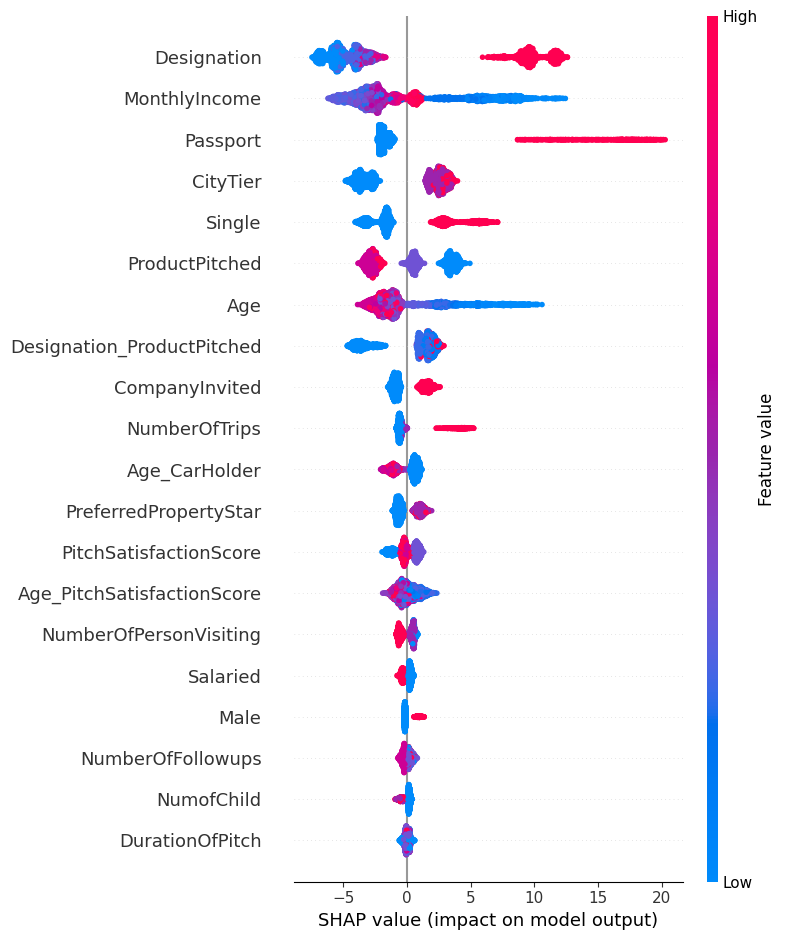

In [70]:
import shap
import lightgbm as lgb
import matplotlib.pyplot as plt
shap.initjs()

# 各FOLD、SEEDの和 (相対値なのでこれで良しとする)
shapval = 0
for i in range(3):
  for j in range(5):
    explainer = shap.TreeExplainer(models[i][j])
    shap_values = explainer.shap_values(train.drop("ProdTaken",axis=1))
    shapval = shapval + shap_values

shap.summary_plot(shapval, train.drop("ProdTaken",axis=1))

In [ ]:
all_df.columns

Index(['id', 'Age', 'CompanyInvited', 'CityTier', 'DurationOfPitch',
       'Salaried', 'Male', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'CarHolder',
       'NumofChild', 'Single', 'ProdTaken', 'Designation_ProductPitched',
       'Passport_Single', 'Age_PitchSatisfactionScore', 'Age_CarHolder'],
      dtype='object')

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(train[TARGET],oof_lgb)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr,label='LogisticRegression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

NameError: name 'oof_lgb' is not defined

7. 提出

In [78]:
# submit_sample.csvを読み込みます。
submit = pd.read_csv("/content/sample_submit.csv", header=None)
submit.head(1)

,0,1
0,3489,0.119451


In [79]:
# テストデータを用いて予測します。
predict = 0
for i in range(3):
  for j in range(5):
    predict = predict + models[i][j].predict(test)
predict = predict / 15
submit[1] = predict

In [80]:
# 提出
submit.to_csv("submission.csv", index=False, header=None)

In [ ]:
%%time
from sklearn.model_selection import StratifiedKFold

FOLDS = 5 # 分割数
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))
models = []
evaluations_result = {}

for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):

  print("#"*25)
  print(f"### Fold {i+1}")
  print("#"*25)

  # インデックスに割り振る

  x_train = train.loc[train_index, FEATURES].copy()
  y_train = train.loc[train_index, TARGET]
  x_valid = train.loc[test_index, FEATURES].copy()
  y_valid = train.loc[test_index, TARGET]
  # x_test = test[FEATURES].copy()

  # データセット作成
  lgb_train = lgb.Dataset(x_train, y_train)
  lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

  # 学習
  model_lgb = lgb.train(lgbm_params,
                        lgb_train,
                        num_boost_round = 2000,
                        valid_sets = [lgb_train, lgb_eval],
                        valid_names = ["train", "valid"],
                        callbacks = [
                            lgb.early_stopping(stopping_rounds=100, verbose=False),
                            lgb.record_evaluation(evaluations_result),
                            lgb.log_evaluation(100),])

  oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
  models.append(model_lgb)

pred_lgb /= FOLDS

#########################
### Fold 1
#########################
[100]	train's auc: 0.835515	valid's auc: 0.836304


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.846733	valid's auc: 0.840351
[300]	train's auc: 0.855644	valid's auc: 0.839666
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.833964	valid's auc: 0.827559
[200]	train's auc: 0.845655	valid's auc: 0.837258
[300]	train's auc: 0.854293	valid's auc: 0.843077
[400]	train's auc: 0.86177	valid's auc: 0.843294
[500]	train's auc: 0.867884	valid's auc: 0.84495
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.843199	valid's auc: 0.793562
[200]	train's auc: 0.853454	valid's auc: 0.802718
[300]	train's auc: 0.862205	valid's auc: 0.809329
[400]	train's auc: 0.868638	valid's auc: 0.80857
#########################
### Fold 4
#########################
[100]	train's auc: 0.837455	valid's auc: 0.824784
[200]	train's auc: 0.850055	valid's auc: 0.827878


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.858332	valid's auc: 0.831824
[400]	train's auc: 0.865231	valid's auc: 0.83233
[500]	train's auc: 0.871703	valid's auc: 0.834354
#########################
### Fold 5
#########################
[100]	train's auc: 0.842865	valid's auc: 0.801544


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.852312	valid's auc: 0.816206
[300]	train's auc: 0.86099	valid's auc: 0.821172
[400]	train's auc: 0.868284	valid's auc: 0.822523
[500]	train's auc: 0.873781	valid's auc: 0.823959
[600]	train's auc: 0.878005	valid's auc: 0.825344
CPU times: user 24.8 s, sys: 904 ms, total: 25.7 s
Wall time: 4.49 s


In [ ]:
from sklearn.metrics import roc_auc_score # AUC評価指標
# AUCの評価(第一引数にy_trueを入れる)
score = roc_auc_score(train[TARGET],oof_lgb)
print(score)

0.8299435651341203
